In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture
from google.colab import files

In [ ]:
key = random.PRNGKey(1998)
key1 = random.PRNGKey(698)
key2 = random.PRNGKey(61998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [ ]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size', 'num_datasets'])
def simulate_gandk(theta, dataset_size, num_datasets, c = 0.8):
    zu = random.normal(key, shape = (num_datasets, dataset_size))
    f = (theta[0] + theta[1] * (1 + c * (1 - jnp.exp(-theta[2] * zu)) / (1 + jnp.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

In [ ]:
true_theta = jnp.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
n_samples = 1000
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)
eps_precision = 100
sigma_theta = 4
sigma_latent = 1
tau = 0.01

In [ ]:
actual_data = simulate_gandk(true_theta, n_samples, 1)
actual_data

Array([[ 2.533019 ,  4.2583838,  2.9657855,  7.7651787,  4.315691 ,
         2.624684 ,  3.7306223,  2.5984108,  2.2627926,  5.142304 ,
         2.6263962,  2.8118043,  4.0308976,  3.1802762,  3.0096152,
         4.217298 ,  2.4840693,  2.8079197,  2.129045 ,  3.282777 ,
         3.289466 ,  2.6660774,  3.0369363,  2.6196127,  2.2303152,
         2.3448486,  3.0718887,  2.1926277,  2.853173 ,  2.830915 ,
         3.135084 ,  3.014315 ,  7.427062 ,  3.5784287,  2.9505444,
         2.9950998,  2.7880185,  3.3230941,  2.3120227,  3.3853643,
         3.36703  ,  4.0929003,  2.4578938,  2.9232605,  3.193862 ,
         2.621558 ,  3.385849 ,  2.5847187,  2.5572193, 15.93477  ,
        12.2919655,  2.67837  ,  2.3236575,  2.329368 ,  3.41379  ,
         3.131748 ,  2.4515002,  3.1252725,  2.5167456,  2.9191961,
         2.2537694,  3.9317951,  2.4269989,  4.5854983,  2.5509052,
         4.2632523,  2.2107048,  5.508738 ,  6.574063 ,  2.3634913,
         7.8634067,  1.6650825,  4.962424 ,  3.0

In [ ]:
# CALCULATE SUMMARY STATS
@jit
def compute_summary_statistics(y):
    quant_y = []
    for i in jnp.arange(0.125, 1, 0.125):
        quant_y.append(jnp.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return jnp.array([Sa, Sb, Sc, Sd])

In [ ]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

Array([2.9935818 , 1.6461515 , 0.47686973, 1.8010063 ], dtype=float32)

In [ ]:
actual_summary_statistics = jnp.array([2.96978227, 1.45609898, 0.4837584 , 2.00723605])

In [ ]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [ ]:
len_ss = jnp.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 16
# To optimize F
tau = 0.01
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20

In [ ]:
# Generating data to train the transform
wass_datasets = simulate_gandk(true_theta, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = jnp.array([compute_summary_statistics(wass_datasets[i,:]) for i in range(wass_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics
val_datasets = simulate_gandk(true_theta, wass_n_samples, wass_val_num_datasets)
val_n_summary_statistics = jnp.array([compute_summary_statistics(wass_datasets[i,:]) for i in range(wass_val_num_datasets)])

In [ ]:
scaler_mean = jnp.mean(original_n_summary_statistics, axis=0)
scaler_std = jnp.std(original_n_summary_statistics, axis=0)
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [ ]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        # beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x
def kl(x):
    return 1/2 * x.T @ x
def f_with_Lambda_(Lambda, x):
    T_x, log_Jacobian = radial_flow(Lambda, x)
    diff = x - T_x
    f = - log_Jacobian + 1/2 * T_x.T @ T_x + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    return f
def mean_f(Lambda, x):
    mean_f = jnp.mean(f_with_Lambda_batched(Lambda, x))
    return mean_f

In [ ]:
transform_auto = vmap(radial_flow, in_axes=(None, 0))
f_with_Lambda_batched = vmap(f_with_Lambda_, in_axes=(None, 0))
kl_auto = vmap(kl)
KL_all = []
Lambda_list = []
patience = 0
Lambda = random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
# Pre-compute random permutations outside the loop for efficiency
random_permutations = [random.permutation(subkey, wass_num_datasets) for subkey in subkeys1]

for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random_permutations[t][:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(mean_f, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = mean_f(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    KL_all.append(kl_k)
    print('>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<<', kl_k)
    if kl_k > jnp.min(jnp.array(KL_all)):
        patience += 1
    else:
        patience = 0
        transformed_n_summary_statistics = wass_n_summary_statistics
    if patience > Patience:
        print("Stop at", k)
        break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 23.194117
F Smoothed 21.71653
F Smoothed 20.478813
F Smoothed 19.160295
F Smoothed 18.086525
F Smoothed 16.99716
F Smoothed 15.880342
F Smoothed 14.973501
F Smoothed 13.976402
F Smoothed 13.000164
F Smoothed 12.166542
F Smoothed 11.400285
F Smoothed 10.654186
F Smoothed 9.974539
F Smoothed 9.25944
F Smoothed 8.600909
F Smoothed 8.025282
F Smoothed 7.446667
F Smoothed 7.008456
F Smoothed 6.600074
F Smoothed 6.187409
F Smoothed 5.769851
F Smoothed 5.3548665
F Smoothed 5.0369678
F Smoothed 4.7951574
F Smoothed 4.5364966
F Smoothed 4.2885566
F Smoothed 4.0414653
F Smoothed 3.8592005
F Smoothed 3.6764376
F Smoothed 3.4879847
F Smoothed 3.3306751
F Smoothed 3.2207959
F Smoothed 3.121214
F Smoothed 3.0331407
F Smoothed 2.9181716
F Smoothed 2.8460472
F Smoothed 2.8155265
F Smoothed 2.732041
F Smoothed 2.7261746
F Smoothed 2.6850142
F Smoothed 2.6421657
F Smoothed 2.601392
F Smoothed 2.5607176
F Smoothed 2.531032
F Smoothed 2.5260916
F Smoothed 2.5310671
F Smoothed 2.4947171
F Smooth

  0%|          | 1/5000 [06:13<518:11:39, 373.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.940766
F Smoothed 2.1601796
F Smoothed 2.1617737
F Smoothed 2.1659565
F Smoothed 2.170039
F Smoothed 2.1802013
F Smoothed 2.2025397
F Smoothed 2.2067158
F Smoothed 2.2493382
F Smoothed 2.266228
F Smoothed 2.263658
F Smoothed 2.2421715
F Smoothed 2.2428954
F Smoothed 2.242215
F Smoothed 2.2568414
F Smoothed 2.2461302
F Smoothed 2.232489
F Smoothed 2.2358963
F Smoothed 2.2294896
F Smoothed 2.2272465
F Smoothed 2.2188113
F Smoothed 2.2042482
F Smoothed 2.2182963
F Smoothed 2.210501
F Smoothed 2.1924198
F Smoothed 2.2012627
F Smoothed 2.1886091
F Smoothed 2.1792288
F Smoothed 2.1769803
F Smoothed 2.179409
F Smoothed 2.172414
F Smoothed 2.1757782
F Smoothed 2.175067
F Smoothed 2.1707027
F Smoothed 2.1775312
F Smoothed 2.1745908
F Smoothed 2.1489613
F Smoothed 2.1648798
F Smoothed 2.1857445
F Smoothed 2.1612468
F Smoothed 2.2173903
F Smoothed 2.2151356
F Smoothed 2.2061136
F Smoothed 2.197626
F Smoothed 2.2040124
F Smoothed 2.2040699
F Sm

  0%|          | 2/5000 [11:50<488:30:54, 351.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.08103
F Smoothed 2.101163
F Smoothed 2.1021035
F Smoothed 2.1071775
F Smoothed 2.1101506
F Smoothed 2.120649
F Smoothed 2.142015
F Smoothed 2.145896
F Smoothed 2.1851857
F Smoothed 2.20126
F Smoothed 2.2000477
F Smoothed 2.183271
F Smoothed 2.1852994
F Smoothed 2.1859362
F Smoothed 2.1974304
F Smoothed 2.1877797
F Smoothed 2.1758177
F Smoothed 2.1791787
F Smoothed 2.1748211
F Smoothed 2.173622
F Smoothed 2.1661074
F Smoothed 2.154794
F Smoothed 2.1673868
F Smoothed 2.1603322
F Smoothed 2.143666
F Smoothed 2.1496584
F Smoothed 2.1383324
F Smoothed 2.1287677
F Smoothed 2.12637
F Smoothed 2.1284578
F Smoothed 2.1214929
F Smoothed 2.1249008
F Smoothed 2.1238244
F Smoothed 2.1213295
F Smoothed 2.1263788
F Smoothed 2.1241925
F Smoothed 2.1017337
F Smoothed 2.1161077
F Smoothed 2.1343594
F Smoothed 2.1133707
F Smoothed 2.1622896
F Smoothed 2.159876
F Smoothed 2.152387
F Smoothed 2.1448677
F Smoothed 2.1517882
F Smoothed 2.1519604
F Smooth

  0%|          | 3/5000 [17:27<479:19:56, 345.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.163759
F Smoothed 2.0327406
F Smoothed 2.033719
F Smoothed 2.0387876
F Smoothed 2.0408943
F Smoothed 2.051852
F Smoothed 2.0709908
F Smoothed 2.0730631
F Smoothed 2.1084151
F Smoothed 2.1225429
F Smoothed 2.121304
F Smoothed 2.1066358
F Smoothed 2.1083229
F Smoothed 2.1091158
F Smoothed 2.1187587
F Smoothed 2.110041
F Smoothed 2.098734
F Smoothed 2.1015053
F Smoothed 2.0981407
F Smoothed 2.0970507
F Smoothed 2.0909147
F Smoothed 2.0807624
F Smoothed 2.0916498
F Smoothed 2.0844593
F Smoothed 2.0688179
F Smoothed 2.0740116
F Smoothed 2.06374
F Smoothed 2.054815
F Smoothed 2.0527267
F Smoothed 2.0545707
F Smoothed 2.0485637
F Smoothed 2.0517948
F Smoothed 2.0499
F Smoothed 2.0485163
F Smoothed 2.0521996
F Smoothed 2.0503144
F Smoothed 2.029696
F Smoothed 2.0430458
F Smoothed 2.0598376
F Smoothed 2.040521
F Smoothed 2.084597
F Smoothed 2.0817606
F Smoothed 2.0750031
F Smoothed 2.0681806
F Smoothed 2.0743244
F Smoothed 2.074989
F Smooth

  0%|          | 4/5000 [23:31<489:09:49, 352.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.207417
F Smoothed 1.9611442
F Smoothed 1.9618429
F Smoothed 1.966465
F Smoothed 1.9681045
F Smoothed 1.979318
F Smoothed 1.995984
F Smoothed 1.9968225
F Smoothed 2.0293558
F Smoothed 2.042107
F Smoothed 2.0409305
F Smoothed 2.0280433
F Smoothed 2.0294342
F Smoothed 2.0309045
F Smoothed 2.038976
F Smoothed 2.0310857
F Smoothed 2.0201697
F Smoothed 2.0222127
F Smoothed 2.019806
F Smoothed 2.0192995
F Smoothed 2.0142388
F Smoothed 2.0049598
F Smoothed 2.0144303
F Smoothed 2.006882
F Smoothed 1.9918854
F Smoothed 1.997399
F Smoothed 1.9877998
F Smoothed 1.9792928
F Smoothed 1.9775124
F Smoothed 1.9793236
F Smoothed 1.9743575
F Smoothed 1.9771428
F Smoothed 1.9743538
F Smoothed 1.9735804
F Smoothed 1.9766535
F Smoothed 1.9749589
F Smoothed 1.9556597
F Smoothed 1.9681219
F Smoothed 1.9833463
F Smoothed 1.9652106
F Smoothed 2.0056145
F Smoothed 2.002385
F Smoothed 1.9960234
F Smoothed 1.9898583
F Smoothed 1.994922
F Smoothed 1.9960331
F S

  0%|          | 5/5000 [29:09<482:03:06, 347.42s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.228443
F Smoothed 1.8971264
F Smoothed 1.8975426
F Smoothed 1.9017017
F Smoothed 1.9030352
F Smoothed 1.9141448
F Smoothed 1.9289981
F Smoothed 1.9288734
F Smoothed 1.9590333
F Smoothed 1.9707494
F Smoothed 1.9698055
F Smoothed 1.9582856
F Smoothed 1.959631
F Smoothed 1.9618361
F Smoothed 1.9687318
F Smoothed 1.9616631
F Smoothed 1.9509823
F Smoothed 1.9523652
F Smoothed 1.9509071
F Smoothed 1.951027
F Smoothed 1.9465091
F Smoothed 1.9377532
F Smoothed 1.9460933
F Smoothed 1.9381263
F Smoothed 1.9234557
F Smoothed 1.9290818
F Smoothed 1.9198093
F Smoothed 1.911367
F Smoothed 1.9097502
F Smoothed 1.9118496
F Smoothed 1.9076492
F Smoothed 1.9099915
F Smoothed 1.9063896
F Smoothed 1.9058049
F Smoothed 1.9087561
F Smoothed 1.9071401
F Smoothed 1.8886775
F Smoothed 1.9005148
F Smoothed 1.9143078
F Smoothed 1.8970712
F Smoothed 1.9346218
F Smoothed 1.9310112
F Smoothed 1.9249535
F Smoothed 1.919239
F Smoothed 1.9232776
F Smoothed 1.92485

  0%|          | 6/5000 [34:45<476:17:49, 343.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.238283
F Smoothed 1.8457342
F Smoothed 1.845982
F Smoothed 1.8499066
F Smoothed 1.8509849
F Smoothed 1.8618442
F Smoothed 1.8755941
F Smoothed 1.8747176
F Smoothed 1.9027951
F Smoothed 1.9137719
F Smoothed 1.9132
F Smoothed 1.902793
F Smoothed 1.9043174
F Smoothed 1.9068711
F Smoothed 1.912978
F Smoothed 1.9067478
F Smoothed 1.8961555
F Smoothed 1.8971182
F Smoothed 1.8965108
F Smoothed 1.8968178
F Smoothed 1.8925176
F Smoothed 1.884032
F Smoothed 1.8915347
F Smoothed 1.8833711
F Smoothed 1.8688817
F Smoothed 1.874558
F Smoothed 1.8654627
F Smoothed 1.8567955
F Smoothed 1.8553692
F Smoothed 1.8579909
F Smoothed 1.854419
F Smoothed 1.8563274
F Smoothed 1.8518817
F Smoothed 1.851192
F Smoothed 1.8542919
F Smoothed 1.8527321
F Smoothed 1.8349131
F Smoothed 1.8462402
F Smoothed 1.8590082
F Smoothed 1.842255
F Smoothed 1.8774476
F Smoothed 1.8733499
F Smoothed 1.8675941
F Smoothed 1.8621498
F Smoothed 1.865602
F Smoothed 1.8676274
F Smo

  0%|          | 7/5000 [40:15<470:17:51, 339.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.244163
F Smoothed 1.8102318
F Smoothed 1.81045
F Smoothed 1.8144459
F Smoothed 1.8152487
F Smoothed 1.8259629
F Smoothed 1.8391247
F Smoothed 1.8379322
F Smoothed 1.8642563
F Smoothed 1.8746905
F Smoothed 1.8744537
F Smoothed 1.864903
F Smoothed 1.8666745
F Smoothed 1.8691596
F Smoothed 1.8747365
F Smoothed 1.8693043
F Smoothed 1.8586808
F Smoothed 1.8593978
F Smoothed 1.8595564
F Smoothed 1.859413
F Smoothed 1.8552314
F Smoothed 1.8469067
F Smoothed 1.8538618
F Smoothed 1.8462288
F Smoothed 1.8318359
F Smoothed 1.8375779
F Smoothed 1.8286971
F Smoothed 1.8196716
F Smoothed 1.8186519
F Smoothed 1.8218315
F Smoothed 1.818893
F Smoothed 1.8203498
F Smoothed 1.8148792
F Smoothed 1.8140928
F Smoothed 1.8173277
F Smoothed 1.8157759
F Smoothed 1.7984229
F Smoothed 1.809261
F Smoothed 1.8213948
F Smoothed 1.8048265
F Smoothed 1.8381227
F Smoothed 1.8334376
F Smoothed 1.8278936
F Smoothed 1.8226256
F Smoothed 1.8259966
F Smoothed 1.8284127

  0%|          | 8/5000 [45:56<470:54:36, 339.60s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.249759
F Smoothed 1.7930624
F Smoothed 1.7929876
F Smoothed 1.7971786
F Smoothed 1.7976848
F Smoothed 1.8083308
F Smoothed 1.8212444
F Smoothed 1.8201435
F Smoothed 1.845097
F Smoothed 1.8551894
F Smoothed 1.8553987
F Smoothed 1.8465743
F Smoothed 1.8487096
F Smoothed 1.851038
F Smoothed 1.8562323
F Smoothed 1.8514326
F Smoothed 1.8406708
F Smoothed 1.8412013
F Smoothed 1.8420056
F Smoothed 1.8411816
F Smoothed 1.8370149
F Smoothed 1.8286531
F Smoothed 1.8351878
F Smoothed 1.8283113
F Smoothed 1.8139359
F Smoothed 1.8197943
F Smoothed 1.8111298
F Smoothed 1.8016663
F Smoothed 1.8012421
F Smoothed 1.8048524
F Smoothed 1.8024628
F Smoothed 1.8033668
F Smoothed 1.7967436
F Smoothed 1.7960469
F Smoothed 1.7993704
F Smoothed 1.7978586
F Smoothed 1.7807459
F Smoothed 1.7911433
F Smoothed 1.802885
F Smoothed 1.7863429
F Smoothed 1.8182484
F Smoothed 1.8129109
F Smoothed 1.8073604
F Smoothed 1.8021276
F Smoothed 1.8057005
F Smoothed 1.8084

  0%|          | 9/5000 [51:28<467:44:04, 337.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.256192
F Smoothed 1.7898154
F Smoothed 1.7893803
F Smoothed 1.7939247
F Smoothed 1.7942237
F Smoothed 1.804899
F Smoothed 1.817827
F Smoothed 1.8168603
F Smoothed 1.840803
F Smoothed 1.8505309
F Smoothed 1.8512064
F Smoothed 1.8429946
F Smoothed 1.8456131
F Smoothed 1.8478948
F Smoothed 1.852708
F Smoothed 1.8484288
F Smoothed 1.8375756
F Smoothed 1.8379563
F Smoothed 1.8392643
F Smoothed 1.8379138
F Smoothed 1.8336277
F Smoothed 1.8249553
F Smoothed 1.8310736
F Smoothed 1.8245155
F Smoothed 1.810099
F Smoothed 1.8160641
F Smoothed 1.8075819
F Smoothed 1.7977034
F Smoothed 1.7979898
F Smoothed 1.8018137
F Smoothed 1.7998153
F Smoothed 1.8000753
F Smoothed 1.7924674
F Smoothed 1.7920128
F Smoothed 1.795445
F Smoothed 1.794018
F Smoothed 1.7770561
F Smoothed 1.7870755
F Smoothed 1.7986234
F Smoothed 1.7821726
F Smoothed 1.8130556
F Smoothed 1.8071293
F Smoothed 1.8014559
F Smoothed 1.7961162
F Smoothed 1.8000187
F Smoothed 1.8030055


  0%|          | 10/5000 [56:59<464:48:58, 335.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.263614
F Smoothed 1.7967578
F Smoothed 1.795978
F Smoothed 1.8009808
F Smoothed 1.8012036
F Smoothed 1.8119334
F Smoothed 1.825157
F Smoothed 1.8243513
F Smoothed 1.8475983
F Smoothed 1.8567909
F Smoothed 1.8579563
F Smoothed 1.850225
F Smoothed 1.8534845
F Smoothed 1.8558865
F Smoothed 1.8603044
F Smoothed 1.8565174
F Smoothed 1.8456652
F Smoothed 1.8459352
F Smoothed 1.8477198
F Smoothed 1.8460872
F Smoothed 1.84161
F Smoothed 1.8324937
F Smoothed 1.8382279
F Smoothed 1.8316892
F Smoothed 1.8171597
F Smoothed 1.823146
F Smoothed 1.8147937
F Smoothed 1.8044966
F Smoothed 1.8055493
F Smoothed 1.8094689
F Smoothed 1.8077226
F Smoothed 1.8072687
F Smoothed 1.7989408
F Smoothed 1.7988024
F Smoothed 1.8024188
F Smoothed 1.80104
F Smoothed 1.7841692
F Smoothed 1.7939049
F Smoothed 1.8053932
F Smoothed 1.7891988
F Smoothed 1.8192275
F Smoothed 1.8127925
F Smoothed 1.8069878
F Smoothed 1.801449
F Smoothed 1.8057692
F Smoothed 1.8089082
F 

  0%|          | 11/5000 [1:02:13<455:47:08, 328.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.279925
F Smoothed 1.9211777
F Smoothed 1.920128
F Smoothed 1.9258214
F Smoothed 1.9262437
F Smoothed 1.9379627
F Smoothed 1.952572
F Smoothed 1.9526762
F Smoothed 1.9764847
F Smoothed 1.9866598
F Smoothed 1.9893013
F Smoothed 1.9815964
F Smoothed 1.985932
F Smoothed 1.989104
F Smoothed 1.9930031
F Smoothed 1.9893873
F Smoothed 1.9778762
F Smoothed 1.9784193
F Smoothed 1.980965
F Smoothed 1.9791464
F Smoothed 1.9748495
F Smoothed 1.9657624
F Smoothed 1.9716393
F Smoothed 1.9645869
F Smoothed 1.9500027
F Smoothed 1.9558249
F Smoothed 1.9472388
F Smoothed 1.9358288
F Smoothed 1.9373536
F Smoothed 1.9414511
F Smoothed 1.939844
F Smoothed 1.9387091
F Smoothed 1.9294122
F Smoothed 1.929448
F Smoothed 1.9337052
F Smoothed 1.9320774
F Smoothed 1.9136995
F Smoothed 1.9238248
F Smoothed 1.9356985
F Smoothed 1.9192209
F Smoothed 1.9494839
F Smoothed 1.9428157
F Smoothed 1.9370059
F Smoothed 1.9308494
F Smoothed 1.9357237
F Smoothed 1.9390494


  0%|          | 12/5000 [1:07:24<448:16:03, 323.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.284255
F Smoothed 2.0233552
F Smoothed 2.0219526
F Smoothed 2.0284252
F Smoothed 2.0289977
F Smoothed 2.0412056
F Smoothed 2.0567555
F Smoothed 2.0571692
F Smoothed 2.0811813
F Smoothed 2.0914025
F Smoothed 2.0946949
F Smoothed 2.0871937
F Smoothed 2.0923982
F Smoothed 2.096004
F Smoothed 2.0993738
F Smoothed 2.0962565
F Smoothed 2.0843496
F Smoothed 2.084851
F Smoothed 2.0881846
F Smoothed 2.0860322
F Smoothed 2.0813484
F Smoothed 2.0717514
F Smoothed 2.0775566
F Smoothed 2.0703032
F Smoothed 2.0551198
F Smoothed 2.06119
F Smoothed 2.05253
F Smoothed 2.0401003
F Smoothed 2.042216
F Smoothed 2.0464127
F Smoothed 2.0447228
F Smoothed 2.042795
F Smoothed 2.032663
F Smoothed 2.0330625
F Smoothed 2.0375452
F Smoothed 2.0356991
F Smoothed 2.0165641
F Smoothed 2.0268066
F Smoothed 2.038799
F Smoothed 2.0222714
F Smoothed 2.0525618
F Smoothed 2.045492
F Smoothed 2.0397937
F Smoothed 2.0331454
F Smoothed 2.038651
F Smoothed 2.0422575
F Smo

  0%|          | 13/5000 [1:12:37<443:42:02, 320.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.282758
F Smoothed 2.1078427
F Smoothed 2.1060724
F Smoothed 2.113145
F Smoothed 2.113794
F Smoothed 2.1262815
F Smoothed 2.1426706
F Smoothed 2.1434758
F Smoothed 2.167685
F Smoothed 2.177751
F Smoothed 2.1815562
F Smoothed 2.1742802
F Smoothed 2.1802597
F Smoothed 2.1842353
F Smoothed 2.1872334
F Smoothed 2.1845315
F Smoothed 2.1723886
F Smoothed 2.1728609
F Smoothed 2.1768622
F Smoothed 2.1744177
F Smoothed 2.169322
F Smoothed 2.1595392
F Smoothed 2.1652713
F Smoothed 2.1578722
F Smoothed 2.1420023
F Smoothed 2.148222
F Smoothed 2.1396294
F Smoothed 2.1263397
F Smoothed 2.129029
F Smoothed 2.133309
F Smoothed 2.1314838
F Smoothed 2.128703
F Smoothed 2.1178515
F Smoothed 2.118554
F Smoothed 2.1232173
F Smoothed 2.1210978
F Smoothed 2.1013784
F Smoothed 2.1116545
F Smoothed 2.123529
F Smoothed 2.1071918
F Smoothed 2.1373627
F Smoothed 2.1300778
F Smoothed 2.124537
F Smoothed 2.117424
F Smoothed 2.123516
F Smoothed 2.1273546
F Smoot

  0%|          | 14/5000 [1:17:47<439:09:47, 317.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.279145
F Smoothed 2.1805851
F Smoothed 2.178447
F Smoothed 2.1859586
F Smoothed 2.1866117
F Smoothed 2.1992722
F Smoothed 2.2164166
F Smoothed 2.2176394
F Smoothed 2.2420468
F Smoothed 2.2517965
F Smoothed 2.2560089
F Smoothed 2.248885
F Smoothed 2.2554977
F Smoothed 2.2597313
F Smoothed 2.262554
F Smoothed 2.26015
F Smoothed 2.2478735
F Smoothed 2.2483606
F Smoothed 2.2528944
F Smoothed 2.250205
F Smoothed 2.244726
F Smoothed 2.2350662
F Smoothed 2.240742
F Smoothed 2.2332819
F Smoothed 2.216722
F Smoothed 2.2229276
F Smoothed 2.2145765
F Smoothed 2.200689
F Smoothed 2.2038627
F Smoothed 2.2082014
F Smoothed 2.2062557
F Smoothed 2.202649
F Smoothed 2.1912053
F Smoothed 2.1921349
F Smoothed 2.1969402
F Smoothed 2.1945367
F Smoothed 2.1743784
F Smoothed 2.184602
F Smoothed 2.1962073
F Smoothed 2.1802428
F Smoothed 2.2102072
F Smoothed 2.2028759
F Smoothed 2.19754
F Smoothed 2.1899984
F Smoothed 2.1965704
F Smoothed 2.2005723
F Smoot

  0%|          | 15/5000 [1:22:48<432:32:41, 312.37s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.274995
F Smoothed 2.2468321
F Smoothed 2.24435
F Smoothed 2.2521243
F Smoothed 2.2527268
F Smoothed 2.2655075
F Smoothed 2.2833347
F Smoothed 2.2849293
F Smoothed 2.3095434
F Smoothed 2.318922
F Smoothed 2.3234377
F Smoothed 2.316298
F Smoothed 2.3233883
F Smoothed 2.3278022
F Smoothed 2.3305812
F Smoothed 2.3283818
F Smoothed 2.3159635
F Smoothed 2.3164897
F Smoothed 2.3214266
F Smoothed 2.3185365
F Smoothed 2.312696
F Smoothed 2.303261
F Smoothed 2.3088326
F Smoothed 2.3013716
F Smoothed 2.2842145
F Smoothed 2.290214
F Smoothed 2.2822342
F Smoothed 2.2680688
F Smoothed 2.2716615
F Smoothed 2.2760549
F Smoothed 2.2739913
F Smoothed 2.2697723
F Smoothed 2.2578769
F Smoothed 2.258987
F Smoothed 2.2639227
F Smoothed 2.2611997
F Smoothed 2.2406967
F Smoothed 2.2508237
F Smoothed 2.2620964
F Smoothed 2.2465076
F Smoothed 2.2763233
F Smoothed 2.2690637
F Smoothed 2.26398
F Smoothed 2.256078
F Smoothed 2.263009
F Smoothed 2.267117
F Smoo

  0%|          | 16/5000 [1:27:47<426:42:42, 308.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.269826
F Smoothed 2.311018
F Smoothed 2.3082676
F Smoothed 2.3161576
F Smoothed 2.3166354
F Smoothed 2.3295436
F Smoothed 2.3480046
F Smoothed 2.3498912
F Smoothed 2.3747516
F Smoothed 2.3838115
F Smoothed 2.3885064
F Smoothed 2.3812234
F Smoothed 2.388638
F Smoothed 2.393258
F Smoothed 2.3960001
F Smoothed 2.3939323
F Smoothed 2.381328
F Smoothed 2.381878
F Smoothed 2.3871136
F Smoothed 2.3840256
F Smoothed 2.3777907
F Smoothed 2.3685148
F Smoothed 2.3738873
F Smoothed 2.3664126
F Smoothed 2.3487327
F Smoothed 2.3544734
F Smoothed 2.3468978
F Smoothed 2.3326266
F Smoothed 2.33661
F Smoothed 2.3410811
F Smoothed 2.3388658
F Smoothed 2.334169
F Smoothed 2.3219445
F Smoothed 2.3232057
F Smoothed 2.3282962
F Smoothed 2.3252423
F Smoothed 2.3044455
F Smoothed 2.314473
F Smoothed 2.3254323
F Smoothed 2.3100784
F Smoothed 2.3399045
F Smoothed 2.332793
F Smoothed 2.3279579
F Smoothed 2.31977
F Smoothed 2.3269691
F Smoothed 2.3311682
F Smo

  0%|          | 17/5000 [1:32:54<426:00:27, 307.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.262184
F Smoothed 2.3764687
F Smoothed 2.3734803
F Smoothed 2.381367
F Smoothed 2.3816714
F Smoothed 2.3947608
F Smoothed 2.4138892
F Smoothed 2.416052
F Smoothed 2.4412045
F Smoothed 2.4500458
F Smoothed 2.4548578
F Smoothed 2.4473166
F Smoothed 2.4549453
F Smoothed 2.459894
F Smoothed 2.462523
F Smoothed 2.4605348
F Smoothed 2.4477167
F Smoothed 2.4482934
F Smoothed 2.4537442
F Smoothed 2.4504578
F Smoothed 2.443837
F Smoothed 2.4347205
F Smoothed 2.4398088
F Smoothed 2.432249
F Smoothed 2.4141095
F Smoothed 2.4196784
F Smoothed 2.4124842
F Smoothed 2.3981209
F Smoothed 2.4025307
F Smoothed 2.4071665
F Smoothed 2.4047608
F Smoothed 2.3996172
F Smoothed 2.387108
F Smoothed 2.3884952
F Smoothed 2.3937829
F Smoothed 2.3904085
F Smoothed 2.3693511
F Smoothed 2.3792737
F Smoothed 2.3899803
F Smoothed 2.37474
F Smoothed 2.40471
F Smoothed 2.3978112
F Smoothed 2.3931913
F Smoothed 2.3847759
F Smoothed 2.3921912
F Smoothed 2.3964937
F Sm

  0%|          | 18/5000 [1:38:04<426:51:38, 308.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.251088
F Smoothed 2.444589
F Smoothed 2.4414213
F Smoothed 2.4492474
F Smoothed 2.449387
F Smoothed 2.462673
F Smoothed 2.4825094
F Smoothed 2.4849331
F Smoothed 2.5103738
F Smoothed 2.5190346
F Smoothed 2.5239305
F Smoothed 2.5160573
F Smoothed 2.5238237
F Smoothed 2.5292046
F Smoothed 2.5316408
F Smoothed 2.529757
F Smoothed 2.5167046
F Smoothed 2.5173106
F Smoothed 2.522933
F Smoothed 2.5194333
F Smoothed 2.512453
F Smoothed 2.5035071
F Smoothed 2.5082712
F Smoothed 2.5005386
F Smoothed 2.4819918
F Smoothed 2.4875672
F Smoothed 2.4807389
F Smoothed 2.4662251
F Smoothed 2.4710908
F Smoothed 2.4759881
F Smoothed 2.473347
F Smoothed 2.4677663
F Smoothed 2.4549959
F Smoothed 2.4565022
F Smoothed 2.4620123
F Smoothed 2.4583485
F Smoothed 2.4370444
F Smoothed 2.4468648
F Smoothed 2.4573853
F Smoothed 2.4422147
F Smoothed 2.4723773
F Smoothed 2.4657216
F Smoothed 2.4613197
F Smoothed 2.4527001
F Smoothed 2.4603326
F Smoothed 2.4647877


  0%|          | 19/5000 [1:43:05<423:58:24, 306.43s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.236397
F Smoothed 2.5141778
F Smoothed 2.5107641
F Smoothed 2.5185156
F Smoothed 2.5184634
F Smoothed 2.5319254
F Smoothed 2.5524924
F Smoothed 2.5551813
F Smoothed 2.5808504
F Smoothed 2.5893195
F Smoothed 2.5942876
F Smoothed 2.586102
F Smoothed 2.593948
F Smoothed 2.599779
F Smoothed 2.6019974
F Smoothed 2.600213
F Smoothed 2.5869164
F Smoothed 2.5875509
F Smoothed 2.5933595
F Smoothed 2.5896397
F Smoothed 2.5823233
F Smoothed 2.5735338
F Smoothed 2.5779395
F Smoothed 2.5700665
F Smoothed 2.5510583
F Smoothed 2.5567753
F Smoothed 2.550257
F Smoothed 2.535529
F Smoothed 2.540851
F Smoothed 2.5460281
F Smoothed 2.543176
F Smoothed 2.5371687
F Smoothed 2.5242002
F Smoothed 2.525826
F Smoothed 2.5315611
F Smoothed 2.5276797
F Smoothed 2.5061035
F Smoothed 2.5157936
F Smoothed 2.5261736
F Smoothed 2.5110614
F Smoothed 2.54148
F Smoothed 2.535088
F Smoothed 2.5308583
F Smoothed 2.5220306
F Smoothed 2.529896
F Smoothed 2.534529
F Smoot

  0%|          | 20/5000 [1:48:07<422:01:37, 305.08s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.218842
F Smoothed 2.582214
F Smoothed 2.578542
F Smoothed 2.5862985
F Smoothed 2.5860837
F Smoothed 2.5997052
F Smoothed 2.6209655
F Smoothed 2.623908
F Smoothed 2.649723
F Smoothed 2.6579998
F Smoothed 2.6630173
F Smoothed 2.654614
F Smoothed 2.6625063
F Smoothed 2.6687524
F Smoothed 2.670767
F Smoothed 2.6691296
F Smoothed 2.6556036
F Smoothed 2.6562755
F Smoothed 2.6623263
F Smoothed 2.6583745
F Smoothed 2.6507547
F Smoothed 2.642098
F Smoothed 2.6461823
F Smoothed 2.6381965
F Smoothed 2.6186857
F Smoothed 2.624684
F Smoothed 2.6184452
F Smoothed 2.6034322
F Smoothed 2.6091602
F Smoothed 2.6146157
F Smoothed 2.611584
F Smoothed 2.605179
F Smoothed 2.592054
F Smoothed 2.5938008
F Smoothed 2.599747
F Smoothed 2.5957217
F Smoothed 2.573879
F Smoothed 2.5834072
F Smoothed 2.5936673
F Smoothed 2.5786445
F Smoothed 2.6093125
F Smoothed 2.6032043
F Smoothed 2.5990946
F Smoothed 2.5900478
F Smoothed 2.5981665
F Smoothed 2.6029894
F Smoo

  0%|          | 21/5000 [1:53:19<424:38:42, 307.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.199686
F Smoothed 2.6460369
F Smoothed 2.642091
F Smoothed 2.6498878
F Smoothed 2.6495128
F Smoothed 2.6632466
F Smoothed 2.6851175
F Smoothed 2.688307
F Smoothed 2.714177
F Smoothed 2.7222638
F Smoothed 2.727321
F Smoothed 2.718786
F Smoothed 2.726717
F Smoothed 2.7333078
F Smoothed 2.7351265
F Smoothed 2.7336586
F Smoothed 2.7199178
F Smoothed 2.720647
F Smoothed 2.7270107
F Smoothed 2.7227833
F Smoothed 2.714895
F Smoothed 2.7063777
F Smoothed 2.7101936
F Smoothed 2.7021194
F Smoothed 2.6821005
F Smoothed 2.6885018
F Smoothed 2.682532
F Smoothed 2.6671698
F Smoothed 2.6732254
F Smoothed 2.6789298
F Smoothed 2.6757667
F Smoothed 2.6690054
F Smoothed 2.6557684
F Smoothed 2.6576471
F Smoothed 2.6637752
F Smoothed 2.6596804
F Smoothed 2.6375809
F Smoothed 2.6469128
F Smoothed 2.6570752
F Smoothed 2.6421857
F Smoothed 2.673058
F Smoothed 2.6672356
F Smoothed 2.663207
F Smoothed 2.6539319
F Smoothed 2.6623197
F Smoothed 2.6673362
F Sm

  0%|          | 22/5000 [1:58:25<424:20:10, 306.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.180287
F Smoothed 2.7036219
F Smoothed 2.699409
F Smoothed 2.707224
F Smoothed 2.7066727
F Smoothed 2.7204494
F Smoothed 2.7428522
F Smoothed 2.746296
F Smoothed 2.7721186
F Smoothed 2.7800121
F Smoothed 2.7851427
F Smoothed 2.7765033
F Smoothed 2.7844775
F Smoothed 2.7913482
F Smoothed 2.7929747
F Smoothed 2.7916698
F Smoothed 2.7777376
F Smoothed 2.7785563
F Smoothed 2.7852654
F Smoothed 2.780707
F Smoothed 2.7725942
F Smoothed 2.7642717
F Smoothed 2.767839
F Smoothed 2.7596695
F Smoothed 2.739187
F Smoothed 2.746045
F Smoothed 2.7403378
F Smoothed 2.724583
F Smoothed 2.7308958
F Smoothed 2.7368364
F Smoothed 2.733598
F Smoothed 2.7265391
F Smoothed 2.713243
F Smoothed 2.7152598
F Smoothed 2.721536
F Smoothed 2.7174354
F Smoothed 2.6950998
F Smoothed 2.7042067
F Smoothed 2.7142913
F Smoothed 2.6995776
F Smoothed 2.73058
F Smoothed 2.7250326
F Smoothed 2.7210586
F Smoothed 2.7115571
F Smoothed 2.7202284
F Smoothed 2.7254362
F Smoo

  0%|          | 23/5000 [2:03:32<424:02:55, 306.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.161562
F Smoothed 2.7541726
F Smoothed 2.7497158
F Smoothed 2.7574465
F Smoothed 2.756674
F Smoothed 2.7704024
F Smoothed 2.7932854
F Smoothed 2.7969964
F Smoothed 2.8226645
F Smoothed 2.8303368
F Smoothed 2.8356078
F Smoothed 2.8268476
F Smoothed 2.8348591
F Smoothed 2.8419523
F Smoothed 2.8433962
F Smoothed 2.8422406
F Smoothed 2.8281548
F Smoothed 2.8290944
F Smoothed 2.8361218
F Smoothed 2.8311849
F Smoothed 2.8228889
F Smoothed 2.814838
F Smoothed 2.8181212
F Smoothed 2.80982
F Smoothed 2.788948
F Smoothed 2.7962282
F Smoothed 2.790779
F Smoothed 2.7746353
F Smoothed 2.781164
F Smoothed 2.7873616
F Smoothed 2.7840958
F Smoothed 2.7768197
F Smoothed 2.7635221
F Smoothed 2.7656775
F Smoothed 2.7720516
F Smoothed 2.7679868
F Smoothed 2.7454538
F Smoothed 2.7543259
F Smoothed 2.764344
F Smoothed 2.749839
F Smoothed 2.780883
F Smoothed 2.7755966
F Smoothed 2.7716699
F Smoothed 2.7619617
F Smoothed 2.7709358
F Smoothed 2.776336
F Sm

  0%|          | 24/5000 [2:08:33<421:35:15, 305.01s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.143675
F Smoothed 2.7979534
F Smoothed 2.7932508
F Smoothed 2.800997
F Smoothed 2.8000562
F Smoothed 2.8137164
F Smoothed 2.8370502
F Smoothed 2.8410077
F Smoothed 2.8664026
F Smoothed 2.8738515
F Smoothed 2.879229
F Smoothed 2.8704495
F Smoothed 2.8784592
F Smoothed 2.885722
F Smoothed 2.8869839
F Smoothed 2.8860598
F Smoothed 2.871876
F Smoothed 2.8729286
F Smoothed 2.880272
F Smoothed 2.8749728
F Smoothed 2.8664982
F Smoothed 2.8587036
F Smoothed 2.86175
F Smoothed 2.8533664
F Smoothed 2.8321157
F Smoothed 2.8397672
F Smoothed 2.8345313
F Smoothed 2.8180044
F Smoothed 2.8247125
F Smoothed 2.83116
F Smoothed 2.8279018
F Smoothed 2.8204906
F Smoothed 2.807239
F Smoothed 2.8095143
F Smoothed 2.8159242
F Smoothed 2.8119464
F Smoothed 2.789256
F Smoothed 2.797862
F Smoothed 2.8077521
F Smoothed 2.7934983
F Smoothed 2.8245142
F Smoothed 2.8195055
F Smoothed 2.8156168
F Smoothed 2.8057103
F Smoothed 2.814987
F Smoothed 2.8205678
F Smoo

  0%|          | 25/5000 [2:13:50<426:40:35, 308.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.126993
F Smoothed 2.834783
F Smoothed 2.829951
F Smoothed 2.837731
F Smoothed 2.8366385
F Smoothed 2.8502069
F Smoothed 2.8739266
F Smoothed 2.87809
F Smoothed 2.9031112
F Smoothed 2.9103165
F Smoothed 2.9157586
F Smoothed 2.9070022
F Smoothed 2.9149928
F Smoothed 2.9223714
F Smoothed 2.9234116
F Smoothed 2.922736
F Smoothed 2.9085016
F Smoothed 2.9096665
F Smoothed 2.9173002
F Smoothed 2.911615
F Smoothed 2.9029617
F Smoothed 2.8954194
F Smoothed 2.8982582
F Smoothed 2.889838
F Smoothed 2.86824
F Smoothed 2.8762293
F Smoothed 2.871196
F Smoothed 2.8542993
F Smoothed 2.8611567
F Smoothed 2.8678339
F Smoothed 2.8646188
F Smoothed 2.857165
F Smoothed 2.8440194
F Smoothed 2.8464096
F Smoothed 2.8527813
F Smoothed 2.8489244
F Smoothed 2.8261185
F Smoothed 2.8344223
F Smoothed 2.8441582
F Smoothed 2.8301978
F Smoothed 2.86113
F Smoothed 2.8564234
F Smoothed 2.852581
F Smoothed 2.842496
F Smoothed 2.8520772
F Smoothed 2.8578417
F Smoothe

  1%|          | 26/5000 [2:19:17<433:53:47, 314.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.111633
F Smoothed 2.8652701
F Smoothed 2.860251
F Smoothed 2.8680112
F Smoothed 2.8667564
F Smoothed 2.8802013
F Smoothed 2.904273
F Smoothed 2.9086432
F Smoothed 2.9332252
F Smoothed 2.94017
F Smoothed 2.9456756
F Smoothed 2.9369783
F Smoothed 2.9449222
F Smoothed 2.9523733
F Smoothed 2.9531984
F Smoothed 2.9527662
F Smoothed 2.9385
F Smoothed 2.939777
F Smoothed 2.9477074
F Smoothed 2.9416027
F Smoothed 2.9327729
F Smoothed 2.925494
F Smoothed 2.9281423
F Smoothed 2.9197206
F Smoothed 2.897822
F Smoothed 2.9061143
F Smoothed 2.90126
F Smoothed 2.884035
F Smoothed 2.890988
F Smoothed 2.8978672
F Smoothed 2.8947356
F Smoothed 2.8873057
F Smoothed 2.8742905
F Smoothed 2.8767588
F Smoothed 2.8830326
F Smoothed 2.8793106
F Smoothed 2.8564224
F Smoothed 2.8644059
F Smoothed 2.8739855
F Smoothed 2.8603613
F Smoothed 2.8911533
F Smoothed 2.8867543
F Smoothed 2.8829384
F Smoothed 2.8726861
F Smoothed 2.882517
F Smoothed 2.8884807
F Smooth

  1%|          | 27/5000 [2:22:28<383:10:22, 277.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.15632
F Smoothed 2.7375793
F Smoothed 2.7324114
F Smoothed 2.7402585
F Smoothed 2.7386894
F Smoothed 2.7513711
F Smoothed 2.7748456
F Smoothed 2.7791317
F Smoothed 2.8028564
F Smoothed 2.8093607
F Smoothed 2.8147075
F Smoothed 2.8063018
F Smoothed 2.8143268
F Smoothed 2.821527
F Smoothed 2.822579
F Smoothed 2.8220313
F Smoothed 2.8084633
F Smoothed 2.8099625
F Smoothed 2.817693
F Smoothed 2.8119254
F Smoothed 2.803616
F Smoothed 2.7968163
F Smoothed 2.798893
F Smoothed 2.790313
F Smoothed 2.7690442
F Smoothed 2.7766774
F Smoothed 2.7722094
F Smoothed 2.755492
F Smoothed 2.7624712
F Smoothed 2.7690027
F Smoothed 2.7660573
F Smoothed 2.7588987
F Smoothed 2.7459145
F Smoothed 2.748338
F Smoothed 2.7539606
F Smoothed 2.7505486
F Smoothed 2.72861
F Smoothed 2.7360933
F Smoothed 2.7451227
F Smoothed 2.7318497
F Smoothed 2.76136
F Smoothed 2.7569087
F Smoothed 2.7531517
F Smoothed 2.743189
F Smoothed 2.752812
F Smoothed 2.758221
F Smoothe

  1%|          | 28/5000 [2:28:09<409:18:35, 296.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.139679
F Smoothed 2.7702637
F Smoothed 2.7647817
F Smoothed 2.772558
F Smoothed 2.7710896
F Smoothed 2.7837844
F Smoothed 2.8075752
F Smoothed 2.812124
F Smoothed 2.8353198
F Smoothed 2.8417141
F Smoothed 2.8471925
F Smoothed 2.8389606
F Smoothed 2.8468125
F Smoothed 2.8540394
F Smoothed 2.8546762
F Smoothed 2.854452
F Smoothed 2.8408592
F Smoothed 2.8423893
F Smoothed 2.8504767
F Smoothed 2.8441699
F Smoothed 2.8354733
F Smoothed 2.8288598
F Smoothed 2.8307803
F Smoothed 2.8222592
F Smoothed 2.800754
F Smoothed 2.8088064
F Smoothed 2.8045697
F Smoothed 2.7875032
F Smoothed 2.7943788
F Smoothed 2.8011653
F Smoothed 2.7985134
F Smoothed 2.7914732
F Smoothed 2.7787766
F Smoothed 2.7812068
F Smoothed 2.7867155
F Smoothed 2.7834575
F Smoothed 2.761384
F Smoothed 2.7685144
F Smoothed 2.7775762
F Smoothed 2.7647066
F Smoothed 2.7940075
F Smoothed 2.78979
F Smoothed 2.78602
F Smoothed 2.7758722
F Smoothed 2.7856908
F Smoothed 2.7913702
F 

  1%|          | 29/5000 [2:31:23<366:44:51, 265.60s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.17541


  1%|          | 29/5000 [2:32:34<435:52:24, 315.66s/it]


KeyboardInterrupt: 

In [ ]:
wass_kl_df = pd.DataFrame(np.array(KL_all))
plt.figure()
wass_kl_df.plot(title = 'KL Estimate', legend = False)

In [ ]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [ ]:
# Save original data
np.save('gnk_original_without_tau.npy', val_n_summary_statistics)
np.save('gnk_transformed_without_tau.npy', wass_val_n_summary_statistics)
files.download('gnk_original_without_tau.npy')
files.download('gnk_transformed_without_tau.npy')

In [ ]:
# Load the array from the file
val_n_summary_statistics = np.load('gnk_original_without_tau.npy')
wass_val_n_summary_statistics = np.load('gnk_transformed_without_tau.npy')

In [ ]:
# Load the StandardScaler object from the file
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [ ]:
## Transform actual data
transformed_actual_summary_statistics = nf_transform(Lambda_list, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

Array([[0.03794586, 0.03360416, 0.26117226, 0.41852576]], dtype=float32)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [ ]:
def summary_statistics(theta, n_samples, n_datasets): ## EQ 6
    datasets = simulate_gandk(true_theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([compute_summary_statistics(datasets[i,:]) for i in range(n_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    # cov = jnp.cov(transformed_summary_statistics.T)
    # sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)
    sample_precision = 1/eps_precision * jnp.eye(actual_summary_statistics.shape[0])
    for i in range(num_datasets): ## It will have i ranging from 0 to N-1
        diff = transformed_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * num_datasets ##### IS IT NEEDED??
    return sample_mean, sample_precision

In [ ]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_samples, n_datasets)
    # inverse_sample_precision = 1/n_datasets * eps_precision * jnp.eye(sample_variance.shape[0]) + sample_variance ############# USING EQ 4 to find inversion
    # adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(inverse_sample_precision)) * Gamma ## EQ 4
    # adjusted_sample_mean = sample_mean + ((jnp.diag(sample_precision))**(-1/2)) * Gamma ## EQ 4
    adjusted_sample_mean = sample_mean + (jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))) @ Gamma
    return adjusted_sample_mean, sample_precision

In [ ]:
# @partial(jit, static_argnames=['sigma_theta','num_coeffs'])
# def prior(theta, sigma_theta, num_coeffs):
#     log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.identity(num_coeffs))
#     return log_prior

@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = jnp.sum(jnp.log(jnp.exp(theta) / (1 + jnp.exp(theta))**2))
    return log_prior

In [ ]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_precision = mean_adjust_ss[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= inverse_sample_precision)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    u_est_log_likelihood = 1/2 * jnp.linalg.slogdet(sample_precision)[1] - 1/2 * part1
    return u_est_log_likelihood

In [ ]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [ ]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    # log_q = scipy.stats.multivariate_normal.logpdf(np.array(theta), mean = np.array(mu), cov= np.array(jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0]))), allow_singular = True)

    return log_q

In [ ]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [ ]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l, t):
        # Calculate theta from mu, l (lambda)
        # alpha_q = (2 * jnp.exp(theta_tilde_q[0]) + 1.1) / (1 + jnp.exp(theta_tilde_q[0]))
        # beta_q = (jnp.exp(theta_tilde_q[1]) - 1) / (jnp.exp(theta_tilde_q[1]) + 1)
        # gamma_q = jnp.exp(theta_tilde_q[2])
        # delta_q = theta_tilde_q[3]

        alpha_q = (5 * jnp.exp(theta_tilde_q[0]) + 0) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (2 * jnp.exp(theta_tilde_q[1]) + 0) / (1 + jnp.exp(theta_tilde_q[1]))
        gamma_q = (3 * jnp.exp(theta_tilde_q[2]) + 0) / (1 + jnp.exp(theta_tilde_q[2]))
        delta_q = (1 * jnp.exp(theta_tilde_q[3]) + 0) / (1 + jnp.exp(theta_tilde_q[3]))

        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_precision_q = ss_q[1]
        # sample_variance_q = ss_q[2]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision_q)].set(jnp.diag(sample_precision_q)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance_q = mean_nuissance_p1

        # Generate Gamma

        Gamma = random.multivariate_normal(subkeys1[t], mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        # print(llh)
        # print(llh_gamma)
        # print(prior(Gamma, sigma_latent, num_latent))

        h_lambda = prior(theta_tilde_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((true_theta[0]-0)/(5-true_theta[0])), jnp.log((true_theta[1]-0)/(2-true_theta[1])), jnp.log((true_theta[2]-0)/(3-true_theta[2])), jnp.log((true_theta[3]-0)/(1-true_theta[3]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        l_0 = jnp.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0, t)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l, t)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
vb = GVB(600, transformed_actual_summary_statistics[0], 0.001, 2500, 100, 0.9, 0.9, 200, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:58<64:41:15, 58.23s/it]

LB -9.810135


  0%|          | 2/4000 [01:54<63:12:42, 56.92s/it]

LB -10.402609


  0%|          | 3/4000 [02:51<63:20:47, 57.05s/it]

LB -9.821366


  0%|          | 4/4000 [03:46<62:33:24, 56.36s/it]

LB -10.130473


  0%|          | 5/4000 [04:43<62:41:01, 56.49s/it]

LB -10.147312


  0%|          | 6/4000 [05:40<63:01:57, 56.81s/it]

LB -10.6995125


  0%|          | 7/4000 [06:36<62:29:20, 56.34s/it]

LB -9.130274


  0%|          | 8/4000 [07:32<62:20:55, 56.23s/it]

LB -10.476783


  0%|          | 9/4000 [08:28<62:17:22, 56.19s/it]

LB -10.574094


  0%|          | 10/4000 [09:25<62:33:19, 56.44s/it]

LB -9.84835


  0%|          | 11/4000 [10:21<62:21:00, 56.27s/it]

LB -7.9725237


  0%|          | 12/4000 [11:16<62:05:59, 56.06s/it]

LB -10.369764


  0%|          | 13/4000 [12:13<62:24:11, 56.35s/it]

LB -10.08199


  0%|          | 14/4000 [13:09<62:03:09, 56.04s/it]

LB -10.031806


  0%|          | 15/4000 [14:04<61:44:47, 55.78s/it]

LB -10.70718


  0%|          | 16/4000 [15:00<61:48:37, 55.85s/it]

LB -10.213112


  0%|          | 17/4000 [15:55<61:35:59, 55.68s/it]

LB -8.868445


  0%|          | 18/4000 [16:50<61:22:35, 55.49s/it]

LB -10.581103


  0%|          | 19/4000 [17:46<61:23:16, 55.51s/it]

LB -10.251636


  0%|          | 20/4000 [18:43<62:03:15, 56.13s/it]

LB -10.727141


  1%|          | 21/4000 [19:39<61:51:44, 55.97s/it]

LB -10.3699875


  1%|          | 22/4000 [20:34<61:36:01, 55.75s/it]

LB -9.256643


  1%|          | 23/4000 [21:31<61:54:11, 56.03s/it]

LB -10.675716


  1%|          | 24/4000 [22:26<61:33:29, 55.74s/it]

LB -10.172772


  1%|          | 25/4000 [23:21<61:17:46, 55.51s/it]

LB -10.378478


  1%|          | 26/4000 [24:16<61:08:38, 55.39s/it]

LB -9.849808


  1%|          | 27/4000 [25:12<61:22:03, 55.61s/it]

LB -10.337618


  1%|          | 28/4000 [26:07<61:08:09, 55.41s/it]

LB -10.518678


  1%|          | 29/4000 [27:02<60:58:04, 55.27s/it]

LB -9.703707


  1%|          | 30/4000 [27:59<61:22:11, 55.65s/it]

LB -10.238631


  1%|          | 31/4000 [28:54<61:09:44, 55.48s/it]

LB -10.140169


  1%|          | 32/4000 [29:49<61:04:36, 55.41s/it]

LB -10.2489


  1%|          | 33/4000 [30:43<60:44:36, 55.12s/it]

LB -10.125788


  1%|          | 34/4000 [31:40<61:09:15, 55.51s/it]

LB -10.39467


  1%|          | 35/4000 [32:34<60:49:15, 55.22s/it]

LB -10.435844


  1%|          | 36/4000 [33:29<60:41:16, 55.12s/it]

LB -10.426464


  1%|          | 37/4000 [34:25<61:01:02, 55.43s/it]

LB -10.574257


  1%|          | 38/4000 [35:20<60:52:29, 55.31s/it]

LB -10.361175


  1%|          | 39/4000 [36:15<60:45:38, 55.22s/it]

LB -10.098417


  1%|          | 40/4000 [37:10<60:36:36, 55.10s/it]

LB -10.211205


  1%|          | 41/4000 [38:06<60:58:26, 55.45s/it]

LB -10.630636


  1%|          | 42/4000 [39:01<60:44:40, 55.25s/it]

LB -9.506114


  1%|          | 43/4000 [39:56<60:32:03, 55.07s/it]

LB -10.081478


  1%|          | 44/4000 [40:52<60:51:30, 55.38s/it]

LB -10.413563


  1%|          | 45/4000 [41:47<60:44:39, 55.29s/it]

LB -9.959366


  1%|          | 46/4000 [42:42<60:31:34, 55.11s/it]

LB -10.459368


  1%|          | 47/4000 [43:37<60:25:15, 55.03s/it]

LB -9.881591


  1%|          | 48/4000 [44:33<60:50:10, 55.42s/it]

LB -10.131489


  1%|          | 49/4000 [45:27<60:27:14, 55.08s/it]

LB -10.022741


  1%|▏         | 50/4000 [46:22<60:16:26, 54.93s/it]

LB -10.231988


  1%|▏         | 51/4000 [47:19<60:50:45, 55.47s/it]

LB -10.04081


  1%|▏         | 52/4000 [48:13<60:26:18, 55.11s/it]

LB -10.165545


  1%|▏         | 53/4000 [49:07<60:15:35, 54.96s/it]

LB -9.432716


  1%|▏         | 54/4000 [50:02<60:10:21, 54.90s/it]

LB -10.576811


  1%|▏         | 55/4000 [50:58<60:25:23, 55.14s/it]

LB -9.81284


  1%|▏         | 56/4000 [51:53<60:15:42, 55.01s/it]

LB -10.252282


  1%|▏         | 57/4000 [52:47<59:59:08, 54.77s/it]

LB -10.37258


  1%|▏         | 58/4000 [53:43<60:23:52, 55.16s/it]

LB -10.505919


  1%|▏         | 59/4000 [54:38<60:16:44, 55.06s/it]

LB -10.165755


  2%|▏         | 60/4000 [55:32<59:58:43, 54.80s/it]

LB -10.182024


  2%|▏         | 61/4000 [56:26<59:53:10, 54.73s/it]

LB -10.580281


  2%|▏         | 62/4000 [57:23<60:19:33, 55.15s/it]

LB -10.273509


  2%|▏         | 63/4000 [58:20<61:01:55, 55.81s/it]

LB -9.573053


  2%|▏         | 64/4000 [59:18<61:46:24, 56.50s/it]

LB -10.025384


  2%|▏         | 65/4000 [1:00:16<62:21:16, 57.05s/it]

LB -10.509574


  2%|▏         | 66/4000 [1:01:14<62:33:05, 57.24s/it]

LB -10.348766


  2%|▏         | 67/4000 [1:02:12<62:50:50, 57.53s/it]

LB -10.031365


  2%|▏         | 68/4000 [1:03:08<62:24:01, 57.13s/it]

LB -9.230669


  2%|▏         | 69/4000 [1:04:07<62:51:11, 57.56s/it]

LB -10.132046


  2%|▏         | 70/4000 [1:05:03<62:19:14, 57.09s/it]

LB -10.599304


  2%|▏         | 71/4000 [1:05:59<61:58:05, 56.78s/it]

LB -10.663288


  2%|▏         | 72/4000 [1:06:58<62:36:47, 57.38s/it]

LB -9.954258


  2%|▏         | 73/4000 [1:07:55<62:40:30, 57.46s/it]

LB -9.234243


  2%|▏         | 74/4000 [1:08:54<63:06:36, 57.87s/it]

LB -10.271499


  2%|▏         | 75/4000 [1:09:53<63:29:11, 58.23s/it]

LB -10.28419


  2%|▏         | 76/4000 [1:10:48<62:18:54, 57.17s/it]

LB -10.304668


  2%|▏         | 77/4000 [1:11:43<61:34:13, 56.50s/it]

LB -10.355591


  2%|▏         | 78/4000 [1:12:37<60:46:34, 55.79s/it]

LB -10.5326


  2%|▏         | 79/4000 [1:13:32<60:34:50, 55.62s/it]

LB -10.30253


  2%|▏         | 80/4000 [1:14:27<60:07:33, 55.22s/it]

LB -10.490552


  2%|▏         | 81/4000 [1:15:21<59:55:42, 55.05s/it]

LB -10.16041


  2%|▏         | 82/4000 [1:16:16<59:49:11, 54.96s/it]

LB -9.96155


  2%|▏         | 83/4000 [1:17:13<60:21:02, 55.47s/it]

LB -10.089765


  2%|▏         | 84/4000 [1:18:08<60:11:09, 55.33s/it]

LB -9.959159


  2%|▏         | 85/4000 [1:19:03<60:03:44, 55.23s/it]

LB -10.352792


  2%|▏         | 86/4000 [1:19:59<60:23:23, 55.55s/it]

LB -10.558437


  2%|▏         | 87/4000 [1:20:54<60:13:15, 55.40s/it]

LB -10.234951


  2%|▏         | 88/4000 [1:21:50<60:14:57, 55.44s/it]

LB -10.513943


  2%|▏         | 89/4000 [1:22:44<59:58:32, 55.21s/it]

LB -10.425544


  2%|▏         | 90/4000 [1:23:40<60:17:41, 55.51s/it]

LB -10.011268


  2%|▏         | 91/4000 [1:24:36<60:07:31, 55.37s/it]

LB -10.519776


  2%|▏         | 92/4000 [1:25:31<60:02:42, 55.31s/it]

LB -10.364291


  2%|▏         | 93/4000 [1:26:27<60:19:52, 55.59s/it]

LB -10.090605


  2%|▏         | 94/4000 [1:27:21<59:56:01, 55.24s/it]

LB -9.352786


  2%|▏         | 95/4000 [1:28:16<59:39:52, 55.00s/it]

LB -10.429066


  2%|▏         | 96/4000 [1:29:11<59:34:57, 54.94s/it]

LB -10.066853


  2%|▏         | 97/4000 [1:30:07<59:57:45, 55.31s/it]

LB -10.599079


  2%|▏         | 98/4000 [1:31:01<59:39:42, 55.04s/it]

LB -9.872837


  2%|▏         | 99/4000 [1:31:56<59:38:17, 55.04s/it]

LB -9.214738


  2%|▎         | 100/4000 [1:32:52<59:52:15, 55.27s/it]

LB -10.158856


  3%|▎         | 101/4000 [1:33:47<59:36:58, 55.04s/it]

LB -10.566078


  3%|▎         | 102/4000 [1:34:41<59:26:22, 54.90s/it]

LB -9.870998


  3%|▎         | 103/4000 [1:35:36<59:17:22, 54.77s/it]

LB -9.738484


  3%|▎         | 104/4000 [1:36:31<59:38:51, 55.12s/it]

LB -10.508914


  3%|▎         | 105/4000 [1:37:26<59:25:41, 54.93s/it]

LB -9.952432


  3%|▎         | 106/4000 [1:38:21<59:23:11, 54.90s/it]

LB -10.032013


  3%|▎         | 107/4000 [1:39:16<59:22:02, 54.90s/it]

LB -10.117093


  3%|▎         | 108/4000 [1:40:12<59:54:45, 55.42s/it]

LB -10.622276


  3%|▎         | 109/4000 [1:41:07<59:46:06, 55.30s/it]

LB -10.194534


  3%|▎         | 110/4000 [1:42:02<59:39:13, 55.21s/it]

LB -9.475266


  3%|▎         | 111/4000 [1:42:58<59:47:51, 55.35s/it]

LB -9.883926


  3%|▎         | 112/4000 [1:43:53<59:34:12, 55.16s/it]

LB -9.258838


  3%|▎         | 113/4000 [1:44:48<59:27:20, 55.07s/it]

LB -9.743338


  3%|▎         | 114/4000 [1:45:42<59:19:31, 54.96s/it]

LB -10.664016


  3%|▎         | 115/4000 [1:46:38<59:38:11, 55.26s/it]

LB -9.946882


  3%|▎         | 116/4000 [1:47:33<59:28:58, 55.13s/it]

LB -10.4114485


  3%|▎         | 117/4000 [1:48:28<59:18:06, 54.98s/it]

LB -10.337016


  3%|▎         | 118/4000 [1:49:23<59:29:16, 55.17s/it]

LB -10.2525015


  3%|▎         | 119/4000 [1:50:18<59:15:15, 54.96s/it]

LB -10.426774


  3%|▎         | 120/4000 [1:51:12<59:05:10, 54.82s/it]

LB -10.061882


  3%|▎         | 121/4000 [1:52:07<59:01:37, 54.78s/it]

LB -9.969788


  3%|▎         | 122/4000 [1:53:03<59:28:45, 55.22s/it]

LB -10.55235


  3%|▎         | 123/4000 [1:53:58<59:16:43, 55.04s/it]

LB -10.440961


  3%|▎         | 124/4000 [1:54:52<59:06:58, 54.91s/it]

LB -10.376226


  3%|▎         | 125/4000 [1:55:48<59:19:18, 55.11s/it]

LB -9.084791


  3%|▎         | 126/4000 [1:56:42<59:01:30, 54.85s/it]

LB -9.958332


  3%|▎         | 127/4000 [1:57:37<58:52:13, 54.72s/it]

LB -10.560534


  3%|▎         | 128/4000 [1:58:31<58:45:12, 54.63s/it]

LB -9.943068


  3%|▎         | 129/4000 [1:59:27<59:11:01, 55.04s/it]

LB -10.414027


  3%|▎         | 130/4000 [2:00:21<58:53:39, 54.79s/it]

LB -10.000646


  3%|▎         | 131/4000 [2:01:16<58:45:11, 54.67s/it]

LB -10.656293


  3%|▎         | 132/4000 [2:02:10<58:37:44, 54.57s/it]

LB -10.60596


  3%|▎         | 133/4000 [2:03:06<58:55:57, 54.86s/it]

LB -10.423589


  3%|▎         | 134/4000 [2:04:00<58:40:31, 54.64s/it]

LB -10.296033


  3%|▎         | 135/4000 [2:04:54<58:28:24, 54.46s/it]

LB -10.30838


  3%|▎         | 136/4000 [2:05:50<59:00:11, 54.97s/it]

LB -10.0001745


  3%|▎         | 137/4000 [2:06:44<58:41:30, 54.70s/it]

LB -9.420723


  3%|▎         | 138/4000 [2:07:39<58:41:06, 54.70s/it]

LB -10.592218


  3%|▎         | 139/4000 [2:08:33<58:38:57, 54.68s/it]

LB -9.907326


  4%|▎         | 140/4000 [2:09:30<59:07:10, 55.14s/it]

LB -8.795867


  4%|▎         | 141/4000 [2:10:23<58:43:19, 54.78s/it]

LB -9.939008


  4%|▎         | 142/4000 [2:11:18<58:39:29, 54.74s/it]

LB -10.241328


  4%|▎         | 143/4000 [2:12:13<58:33:31, 54.66s/it]

LB -9.52687


  4%|▎         | 144/4000 [2:13:09<59:13:47, 55.30s/it]

LB -9.378073


  4%|▎         | 145/4000 [2:14:04<58:59:31, 55.09s/it]

LB -10.744154


  4%|▎         | 146/4000 [2:14:59<58:47:54, 54.92s/it]

LB -10.154709


  4%|▎         | 147/4000 [2:15:55<59:10:43, 55.29s/it]

LB -10.150573


  4%|▎         | 148/4000 [2:16:49<58:55:43, 55.07s/it]

LB -9.934645


  4%|▎         | 149/4000 [2:17:44<58:47:27, 54.96s/it]

LB -10.278095


  4%|▍         | 150/4000 [2:18:39<58:39:51, 54.86s/it]

LB -10.185285


  4%|▍         | 151/4000 [2:19:34<58:57:02, 55.14s/it]

LB -10.231701


  4%|▍         | 152/4000 [2:20:29<58:40:11, 54.89s/it]

LB -10.336527


  4%|▍         | 153/4000 [2:21:23<58:33:21, 54.80s/it]

LB -10.544275


  4%|▍         | 154/4000 [2:22:18<58:26:33, 54.70s/it]

LB -9.953614


  4%|▍         | 155/4000 [2:23:13<58:43:59, 54.99s/it]

LB -10.563259


  4%|▍         | 156/4000 [2:24:08<58:42:18, 54.98s/it]

LB -10.699462


  4%|▍         | 157/4000 [2:25:03<58:36:05, 54.90s/it]

LB -10.57184


  4%|▍         | 158/4000 [2:25:59<58:58:56, 55.27s/it]

LB -10.485107


  4%|▍         | 159/4000 [2:26:54<58:40:58, 55.00s/it]

LB -10.45715


  4%|▍         | 160/4000 [2:27:48<58:30:31, 54.85s/it]

LB -10.51082


  4%|▍         | 161/4000 [2:28:42<58:20:59, 54.72s/it]

LB -10.310929


  4%|▍         | 162/4000 [2:29:39<58:49:16, 55.17s/it]

LB -9.678646


  4%|▍         | 163/4000 [2:30:33<58:39:06, 55.03s/it]

LB -10.295915


  4%|▍         | 164/4000 [2:31:28<58:34:03, 54.96s/it]

LB -10.101345


  4%|▍         | 165/4000 [2:32:24<58:51:12, 55.25s/it]

LB -10.526838


  4%|▍         | 166/4000 [2:33:19<58:40:17, 55.09s/it]

LB -10.478554


  4%|▍         | 167/4000 [2:34:14<58:32:29, 54.98s/it]

LB -10.006566


  4%|▍         | 168/4000 [2:35:08<58:28:51, 54.94s/it]

LB -10.488629


  4%|▍         | 169/4000 [2:36:05<58:50:43, 55.30s/it]

LB -9.885614


  4%|▍         | 170/4000 [2:36:59<58:36:06, 55.08s/it]

LB -10.15888


  4%|▍         | 171/4000 [2:37:54<58:28:06, 54.97s/it]

LB -10.558252


  4%|▍         | 172/4000 [2:38:48<58:21:02, 54.88s/it]

LB -9.981506


  4%|▍         | 173/4000 [2:39:45<58:44:39, 55.26s/it]

LB -9.69127


  4%|▍         | 174/4000 [2:40:39<58:33:28, 55.10s/it]

LB -10.269247


  4%|▍         | 175/4000 [2:41:34<58:24:52, 54.98s/it]

LB -10.049283


  4%|▍         | 176/4000 [2:42:30<58:50:46, 55.40s/it]

LB -10.527459


  4%|▍         | 177/4000 [2:43:26<58:47:36, 55.36s/it]

LB -10.33182


  4%|▍         | 178/4000 [2:44:20<58:27:59, 55.07s/it]

LB -9.972085


  4%|▍         | 179/4000 [2:45:15<58:15:25, 54.89s/it]

LB -10.502215


  4%|▍         | 180/4000 [2:46:10<58:19:07, 54.96s/it]

LB -10.498489


  5%|▍         | 181/4000 [2:47:04<58:00:43, 54.69s/it]

LB -10.320901


  5%|▍         | 182/4000 [2:47:58<57:51:09, 54.55s/it]

LB -10.364019


  5%|▍         | 183/4000 [2:48:52<57:48:51, 54.53s/it]

LB -9.655544


  5%|▍         | 184/4000 [2:49:48<58:07:58, 54.84s/it]

LB -10.379494


  5%|▍         | 185/4000 [2:50:43<58:01:52, 54.76s/it]

LB -9.843088


  5%|▍         | 186/4000 [2:51:37<57:58:59, 54.73s/it]

LB -9.982683


  5%|▍         | 187/4000 [2:52:32<58:01:50, 54.79s/it]

LB -10.416265


  5%|▍         | 188/4000 [2:53:27<58:01:36, 54.80s/it]

LB -10.709765


  5%|▍         | 189/4000 [2:54:21<57:49:04, 54.62s/it]

LB -10.5934515


  5%|▍         | 190/4000 [2:55:15<57:40:29, 54.50s/it]

LB -10.19147


  5%|▍         | 191/4000 [2:56:11<57:59:10, 54.80s/it]

LB -10.370254


  5%|▍         | 192/4000 [2:57:05<57:46:55, 54.63s/it]

LB -8.655601


  5%|▍         | 193/4000 [2:57:59<57:37:55, 54.50s/it]

LB -9.907435


  5%|▍         | 194/4000 [2:58:53<57:28:46, 54.37s/it]

LB -10.248479


  5%|▍         | 195/4000 [2:59:49<57:54:20, 54.79s/it]

LB -10.662103


  5%|▍         | 196/4000 [3:00:44<57:45:15, 54.66s/it]

LB -10.437337


  5%|▍         | 197/4000 [3:01:39<57:51:20, 54.77s/it]

LB -9.934467


  5%|▍         | 198/4000 [3:02:33<57:42:04, 54.64s/it]

LB -10.2460985


  5%|▍         | 199/4000 [3:03:29<58:12:04, 55.12s/it]

LB -9.950564


  5%|▌         | 200/4000 [3:04:24<58:00:08, 54.95s/it]

LB -10.575258


  5%|▌         | 201/4000 [3:05:18<57:49:02, 54.79s/it]

LB Smoothed -10.160956


  5%|▌         | 202/4000 [3:06:14<58:15:29, 55.22s/it]

LB Smoothed -10.158736


  5%|▌         | 203/4000 [3:07:09<58:03:44, 55.05s/it]

LB Smoothed -10.155604


  5%|▌         | 204/4000 [3:08:04<57:58:50, 54.99s/it]

LB Smoothed -10.157


  5%|▌         | 205/4000 [3:08:58<57:50:12, 54.86s/it]

LB Smoothed -10.155639


  5%|▌         | 206/4000 [3:09:55<58:18:42, 55.33s/it]

LB Smoothed -10.153097


  5%|▌         | 207/4000 [3:10:49<57:54:18, 54.96s/it]

LB Smoothed -10.158222


  5%|▌         | 208/4000 [3:11:44<57:48:41, 54.88s/it]

LB Smoothed -10.15891


  5%|▌         | 209/4000 [3:12:38<57:40:51, 54.77s/it]

LB Smoothed -10.155144


  5%|▌         | 210/4000 [3:13:33<57:47:31, 54.89s/it]

LB Smoothed -10.15488


  5%|▌         | 211/4000 [3:14:27<57:20:15, 54.48s/it]

LB Smoothed -10.163462


  5%|▌         | 212/4000 [3:15:20<56:57:28, 54.13s/it]

LB Smoothed -10.159663


  5%|▌         | 213/4000 [3:16:14<56:44:08, 53.93s/it]

LB Smoothed -10.158989


  5%|▌         | 214/4000 [3:17:08<56:58:18, 54.17s/it]

LB Smoothed -10.161063


  5%|▌         | 215/4000 [3:18:02<56:54:25, 54.13s/it]

LB Smoothed -10.159334


  5%|▌         | 216/4000 [3:18:56<56:44:34, 53.98s/it]

LB Smoothed -10.160251


  5%|▌         | 217/4000 [3:19:50<56:37:44, 53.89s/it]

LB Smoothed -10.167749


  5%|▌         | 218/4000 [3:20:44<56:50:58, 54.11s/it]

LB Smoothed -10.167722


  5%|▌         | 219/4000 [3:21:38<56:36:22, 53.90s/it]

LB Smoothed -10.169398


  6%|▌         | 220/4000 [3:22:31<56:23:56, 53.71s/it]

LB Smoothed -10.163865


  6%|▌         | 221/4000 [3:23:28<57:19:42, 54.61s/it]

LB Smoothed -10.16076


  6%|▌         | 222/4000 [3:24:22<57:14:18, 54.54s/it]

LB Smoothed -10.161481


  6%|▌         | 223/4000 [3:25:15<56:46:13, 54.11s/it]

LB Smoothed -10.159494


  6%|▌         | 224/4000 [3:26:09<56:31:48, 53.90s/it]

LB Smoothed -10.161308


  6%|▌         | 225/4000 [3:27:03<56:41:29, 54.06s/it]

LB Smoothed -10.15902


  6%|▌         | 226/4000 [3:27:57<56:29:36, 53.89s/it]

LB Smoothed -10.160286


  6%|▌         | 227/4000 [3:28:50<56:13:53, 53.65s/it]

LB Smoothed -10.155804


  6%|▌         | 228/4000 [3:29:43<56:06:46, 53.55s/it]

LB Smoothed -10.151697


  6%|▌         | 229/4000 [3:30:37<56:20:49, 53.79s/it]

LB Smoothed -10.150551


  6%|▌         | 230/4000 [3:31:31<56:10:56, 53.65s/it]

LB Smoothed -10.148434


  6%|▌         | 231/4000 [3:32:24<56:06:53, 53.60s/it]

LB Smoothed -10.146406


  6%|▌         | 232/4000 [3:33:17<55:57:46, 53.47s/it]

LB Smoothed -10.144772


  6%|▌         | 233/4000 [3:34:12<56:14:52, 53.75s/it]

LB Smoothed -10.145893


  6%|▌         | 234/4000 [3:35:05<56:06:29, 53.63s/it]

LB Smoothed -10.144714


  6%|▌         | 235/4000 [3:35:58<55:54:56, 53.47s/it]

LB Smoothed -10.1443


  6%|▌         | 236/4000 [3:36:51<55:45:38, 53.33s/it]

LB Smoothed -10.144436


  6%|▌         | 237/4000 [3:37:46<56:07:44, 53.70s/it]

LB Smoothed -10.143307


  6%|▌         | 238/4000 [3:38:39<55:57:27, 53.55s/it]

LB Smoothed -10.143589


  6%|▌         | 239/4000 [3:39:32<55:50:51, 53.46s/it]

LB Smoothed -10.145013


  6%|▌         | 240/4000 [3:40:25<55:46:52, 53.41s/it]

LB Smoothed -10.147265


  6%|▌         | 241/4000 [3:41:20<56:04:59, 53.71s/it]

LB Smoothed -10.14437


  6%|▌         | 242/4000 [3:42:13<56:01:59, 53.68s/it]

LB Smoothed -10.147937


  6%|▌         | 243/4000 [3:43:07<55:51:08, 53.52s/it]

LB Smoothed -10.147874


  6%|▌         | 244/4000 [3:44:00<55:50:21, 53.52s/it]

LB Smoothed -10.145159


  6%|▌         | 245/4000 [3:44:55<56:08:56, 53.83s/it]

LB Smoothed -10.145731


  6%|▌         | 246/4000 [3:45:48<55:55:09, 53.63s/it]

LB Smoothed -10.143062


  6%|▌         | 247/4000 [3:46:41<55:51:40, 53.58s/it]

LB Smoothed -10.144714


  6%|▌         | 248/4000 [3:47:35<55:44:40, 53.49s/it]

LB Smoothed -10.143593


  6%|▌         | 249/4000 [3:48:29<56:02:28, 53.79s/it]

LB Smoothed -10.144099


  6%|▋         | 250/4000 [3:49:23<55:57:35, 53.72s/it]

LB Smoothed -10.145736


  6%|▋         | 251/4000 [3:50:16<55:47:19, 53.57s/it]

LB Smoothed -10.143517


  6%|▋         | 252/4000 [3:51:09<55:40:34, 53.48s/it]

LB Smoothed -10.144944


  6%|▋         | 253/4000 [3:52:04<55:57:54, 53.77s/it]

LB Smoothed -10.147818


  6%|▋         | 254/4000 [3:52:57<55:49:43, 53.65s/it]

LB Smoothed -10.140978


  6%|▋         | 255/4000 [3:53:50<55:43:43, 53.57s/it]

LB Smoothed -10.141658


  6%|▋         | 256/4000 [3:54:44<55:44:52, 53.60s/it]

LB Smoothed -10.139537


  6%|▋         | 257/4000 [3:55:39<56:08:04, 53.99s/it]

LB Smoothed -10.13847


  6%|▋         | 258/4000 [3:56:32<55:51:29, 53.74s/it]

LB Smoothed -10.135716


  6%|▋         | 259/4000 [3:57:25<55:40:39, 53.58s/it]

LB Smoothed -10.13576


  6%|▋         | 260/4000 [3:58:18<55:28:10, 53.39s/it]

LB Smoothed -10.136291


  7%|▋         | 261/4000 [3:59:13<55:45:13, 53.68s/it]

LB Smoothed -10.133806


  7%|▋         | 262/4000 [4:00:06<55:41:20, 53.63s/it]

LB Smoothed -10.135212


  7%|▋         | 263/4000 [4:00:59<55:30:29, 53.47s/it]

LB Smoothed -10.138631


  7%|▋         | 264/4000 [4:01:52<55:18:58, 53.30s/it]

LB Smoothed -10.141305


  7%|▋         | 265/4000 [4:02:45<55:15:56, 53.27s/it]

LB Smoothed -10.140029


  7%|▋         | 266/4000 [4:03:39<55:24:06, 53.41s/it]

LB Smoothed -10.139559


  7%|▋         | 267/4000 [4:04:32<55:23:19, 53.42s/it]

LB Smoothed -10.14062


  7%|▋         | 268/4000 [4:05:26<55:22:12, 53.41s/it]

LB Smoothed -10.146796


  7%|▋         | 269/4000 [4:06:19<55:18:24, 53.36s/it]

LB Smoothed -10.148711


  7%|▋         | 270/4000 [4:07:13<55:37:16, 53.68s/it]

LB Smoothed -10.144322


  7%|▋         | 271/4000 [4:08:06<55:18:36, 53.40s/it]

LB Smoothed -10.138286


  7%|▋         | 272/4000 [4:08:59<55:05:26, 53.20s/it]

LB Smoothed -10.140267


  7%|▋         | 273/4000 [4:09:52<55:08:26, 53.26s/it]

LB Smoothed -10.143193


  7%|▋         | 274/4000 [4:10:47<55:38:37, 53.76s/it]

LB Smoothed -10.138603


  7%|▋         | 275/4000 [4:11:40<55:24:10, 53.54s/it]

LB Smoothed -10.137379


  7%|▋         | 276/4000 [4:12:34<55:20:11, 53.49s/it]

LB Smoothed -10.136825


  7%|▋         | 277/4000 [4:13:27<55:13:32, 53.40s/it]

LB Smoothed -10.135612


  7%|▋         | 278/4000 [4:14:22<55:39:49, 53.84s/it]

LB Smoothed -10.135032


  7%|▋         | 279/4000 [4:15:15<55:32:37, 53.74s/it]

LB Smoothed -10.137299


  7%|▋         | 280/4000 [4:16:08<55:14:02, 53.45s/it]

LB Smoothed -10.134981


  7%|▋         | 281/4000 [4:17:01<55:03:24, 53.30s/it]

LB Smoothed -10.13304


  7%|▋         | 282/4000 [4:17:55<55:21:29, 53.60s/it]

LB Smoothed -10.133013


  7%|▋         | 283/4000 [4:18:48<55:12:06, 53.46s/it]

LB Smoothed -10.133131


  7%|▋         | 284/4000 [4:19:42<55:14:23, 53.52s/it]

LB Smoothed -10.136059


  7%|▋         | 285/4000 [4:20:36<55:13:58, 53.52s/it]

LB Smoothed -10.135457


  7%|▋         | 286/4000 [4:21:29<55:07:43, 53.44s/it]

LB Smoothed -10.134614


  7%|▋         | 287/4000 [4:22:23<55:28:35, 53.79s/it]

LB Smoothed -10.13616


  7%|▋         | 288/4000 [4:23:17<55:21:09, 53.68s/it]

LB Smoothed -10.135079


  7%|▋         | 289/4000 [4:24:10<55:15:47, 53.61s/it]

LB Smoothed -10.131109


  7%|▋         | 290/4000 [4:25:04<55:13:08, 53.58s/it]

LB Smoothed -10.133492


  7%|▋         | 291/4000 [4:25:58<55:30:08, 53.87s/it]

LB Smoothed -10.133446


  7%|▋         | 292/4000 [4:26:52<55:20:38, 53.73s/it]

LB Smoothed -10.131537


  7%|▋         | 293/4000 [4:27:45<55:15:44, 53.67s/it]

LB Smoothed -10.133098


  7%|▋         | 294/4000 [4:28:38<55:02:26, 53.47s/it]

LB Smoothed -10.135329


  7%|▋         | 295/4000 [4:29:33<55:18:59, 53.75s/it]

LB Smoothed -10.13341


  7%|▋         | 296/4000 [4:30:26<55:05:23, 53.54s/it]

LB Smoothed -10.134932


  7%|▋         | 297/4000 [4:31:19<54:52:18, 53.35s/it]

LB Smoothed -10.13366


  7%|▋         | 298/4000 [4:32:12<54:43:03, 53.21s/it]

LB Smoothed -10.1364565


  7%|▋         | 299/4000 [4:33:06<55:02:42, 53.54s/it]

LB Smoothed -10.142943


  8%|▊         | 300/4000 [4:33:59<54:59:46, 53.51s/it]

LB Smoothed -10.1439705


  8%|▊         | 301/4000 [4:34:53<54:57:43, 53.49s/it]

LB Smoothed -10.142918


  8%|▊         | 302/4000 [4:35:46<54:54:36, 53.45s/it]

LB Smoothed -10.145577


  8%|▊         | 303/4000 [4:36:40<54:55:31, 53.48s/it]

LB Smoothed -10.1444235


  8%|▊         | 304/4000 [4:37:34<55:15:29, 53.82s/it]

LB Smoothed -10.14355


  8%|▊         | 305/4000 [4:38:27<55:01:56, 53.62s/it]

LB Smoothed -10.142682


  8%|▊         | 306/4000 [4:39:21<54:58:33, 53.58s/it]

LB Smoothed -10.145512


  8%|▊         | 307/4000 [4:40:14<54:53:34, 53.51s/it]

LB Smoothed -10.146077


  8%|▊         | 308/4000 [4:41:09<55:14:35, 53.87s/it]

LB Smoothed -10.146225


  8%|▊         | 309/4000 [4:42:02<55:05:39, 53.74s/it]

LB Smoothed -10.13883


  8%|▊         | 310/4000 [4:42:55<54:52:58, 53.54s/it]

LB Smoothed -10.140387


  8%|▊         | 311/4000 [4:43:49<54:49:26, 53.50s/it]

LB Smoothed -10.138908


  8%|▊         | 312/4000 [4:44:43<55:08:28, 53.83s/it]

LB Smoothed -10.142443


  8%|▊         | 313/4000 [4:45:37<54:53:54, 53.60s/it]

LB Smoothed -10.146994


  8%|▊         | 314/4000 [4:46:30<54:47:09, 53.51s/it]

LB Smoothed -10.136582


  8%|▊         | 315/4000 [4:47:23<54:42:58, 53.45s/it]

LB Smoothed -10.138264


  8%|▊         | 316/4000 [4:48:16<54:37:04, 53.37s/it]

LB Smoothed -10.137671


  8%|▊         | 317/4000 [4:49:10<54:48:47, 53.58s/it]

LB Smoothed -10.138314


  8%|▊         | 318/4000 [4:50:03<54:34:08, 53.35s/it]

LB Smoothed -10.139132


  8%|▊         | 319/4000 [4:50:56<54:29:52, 53.30s/it]

LB Smoothed -10.136675


  8%|▊         | 320/4000 [4:51:50<54:26:45, 53.26s/it]

LB Smoothed -10.136714


  8%|▊         | 321/4000 [4:52:44<54:53:32, 53.71s/it]

LB Smoothed -10.139452


  8%|▊         | 322/4000 [4:53:37<54:38:37, 53.48s/it]

LB Smoothed -10.135426


  8%|▊         | 323/4000 [4:54:30<54:29:52, 53.36s/it]

LB Smoothed -10.134462


  8%|▊         | 324/4000 [4:55:24<54:28:12, 53.34s/it]

LB Smoothed -10.13392


  8%|▊         | 325/4000 [4:56:17<54:20:56, 53.24s/it]

LB Smoothed -10.138889


  8%|▊         | 326/4000 [4:57:11<54:40:09, 53.57s/it]

LB Smoothed -10.136406


  8%|▊         | 327/4000 [4:58:04<54:31:34, 53.44s/it]

LB Smoothed -10.134426


  8%|▊         | 328/4000 [4:58:57<54:27:10, 53.39s/it]

LB Smoothed -10.135381


  8%|▊         | 329/4000 [4:59:50<54:19:26, 53.27s/it]

LB Smoothed -10.136823


  8%|▊         | 330/4000 [5:00:45<54:42:12, 53.66s/it]

LB Smoothed -10.13834


  8%|▊         | 331/4000 [5:01:38<54:28:09, 53.44s/it]

LB Smoothed -10.136247


  8%|▊         | 332/4000 [5:02:31<54:16:27, 53.27s/it]

LB Smoothed -10.13419


  8%|▊         | 333/4000 [5:03:24<54:10:17, 53.18s/it]

LB Smoothed -10.131563


  8%|▊         | 334/4000 [5:04:17<54:05:06, 53.11s/it]

LB Smoothed -10.131796


  8%|▊         | 335/4000 [5:05:11<54:23:08, 53.42s/it]

LB Smoothed -10.131842


  8%|▊         | 336/4000 [5:06:04<54:18:05, 53.35s/it]

LB Smoothed -10.131776


  8%|▊         | 337/4000 [5:06:57<54:10:58, 53.25s/it]

LB Smoothed -10.130878


  8%|▊         | 338/4000 [5:07:50<54:09:00, 53.23s/it]

LB Smoothed -10.129766


  8%|▊         | 339/4000 [5:08:45<54:30:21, 53.60s/it]

LB Smoothed -10.131803


  8%|▊         | 340/4000 [5:09:38<54:28:21, 53.58s/it]

LB Smoothed -10.137347


  9%|▊         | 341/4000 [5:10:32<54:22:08, 53.49s/it]

LB Smoothed -10.138162


  9%|▊         | 342/4000 [5:11:25<54:19:57, 53.47s/it]

LB Smoothed -10.129646


  9%|▊         | 343/4000 [5:12:18<54:19:51, 53.48s/it]

LB Smoothed -10.133064


  9%|▊         | 344/4000 [5:13:14<54:47:59, 53.96s/it]

LB Smoothed -10.1380205


  9%|▊         | 345/4000 [5:14:07<54:38:00, 53.81s/it]

LB Smoothed -10.137586


  9%|▊         | 346/4000 [5:15:01<54:33:04, 53.75s/it]

LB Smoothed -10.139061


  9%|▊         | 347/4000 [5:15:54<54:30:50, 53.72s/it]

LB Smoothed -10.140074


  9%|▊         | 348/4000 [5:16:49<54:55:04, 54.14s/it]

LB Smoothed -10.138318


  9%|▊         | 349/4000 [5:17:43<54:44:26, 53.98s/it]

LB Smoothed -10.137413


  9%|▉         | 350/4000 [5:18:37<54:41:11, 53.94s/it]

LB Smoothed -10.139614


  9%|▉         | 351/4000 [5:19:30<54:34:36, 53.84s/it]

LB Smoothed -10.140567


  9%|▉         | 352/4000 [5:20:24<54:28:34, 53.76s/it]

LB Smoothed -10.140994


  9%|▉         | 353/4000 [5:21:19<54:48:33, 54.10s/it]

LB Smoothed -10.1402445


  9%|▉         | 354/4000 [5:22:13<54:43:10, 54.03s/it]

LB Smoothed -10.143216


  9%|▉         | 355/4000 [5:23:06<54:35:37, 53.92s/it]

LB Smoothed -10.143229


  9%|▉         | 356/4000 [5:24:00<54:29:09, 53.83s/it]

LB Smoothed -10.142166


  9%|▉         | 357/4000 [5:24:55<54:47:40, 54.15s/it]

LB Smoothed -10.140792


  9%|▉         | 358/4000 [5:25:49<54:46:01, 54.14s/it]

LB Smoothed -10.139976


  9%|▉         | 359/4000 [5:26:43<54:43:35, 54.11s/it]

LB Smoothed -10.135856


  9%|▉         | 360/4000 [5:27:37<54:37:54, 54.03s/it]

LB Smoothed -10.135605


  9%|▉         | 361/4000 [5:28:30<54:22:21, 53.79s/it]

LB Smoothed -10.136519


  9%|▉         | 362/4000 [5:29:25<54:45:11, 54.18s/it]

LB Smoothed -10.140221


  9%|▉         | 363/4000 [5:30:19<54:36:23, 54.05s/it]

LB Smoothed -10.141733


  9%|▉         | 364/4000 [5:31:13<54:28:53, 53.94s/it]

LB Smoothed -10.140982


  9%|▉         | 365/4000 [5:32:07<54:31:23, 54.00s/it]

LB Smoothed -10.138054


  9%|▉         | 366/4000 [5:33:02<54:55:51, 54.42s/it]

LB Smoothed -10.138148


  9%|▉         | 367/4000 [5:33:57<54:53:02, 54.39s/it]

LB Smoothed -10.13908


  9%|▉         | 368/4000 [5:34:50<54:44:19, 54.26s/it]

LB Smoothed -10.137851


  9%|▉         | 369/4000 [5:35:45<54:39:15, 54.19s/it]

LB Smoothed -10.141564


  9%|▉         | 370/4000 [5:36:39<54:35:15, 54.14s/it]

LB Smoothed -10.143503


  9%|▉         | 371/4000 [5:37:34<55:02:28, 54.60s/it]

LB Smoothed -10.143533


  9%|▉         | 372/4000 [5:38:28<54:44:50, 54.32s/it]

LB Smoothed -10.143034


  9%|▉         | 373/4000 [5:39:22<54:36:48, 54.21s/it]

LB Smoothed -10.14721


  9%|▉         | 374/4000 [5:40:15<54:21:31, 53.97s/it]

LB Smoothed -10.147588


  9%|▉         | 375/4000 [5:41:10<54:42:40, 54.33s/it]

LB Smoothed -10.149192


  9%|▉         | 376/4000 [5:42:04<54:35:35, 54.23s/it]

LB Smoothed -10.147555


  9%|▉         | 377/4000 [5:42:58<54:22:07, 54.02s/it]

LB Smoothed -10.147281


  9%|▉         | 378/4000 [5:43:52<54:16:56, 53.95s/it]

LB Smoothed -10.144121


  9%|▉         | 379/4000 [5:44:46<54:15:34, 53.94s/it]

LB Smoothed -10.144089


 10%|▉         | 380/4000 [5:45:41<54:36:43, 54.31s/it]

LB Smoothed -10.142336


 10%|▉         | 381/4000 [5:46:35<54:25:31, 54.14s/it]

LB Smoothed -10.141603


 10%|▉         | 382/4000 [5:47:28<54:17:39, 54.02s/it]

LB Smoothed -10.1404295


 10%|▉         | 383/4000 [5:48:22<54:09:39, 53.91s/it]

LB Smoothed -10.143524


 10%|▉         | 384/4000 [5:49:17<54:28:54, 54.24s/it]

LB Smoothed -10.137767


 10%|▉         | 385/4000 [5:50:11<54:21:07, 54.13s/it]

LB Smoothed -10.139431


 10%|▉         | 386/4000 [5:51:05<54:13:26, 54.01s/it]

LB Smoothed -10.138484


 10%|▉         | 387/4000 [5:51:59<54:14:07, 54.04s/it]

LB Smoothed -10.138708


 10%|▉         | 388/4000 [5:52:53<54:12:36, 54.03s/it]

LB Smoothed -10.136495


 10%|▉         | 389/4000 [5:53:48<54:34:03, 54.40s/it]

LB Smoothed -10.1337


 10%|▉         | 390/4000 [5:54:41<54:15:36, 54.11s/it]

LB Smoothed -10.134139


 10%|▉         | 391/4000 [5:55:35<54:04:20, 53.94s/it]

LB Smoothed -10.13353


 10%|▉         | 392/4000 [5:56:29<53:59:59, 53.88s/it]

LB Smoothed -10.141291


 10%|▉         | 392/4000 [5:57:24<54:49:33, 54.70s/it]

LB Smoothed -10.135616
Stop at 392


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

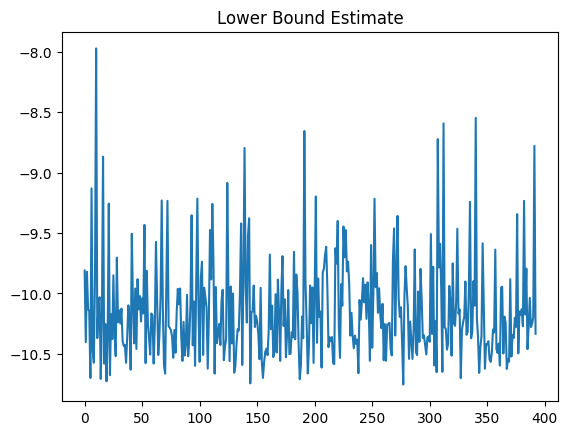

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

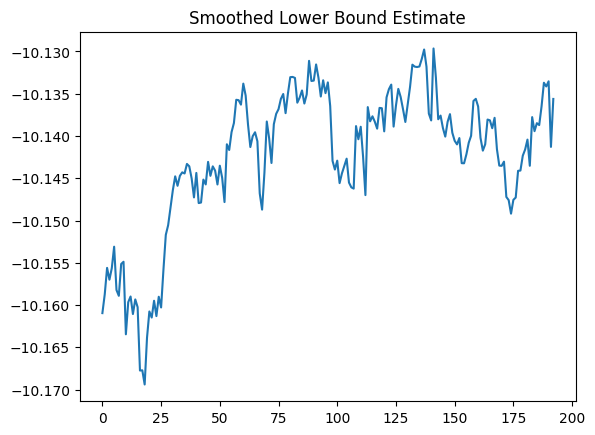

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_lambda_mu = jnp.array([0.4097887 , 0.00791943, 0.6252273 , 0.00434526])

In [ ]:
best_lambda_l = jnp.array([42.57172   , -8.268529  ,  5.4415917 , -1.2734355 ,  7.98421   ,
       -1.2913009 ,  2.3069746 ,  4.5451846 , -0.40880784,  3.1462297])

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[16], mean = best_mu, cov = best_Sigma, shape = (10000,))

best_alpha = (5 * jnp.exp(best_theta_tilde[0]) + 0) / (1 + jnp.exp(best_theta_tilde[0]))
best_beta = (2 * jnp.exp(best_theta_tilde[1]) + 0) / (1 + jnp.exp(best_theta_tilde[1]))
best_gamma = (3 * jnp.exp(best_theta_tilde[2]) + 0) / (1 + jnp.exp(best_theta_tilde[2]))
best_delta = (1 * jnp.exp(best_theta_tilde[3]) + 0) / (1 + jnp.exp(best_theta_tilde[3]))

best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([2.741751  , 1.096337  , 1.6889111 , 0.56730133], dtype=float32)

In [ ]:
l2_norm = np.linalg.norm(posterior_mean_estimate - true_theta)
l2_norm

0.4210453

In [ ]:
## FIND BEST COEFFS USING VB

In [ ]:
num_samples = 200

In [ ]:
def unbiased_log_likelihood(theta, actual_summary_statistics, n_samples, num_datasets):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1

    return u_est_log_likelihood

In [ ]:
class nn_GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)

        alpha_q = (5 * jnp.exp(theta_tilde_q[0]) + 0) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (2 * jnp.exp(theta_tilde_q[1]) + 0) / (1 + jnp.exp(theta_tilde_q[1]))
        gamma_q = (3 * jnp.exp(theta_tilde_q[2]) + 0) / (1 + jnp.exp(theta_tilde_q[2]))
        delta_q = (1 * jnp.exp(theta_tilde_q[3]) + 0) / (1 + jnp.exp(theta_tilde_q[3]))

        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, self.actual_summary_statistics, num_samples, num_datasets)
        h_lambda = prior(theta_tilde_q, sigma_theta, num_coeffs) + llh - fun_log_q(theta_tilde_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((true_theta[0]-0)/(5-true_theta[0])), jnp.log((true_theta[1]-0)/(2-true_theta[1])), jnp.log((true_theta[2]-0)/(3-true_theta[2])), jnp.log((true_theta[3]-0)/(1-true_theta[3]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        l_0 = jnp.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_0, Sigma_0, size = self.samples))
                # theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                # theta_q_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_q, Sigma_q, size = self.samples))
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
nn_vb = nn_GVB(600, transformed_actual_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 200, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda_mu, nn_best_lambda_l = nn_vb.vb_posterior(stop)

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_multivariate.py:758: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
  0%|          | 1/4000 [00:30<33:43:45, 30.36s/it]

LB -12.595527


  0%|          | 2/4000 [00:56<30:55:45, 27.85s/it]

LB -13.192576


  0%|          | 3/4000 [01:22<30:00:31, 27.03s/it]

LB -13.306057


  0%|          | 4/4000 [01:47<29:03:30, 26.18s/it]

LB -13.245144


  0%|          | 5/4000 [02:13<28:56:01, 26.07s/it]

LB -13.081702


  0%|          | 6/4000 [02:38<28:34:18, 25.75s/it]

LB -13.293558


  0%|          | 7/4000 [03:03<28:16:48, 25.50s/it]

LB -13.212235


  0%|          | 8/4000 [03:29<28:39:48, 25.85s/it]

LB -13.293334


  0%|          | 9/4000 [03:55<28:33:54, 25.77s/it]

LB -13.231965


  0%|          | 10/4000 [04:19<28:04:28, 25.33s/it]

LB -13.319591


  0%|          | 11/4000 [04:45<28:01:03, 25.29s/it]

LB -13.278551


  0%|          | 12/4000 [05:10<27:55:55, 25.21s/it]

LB -13.187816


  0%|          | 13/4000 [05:35<27:53:52, 25.19s/it]

LB -13.053012


  0%|          | 14/4000 [06:00<27:52:51, 25.18s/it]

LB -13.161


  0%|          | 15/4000 [06:27<28:22:36, 25.64s/it]

LB -13.187411


  0%|          | 16/4000 [06:52<28:14:38, 25.52s/it]

LB -13.210939


  0%|          | 17/4000 [07:16<27:45:22, 25.09s/it]

LB -13.225947


  0%|          | 18/4000 [07:41<27:40:27, 25.02s/it]

LB -13.224874


  0%|          | 19/4000 [08:06<27:44:47, 25.09s/it]

LB -13.183148


  0%|          | 20/4000 [08:31<27:47:16, 25.13s/it]

LB -13.257886


  1%|          | 21/4000 [08:57<27:58:24, 25.31s/it]

LB -13.228669


  1%|          | 22/4000 [09:22<28:00:34, 25.35s/it]

LB -13.236566


  1%|          | 23/4000 [09:48<27:56:05, 25.29s/it]

LB -13.245823


  1%|          | 24/4000 [10:13<27:48:58, 25.19s/it]

LB -13.170409


  1%|          | 25/4000 [10:37<27:31:48, 24.93s/it]

LB -13.203575


  1%|          | 26/4000 [11:02<27:29:55, 24.91s/it]

LB -13.073568


  1%|          | 27/4000 [11:27<27:34:56, 24.99s/it]

LB -13.186851


  1%|          | 28/4000 [11:53<28:01:14, 25.40s/it]

LB -13.188231


  1%|          | 29/4000 [12:18<27:54:19, 25.30s/it]

LB -13.17455


  1%|          | 30/4000 [12:43<27:50:41, 25.25s/it]

LB -13.136785


  1%|          | 31/4000 [13:09<27:46:28, 25.19s/it]

LB -13.268144


  1%|          | 32/4000 [13:34<27:42:50, 25.14s/it]

LB -13.160684


  1%|          | 33/4000 [13:58<27:20:29, 24.81s/it]

LB -13.162292


  1%|          | 34/4000 [14:22<27:14:06, 24.72s/it]

LB -13.171958


  1%|          | 35/4000 [14:48<27:42:44, 25.16s/it]

LB -13.152203


  1%|          | 36/4000 [15:13<27:36:56, 25.08s/it]

LB -13.187196


  1%|          | 37/4000 [15:38<27:32:14, 25.01s/it]

LB -13.194271


  1%|          | 38/4000 [16:03<27:30:07, 24.99s/it]

LB -13.194738


  1%|          | 39/4000 [16:28<27:26:49, 24.95s/it]

LB -13.216467


  1%|          | 40/4000 [16:53<27:25:43, 24.94s/it]

LB -13.201743


  1%|          | 41/4000 [17:17<27:07:22, 24.66s/it]

LB -13.194311


  1%|          | 42/4000 [17:43<27:32:36, 25.05s/it]

LB -13.233636


  1%|          | 43/4000 [18:08<27:30:09, 25.02s/it]

LB -13.147259


  1%|          | 44/4000 [18:33<27:29:54, 25.02s/it]

LB -13.192619


  1%|          | 45/4000 [18:58<27:30:32, 25.04s/it]

LB -13.0833025


  1%|          | 46/4000 [19:23<27:29:20, 25.03s/it]

LB -13.12042


  1%|          | 47/4000 [19:48<27:25:45, 24.98s/it]

LB -13.08588


  1%|          | 48/4000 [20:12<27:02:54, 24.64s/it]

LB -13.157381


  1%|          | 49/4000 [20:38<27:30:10, 25.06s/it]

LB -13.1250105


  1%|▏         | 50/4000 [21:02<27:23:03, 24.96s/it]

LB -13.157251


  1%|▏         | 51/4000 [21:27<27:21:48, 24.95s/it]

LB -13.148387


  1%|▏         | 52/4000 [21:52<27:21:09, 24.94s/it]

LB -13.087712


  1%|▏         | 53/4000 [22:17<27:23:27, 24.98s/it]

LB -13.104355


  1%|▏         | 54/4000 [22:42<27:18:28, 24.91s/it]

LB -13.153643


  1%|▏         | 55/4000 [23:06<27:06:27, 24.74s/it]

LB -13.132981


  1%|▏         | 56/4000 [23:32<27:31:36, 25.13s/it]

LB -13.1705675


  1%|▏         | 57/4000 [23:57<27:24:43, 25.03s/it]

LB -13.090754


  1%|▏         | 58/4000 [24:22<27:26:00, 25.05s/it]

LB -13.138043


  1%|▏         | 59/4000 [24:47<27:28:42, 25.10s/it]

LB -13.213187


  2%|▏         | 60/4000 [25:12<27:26:26, 25.07s/it]

LB -13.200766


  2%|▏         | 61/4000 [25:37<27:25:12, 25.06s/it]

LB -13.251537


  2%|▏         | 62/4000 [26:02<27:14:16, 24.90s/it]

LB -13.132267


  2%|▏         | 63/4000 [26:28<27:30:51, 25.16s/it]

LB -13.233375


  2%|▏         | 64/4000 [26:52<27:12:39, 24.89s/it]

LB -13.070474


  2%|▏         | 65/4000 [27:17<27:11:36, 24.88s/it]

LB -13.074335


  2%|▏         | 66/4000 [27:42<27:11:00, 24.88s/it]

LB -13.137706


  2%|▏         | 67/4000 [28:06<27:07:17, 24.83s/it]

LB -13.224772


  2%|▏         | 68/4000 [28:31<27:10:27, 24.88s/it]

LB -13.108472


  2%|▏         | 69/4000 [28:56<27:10:52, 24.89s/it]

LB -13.16683


  2%|▏         | 70/4000 [29:23<27:36:41, 25.29s/it]

LB -13.073555


  2%|▏         | 71/4000 [29:47<27:12:05, 24.92s/it]

LB -13.166121


  2%|▏         | 72/4000 [30:11<27:05:05, 24.82s/it]

LB -13.2146


  2%|▏         | 73/4000 [30:36<27:10:56, 24.92s/it]

LB -13.1094885


  2%|▏         | 74/4000 [31:01<27:12:18, 24.95s/it]

LB -13.1197405


  2%|▏         | 75/4000 [31:26<27:10:23, 24.92s/it]

LB -13.132012


  2%|▏         | 76/4000 [31:51<27:06:38, 24.87s/it]

LB -13.214052


  2%|▏         | 77/4000 [32:16<27:03:54, 24.84s/it]

LB -13.158408


  2%|▏         | 78/4000 [32:41<27:11:28, 24.96s/it]

LB -13.129251


  2%|▏         | 79/4000 [33:06<27:12:33, 24.98s/it]

LB -13.183735


  2%|▏         | 80/4000 [33:31<27:05:59, 24.89s/it]

LB -13.106073


  2%|▏         | 81/4000 [33:56<27:07:25, 24.92s/it]

LB -13.086894


  2%|▏         | 82/4000 [34:21<27:07:54, 24.93s/it]

LB -13.070928


  2%|▏         | 83/4000 [34:45<27:04:02, 24.88s/it]

LB -13.122539


  2%|▏         | 84/4000 [35:09<26:43:35, 24.57s/it]

LB -13.185481


  2%|▏         | 85/4000 [35:35<27:08:16, 24.95s/it]

LB -13.102114


  2%|▏         | 86/4000 [36:00<27:03:40, 24.89s/it]

LB -13.221238


  2%|▏         | 87/4000 [36:25<27:00:49, 24.85s/it]

LB -13.114928


  2%|▏         | 88/4000 [36:49<26:58:55, 24.83s/it]

LB -13.142352


  2%|▏         | 89/4000 [37:14<26:54:01, 24.76s/it]

LB -13.058166


  2%|▏         | 90/4000 [37:39<26:50:40, 24.72s/it]

LB -13.124078


  2%|▏         | 91/4000 [38:03<26:43:53, 24.62s/it]

LB -13.127037


  2%|▏         | 92/4000 [38:29<27:06:55, 24.98s/it]

LB -13.167061


  2%|▏         | 93/4000 [38:54<27:06:50, 24.98s/it]

LB -13.230013


  2%|▏         | 94/4000 [39:19<27:03:45, 24.94s/it]

LB -13.116797


  2%|▏         | 95/4000 [39:43<27:00:16, 24.90s/it]

LB -13.095413


  2%|▏         | 96/4000 [40:08<26:59:22, 24.89s/it]

LB -13.174449


  2%|▏         | 97/4000 [40:33<26:58:36, 24.88s/it]

LB -13.132133


  2%|▏         | 98/4000 [40:57<26:40:46, 24.61s/it]

LB -13.1362295


  2%|▏         | 99/4000 [41:23<27:05:23, 25.00s/it]

LB -13.095655


  2%|▎         | 100/4000 [41:48<27:00:06, 24.92s/it]

LB -13.198397


  3%|▎         | 101/4000 [42:13<26:58:11, 24.90s/it]

LB -13.108261


  3%|▎         | 102/4000 [42:38<27:00:21, 24.94s/it]

LB -13.153457


  3%|▎         | 103/4000 [43:03<27:00:25, 24.95s/it]

LB -13.151336


  3%|▎         | 104/4000 [43:28<26:57:49, 24.92s/it]

LB -13.192842


  3%|▎         | 105/4000 [43:52<26:44:48, 24.72s/it]

LB -13.144399


  3%|▎         | 106/4000 [44:18<27:10:59, 25.13s/it]

LB -13.096347


  3%|▎         | 107/4000 [44:43<27:03:24, 25.02s/it]

LB -13.279235


  3%|▎         | 108/4000 [45:08<27:02:18, 25.01s/it]

LB -13.178611


  3%|▎         | 109/4000 [45:33<27:00:46, 24.99s/it]

LB -13.130994


  3%|▎         | 110/4000 [45:57<26:56:08, 24.93s/it]

LB -13.148675


  3%|▎         | 111/4000 [46:22<26:56:44, 24.94s/it]

LB -13.064135


  3%|▎         | 112/4000 [46:47<26:53:13, 24.90s/it]

LB -13.109538


  3%|▎         | 113/4000 [47:11<26:36:34, 24.64s/it]

LB -13.166107


  3%|▎         | 114/4000 [47:37<26:57:54, 24.98s/it]

LB -13.158529


  3%|▎         | 115/4000 [48:02<26:49:54, 24.86s/it]

LB -13.047401


  3%|▎         | 116/4000 [48:26<26:50:42, 24.88s/it]

LB -13.16456


  3%|▎         | 117/4000 [48:52<26:53:51, 24.94s/it]

LB -13.1191225


  3%|▎         | 118/4000 [49:17<26:54:45, 24.96s/it]

LB -13.175205


  3%|▎         | 119/4000 [49:41<26:53:28, 24.94s/it]

LB -13.16045


  3%|▎         | 120/4000 [50:06<26:36:00, 24.68s/it]

LB -13.066901


  3%|▎         | 121/4000 [50:31<26:58:18, 25.03s/it]

LB -13.11754


  3%|▎         | 122/4000 [50:56<26:53:55, 24.97s/it]

LB -13.117125


  3%|▎         | 123/4000 [51:21<26:53:09, 24.97s/it]

LB -13.143371


  3%|▎         | 124/4000 [51:46<26:47:32, 24.88s/it]

LB -13.158739


  3%|▎         | 125/4000 [52:10<26:41:41, 24.80s/it]

LB -13.064818


  3%|▎         | 126/4000 [52:36<26:47:08, 24.89s/it]

LB -13.041055


  3%|▎         | 127/4000 [53:00<26:37:56, 24.76s/it]

LB -13.210325


  3%|▎         | 128/4000 [53:26<26:56:34, 25.05s/it]

LB -13.038885


  3%|▎         | 129/4000 [53:50<26:41:04, 24.82s/it]

LB -13.174529


  3%|▎         | 130/4000 [54:15<26:42:03, 24.84s/it]

LB -13.150562


  3%|▎         | 131/4000 [54:40<26:45:43, 24.90s/it]

LB -13.078806


  3%|▎         | 132/4000 [55:05<26:44:54, 24.90s/it]

LB -13.086277


  3%|▎         | 133/4000 [55:30<26:50:28, 24.99s/it]

LB -13.090605


  3%|▎         | 134/4000 [55:55<26:48:21, 24.96s/it]

LB -13.078071


  3%|▎         | 135/4000 [56:19<26:38:24, 24.81s/it]

LB -13.138067


  3%|▎         | 136/4000 [56:45<27:01:01, 25.17s/it]

LB -13.076143


  3%|▎         | 137/4000 [57:10<26:51:42, 25.03s/it]

LB -13.027664


  3%|▎         | 138/4000 [57:35<26:50:03, 25.01s/it]

LB -13.099485


  3%|▎         | 139/4000 [58:00<26:48:55, 25.00s/it]

LB -13.145594


  4%|▎         | 140/4000 [58:25<26:51:22, 25.05s/it]

LB -13.150212


  4%|▎         | 141/4000 [58:50<26:50:07, 25.03s/it]

LB -12.9866085


  4%|▎         | 142/4000 [59:15<26:46:29, 24.98s/it]

LB -13.155967


  4%|▎         | 143/4000 [59:41<26:57:22, 25.16s/it]

LB -13.223171


  4%|▎         | 144/4000 [1:00:05<26:47:20, 25.01s/it]

LB -13.095396


  4%|▎         | 145/4000 [1:00:30<26:49:05, 25.04s/it]

LB -13.192018


  4%|▎         | 146/4000 [1:00:55<26:42:32, 24.95s/it]

LB -13.142633


  4%|▎         | 147/4000 [1:01:20<26:44:08, 24.98s/it]

LB -13.076222


  4%|▎         | 148/4000 [1:01:45<26:45:05, 25.00s/it]

LB -12.919511


  4%|▎         | 149/4000 [1:02:10<26:43:49, 24.99s/it]

LB -13.039194


  4%|▍         | 150/4000 [1:02:35<26:46:39, 25.04s/it]

LB -13.048279


  4%|▍         | 151/4000 [1:03:01<26:51:35, 25.12s/it]

LB -13.05539


  4%|▍         | 152/4000 [1:03:26<26:50:05, 25.11s/it]

LB -13.138877


  4%|▍         | 153/4000 [1:03:51<26:45:40, 25.04s/it]

LB -12.987865


  4%|▍         | 154/4000 [1:04:16<26:44:17, 25.03s/it]

LB -13.092675


  4%|▍         | 155/4000 [1:04:41<26:41:17, 24.99s/it]

LB -13.0378


  4%|▍         | 156/4000 [1:05:06<26:40:29, 24.98s/it]

LB -13.173407


  4%|▍         | 157/4000 [1:05:30<26:26:26, 24.77s/it]

LB -13.091425


  4%|▍         | 158/4000 [1:05:54<26:20:12, 24.68s/it]

LB -13.199398


  4%|▍         | 159/4000 [1:06:19<26:25:35, 24.77s/it]

LB -13.13254


  4%|▍         | 160/4000 [1:06:45<26:53:18, 25.21s/it]

LB -13.106932


  4%|▍         | 161/4000 [1:07:10<26:48:24, 25.14s/it]

LB -13.052747


  4%|▍         | 162/4000 [1:07:35<26:44:36, 25.09s/it]

LB -13.054525


  4%|▍         | 163/4000 [1:08:00<26:40:07, 25.02s/it]

LB -13.024812


  4%|▍         | 164/4000 [1:08:25<26:27:09, 24.83s/it]

LB -13.053489


  4%|▍         | 165/4000 [1:08:49<26:10:07, 24.57s/it]

LB -13.114403


  4%|▍         | 166/4000 [1:09:13<26:16:01, 24.66s/it]

LB -13.1179


  4%|▍         | 167/4000 [1:09:38<26:20:03, 24.73s/it]

LB -13.082299


  4%|▍         | 168/4000 [1:10:05<26:52:36, 25.25s/it]

LB -13.075905


  4%|▍         | 169/4000 [1:10:30<26:50:47, 25.23s/it]

LB -13.081438


  4%|▍         | 170/4000 [1:10:55<26:45:25, 25.15s/it]

LB -13.104402


  4%|▍         | 171/4000 [1:11:19<26:22:33, 24.80s/it]

LB -12.996933


  4%|▍         | 172/4000 [1:11:44<26:17:24, 24.72s/it]

LB -13.033412


  4%|▍         | 173/4000 [1:12:08<26:20:56, 24.79s/it]

LB -13.060532


  4%|▍         | 174/4000 [1:12:33<26:19:12, 24.77s/it]

LB -12.963756


  4%|▍         | 175/4000 [1:12:59<26:46:59, 25.21s/it]

LB -12.972591


  4%|▍         | 176/4000 [1:13:24<26:38:46, 25.09s/it]

LB -13.17349


  4%|▍         | 177/4000 [1:13:49<26:37:13, 25.07s/it]

LB -13.143742


  4%|▍         | 178/4000 [1:14:14<26:31:51, 24.99s/it]

LB -12.9731865


  4%|▍         | 179/4000 [1:14:38<26:18:04, 24.78s/it]

LB -13.014185


  4%|▍         | 180/4000 [1:15:03<26:17:47, 24.78s/it]

LB -13.047937


  5%|▍         | 181/4000 [1:15:28<26:19:31, 24.82s/it]

LB -13.088195


  5%|▍         | 182/4000 [1:15:53<26:23:22, 24.88s/it]

LB -13.066203


  5%|▍         | 183/4000 [1:16:19<26:47:25, 25.27s/it]

LB -12.989701


  5%|▍         | 184/4000 [1:16:44<26:41:48, 25.19s/it]

LB -12.857384


  5%|▍         | 185/4000 [1:17:09<26:34:22, 25.08s/it]

LB -12.963655


  5%|▍         | 186/4000 [1:17:34<26:29:51, 25.01s/it]

LB -13.102593


  5%|▍         | 187/4000 [1:17:58<26:10:44, 24.72s/it]

LB -13.021502


  5%|▍         | 188/4000 [1:18:23<26:11:54, 24.74s/it]

LB -13.080771


  5%|▍         | 189/4000 [1:18:48<26:14:39, 24.79s/it]

LB -13.069373


  5%|▍         | 190/4000 [1:19:14<26:39:59, 25.20s/it]

LB -13.032551


  5%|▍         | 191/4000 [1:19:39<26:34:20, 25.11s/it]

LB -12.974001


  5%|▍         | 192/4000 [1:20:04<26:34:33, 25.12s/it]

LB -13.034754


  5%|▍         | 193/4000 [1:20:29<26:33:35, 25.12s/it]

LB -12.957942


  5%|▍         | 194/4000 [1:20:53<26:18:21, 24.88s/it]

LB -13.025973


  5%|▍         | 195/4000 [1:21:18<26:10:10, 24.76s/it]

LB -12.986433


  5%|▍         | 196/4000 [1:21:43<26:13:59, 24.83s/it]

LB -13.0213995


  5%|▍         | 197/4000 [1:22:07<26:11:02, 24.79s/it]

LB -13.000589


  5%|▍         | 198/4000 [1:22:34<26:35:28, 25.18s/it]

LB -12.967013


  5%|▍         | 199/4000 [1:22:58<26:30:37, 25.11s/it]

LB -13.059005


  5%|▌         | 200/4000 [1:23:23<26:26:18, 25.05s/it]

LB -13.068088


  5%|▌         | 201/4000 [1:23:48<26:22:51, 25.00s/it]

LB Smoothed -13.125406


  5%|▌         | 202/4000 [1:24:13<26:21:23, 24.98s/it]

LB Smoothed -13.124901


  5%|▌         | 203/4000 [1:24:38<26:09:27, 24.80s/it]

LB Smoothed -13.123205


  5%|▌         | 204/4000 [1:25:03<26:13:15, 24.87s/it]

LB Smoothed -13.121837


  5%|▌         | 205/4000 [1:25:28<26:15:46, 24.91s/it]

LB Smoothed -13.1214075


  5%|▌         | 206/4000 [1:25:54<26:43:39, 25.36s/it]

LB Smoothed -13.119901


  5%|▌         | 207/4000 [1:26:19<26:36:49, 25.26s/it]

LB Smoothed -13.118551


  5%|▌         | 208/4000 [1:26:44<26:30:44, 25.17s/it]

LB Smoothed -13.117092


  5%|▌         | 209/4000 [1:27:09<26:23:57, 25.07s/it]

LB Smoothed -13.115368


  5%|▌         | 210/4000 [1:27:33<26:07:55, 24.82s/it]

LB Smoothed -13.113709


  5%|▌         | 211/4000 [1:27:57<25:59:50, 24.70s/it]

LB Smoothed -13.111955


  5%|▌         | 212/4000 [1:28:22<26:03:14, 24.76s/it]

LB Smoothed -13.111004


  5%|▌         | 213/4000 [1:28:49<26:30:02, 25.19s/it]

LB Smoothed -13.110696


  5%|▌         | 214/4000 [1:29:13<26:22:49, 25.08s/it]

LB Smoothed -13.11033


  5%|▌         | 215/4000 [1:29:38<26:17:13, 25.00s/it]

LB Smoothed -13.109176


  5%|▌         | 216/4000 [1:30:03<26:13:59, 24.96s/it]

LB Smoothed -13.108271


  5%|▌         | 217/4000 [1:30:28<26:17:42, 25.02s/it]

LB Smoothed -13.106364


  5%|▌         | 218/4000 [1:30:52<25:59:33, 24.74s/it]

LB Smoothed -13.105623


  5%|▌         | 219/4000 [1:31:17<25:54:47, 24.67s/it]

LB Smoothed -13.104605


  6%|▌         | 220/4000 [1:31:42<25:59:26, 24.75s/it]

LB Smoothed -13.103202


  6%|▌         | 221/4000 [1:32:08<26:23:46, 25.15s/it]

LB Smoothed -13.101737


  6%|▌         | 222/4000 [1:32:33<26:18:47, 25.07s/it]

LB Smoothed -13.1002


  6%|▌         | 223/4000 [1:32:57<26:10:44, 24.95s/it]

LB Smoothed -13.098493


  6%|▌         | 224/4000 [1:33:22<26:07:06, 24.90s/it]

LB Smoothed -13.097411


  6%|▌         | 225/4000 [1:33:46<25:52:55, 24.68s/it]

LB Smoothed -13.095735


  6%|▌         | 226/4000 [1:34:10<25:38:22, 24.46s/it]

LB Smoothed -13.094958


  6%|▌         | 227/4000 [1:34:35<25:45:42, 24.58s/it]

LB Smoothed -13.09388


  6%|▌         | 228/4000 [1:35:00<25:53:49, 24.72s/it]

LB Smoothed -13.092452


  6%|▌         | 229/4000 [1:35:26<26:11:57, 25.01s/it]

LB Smoothed -13.091677


  6%|▌         | 230/4000 [1:35:51<26:09:15, 24.97s/it]

LB Smoothed -13.090749


  6%|▌         | 231/4000 [1:36:16<26:12:05, 25.03s/it]

LB Smoothed -13.089274


  6%|▌         | 232/4000 [1:36:41<26:03:48, 24.90s/it]

LB Smoothed -13.08832


  6%|▌         | 233/4000 [1:37:05<25:48:33, 24.67s/it]

LB Smoothed -13.08737


  6%|▌         | 234/4000 [1:37:29<25:50:26, 24.70s/it]

LB Smoothed -13.086713


  6%|▌         | 235/4000 [1:37:54<25:53:40, 24.76s/it]

LB Smoothed -13.086149


  6%|▌         | 236/4000 [1:38:20<26:00:22, 24.87s/it]

LB Smoothed -13.084365


  6%|▌         | 237/4000 [1:38:46<26:27:02, 25.30s/it]

LB Smoothed -13.083191


  6%|▌         | 238/4000 [1:39:11<26:20:29, 25.21s/it]

LB Smoothed -13.081535


  6%|▌         | 239/4000 [1:39:36<26:13:52, 25.11s/it]

LB Smoothed -13.080208


  6%|▌         | 240/4000 [1:40:01<26:15:03, 25.13s/it]

LB Smoothed -13.078952


  6%|▌         | 241/4000 [1:40:27<26:41:09, 25.56s/it]

LB Smoothed -13.077723


  6%|▌         | 242/4000 [1:40:54<27:06:20, 25.97s/it]

LB Smoothed -13.076525


  6%|▌         | 243/4000 [1:41:20<27:03:02, 25.92s/it]

LB Smoothed -13.075076


  6%|▌         | 244/4000 [1:41:48<27:33:41, 26.42s/it]

LB Smoothed -13.073735


  6%|▌         | 245/4000 [1:42:13<27:14:39, 26.12s/it]

LB Smoothed -13.073075


  6%|▌         | 246/4000 [1:42:40<27:21:13, 26.23s/it]

LB Smoothed -13.071564


  6%|▌         | 247/4000 [1:43:06<27:27:08, 26.33s/it]

LB Smoothed -13.069929


  6%|▌         | 248/4000 [1:43:33<27:30:04, 26.39s/it]

LB Smoothed -13.068403


  6%|▌         | 249/4000 [1:43:58<27:11:26, 26.10s/it]

LB Smoothed -13.06714


  6%|▋         | 250/4000 [1:44:24<27:03:05, 25.97s/it]

LB Smoothed -13.065678


  6%|▋         | 251/4000 [1:44:52<27:37:18, 26.52s/it]

LB Smoothed -13.064711


  6%|▋         | 252/4000 [1:45:17<27:18:44, 26.23s/it]

LB Smoothed -13.063734


  6%|▋         | 253/4000 [1:45:43<27:17:55, 26.23s/it]

LB Smoothed -13.063066


  6%|▋         | 254/4000 [1:46:09<27:13:37, 26.17s/it]

LB Smoothed -13.0622425


  6%|▋         | 255/4000 [1:46:36<27:11:34, 26.14s/it]

LB Smoothed -13.061242


  6%|▋         | 256/4000 [1:47:02<27:15:41, 26.21s/it]

LB Smoothed -13.06012


  6%|▋         | 257/4000 [1:47:28<27:09:04, 26.11s/it]

LB Smoothed -13.05888


  6%|▋         | 258/4000 [1:47:54<27:07:33, 26.10s/it]

LB Smoothed -13.057652


  6%|▋         | 259/4000 [1:48:21<27:32:24, 26.50s/it]

LB Smoothed -13.055743


  6%|▋         | 260/4000 [1:48:48<27:29:30, 26.46s/it]

LB Smoothed -13.054304


  7%|▋         | 261/4000 [1:49:13<27:05:16, 26.08s/it]

LB Smoothed -13.052468


  7%|▋         | 262/4000 [1:49:39<27:08:43, 26.14s/it]

LB Smoothed -13.050851


  7%|▋         | 263/4000 [1:50:06<27:15:37, 26.26s/it]

LB Smoothed -13.048965


  7%|▋         | 264/4000 [1:50:32<27:21:53, 26.37s/it]

LB Smoothed -13.048379


  7%|▋         | 265/4000 [1:50:58<27:12:04, 26.22s/it]

LB Smoothed -13.047141


  7%|▋         | 266/4000 [1:51:25<27:15:47, 26.28s/it]

LB Smoothed -13.045774


  7%|▋         | 267/4000 [1:51:50<26:51:49, 25.91s/it]

LB Smoothed -13.044321


  7%|▋         | 268/4000 [1:52:14<26:31:11, 25.58s/it]

LB Smoothed -13.043582


  7%|▋         | 269/4000 [1:52:39<26:03:57, 25.15s/it]

LB Smoothed -13.042407


  7%|▋         | 270/4000 [1:53:03<25:56:31, 25.04s/it]

LB Smoothed -13.041038


  7%|▋         | 271/4000 [1:53:29<25:59:43, 25.10s/it]

LB Smoothed -13.039209


  7%|▋         | 272/4000 [1:53:54<25:58:07, 25.08s/it]

LB Smoothed -13.037197


  7%|▋         | 273/4000 [1:54:19<25:59:38, 25.11s/it]

LB Smoothed -13.0358515


  7%|▋         | 274/4000 [1:54:45<26:23:46, 25.50s/it]

LB Smoothed -13.034869


  7%|▋         | 275/4000 [1:55:10<26:13:44, 25.35s/it]

LB Smoothed -13.033486


  7%|▋         | 276/4000 [1:55:35<26:00:54, 25.15s/it]

LB Smoothed -13.0314


  7%|▋         | 277/4000 [1:55:59<25:44:10, 24.89s/it]

LB Smoothed -13.029724


  7%|▋         | 278/4000 [1:56:24<25:39:03, 24.81s/it]

LB Smoothed -13.028595


  7%|▋         | 279/4000 [1:56:49<25:44:06, 24.90s/it]

LB Smoothed -13.027422


  7%|▋         | 280/4000 [1:57:14<25:45:14, 24.92s/it]

LB Smoothed -13.025819


  7%|▋         | 281/4000 [1:57:39<25:41:28, 24.87s/it]

LB Smoothed -13.02462


  7%|▋         | 282/4000 [1:58:05<26:09:04, 25.32s/it]

LB Smoothed -13.023893


  7%|▋         | 283/4000 [1:58:30<26:02:49, 25.23s/it]

LB Smoothed -13.022831


  7%|▋         | 284/4000 [1:58:55<25:57:23, 25.15s/it]

LB Smoothed -13.021499


  7%|▋         | 285/4000 [1:59:19<25:39:26, 24.86s/it]

LB Smoothed -13.019865


  7%|▋         | 286/4000 [1:59:44<25:39:52, 24.88s/it]

LB Smoothed -13.018091


  7%|▋         | 287/4000 [2:00:09<25:39:56, 24.88s/it]

LB Smoothed -13.016967


  7%|▋         | 288/4000 [2:00:34<25:40:52, 24.91s/it]

LB Smoothed -13.015711


  7%|▋         | 289/4000 [2:00:59<25:41:49, 24.93s/it]

LB Smoothed -13.014074


  7%|▋         | 290/4000 [2:01:25<26:02:09, 25.26s/it]

LB Smoothed -13.012553


  7%|▋         | 291/4000 [2:01:50<26:03:23, 25.29s/it]

LB Smoothed -13.010975


  7%|▋         | 292/4000 [2:02:15<26:00:19, 25.25s/it]

LB Smoothed -13.008698


  7%|▋         | 293/4000 [2:02:40<25:49:05, 25.07s/it]

LB Smoothed -13.007034


  7%|▋         | 294/4000 [2:03:04<25:34:57, 24.85s/it]

LB Smoothed -13.005846


  7%|▋         | 295/4000 [2:03:29<25:36:10, 24.88s/it]

LB Smoothed -13.004498


  7%|▋         | 296/4000 [2:03:55<25:44:25, 25.02s/it]

LB Smoothed -13.003204


  7%|▋         | 297/4000 [2:04:20<25:44:27, 25.02s/it]

LB Smoothed -13.001997


  7%|▋         | 298/4000 [2:04:46<26:08:17, 25.42s/it]

LB Smoothed -13.000305


  7%|▋         | 299/4000 [2:05:11<26:05:45, 25.38s/it]

LB Smoothed -12.999083


  8%|▊         | 300/4000 [2:05:37<26:01:35, 25.32s/it]

LB Smoothed -12.997075


  8%|▊         | 301/4000 [2:06:02<25:53:01, 25.19s/it]

LB Smoothed -12.995585


  8%|▊         | 302/4000 [2:06:26<25:39:07, 24.97s/it]

LB Smoothed -12.994219


  8%|▊         | 303/4000 [2:06:51<25:40:24, 25.00s/it]

LB Smoothed -12.992102


  8%|▊         | 304/4000 [2:07:16<25:42:51, 25.05s/it]

LB Smoothed -12.990487


  8%|▊         | 305/4000 [2:07:41<25:41:30, 25.03s/it]

LB Smoothed -12.988295


  8%|▊         | 306/4000 [2:08:07<26:03:05, 25.39s/it]

LB Smoothed -12.987392


  8%|▊         | 307/4000 [2:08:32<25:57:05, 25.30s/it]

LB Smoothed -12.984745


  8%|▊         | 308/4000 [2:08:57<25:49:45, 25.19s/it]

LB Smoothed -12.982777


  8%|▊         | 309/4000 [2:09:23<25:49:27, 25.19s/it]

LB Smoothed -12.981562


  8%|▊         | 310/4000 [2:09:47<25:30:24, 24.88s/it]

LB Smoothed -12.97998


  8%|▊         | 311/4000 [2:10:12<25:31:01, 24.90s/it]

LB Smoothed -12.978502


  8%|▊         | 312/4000 [2:10:37<25:36:53, 25.00s/it]

LB Smoothed -12.977009


  8%|▊         | 313/4000 [2:11:02<25:34:41, 24.97s/it]

LB Smoothed -12.975328


  8%|▊         | 314/4000 [2:11:28<25:53:55, 25.29s/it]

LB Smoothed -12.9734535


  8%|▊         | 315/4000 [2:11:53<25:45:57, 25.17s/it]

LB Smoothed -12.972116


  8%|▊         | 316/4000 [2:12:18<25:47:34, 25.20s/it]

LB Smoothed -12.969987


  8%|▊         | 317/4000 [2:12:43<25:44:14, 25.16s/it]

LB Smoothed -12.968014


  8%|▊         | 318/4000 [2:13:07<25:26:39, 24.88s/it]

LB Smoothed -12.965946


  8%|▊         | 319/4000 [2:13:32<25:23:01, 24.83s/it]

LB Smoothed -12.964483


  8%|▊         | 320/4000 [2:13:57<25:27:02, 24.90s/it]

LB Smoothed -12.962544


  8%|▊         | 321/4000 [2:14:22<25:34:04, 25.02s/it]

LB Smoothed -12.960981


  8%|▊         | 322/4000 [2:14:49<26:03:56, 25.51s/it]

LB Smoothed -12.959031


  8%|▊         | 323/4000 [2:15:14<25:53:27, 25.35s/it]

LB Smoothed -12.956989


  8%|▊         | 324/4000 [2:15:39<25:46:33, 25.24s/it]

LB Smoothed -12.954779


  8%|▊         | 325/4000 [2:16:03<25:29:23, 24.97s/it]

LB Smoothed -12.953309


  8%|▊         | 326/4000 [2:16:28<25:16:59, 24.77s/it]

LB Smoothed -12.951741


  8%|▊         | 327/4000 [2:16:53<25:18:59, 24.81s/it]

LB Smoothed -12.949854


  8%|▊         | 328/4000 [2:17:18<25:32:59, 25.05s/it]

LB Smoothed -12.948457


  8%|▊         | 329/4000 [2:17:44<25:37:17, 25.13s/it]

LB Smoothed -12.946569


  8%|▊         | 330/4000 [2:18:10<25:56:32, 25.45s/it]

LB Smoothed -12.94449


  8%|▊         | 331/4000 [2:18:35<25:52:33, 25.39s/it]

LB Smoothed -12.942618


  8%|▊         | 332/4000 [2:19:00<25:45:17, 25.28s/it]

LB Smoothed -12.940843


  8%|▊         | 333/4000 [2:19:25<25:36:12, 25.14s/it]

LB Smoothed -12.938953


  8%|▊         | 334/4000 [2:19:49<25:20:54, 24.89s/it]

LB Smoothed -12.936901


  8%|▊         | 335/4000 [2:20:14<25:16:03, 24.82s/it]

LB Smoothed -12.934684


  8%|▊         | 336/4000 [2:20:39<25:18:20, 24.86s/it]

LB Smoothed -12.932467


  8%|▊         | 337/4000 [2:21:04<25:17:35, 24.86s/it]

LB Smoothed -12.93094


  8%|▊         | 338/4000 [2:21:31<26:02:19, 25.60s/it]

LB Smoothed -12.929409


  8%|▊         | 339/4000 [2:21:57<26:03:04, 25.62s/it]

LB Smoothed -12.926853


  8%|▊         | 340/4000 [2:22:22<25:51:41, 25.44s/it]

LB Smoothed -12.923872


  9%|▊         | 341/4000 [2:22:47<25:43:35, 25.31s/it]

LB Smoothed -12.922584


  9%|▊         | 342/4000 [2:23:11<25:31:45, 25.12s/it]

LB Smoothed -12.919919


  9%|▊         | 343/4000 [2:23:35<25:12:30, 24.82s/it]

LB Smoothed -12.917338


  9%|▊         | 344/4000 [2:24:00<25:13:33, 24.84s/it]

LB Smoothed -12.915265


  9%|▊         | 345/4000 [2:24:25<25:19:38, 24.95s/it]

LB Smoothed -12.913078


  9%|▊         | 346/4000 [2:24:52<25:43:59, 25.35s/it]

LB Smoothed -12.910661


  9%|▊         | 347/4000 [2:25:17<25:40:51, 25.31s/it]

LB Smoothed -12.908779


  9%|▊         | 348/4000 [2:25:42<25:35:13, 25.22s/it]

LB Smoothed -12.907393


  9%|▊         | 349/4000 [2:26:07<25:35:06, 25.23s/it]

LB Smoothed -12.905907


  9%|▉         | 350/4000 [2:26:32<25:22:17, 25.02s/it]

LB Smoothed -12.904457


  9%|▉         | 351/4000 [2:26:56<25:09:26, 24.82s/it]

LB Smoothed -12.90237


  9%|▉         | 352/4000 [2:27:21<25:10:01, 24.84s/it]

LB Smoothed -12.900288


  9%|▉         | 353/4000 [2:27:46<25:09:33, 24.84s/it]

LB Smoothed -12.898536


  9%|▉         | 354/4000 [2:28:12<25:37:23, 25.30s/it]

LB Smoothed -12.89601


  9%|▉         | 355/4000 [2:28:38<25:43:45, 25.41s/it]

LB Smoothed -12.894803


  9%|▉         | 356/4000 [2:29:03<25:38:52, 25.34s/it]

LB Smoothed -12.892279


  9%|▉         | 357/4000 [2:29:28<25:37:32, 25.32s/it]

LB Smoothed -12.889787


  9%|▉         | 358/4000 [2:29:53<25:29:30, 25.20s/it]

LB Smoothed -12.887361


  9%|▉         | 359/4000 [2:30:17<25:09:16, 24.87s/it]

LB Smoothed -12.885236


  9%|▉         | 360/4000 [2:30:42<25:11:32, 24.92s/it]

LB Smoothed -12.882984


  9%|▉         | 361/4000 [2:31:07<25:12:03, 24.93s/it]

LB Smoothed -12.881079


  9%|▉         | 362/4000 [2:31:34<25:40:47, 25.41s/it]

LB Smoothed -12.879377


  9%|▉         | 363/4000 [2:31:59<25:30:10, 25.24s/it]

LB Smoothed -12.877738


  9%|▉         | 364/4000 [2:32:24<25:29:41, 25.24s/it]

LB Smoothed -12.8757925


  9%|▉         | 365/4000 [2:32:48<25:14:47, 25.00s/it]

LB Smoothed -12.873162


  9%|▉         | 366/4000 [2:33:13<25:00:02, 24.77s/it]

LB Smoothed -12.870625


  9%|▉         | 367/4000 [2:33:38<25:01:33, 24.80s/it]

LB Smoothed -12.8683815


  9%|▉         | 368/4000 [2:34:03<25:06:19, 24.88s/it]

LB Smoothed -12.866144


  9%|▉         | 369/4000 [2:34:28<25:08:23, 24.93s/it]

LB Smoothed -12.864615


  9%|▉         | 370/4000 [2:34:54<25:31:39, 25.32s/it]

LB Smoothed -12.861767


  9%|▉         | 371/4000 [2:35:19<25:25:18, 25.22s/it]

LB Smoothed -12.859768


  9%|▉         | 372/4000 [2:35:44<25:19:14, 25.13s/it]

LB Smoothed -12.858021


  9%|▉         | 373/4000 [2:36:08<25:08:53, 24.96s/it]

LB Smoothed -12.855768


  9%|▉         | 374/4000 [2:36:33<25:00:42, 24.83s/it]

LB Smoothed -12.853383


  9%|▉         | 375/4000 [2:36:58<25:04:17, 24.90s/it]

LB Smoothed -12.8511305


  9%|▉         | 376/4000 [2:37:23<25:05:27, 24.92s/it]

LB Smoothed -12.848529


  9%|▉         | 377/4000 [2:37:48<25:08:44, 24.99s/it]

LB Smoothed -12.845897


  9%|▉         | 378/4000 [2:38:13<25:10:37, 25.02s/it]

LB Smoothed -12.844449


  9%|▉         | 379/4000 [2:38:39<25:26:32, 25.29s/it]

LB Smoothed -12.842612


 10%|▉         | 380/4000 [2:39:04<25:26:09, 25.30s/it]

LB Smoothed -12.840234


 10%|▉         | 381/4000 [2:39:29<25:21:03, 25.22s/it]

LB Smoothed -12.837544


 10%|▉         | 382/4000 [2:39:54<25:07:32, 25.00s/it]

LB Smoothed -12.835089


 10%|▉         | 383/4000 [2:40:18<24:59:16, 24.87s/it]

LB Smoothed -12.833184


 10%|▉         | 384/4000 [2:40:44<25:05:53, 24.99s/it]

LB Smoothed -12.831932


 10%|▉         | 385/4000 [2:41:09<25:08:54, 25.04s/it]

LB Smoothed -12.830348


 10%|▉         | 386/4000 [2:41:34<25:09:23, 25.06s/it]

LB Smoothed -12.827796


 10%|▉         | 387/4000 [2:42:01<25:37:47, 25.54s/it]

LB Smoothed -12.825654


 10%|▉         | 388/4000 [2:42:26<25:28:37, 25.39s/it]

LB Smoothed -12.822938


 10%|▉         | 389/4000 [2:42:51<25:31:12, 25.44s/it]

LB Smoothed -12.820574


 10%|▉         | 390/4000 [2:43:16<25:14:01, 25.16s/it]

LB Smoothed -12.818657


 10%|▉         | 391/4000 [2:43:41<25:06:04, 25.04s/it]

LB Smoothed -12.816826


 10%|▉         | 392/4000 [2:44:06<25:07:58, 25.08s/it]

LB Smoothed -12.814917


 10%|▉         | 393/4000 [2:44:31<25:09:09, 25.10s/it]

LB Smoothed -12.812924


 10%|▉         | 394/4000 [2:44:56<25:10:10, 25.13s/it]

LB Smoothed -12.811116


 10%|▉         | 395/4000 [2:45:22<25:32:43, 25.51s/it]

LB Smoothed -12.809048


 10%|▉         | 396/4000 [2:45:48<25:26:29, 25.41s/it]

LB Smoothed -12.807083


 10%|▉         | 397/4000 [2:46:12<25:01:23, 25.00s/it]

LB Smoothed -12.805226


 10%|▉         | 398/4000 [2:46:37<25:00:10, 24.99s/it]

LB Smoothed -12.803156


 10%|▉         | 399/4000 [2:47:02<25:03:05, 25.04s/it]

LB Smoothed -12.800803


 10%|█         | 400/4000 [2:47:27<25:00:39, 25.01s/it]

LB Smoothed -12.798296


 10%|█         | 401/4000 [2:47:52<25:02:24, 25.05s/it]

LB Smoothed -12.795471


 10%|█         | 402/4000 [2:48:17<24:57:32, 24.97s/it]

LB Smoothed -12.793641


 10%|█         | 403/4000 [2:48:43<25:21:32, 25.38s/it]

LB Smoothed -12.791443


 10%|█         | 404/4000 [2:49:08<25:12:32, 25.24s/it]

LB Smoothed -12.788742


 10%|█         | 405/4000 [2:49:33<25:02:39, 25.08s/it]

LB Smoothed -12.786245


 10%|█         | 406/4000 [2:49:57<24:47:11, 24.83s/it]

LB Smoothed -12.784329


 10%|█         | 407/4000 [2:50:22<24:46:44, 24.83s/it]

LB Smoothed -12.782337


 10%|█         | 408/4000 [2:50:47<24:50:14, 24.89s/it]

LB Smoothed -12.780849


 10%|█         | 409/4000 [2:51:12<24:51:45, 24.92s/it]

LB Smoothed -12.778205


 10%|█         | 410/4000 [2:51:37<24:55:11, 24.99s/it]

LB Smoothed -12.776356


 10%|█         | 411/4000 [2:52:03<25:19:25, 25.40s/it]

LB Smoothed -12.774077


 10%|█         | 412/4000 [2:52:28<25:13:43, 25.31s/it]

LB Smoothed -12.771844


 10%|█         | 413/4000 [2:52:53<24:59:06, 25.08s/it]

LB Smoothed -12.768976


 10%|█         | 414/4000 [2:53:17<24:41:33, 24.79s/it]

LB Smoothed -12.766937


 10%|█         | 415/4000 [2:53:42<24:41:32, 24.80s/it]

LB Smoothed -12.764657


 10%|█         | 416/4000 [2:54:07<24:47:49, 24.91s/it]

LB Smoothed -12.762993


 10%|█         | 417/4000 [2:54:32<24:48:40, 24.93s/it]

LB Smoothed -12.760129


 10%|█         | 418/4000 [2:54:57<24:51:58, 24.99s/it]

LB Smoothed -12.757602


 10%|█         | 419/4000 [2:55:23<25:16:17, 25.41s/it]

LB Smoothed -12.75543


 10%|█         | 420/4000 [2:55:49<25:11:35, 25.33s/it]

LB Smoothed -12.753188


 11%|█         | 421/4000 [2:56:14<25:09:57, 25.31s/it]

LB Smoothed -12.750969


 11%|█         | 422/4000 [2:56:39<25:05:24, 25.24s/it]

LB Smoothed -12.74902


 11%|█         | 423/4000 [2:57:03<24:47:01, 24.94s/it]

LB Smoothed -12.746745


 11%|█         | 424/4000 [2:57:28<24:47:57, 24.97s/it]

LB Smoothed -12.744535


 11%|█         | 425/4000 [2:57:53<24:51:57, 25.04s/it]

LB Smoothed -12.742466


 11%|█         | 426/4000 [2:58:18<24:50:55, 25.03s/it]

LB Smoothed -12.740504


 11%|█         | 427/4000 [2:58:43<24:49:52, 25.02s/it]

LB Smoothed -12.738854


 11%|█         | 428/4000 [2:59:10<25:13:12, 25.42s/it]

LB Smoothed -12.736212


 11%|█         | 429/4000 [2:59:35<25:04:54, 25.29s/it]

LB Smoothed -12.733973


 11%|█         | 430/4000 [3:00:00<24:58:25, 25.18s/it]

LB Smoothed -12.731668


 11%|█         | 431/4000 [3:00:24<24:40:35, 24.89s/it]

LB Smoothed -12.729448


 11%|█         | 432/4000 [3:00:49<24:38:15, 24.86s/it]

LB Smoothed -12.727174


 11%|█         | 433/4000 [3:01:14<24:48:50, 25.04s/it]

LB Smoothed -12.724298


 11%|█         | 434/4000 [3:01:39<24:47:55, 25.04s/it]

LB Smoothed -12.721311


 11%|█         | 435/4000 [3:02:04<24:49:58, 25.08s/it]

LB Smoothed -12.719149


 11%|█         | 436/4000 [3:02:30<25:05:42, 25.35s/it]

LB Smoothed -12.716787


 11%|█         | 437/4000 [3:02:56<25:02:13, 25.30s/it]

LB Smoothed -12.714783


 11%|█         | 438/4000 [3:03:21<24:59:46, 25.26s/it]

LB Smoothed -12.712959


 11%|█         | 439/4000 [3:03:46<24:54:13, 25.18s/it]

LB Smoothed -12.710888


 11%|█         | 440/4000 [3:04:10<24:35:51, 24.87s/it]

LB Smoothed -12.709105


 11%|█         | 441/4000 [3:04:35<24:34:03, 24.85s/it]

LB Smoothed -12.70594


 11%|█         | 442/4000 [3:05:00<24:36:04, 24.89s/it]

LB Smoothed -12.704296


 11%|█         | 443/4000 [3:05:25<24:38:16, 24.94s/it]

LB Smoothed -12.701941


 11%|█         | 444/4000 [3:05:51<25:02:15, 25.35s/it]

LB Smoothed -12.699683


 11%|█         | 445/4000 [3:06:16<24:56:26, 25.26s/it]

LB Smoothed -12.697734


 11%|█         | 446/4000 [3:06:41<24:58:27, 25.30s/it]

LB Smoothed -12.696654


 11%|█         | 447/4000 [3:07:06<24:52:26, 25.20s/it]

LB Smoothed -12.694281


 11%|█         | 448/4000 [3:07:31<24:42:36, 25.04s/it]

LB Smoothed -12.692379


 11%|█         | 449/4000 [3:07:56<24:34:20, 24.91s/it]

LB Smoothed -12.690002


 11%|█▏        | 450/4000 [3:08:21<24:42:44, 25.06s/it]

LB Smoothed -12.687531


 11%|█▏        | 451/4000 [3:08:46<24:45:23, 25.11s/it]

LB Smoothed -12.685154


 11%|█▏        | 452/4000 [3:09:13<25:05:20, 25.46s/it]

LB Smoothed -12.682435


 11%|█▏        | 453/4000 [3:09:38<24:56:29, 25.31s/it]

LB Smoothed -12.679787


 11%|█▏        | 454/4000 [3:10:03<24:55:19, 25.30s/it]

LB Smoothed -12.67684


 11%|█▏        | 455/4000 [3:10:28<24:53:46, 25.28s/it]

LB Smoothed -12.673911


 11%|█▏        | 456/4000 [3:10:53<24:50:46, 25.24s/it]

LB Smoothed -12.672376


 11%|█▏        | 457/4000 [3:11:18<24:34:44, 24.97s/it]

LB Smoothed -12.67039


 11%|█▏        | 458/4000 [3:11:42<24:29:26, 24.89s/it]

LB Smoothed -12.668496


 11%|█▏        | 459/4000 [3:12:07<24:33:53, 24.97s/it]

LB Smoothed -12.666144


 12%|█▏        | 460/4000 [3:12:33<24:36:54, 25.03s/it]

LB Smoothed -12.66392


 12%|█▏        | 461/4000 [3:12:59<24:58:20, 25.40s/it]

LB Smoothed -12.661876


 12%|█▏        | 462/4000 [3:13:24<24:55:48, 25.37s/it]

LB Smoothed -12.65974


 12%|█▏        | 463/4000 [3:13:49<24:52:16, 25.31s/it]

LB Smoothed -12.65678


 12%|█▏        | 464/4000 [3:14:14<24:48:53, 25.26s/it]

LB Smoothed -12.6545515


 12%|█▏        | 465/4000 [3:14:39<24:35:12, 25.04s/it]

LB Smoothed -12.65224


 12%|█▏        | 466/4000 [3:15:03<24:25:02, 24.87s/it]

LB Smoothed -12.649799


 12%|█▏        | 467/4000 [3:15:29<24:28:59, 24.95s/it]

LB Smoothed -12.647137


 12%|█▏        | 468/4000 [3:15:54<24:30:57, 24.99s/it]

LB Smoothed -12.644835


 12%|█▏        | 469/4000 [3:16:20<24:55:12, 25.41s/it]

LB Smoothed -12.642193


 12%|█▏        | 470/4000 [3:16:45<24:50:02, 25.33s/it]

LB Smoothed -12.639771


 12%|█▏        | 471/4000 [3:17:10<24:46:45, 25.28s/it]

LB Smoothed -12.638098


 12%|█▏        | 472/4000 [3:17:36<24:45:12, 25.26s/it]

LB Smoothed -12.635509


 12%|█▏        | 473/4000 [3:18:00<24:33:00, 25.06s/it]

LB Smoothed -12.632221


 12%|█▏        | 474/4000 [3:18:24<24:18:29, 24.82s/it]

LB Smoothed -12.629846


 12%|█▏        | 475/4000 [3:18:50<24:23:41, 24.91s/it]

LB Smoothed -12.628042


 12%|█▏        | 476/4000 [3:19:15<24:27:59, 24.99s/it]

LB Smoothed -12.626255


 12%|█▏        | 477/4000 [3:19:40<24:29:06, 25.02s/it]

LB Smoothed -12.623646


 12%|█▏        | 478/4000 [3:20:06<24:50:50, 25.40s/it]

LB Smoothed -12.62096


 12%|█▏        | 479/4000 [3:20:31<24:44:57, 25.30s/it]

LB Smoothed -12.618669


 12%|█▏        | 480/4000 [3:20:56<24:39:16, 25.22s/it]

LB Smoothed -12.616037


 12%|█▏        | 481/4000 [3:21:21<24:38:31, 25.21s/it]

LB Smoothed -12.613169


 12%|█▏        | 482/4000 [3:21:46<24:22:15, 24.94s/it]

LB Smoothed -12.610862


 12%|█▏        | 483/4000 [3:22:10<24:14:51, 24.82s/it]

LB Smoothed -12.608168


 12%|█▏        | 484/4000 [3:22:35<24:16:34, 24.86s/it]

LB Smoothed -12.605726


 12%|█▏        | 485/4000 [3:23:00<24:23:38, 24.98s/it]

LB Smoothed -12.603483


 12%|█▏        | 486/4000 [3:23:27<24:49:58, 25.44s/it]

LB Smoothed -12.601472


 12%|█▏        | 487/4000 [3:23:52<24:44:38, 25.36s/it]

LB Smoothed -12.599009


 12%|█▏        | 488/4000 [3:24:17<24:39:55, 25.28s/it]

LB Smoothed -12.597099


 12%|█▏        | 489/4000 [3:24:42<24:34:49, 25.20s/it]

LB Smoothed -12.595293


 12%|█▏        | 490/4000 [3:25:07<24:26:56, 25.08s/it]

LB Smoothed -12.593201


 12%|█▏        | 491/4000 [3:25:31<24:14:26, 24.87s/it]

LB Smoothed -12.591615


 12%|█▏        | 492/4000 [3:25:56<24:17:02, 24.92s/it]

LB Smoothed -12.588909


 12%|█▏        | 493/4000 [3:26:21<24:17:49, 24.94s/it]

LB Smoothed -12.586522


 12%|█▏        | 494/4000 [3:26:48<24:46:15, 25.44s/it]

LB Smoothed -12.584409


 12%|█▏        | 495/4000 [3:27:13<24:37:28, 25.29s/it]

LB Smoothed -12.581843


 12%|█▏        | 496/4000 [3:27:38<24:32:18, 25.21s/it]

LB Smoothed -12.579477


 12%|█▏        | 497/4000 [3:28:03<24:31:25, 25.20s/it]

LB Smoothed -12.5770235


 12%|█▏        | 498/4000 [3:28:28<24:30:33, 25.20s/it]

LB Smoothed -12.574467


 12%|█▏        | 499/4000 [3:28:53<24:19:07, 25.01s/it]

LB Smoothed -12.572423


 12%|█▎        | 500/4000 [3:29:17<24:08:11, 24.83s/it]

LB Smoothed -12.570108


 13%|█▎        | 501/4000 [3:29:42<24:11:46, 24.89s/it]

LB Smoothed -12.567612


 13%|█▎        | 502/4000 [3:30:07<24:13:30, 24.93s/it]

LB Smoothed -12.565299


 13%|█▎        | 503/4000 [3:30:34<24:36:38, 25.34s/it]

LB Smoothed -12.562789


 13%|█▎        | 504/4000 [3:30:59<24:30:13, 25.23s/it]

LB Smoothed -12.560449


 13%|█▎        | 505/4000 [3:31:24<24:26:32, 25.18s/it]

LB Smoothed -12.557839


 13%|█▎        | 506/4000 [3:31:49<24:20:20, 25.08s/it]

LB Smoothed -12.556029


 13%|█▎        | 507/4000 [3:32:13<24:09:50, 24.90s/it]

LB Smoothed -12.554225


 13%|█▎        | 508/4000 [3:32:38<24:06:40, 24.86s/it]

LB Smoothed -12.551333


 13%|█▎        | 509/4000 [3:33:03<24:16:30, 25.03s/it]

LB Smoothed -12.54875


 13%|█▎        | 510/4000 [3:33:29<24:22:09, 25.14s/it]

LB Smoothed -12.546924


 13%|█▎        | 511/4000 [3:33:55<24:46:10, 25.56s/it]

LB Smoothed -12.54448


 13%|█▎        | 512/4000 [3:34:20<24:38:31, 25.43s/it]

LB Smoothed -12.541958


 13%|█▎        | 513/4000 [3:34:46<24:34:56, 25.38s/it]

LB Smoothed -12.540071


 13%|█▎        | 514/4000 [3:35:11<24:29:36, 25.29s/it]

LB Smoothed -12.538349


 13%|█▎        | 515/4000 [3:35:36<24:28:54, 25.29s/it]

LB Smoothed -12.536482


 13%|█▎        | 516/4000 [3:36:00<24:12:25, 25.01s/it]

LB Smoothed -12.534395


 13%|█▎        | 517/4000 [3:36:25<24:11:02, 25.00s/it]

LB Smoothed -12.532079


 13%|█▎        | 518/4000 [3:36:50<24:13:35, 25.05s/it]

LB Smoothed -12.529525


 13%|█▎        | 519/4000 [3:37:17<24:38:40, 25.49s/it]

LB Smoothed -12.527724


 13%|█▎        | 520/4000 [3:37:42<24:29:43, 25.34s/it]

LB Smoothed -12.525437


 13%|█▎        | 521/4000 [3:38:07<24:23:22, 25.24s/it]

LB Smoothed -12.523411


 13%|█▎        | 522/4000 [3:38:32<24:22:38, 25.23s/it]

LB Smoothed -12.5212145


 13%|█▎        | 523/4000 [3:38:58<24:23:37, 25.26s/it]

LB Smoothed -12.519425


 13%|█▎        | 524/4000 [3:39:22<24:07:48, 24.99s/it]

LB Smoothed -12.51709


 13%|█▎        | 525/4000 [3:39:47<24:06:13, 24.97s/it]

LB Smoothed -12.515078


 13%|█▎        | 526/4000 [3:40:12<24:11:21, 25.07s/it]

LB Smoothed -12.51192


 13%|█▎        | 527/4000 [3:40:38<24:17:45, 25.18s/it]

LB Smoothed -12.510229


 13%|█▎        | 528/4000 [3:41:03<24:28:54, 25.38s/it]

LB Smoothed -12.507734


 13%|█▎        | 529/4000 [3:41:28<24:19:01, 25.22s/it]

LB Smoothed -12.505062


 13%|█▎        | 530/4000 [3:41:53<24:13:29, 25.13s/it]

LB Smoothed -12.503218


 13%|█▎        | 531/4000 [3:42:18<24:13:04, 25.13s/it]

LB Smoothed -12.500515


 13%|█▎        | 532/4000 [3:42:43<24:12:44, 25.13s/it]

LB Smoothed -12.498468


 13%|█▎        | 533/4000 [3:43:08<23:57:30, 24.88s/it]

LB Smoothed -12.49651


 13%|█▎        | 534/4000 [3:43:32<23:54:15, 24.83s/it]

LB Smoothed -12.494


 13%|█▎        | 535/4000 [3:43:57<23:57:22, 24.89s/it]

LB Smoothed -12.492446


 13%|█▎        | 536/4000 [3:44:24<24:23:35, 25.35s/it]

LB Smoothed -12.490369


 13%|█▎        | 537/4000 [3:44:49<24:16:59, 25.24s/it]

LB Smoothed -12.487533


 13%|█▎        | 538/4000 [3:45:14<24:11:19, 25.15s/it]

LB Smoothed -12.485327


 13%|█▎        | 539/4000 [3:45:39<24:11:20, 25.16s/it]

LB Smoothed -12.483905


 14%|█▎        | 540/4000 [3:46:04<24:06:53, 25.09s/it]

LB Smoothed -12.481222


 14%|█▎        | 541/4000 [3:46:29<24:02:30, 25.02s/it]

LB Smoothed -12.4795


 14%|█▎        | 542/4000 [3:46:53<23:53:17, 24.87s/it]

LB Smoothed -12.476898


 14%|█▎        | 543/4000 [3:47:18<23:56:15, 24.93s/it]

LB Smoothed -12.475548


 14%|█▎        | 544/4000 [3:47:45<24:20:09, 25.35s/it]

LB Smoothed -12.473405


 14%|█▎        | 545/4000 [3:48:10<24:13:22, 25.24s/it]

LB Smoothed -12.470908


 14%|█▎        | 546/4000 [3:48:35<24:15:37, 25.29s/it]

LB Smoothed -12.4691305


 14%|█▎        | 547/4000 [3:49:00<24:12:03, 25.23s/it]

LB Smoothed -12.466858


 14%|█▎        | 548/4000 [3:49:25<24:08:22, 25.17s/it]

LB Smoothed -12.464679


 14%|█▎        | 549/4000 [3:49:50<24:06:29, 25.15s/it]

LB Smoothed -12.4618025


 14%|█▍        | 550/4000 [3:50:15<23:55:50, 24.97s/it]

LB Smoothed -12.460153


 14%|█▍        | 551/4000 [3:50:39<23:46:22, 24.81s/it]

LB Smoothed -12.457666


 14%|█▍        | 552/4000 [3:51:04<23:51:43, 24.91s/it]

LB Smoothed -12.455684


 14%|█▍        | 553/4000 [3:51:30<24:09:17, 25.23s/it]

LB Smoothed -12.454099


 14%|█▍        | 554/4000 [3:51:55<24:04:31, 25.15s/it]

LB Smoothed -12.45115


 14%|█▍        | 555/4000 [3:52:21<24:03:27, 25.14s/it]

LB Smoothed -12.448713


 14%|█▍        | 556/4000 [3:52:46<24:03:10, 25.14s/it]

LB Smoothed -12.44665


 14%|█▍        | 557/4000 [3:53:11<24:02:14, 25.13s/it]

LB Smoothed -12.444157


 14%|█▍        | 558/4000 [3:53:35<23:53:36, 24.99s/it]

LB Smoothed -12.441885


 14%|█▍        | 559/4000 [3:54:00<23:40:45, 24.77s/it]

LB Smoothed -12.439188


 14%|█▍        | 560/4000 [3:54:25<23:46:16, 24.88s/it]

LB Smoothed -12.436801


 14%|█▍        | 561/4000 [3:54:51<24:13:46, 25.36s/it]

LB Smoothed -12.434362


 14%|█▍        | 562/4000 [3:55:16<24:09:37, 25.30s/it]

LB Smoothed -12.431892


 14%|█▍        | 563/4000 [3:55:42<24:07:05, 25.26s/it]

LB Smoothed -12.430356


 14%|█▍        | 564/4000 [3:56:07<24:00:06, 25.15s/it]

LB Smoothed -12.428723


 14%|█▍        | 565/4000 [3:56:32<23:59:57, 25.15s/it]

LB Smoothed -12.426355


 14%|█▍        | 566/4000 [3:56:57<23:58:12, 25.13s/it]

LB Smoothed -12.423965


 14%|█▍        | 567/4000 [3:57:21<23:47:16, 24.95s/it]

LB Smoothed -12.422137


 14%|█▍        | 568/4000 [3:57:46<23:39:32, 24.82s/it]

LB Smoothed -12.418967


 14%|█▍        | 569/4000 [3:58:11<23:44:46, 24.92s/it]

LB Smoothed -12.41727


 14%|█▍        | 570/4000 [3:58:37<24:11:57, 25.40s/it]

LB Smoothed -12.415574


 14%|█▍        | 571/4000 [3:59:03<24:06:38, 25.31s/it]

LB Smoothed -12.412941


 14%|█▍        | 572/4000 [3:59:28<24:01:13, 25.23s/it]

LB Smoothed -12.411279


 14%|█▍        | 573/4000 [3:59:53<24:01:35, 25.24s/it]

LB Smoothed -12.40994


 14%|█▍        | 574/4000 [4:00:18<23:59:42, 25.21s/it]

LB Smoothed -12.408036


 14%|█▍        | 575/4000 [4:00:43<23:50:32, 25.06s/it]

LB Smoothed -12.405523


 14%|█▍        | 576/4000 [4:01:07<23:35:33, 24.81s/it]

LB Smoothed -12.403077


 14%|█▍        | 577/4000 [4:01:32<23:41:01, 24.91s/it]

LB Smoothed -12.401436


 14%|█▍        | 578/4000 [4:01:59<24:16:23, 25.54s/it]

LB Smoothed -12.399208


 14%|█▍        | 579/4000 [4:02:24<24:08:29, 25.40s/it]

LB Smoothed -12.396771


 14%|█▍        | 580/4000 [4:02:49<24:05:05, 25.35s/it]

LB Smoothed -12.394691


 15%|█▍        | 581/4000 [4:03:15<24:02:46, 25.32s/it]

LB Smoothed -12.392692


 15%|█▍        | 582/4000 [4:03:40<23:58:26, 25.25s/it]

LB Smoothed -12.390603


 15%|█▍        | 583/4000 [4:04:04<23:45:29, 25.03s/it]

LB Smoothed -12.387964


 15%|█▍        | 584/4000 [4:04:29<23:39:19, 24.93s/it]

LB Smoothed -12.385547


 15%|█▍        | 585/4000 [4:04:54<23:42:29, 24.99s/it]

LB Smoothed -12.383446


 15%|█▍        | 586/4000 [4:05:20<24:04:43, 25.39s/it]

LB Smoothed -12.381709


 15%|█▍        | 587/4000 [4:05:46<24:00:00, 25.32s/it]

LB Smoothed -12.379713


 15%|█▍        | 588/4000 [4:06:11<23:56:40, 25.26s/it]

LB Smoothed -12.37764


 15%|█▍        | 589/4000 [4:06:36<23:59:38, 25.32s/it]

LB Smoothed -12.375348


 15%|█▍        | 590/4000 [4:07:02<24:00:25, 25.34s/it]

LB Smoothed -12.373275


 15%|█▍        | 591/4000 [4:07:27<23:57:40, 25.30s/it]

LB Smoothed -12.370434


 15%|█▍        | 592/4000 [4:07:52<23:56:16, 25.29s/it]

LB Smoothed -12.368144


 15%|█▍        | 593/4000 [4:08:17<23:43:35, 25.07s/it]

LB Smoothed -12.36561


 15%|█▍        | 594/4000 [4:08:41<23:40:22, 25.02s/it]

LB Smoothed -12.363565


 15%|█▍        | 595/4000 [4:09:08<24:03:15, 25.43s/it]

LB Smoothed -12.36093


 15%|█▍        | 596/4000 [4:09:33<23:56:12, 25.32s/it]

LB Smoothed -12.358317


 15%|█▍        | 597/4000 [4:09:58<23:52:06, 25.25s/it]

LB Smoothed -12.356308


 15%|█▍        | 598/4000 [4:10:23<23:53:05, 25.27s/it]

LB Smoothed -12.354218


 15%|█▍        | 599/4000 [4:10:49<23:51:10, 25.25s/it]

LB Smoothed -12.352029


 15%|█▌        | 600/4000 [4:11:14<23:51:37, 25.26s/it]

LB Smoothed -12.349722


 15%|█▌        | 601/4000 [4:11:40<24:06:21, 25.53s/it]

LB Smoothed -12.3475065


 15%|█▌        | 602/4000 [4:12:05<24:04:16, 25.50s/it]

LB Smoothed -12.345464


 15%|█▌        | 603/4000 [4:12:33<24:30:55, 25.98s/it]

LB Smoothed -12.343858


 15%|█▌        | 604/4000 [4:12:57<24:10:59, 25.64s/it]

LB Smoothed -12.34214


 15%|█▌        | 605/4000 [4:13:22<23:54:38, 25.35s/it]

LB Smoothed -12.3401575


 15%|█▌        | 606/4000 [4:13:47<23:53:21, 25.34s/it]

LB Smoothed -12.3380785


 15%|█▌        | 607/4000 [4:14:13<23:52:20, 25.33s/it]

LB Smoothed -12.335518


 15%|█▌        | 608/4000 [4:14:38<23:49:27, 25.29s/it]

LB Smoothed -12.333768


 15%|█▌        | 609/4000 [4:15:03<23:44:39, 25.21s/it]

LB Smoothed -12.331749


 15%|█▌        | 610/4000 [4:15:28<23:45:11, 25.22s/it]

LB Smoothed -12.3299675


 15%|█▌        | 611/4000 [4:15:55<24:10:36, 25.68s/it]

LB Smoothed -12.32759


 15%|█▌        | 612/4000 [4:16:20<24:02:21, 25.54s/it]

LB Smoothed -12.325141


 15%|█▌        | 613/4000 [4:16:45<23:44:46, 25.24s/it]

LB Smoothed -12.32298


 15%|█▌        | 614/4000 [4:17:09<23:34:53, 25.07s/it]

LB Smoothed -12.320188


 15%|█▌        | 615/4000 [4:17:34<23:30:53, 25.01s/it]

LB Smoothed -12.317837


 15%|█▌        | 616/4000 [4:17:59<23:31:43, 25.03s/it]

LB Smoothed -12.315803


 15%|█▌        | 617/4000 [4:18:24<23:34:02, 25.08s/it]

LB Smoothed -12.313481


 15%|█▌        | 618/4000 [4:18:52<24:18:18, 25.87s/it]

LB Smoothed -12.311165


 15%|█▌        | 619/4000 [4:19:17<23:55:59, 25.48s/it]

LB Smoothed -12.30862


 16%|█▌        | 620/4000 [4:19:42<23:57:39, 25.52s/it]

LB Smoothed -12.306696


 16%|█▌        | 621/4000 [4:20:06<23:31:53, 25.07s/it]

LB Smoothed -12.3042345


 16%|█▌        | 622/4000 [4:20:31<23:19:32, 24.86s/it]

LB Smoothed -12.301932


 16%|█▌        | 623/4000 [4:20:55<23:16:50, 24.82s/it]

LB Smoothed -12.299973


 16%|█▌        | 624/4000 [4:21:20<23:14:01, 24.78s/it]

LB Smoothed -12.297797


 16%|█▌        | 625/4000 [4:21:45<23:13:18, 24.77s/it]

LB Smoothed -12.295484


 16%|█▌        | 626/4000 [4:22:11<23:28:35, 25.05s/it]

LB Smoothed -12.293327


 16%|█▌        | 627/4000 [4:22:35<23:21:06, 24.92s/it]

LB Smoothed -12.291028


 16%|█▌        | 628/4000 [4:23:01<23:36:55, 25.21s/it]

LB Smoothed -12.288767


 16%|█▌        | 629/4000 [4:23:25<23:20:24, 24.93s/it]

LB Smoothed -12.286312


 16%|█▌        | 630/4000 [4:23:49<23:03:28, 24.63s/it]

LB Smoothed -12.283858


 16%|█▌        | 631/4000 [4:24:14<23:06:31, 24.69s/it]

LB Smoothed -12.281186


 16%|█▌        | 632/4000 [4:24:39<23:05:14, 24.68s/it]

LB Smoothed -12.279499


 16%|█▌        | 633/4000 [4:25:03<23:05:14, 24.68s/it]

LB Smoothed -12.277558


 16%|█▌        | 634/4000 [4:25:28<23:05:30, 24.70s/it]

LB Smoothed -12.275926


 16%|█▌        | 635/4000 [4:25:53<23:01:42, 24.64s/it]

LB Smoothed -12.273747


 16%|█▌        | 636/4000 [4:26:17<22:55:23, 24.53s/it]

LB Smoothed -12.271399


 16%|█▌        | 637/4000 [4:26:43<23:12:57, 24.85s/it]

LB Smoothed -12.268533


 16%|█▌        | 638/4000 [4:27:07<23:02:25, 24.67s/it]

LB Smoothed -12.265591


 16%|█▌        | 639/4000 [4:27:32<23:05:47, 24.74s/it]

LB Smoothed -12.262752


 16%|█▌        | 640/4000 [4:27:56<23:04:42, 24.73s/it]

LB Smoothed -12.26105


 16%|█▌        | 641/4000 [4:28:21<23:04:40, 24.73s/it]

LB Smoothed -12.258045


 16%|█▌        | 642/4000 [4:28:46<23:03:27, 24.72s/it]

LB Smoothed -12.255505


 16%|█▌        | 643/4000 [4:29:11<23:02:46, 24.71s/it]

LB Smoothed -12.2530985


 16%|█▌        | 644/4000 [4:29:35<22:52:56, 24.55s/it]

LB Smoothed -12.250579


 16%|█▌        | 645/4000 [4:30:00<23:08:14, 24.83s/it]

LB Smoothed -12.247915


 16%|█▌        | 646/4000 [4:30:25<23:00:58, 24.70s/it]

LB Smoothed -12.24596


 16%|█▌        | 647/4000 [4:30:49<23:00:18, 24.70s/it]

LB Smoothed -12.243465


 16%|█▌        | 648/4000 [4:31:14<22:55:42, 24.62s/it]

LB Smoothed -12.241358


 16%|█▌        | 649/4000 [4:31:38<22:55:02, 24.62s/it]

LB Smoothed -12.239103


 16%|█▋        | 650/4000 [4:32:03<22:55:04, 24.63s/it]

LB Smoothed -12.2371435


 16%|█▋        | 651/4000 [4:32:28<22:56:00, 24.65s/it]

LB Smoothed -12.23494


 16%|█▋        | 652/4000 [4:32:52<22:49:49, 24.55s/it]

LB Smoothed -12.232261


 16%|█▋        | 653/4000 [4:33:16<22:35:44, 24.30s/it]

LB Smoothed -12.230741


 16%|█▋        | 654/4000 [4:33:42<23:00:49, 24.76s/it]

LB Smoothed -12.228996


 16%|█▋        | 655/4000 [4:34:06<23:00:36, 24.76s/it]

LB Smoothed -12.226521


 16%|█▋        | 656/4000 [4:34:31<22:58:35, 24.74s/it]

LB Smoothed -12.223846


 16%|█▋        | 657/4000 [4:34:56<23:00:08, 24.77s/it]

LB Smoothed -12.221589


 16%|█▋        | 658/4000 [4:35:21<22:58:03, 24.74s/it]

LB Smoothed -12.219092


 16%|█▋        | 659/4000 [4:35:45<22:56:08, 24.71s/it]

LB Smoothed -12.216605


 16%|█▋        | 660/4000 [4:36:09<22:47:27, 24.57s/it]

LB Smoothed -12.214182


 17%|█▋        | 661/4000 [4:36:33<22:34:24, 24.34s/it]

LB Smoothed -12.211922


 17%|█▋        | 662/4000 [4:36:59<23:01:16, 24.83s/it]

LB Smoothed -12.20996


 17%|█▋        | 663/4000 [4:37:24<22:59:08, 24.80s/it]

LB Smoothed -12.208005


 17%|█▋        | 664/4000 [4:37:49<22:55:22, 24.74s/it]

LB Smoothed -12.205247


 17%|█▋        | 665/4000 [4:38:13<22:53:03, 24.70s/it]

LB Smoothed -12.202673


 17%|█▋        | 666/4000 [4:38:38<22:54:44, 24.74s/it]

LB Smoothed -12.200162


 17%|█▋        | 667/4000 [4:39:03<22:56:19, 24.78s/it]

LB Smoothed -12.197241


 17%|█▋        | 668/4000 [4:39:27<22:51:54, 24.70s/it]

LB Smoothed -12.195653


 17%|█▋        | 669/4000 [4:39:51<22:35:08, 24.41s/it]

LB Smoothed -12.193644


 17%|█▋        | 670/4000 [4:40:16<22:39:47, 24.50s/it]

LB Smoothed -12.190567


 17%|█▋        | 671/4000 [4:40:42<23:00:43, 24.89s/it]

LB Smoothed -12.188756


 17%|█▋        | 672/4000 [4:41:06<22:54:37, 24.78s/it]

LB Smoothed -12.186878


 17%|█▋        | 673/4000 [4:41:31<22:51:18, 24.73s/it]

LB Smoothed -12.184925


 17%|█▋        | 674/4000 [4:41:55<22:48:50, 24.69s/it]

LB Smoothed -12.182134


 17%|█▋        | 675/4000 [4:42:20<22:48:11, 24.69s/it]

LB Smoothed -12.179756


 17%|█▋        | 676/4000 [4:42:44<22:36:49, 24.49s/it]

LB Smoothed -12.177501


 17%|█▋        | 677/4000 [4:43:08<22:32:07, 24.41s/it]

LB Smoothed -12.174501


 17%|█▋        | 678/4000 [4:43:33<22:34:00, 24.46s/it]

LB Smoothed -12.172108


 17%|█▋        | 679/4000 [4:43:58<22:36:43, 24.51s/it]

LB Smoothed -12.1702175


 17%|█▋        | 680/4000 [4:44:23<23:00:25, 24.95s/it]

LB Smoothed -12.16802


 17%|█▋        | 681/4000 [4:44:48<22:55:26, 24.86s/it]

LB Smoothed -12.1654415


 17%|█▋        | 682/4000 [4:45:13<22:52:34, 24.82s/it]

LB Smoothed -12.163335


 17%|█▋        | 683/4000 [4:45:38<22:50:02, 24.78s/it]

LB Smoothed -12.161467


 17%|█▋        | 684/4000 [4:46:01<22:35:01, 24.52s/it]

LB Smoothed -12.158495


 17%|█▋        | 685/4000 [4:46:26<22:29:38, 24.43s/it]

LB Smoothed -12.155625


 17%|█▋        | 686/4000 [4:46:50<22:32:25, 24.49s/it]

LB Smoothed -12.153225


 17%|█▋        | 687/4000 [4:47:15<22:34:43, 24.53s/it]

LB Smoothed -12.150739


 17%|█▋        | 688/4000 [4:47:41<22:56:59, 24.95s/it]

LB Smoothed -12.147919


 17%|█▋        | 689/4000 [4:48:06<22:52:36, 24.87s/it]

LB Smoothed -12.145154


 17%|█▋        | 690/4000 [4:48:30<22:50:58, 24.85s/it]

LB Smoothed -12.14289


 17%|█▋        | 691/4000 [4:48:54<22:36:28, 24.60s/it]

LB Smoothed -12.140316


 17%|█▋        | 692/4000 [4:49:19<22:35:13, 24.58s/it]

LB Smoothed -12.137682


 17%|█▋        | 693/4000 [4:49:43<22:33:44, 24.56s/it]

LB Smoothed -12.134609


 17%|█▋        | 694/4000 [4:50:08<22:36:59, 24.63s/it]

LB Smoothed -12.131421


 17%|█▋        | 695/4000 [4:50:33<22:39:05, 24.67s/it]

LB Smoothed -12.128616


 17%|█▋        | 696/4000 [4:50:58<22:36:27, 24.63s/it]

LB Smoothed -12.126955


 17%|█▋        | 697/4000 [4:51:23<22:56:52, 25.01s/it]

LB Smoothed -12.124491


 17%|█▋        | 698/4000 [4:51:47<22:33:44, 24.60s/it]

LB Smoothed -12.122035


 17%|█▋        | 699/4000 [4:52:11<22:29:24, 24.53s/it]

LB Smoothed -12.119499


 18%|█▊        | 700/4000 [4:52:36<22:31:23, 24.57s/it]

LB Smoothed -12.117098


 18%|█▊        | 701/4000 [4:53:01<22:31:18, 24.58s/it]

LB Smoothed -12.114962


 18%|█▊        | 702/4000 [4:53:25<22:30:27, 24.57s/it]

LB Smoothed -12.111928


 18%|█▊        | 703/4000 [4:53:50<22:30:54, 24.58s/it]

LB Smoothed -12.109907


 18%|█▊        | 704/4000 [4:54:14<22:23:30, 24.46s/it]

LB Smoothed -12.107006


 18%|█▊        | 705/4000 [4:54:38<22:12:43, 24.27s/it]

LB Smoothed -12.104029


 18%|█▊        | 706/4000 [4:55:04<22:36:52, 24.72s/it]

LB Smoothed -12.100932


 18%|█▊        | 707/4000 [4:55:28<22:36:39, 24.72s/it]

LB Smoothed -12.098663


 18%|█▊        | 708/4000 [4:55:53<22:34:38, 24.69s/it]

LB Smoothed -12.095884


 18%|█▊        | 709/4000 [4:56:18<22:32:39, 24.66s/it]

LB Smoothed -12.093271


 18%|█▊        | 710/4000 [4:56:42<22:30:40, 24.63s/it]

LB Smoothed -12.090458


 18%|█▊        | 711/4000 [4:57:06<22:18:59, 24.43s/it]

LB Smoothed -12.0877


 18%|█▊        | 712/4000 [4:57:30<22:15:07, 24.36s/it]

LB Smoothed -12.084902


 18%|█▊        | 713/4000 [4:57:55<22:21:49, 24.49s/it]

LB Smoothed -12.081999


 18%|█▊        | 714/4000 [4:58:21<22:46:35, 24.95s/it]

LB Smoothed -12.079082


 18%|█▊        | 715/4000 [4:58:46<22:42:51, 24.89s/it]

LB Smoothed -12.076571


 18%|█▊        | 716/4000 [4:59:11<22:42:00, 24.88s/it]

LB Smoothed -12.074022


 18%|█▊        | 717/4000 [4:59:35<22:37:22, 24.81s/it]

LB Smoothed -12.071357


 18%|█▊        | 718/4000 [4:59:59<22:25:16, 24.59s/it]

LB Smoothed -12.068732


 18%|█▊        | 719/4000 [5:00:24<22:18:51, 24.48s/it]

LB Smoothed -12.065712


 18%|█▊        | 720/4000 [5:00:48<22:23:45, 24.58s/it]

LB Smoothed -12.063146


 18%|█▊        | 721/4000 [5:01:13<22:25:30, 24.62s/it]

LB Smoothed -12.060613


 18%|█▊        | 722/4000 [5:01:38<22:25:53, 24.64s/it]

LB Smoothed -12.057713


 18%|█▊        | 723/4000 [5:02:04<22:50:03, 25.08s/it]

LB Smoothed -12.0551815


 18%|█▊        | 724/4000 [5:02:29<22:43:33, 24.97s/it]

LB Smoothed -12.052202


 18%|█▊        | 725/4000 [5:02:53<22:25:51, 24.66s/it]

LB Smoothed -12.050371


 18%|█▊        | 726/4000 [5:03:17<22:18:22, 24.53s/it]

LB Smoothed -12.047127


 18%|█▊        | 727/4000 [5:03:41<22:17:45, 24.52s/it]

LB Smoothed -12.044563


 18%|█▊        | 728/4000 [5:04:06<22:19:48, 24.57s/it]

LB Smoothed -12.042274


 18%|█▊        | 729/4000 [5:04:31<22:21:50, 24.61s/it]

LB Smoothed -12.03961


 18%|█▊        | 730/4000 [5:04:55<22:22:12, 24.63s/it]

LB Smoothed -12.037367


 18%|█▊        | 731/4000 [5:05:20<22:22:42, 24.64s/it]

LB Smoothed -12.034313


 18%|█▊        | 732/4000 [5:05:46<22:43:00, 25.02s/it]

LB Smoothed -12.031453


 18%|█▊        | 733/4000 [5:06:10<22:25:40, 24.71s/it]

LB Smoothed -12.029015


 18%|█▊        | 734/4000 [5:06:34<22:18:51, 24.60s/it]

LB Smoothed -12.0255375


 18%|█▊        | 735/4000 [5:06:59<22:22:01, 24.66s/it]

LB Smoothed -12.0227995


 18%|█▊        | 736/4000 [5:07:24<22:24:05, 24.71s/it]

LB Smoothed -12.02043


 18%|█▊        | 737/4000 [5:07:49<22:26:41, 24.76s/it]

LB Smoothed -12.018586


 18%|█▊        | 738/4000 [5:08:13<22:23:47, 24.72s/it]

LB Smoothed -12.016238


 18%|█▊        | 739/4000 [5:08:38<22:23:36, 24.72s/it]

LB Smoothed -12.013598


 18%|█▊        | 740/4000 [5:09:04<22:44:23, 25.11s/it]

LB Smoothed -12.010838


 19%|█▊        | 741/4000 [5:09:28<22:24:47, 24.76s/it]

LB Smoothed -12.008294


 19%|█▊        | 742/4000 [5:09:53<22:19:32, 24.67s/it]

LB Smoothed -12.004986


 19%|█▊        | 743/4000 [5:10:17<22:22:15, 24.73s/it]

LB Smoothed -12.001676


 19%|█▊        | 744/4000 [5:10:42<22:24:59, 24.78s/it]

LB Smoothed -11.999773


 19%|█▊        | 745/4000 [5:11:07<22:23:49, 24.77s/it]

LB Smoothed -11.996765


 19%|█▊        | 746/4000 [5:11:32<22:23:19, 24.77s/it]

LB Smoothed -11.994506


 19%|█▊        | 747/4000 [5:11:56<22:19:43, 24.71s/it]

LB Smoothed -11.991348


 19%|█▊        | 748/4000 [5:12:21<22:09:41, 24.53s/it]

LB Smoothed -11.988994


 19%|█▊        | 749/4000 [5:12:46<22:23:30, 24.80s/it]

LB Smoothed -11.986198


 19%|█▉        | 750/4000 [5:13:11<22:19:12, 24.72s/it]

LB Smoothed -11.983382


 19%|█▉        | 751/4000 [5:13:35<22:17:24, 24.70s/it]

LB Smoothed -11.980451


 19%|█▉        | 752/4000 [5:14:00<22:15:39, 24.67s/it]

LB Smoothed -11.977398


 19%|█▉        | 753/4000 [5:14:24<22:13:53, 24.65s/it]

LB Smoothed -11.974472


 19%|█▉        | 754/4000 [5:14:49<22:14:42, 24.67s/it]

LB Smoothed -11.972002


 19%|█▉        | 755/4000 [5:15:13<21:56:58, 24.35s/it]

LB Smoothed -11.969583


 19%|█▉        | 756/4000 [5:15:37<21:56:10, 24.34s/it]

LB Smoothed -11.96703


 19%|█▉        | 757/4000 [5:16:02<22:02:14, 24.46s/it]

LB Smoothed -11.964419


 19%|█▉        | 758/4000 [5:16:28<22:27:01, 24.93s/it]

LB Smoothed -11.961825


 19%|█▉        | 759/4000 [5:16:53<22:23:58, 24.88s/it]

LB Smoothed -11.958909


 19%|█▉        | 760/4000 [5:17:17<22:19:57, 24.81s/it]

LB Smoothed -11.955893


 19%|█▉        | 761/4000 [5:17:42<22:18:04, 24.79s/it]

LB Smoothed -11.95315


 19%|█▉        | 762/4000 [5:18:07<22:15:45, 24.75s/it]

LB Smoothed -11.949793


 19%|█▉        | 763/4000 [5:18:31<22:04:58, 24.56s/it]

LB Smoothed -11.946444


 19%|█▉        | 764/4000 [5:18:55<22:01:51, 24.51s/it]

LB Smoothed -11.944247


 19%|█▉        | 765/4000 [5:19:20<22:06:38, 24.61s/it]

LB Smoothed -11.941628


 19%|█▉        | 766/4000 [5:19:45<22:08:27, 24.65s/it]

LB Smoothed -11.938181


 19%|█▉        | 767/4000 [5:20:11<22:31:01, 25.07s/it]

LB Smoothed -11.935606


 19%|█▉        | 768/4000 [5:20:35<22:21:55, 24.91s/it]

LB Smoothed -11.9332285


 19%|█▉        | 769/4000 [5:21:00<22:16:02, 24.81s/it]

LB Smoothed -11.930499


 19%|█▉        | 770/4000 [5:21:24<22:01:00, 24.54s/it]

LB Smoothed -11.9280815


 19%|█▉        | 771/4000 [5:21:49<22:06:08, 24.64s/it]

LB Smoothed -11.924968


 19%|█▉        | 772/4000 [5:22:13<22:08:08, 24.69s/it]

LB Smoothed -11.922368


 19%|█▉        | 773/4000 [5:22:38<22:09:52, 24.73s/it]

LB Smoothed -11.919729


 19%|█▉        | 774/4000 [5:23:03<22:09:00, 24.72s/it]

LB Smoothed -11.917161


 19%|█▉        | 775/4000 [5:23:29<22:22:27, 24.98s/it]

LB Smoothed -11.915248


 19%|█▉        | 776/4000 [5:23:53<22:20:58, 24.96s/it]

LB Smoothed -11.911843


 19%|█▉        | 777/4000 [5:24:18<22:10:56, 24.78s/it]

LB Smoothed -11.908963


 19%|█▉        | 778/4000 [5:24:42<21:59:02, 24.56s/it]

LB Smoothed -11.9068365


 19%|█▉        | 779/4000 [5:25:07<22:01:59, 24.63s/it]

LB Smoothed -11.904135


 20%|█▉        | 780/4000 [5:25:31<22:02:30, 24.64s/it]

LB Smoothed -11.901853


 20%|█▉        | 781/4000 [5:25:56<22:01:38, 24.63s/it]

LB Smoothed -11.898987


 20%|█▉        | 782/4000 [5:26:21<22:03:00, 24.67s/it]

LB Smoothed -11.8968525


 20%|█▉        | 783/4000 [5:26:46<22:06:51, 24.75s/it]

LB Smoothed -11.894249


 20%|█▉        | 784/4000 [5:27:12<22:30:56, 25.20s/it]

LB Smoothed -11.892325


 20%|█▉        | 785/4000 [5:27:36<22:15:19, 24.92s/it]

LB Smoothed -11.889536


 20%|█▉        | 786/4000 [5:28:00<22:01:12, 24.66s/it]

LB Smoothed -11.887229


 20%|█▉        | 787/4000 [5:28:25<21:58:58, 24.63s/it]

LB Smoothed -11.884564


 20%|█▉        | 788/4000 [5:28:49<22:00:13, 24.66s/it]

LB Smoothed -11.88157


 20%|█▉        | 789/4000 [5:29:14<21:57:12, 24.61s/it]

LB Smoothed -11.879127


 20%|█▉        | 790/4000 [5:29:39<21:57:53, 24.63s/it]

LB Smoothed -11.877261


 20%|█▉        | 791/4000 [5:30:03<21:57:34, 24.64s/it]

LB Smoothed -11.875248
LB Smoothed -11.872621


 20%|█▉        | 793/4000 [5:30:54<22:13:04, 24.94s/it]

LB Smoothed -11.869947


 20%|█▉        | 794/4000 [5:31:18<21:56:59, 24.65s/it]

LB Smoothed -11.867589


 20%|█▉        | 795/4000 [5:31:42<21:57:13, 24.66s/it]

LB Smoothed -11.865543


 20%|█▉        | 796/4000 [5:32:07<21:55:28, 24.63s/it]

LB Smoothed -11.8631315


 20%|█▉        | 797/4000 [5:32:32<22:00:55, 24.74s/it]

LB Smoothed -11.86067


 20%|█▉        | 798/4000 [5:32:57<22:01:33, 24.76s/it]

LB Smoothed -11.858445


 20%|█▉        | 799/4000 [5:33:21<21:59:12, 24.73s/it]

LB Smoothed -11.856239


 20%|██        | 800/4000 [5:33:46<22:00:20, 24.76s/it]

LB Smoothed -11.853987


 20%|██        | 801/4000 [5:34:10<21:43:42, 24.45s/it]

LB Smoothed -11.851576


 20%|██        | 802/4000 [5:34:36<22:01:53, 24.80s/it]

LB Smoothed -11.848864


 20%|██        | 803/4000 [5:35:00<22:02:19, 24.82s/it]

LB Smoothed -11.845647


 20%|██        | 804/4000 [5:35:25<21:59:12, 24.77s/it]

LB Smoothed -11.843126


 20%|██        | 805/4000 [5:35:50<21:57:22, 24.74s/it]

LB Smoothed -11.840251


 20%|██        | 806/4000 [5:36:14<21:57:06, 24.74s/it]

LB Smoothed -11.838423


 20%|██        | 807/4000 [5:36:39<21:57:27, 24.76s/it]

LB Smoothed -11.836008


 20%|██        | 808/4000 [5:37:04<21:58:43, 24.79s/it]

LB Smoothed -11.833753


 20%|██        | 809/4000 [5:37:28<21:45:25, 24.55s/it]

LB Smoothed -11.830952


 20%|██        | 810/4000 [5:37:53<21:45:09, 24.55s/it]

LB Smoothed -11.8287115


 20%|██        | 811/4000 [5:38:19<22:07:27, 24.98s/it]

LB Smoothed -11.826931


 20%|██        | 812/4000 [5:38:43<22:05:09, 24.94s/it]

LB Smoothed -11.823876


 20%|██        | 813/4000 [5:39:08<22:03:39, 24.92s/it]

LB Smoothed -11.822003


 20%|██        | 814/4000 [5:39:33<22:02:03, 24.90s/it]

LB Smoothed -11.819657


 20%|██        | 815/4000 [5:39:58<21:58:26, 24.84s/it]

LB Smoothed -11.817192
LB Smoothed -11.815386


 20%|██        | 817/4000 [5:40:46<21:36:55, 24.45s/it]

LB Smoothed -11.813329


 20%|██        | 818/4000 [5:41:11<21:40:37, 24.52s/it]

LB Smoothed -11.812038


 20%|██        | 819/4000 [5:41:36<21:42:35, 24.57s/it]

LB Smoothed -11.810235


 20%|██        | 820/4000 [5:42:02<22:06:08, 25.02s/it]

LB Smoothed -11.80866


 21%|██        | 821/4000 [5:42:26<22:02:13, 24.96s/it]

LB Smoothed -11.8069105


 21%|██        | 822/4000 [5:42:51<22:00:50, 24.94s/it]

LB Smoothed -11.804939


 21%|██        | 823/4000 [5:43:16<21:57:46, 24.89s/it]

LB Smoothed -11.802858


 21%|██        | 824/4000 [5:43:41<21:57:21, 24.89s/it]

LB Smoothed -11.800906


 21%|██        | 825/4000 [5:44:05<21:43:01, 24.62s/it]

LB Smoothed -11.798449


 21%|██        | 826/4000 [5:44:30<21:41:27, 24.60s/it]

LB Smoothed -11.796859


 21%|██        | 827/4000 [5:44:54<21:42:23, 24.63s/it]

LB Smoothed -11.794401


 21%|██        | 828/4000 [5:45:19<21:42:04, 24.63s/it]

LB Smoothed -11.792092


 21%|██        | 829/4000 [5:45:45<22:01:05, 25.00s/it]

LB Smoothed -11.79022


 21%|██        | 830/4000 [5:46:09<21:56:49, 24.92s/it]

LB Smoothed -11.788747


 21%|██        | 831/4000 [5:46:34<21:57:32, 24.95s/it]

LB Smoothed -11.786439


 21%|██        | 832/4000 [5:46:59<21:56:39, 24.94s/it]

LB Smoothed -11.784488


 21%|██        | 833/4000 [5:47:23<21:42:01, 24.67s/it]

LB Smoothed -11.782253


 21%|██        | 834/4000 [5:47:48<21:36:09, 24.56s/it]

LB Smoothed -11.78031


 21%|██        | 835/4000 [5:48:13<21:40:19, 24.65s/it]

LB Smoothed -11.778735


 21%|██        | 836/4000 [5:48:37<21:41:45, 24.69s/it]

LB Smoothed -11.776846


 21%|██        | 837/4000 [5:49:02<21:43:44, 24.73s/it]

LB Smoothed -11.775138


 21%|██        | 838/4000 [5:49:28<22:02:31, 25.10s/it]

LB Smoothed -11.7732725


 21%|██        | 839/4000 [5:49:53<22:00:02, 25.06s/it]

LB Smoothed -11.771364


 21%|██        | 840/4000 [5:50:18<21:50:28, 24.88s/it]

LB Smoothed -11.7700815


 21%|██        | 841/4000 [5:50:42<21:42:02, 24.73s/it]

LB Smoothed -11.768298


 21%|██        | 842/4000 [5:51:06<21:29:39, 24.50s/it]

LB Smoothed -11.766242


 21%|██        | 843/4000 [5:51:31<21:32:49, 24.57s/it]

LB Smoothed -11.764379


 21%|██        | 844/4000 [5:51:56<21:36:45, 24.65s/it]

LB Smoothed -11.762732


 21%|██        | 845/4000 [5:52:20<21:37:15, 24.67s/it]

LB Smoothed -11.761044


 21%|██        | 846/4000 [5:52:45<21:39:10, 24.71s/it]

LB Smoothed -11.7588625


 21%|██        | 847/4000 [5:53:11<21:59:51, 25.12s/it]

LB Smoothed -11.75688


 21%|██        | 848/4000 [5:53:36<21:55:12, 25.04s/it]

LB Smoothed -11.754644


 21%|██        | 849/4000 [5:54:00<21:38:35, 24.73s/it]

LB Smoothed -11.752957


 21%|██▏       | 850/4000 [5:54:24<21:33:16, 24.63s/it]

LB Smoothed -11.751644


 21%|██▏       | 851/4000 [5:54:49<21:33:03, 24.64s/it]

LB Smoothed -11.749997


 21%|██▏       | 852/4000 [5:55:14<21:38:40, 24.75s/it]

LB Smoothed -11.747662


 21%|██▏       | 853/4000 [5:55:39<21:36:38, 24.72s/it]

LB Smoothed -11.745961


 21%|██▏       | 854/4000 [5:56:03<21:37:10, 24.74s/it]

LB Smoothed -11.744543


 21%|██▏       | 855/4000 [5:56:28<21:39:22, 24.79s/it]

LB Smoothed -11.742921


 21%|██▏       | 856/4000 [5:56:54<21:56:13, 25.12s/it]

LB Smoothed -11.740907


 21%|██▏       | 857/4000 [5:57:18<21:36:42, 24.75s/it]

LB Smoothed -11.739297


 21%|██▏       | 858/4000 [5:57:43<21:32:34, 24.68s/it]

LB Smoothed -11.737537


 21%|██▏       | 859/4000 [5:58:07<21:32:48, 24.70s/it]

LB Smoothed -11.736079


 22%|██▏       | 860/4000 [5:58:32<21:34:12, 24.73s/it]

LB Smoothed -11.734285


 22%|██▏       | 861/4000 [5:58:57<21:35:15, 24.76s/it]

LB Smoothed -11.732596


 22%|██▏       | 862/4000 [5:59:22<21:36:51, 24.80s/it]

LB Smoothed -11.73099


 22%|██▏       | 863/4000 [5:59:47<21:37:40, 24.82s/it]

LB Smoothed -11.730404
LB Smoothed -11.728802


 22%|██▏       | 865/4000 [6:00:37<21:44:48, 24.97s/it]

LB Smoothed -11.727335


 22%|██▏       | 866/4000 [6:01:01<21:35:34, 24.80s/it]

LB Smoothed -11.726015


 22%|██▏       | 867/4000 [6:01:26<21:34:18, 24.79s/it]

LB Smoothed -11.724435


 22%|██▏       | 868/4000 [6:01:51<21:35:45, 24.82s/it]

LB Smoothed -11.723215


 22%|██▏       | 869/4000 [6:02:16<21:35:04, 24.82s/it]

LB Smoothed -11.722244


 22%|██▏       | 870/4000 [6:02:41<21:37:10, 24.87s/it]

LB Smoothed -11.720482


 22%|██▏       | 871/4000 [6:03:06<21:37:48, 24.89s/it]

LB Smoothed -11.718816


 22%|██▏       | 872/4000 [6:03:30<21:32:04, 24.78s/it]

LB Smoothed -11.717373


 22%|██▏       | 873/4000 [6:03:54<21:18:57, 24.54s/it]

LB Smoothed -11.71583


 22%|██▏       | 874/4000 [6:04:20<21:42:17, 25.00s/it]

LB Smoothed -11.713415


 22%|██▏       | 875/4000 [6:04:45<21:40:32, 24.97s/it]

LB Smoothed -11.711554


 22%|██▏       | 876/4000 [6:05:10<21:36:59, 24.91s/it]

LB Smoothed -11.710189


 22%|██▏       | 877/4000 [6:05:35<21:34:04, 24.86s/it]

LB Smoothed -11.709078


 22%|██▏       | 878/4000 [6:06:01<21:51:55, 25.21s/it]

LB Smoothed -11.707607


 22%|██▏       | 879/4000 [6:06:26<21:50:04, 25.19s/it]

LB Smoothed -11.706106


 22%|██▏       | 880/4000 [6:06:51<21:46:36, 25.13s/it]

LB Smoothed -11.704531


 22%|██▏       | 881/4000 [6:07:15<21:37:34, 24.96s/it]

LB Smoothed -11.702916
LB Smoothed -11.701081


 22%|██▏       | 883/4000 [6:08:05<21:41:59, 25.06s/it]

LB Smoothed -11.699559


 22%|██▏       | 884/4000 [6:08:31<21:43:24, 25.10s/it]

LB Smoothed -11.697854


 22%|██▏       | 885/4000 [6:08:55<21:40:10, 25.04s/it]

LB Smoothed -11.696351


 22%|██▏       | 886/4000 [6:09:20<21:37:52, 25.01s/it]

LB Smoothed -11.694726


 22%|██▏       | 887/4000 [6:09:45<21:33:57, 24.94s/it]

LB Smoothed -11.69344


 22%|██▏       | 888/4000 [6:10:10<21:33:21, 24.94s/it]

LB Smoothed -11.692009


 22%|██▏       | 889/4000 [6:10:35<21:32:36, 24.93s/it]

LB Smoothed -11.690725
LB Smoothed -11.689485


 22%|██▏       | 891/4000 [6:11:24<21:13:32, 24.58s/it]

LB Smoothed -11.688027


 22%|██▏       | 892/4000 [6:11:50<21:35:18, 25.01s/it]

LB Smoothed -11.686938


 22%|██▏       | 893/4000 [6:12:14<21:32:08, 24.95s/it]

LB Smoothed -11.686428


 22%|██▏       | 894/4000 [6:12:39<21:30:07, 24.92s/it]

LB Smoothed -11.68538


 22%|██▏       | 895/4000 [6:13:04<21:26:49, 24.87s/it]

LB Smoothed -11.683596


 22%|██▏       | 896/4000 [6:13:29<21:24:21, 24.83s/it]

LB Smoothed -11.682293


 22%|██▏       | 897/4000 [6:13:53<21:22:05, 24.79s/it]

LB Smoothed -11.680773


 22%|██▏       | 898/4000 [6:14:18<21:20:01, 24.76s/it]

LB Smoothed -11.679586
LB Smoothed -11.67836


 22%|██▎       | 900/4000 [6:15:07<21:05:40, 24.50s/it]

LB Smoothed -11.677096
LB Smoothed -11.67595


 23%|██▎       | 902/4000 [6:15:58<21:27:04, 24.93s/it]

LB Smoothed -11.675045


 23%|██▎       | 903/4000 [6:16:22<21:23:19, 24.86s/it]

LB Smoothed -11.674488


 23%|██▎       | 904/4000 [6:16:47<21:24:10, 24.89s/it]

LB Smoothed -11.673136


 23%|██▎       | 905/4000 [6:17:12<21:26:38, 24.94s/it]

LB Smoothed -11.672137


 23%|██▎       | 906/4000 [6:17:37<21:26:40, 24.95s/it]

LB Smoothed -11.670805


 23%|██▎       | 907/4000 [6:18:02<21:27:30, 24.98s/it]

LB Smoothed -11.670268


 23%|██▎       | 908/4000 [6:18:26<21:14:47, 24.74s/it]

LB Smoothed -11.668484


 23%|██▎       | 909/4000 [6:18:51<21:08:16, 24.62s/it]

LB Smoothed -11.667404


 23%|██▎       | 910/4000 [6:19:15<21:08:48, 24.64s/it]

LB Smoothed -11.666827


 23%|██▎       | 911/4000 [6:19:41<21:28:48, 25.03s/it]

LB Smoothed -11.66524


 23%|██▎       | 912/4000 [6:20:06<21:22:44, 24.92s/it]

LB Smoothed -11.663933


 23%|██▎       | 913/4000 [6:20:31<21:16:22, 24.81s/it]

LB Smoothed -11.662358


 23%|██▎       | 914/4000 [6:20:56<21:19:49, 24.88s/it]

LB Smoothed -11.661083
LB Smoothed -11.660291


 23%|██▎       | 916/4000 [6:21:44<21:02:29, 24.56s/it]

LB Smoothed -11.658769


 23%|██▎       | 917/4000 [6:22:09<21:05:16, 24.62s/it]

LB Smoothed -11.657712


 23%|██▎       | 918/4000 [6:22:34<21:10:40, 24.74s/it]

LB Smoothed -11.657099


 23%|██▎       | 919/4000 [6:22:59<21:10:17, 24.74s/it]

LB Smoothed -11.656093


 23%|██▎       | 920/4000 [6:23:25<21:31:26, 25.16s/it]

LB Smoothed -11.654736


 23%|██▎       | 921/4000 [6:23:49<21:22:30, 24.99s/it]

LB Smoothed -11.653536


 23%|██▎       | 922/4000 [6:24:13<21:08:04, 24.72s/it]

LB Smoothed -11.652624


 23%|██▎       | 923/4000 [6:24:38<21:00:00, 24.57s/it]

LB Smoothed -11.651767


 23%|██▎       | 924/4000 [6:25:02<21:01:47, 24.61s/it]

LB Smoothed -11.650221


 23%|██▎       | 925/4000 [6:25:27<21:04:59, 24.68s/it]

LB Smoothed -11.648653


 23%|██▎       | 926/4000 [6:25:52<21:09:05, 24.77s/it]

LB Smoothed -11.647478


 23%|██▎       | 927/4000 [6:26:17<21:12:05, 24.84s/it]

LB Smoothed -11.646668


 23%|██▎       | 928/4000 [6:26:42<21:15:27, 24.91s/it]

LB Smoothed -11.645682


 23%|██▎       | 929/4000 [6:27:08<21:31:17, 25.23s/it]

LB Smoothed -11.644732
LB Smoothed -11.643663


 23%|██▎       | 931/4000 [6:27:57<21:08:21, 24.80s/it]

LB Smoothed -11.642775


 23%|██▎       | 932/4000 [6:28:22<21:05:15, 24.74s/it]

LB Smoothed -11.642226


 23%|██▎       | 933/4000 [6:28:47<21:10:21, 24.85s/it]

LB Smoothed -11.641913


 23%|██▎       | 934/4000 [6:29:12<21:06:36, 24.79s/it]

LB Smoothed -11.640836


 23%|██▎       | 935/4000 [6:29:36<21:05:07, 24.77s/it]

LB Smoothed -11.640073


 23%|██▎       | 936/4000 [6:30:01<21:03:53, 24.75s/it]

LB Smoothed -11.638792


 23%|██▎       | 937/4000 [6:30:26<21:02:33, 24.73s/it]

LB Smoothed -11.637566
LB Smoothed -11.637185


 23%|██▎       | 938/4000 [6:30:51<21:16:43, 25.02s/it]

LB Smoothed -11.636094


 24%|██▎       | 940/4000 [6:31:40<20:58:24, 24.67s/it]

LB Smoothed -11.635607


 24%|██▎       | 941/4000 [6:32:05<21:00:08, 24.72s/it]

LB Smoothed -11.634418


 24%|██▎       | 942/4000 [6:32:29<20:56:00, 24.64s/it]

LB Smoothed -11.633953


 24%|██▎       | 943/4000 [6:32:54<20:55:04, 24.63s/it]

LB Smoothed -11.632743


 24%|██▎       | 944/4000 [6:33:19<20:56:26, 24.67s/it]

LB Smoothed -11.632003


 24%|██▎       | 945/4000 [6:33:43<20:58:59, 24.73s/it]

LB Smoothed -11.631018
LB Smoothed -11.630115


 24%|██▎       | 947/4000 [6:34:32<20:43:14, 24.43s/it]

LB Smoothed -11.629595


 24%|██▎       | 948/4000 [6:34:58<21:07:25, 24.92s/it]

LB Smoothed -11.628403


 24%|██▎       | 949/4000 [6:35:23<21:07:22, 24.92s/it]

LB Smoothed -11.627691


 24%|██▍       | 950/4000 [6:35:47<21:01:13, 24.81s/it]

LB Smoothed -11.62749


 24%|██▍       | 951/4000 [6:36:12<21:01:23, 24.82s/it]

LB Smoothed -11.627115


 24%|██▍       | 952/4000 [6:36:37<21:01:59, 24.84s/it]

LB Smoothed -11.626816


 24%|██▍       | 953/4000 [6:37:02<21:04:56, 24.91s/it]

LB Smoothed -11.625869


 24%|██▍       | 954/4000 [6:37:27<21:01:41, 24.85s/it]

LB Smoothed -11.625069


 24%|██▍       | 955/4000 [6:37:51<20:47:15, 24.58s/it]

LB Smoothed -11.624234


 24%|██▍       | 956/4000 [6:38:15<20:46:52, 24.58s/it]

LB Smoothed -11.62315


 24%|██▍       | 957/4000 [6:38:41<21:08:16, 25.01s/it]

LB Smoothed -11.622804


 24%|██▍       | 958/4000 [6:39:06<21:01:44, 24.89s/it]

LB Smoothed -11.622595


 24%|██▍       | 959/4000 [6:39:31<20:59:52, 24.86s/it]

LB Smoothed -11.621952


 24%|██▍       | 960/4000 [6:39:55<20:56:35, 24.80s/it]

LB Smoothed -11.621381


 24%|██▍       | 961/4000 [6:40:20<20:57:58, 24.84s/it]

LB Smoothed -11.620708


 24%|██▍       | 962/4000 [6:40:45<21:00:16, 24.89s/it]

LB Smoothed -11.620829


 24%|██▍       | 963/4000 [6:41:09<20:42:30, 24.55s/it]

LB Smoothed -11.620242


 24%|██▍       | 964/4000 [6:41:34<20:41:11, 24.53s/it]

LB Smoothed -11.619823


 24%|██▍       | 965/4000 [6:41:58<20:45:26, 24.62s/it]

LB Smoothed -11.619577


 24%|██▍       | 966/4000 [6:42:24<21:06:23, 25.04s/it]

LB Smoothed -11.619371


 24%|██▍       | 967/4000 [6:42:49<21:04:21, 25.01s/it]

LB Smoothed -11.619046


 24%|██▍       | 968/4000 [6:43:14<21:00:23, 24.94s/it]

LB Smoothed -11.61771


 24%|██▍       | 969/4000 [6:43:39<20:55:36, 24.86s/it]

LB Smoothed -11.617114


 24%|██▍       | 970/4000 [6:44:04<20:55:47, 24.87s/it]

LB Smoothed -11.616555
LB Smoothed -11.61611


 24%|██▍       | 972/4000 [6:44:52<20:40:39, 24.58s/it]

LB Smoothed -11.615774


 24%|██▍       | 973/4000 [6:45:17<20:43:30, 24.65s/it]

LB Smoothed -11.615681


 24%|██▍       | 974/4000 [6:45:42<20:45:12, 24.69s/it]

LB Smoothed -11.614912


 24%|██▍       | 975/4000 [6:46:07<20:45:50, 24.71s/it]

LB Smoothed -11.614228


 24%|██▍       | 976/4000 [6:46:33<21:06:43, 25.13s/it]

LB Smoothed -11.613672


 24%|██▍       | 977/4000 [6:46:58<21:02:25, 25.06s/it]

LB Smoothed -11.613046
LB Smoothed -11.612805


 24%|██▍       | 979/4000 [6:47:46<20:40:52, 24.65s/it]

LB Smoothed -11.610914


 24%|██▍       | 980/4000 [6:48:11<20:43:29, 24.71s/it]

LB Smoothed -11.610965


 25%|██▍       | 981/4000 [6:48:36<20:43:17, 24.71s/it]

LB Smoothed -11.610325


 25%|██▍       | 982/4000 [6:49:00<20:43:23, 24.72s/it]

LB Smoothed -11.609517


 25%|██▍       | 983/4000 [6:49:25<20:45:33, 24.77s/it]

LB Smoothed -11.60807


 25%|██▍       | 984/4000 [6:49:50<20:43:05, 24.73s/it]

LB Smoothed -11.60714


 25%|██▍       | 985/4000 [6:50:16<21:00:17, 25.08s/it]

LB Smoothed -11.60608
LB Smoothed -11.605434


 25%|██▍       | 987/4000 [6:51:04<20:31:51, 24.53s/it]

LB Smoothed -11.604611


 25%|██▍       | 988/4000 [6:51:29<20:33:54, 24.58s/it]

LB Smoothed -11.603288


 25%|██▍       | 989/4000 [6:51:53<20:35:59, 24.63s/it]

LB Smoothed -11.602574


 25%|██▍       | 990/4000 [6:52:18<20:39:06, 24.70s/it]

LB Smoothed -11.600752


 25%|██▍       | 991/4000 [6:52:43<20:41:09, 24.75s/it]

LB Smoothed -11.600347


 25%|██▍       | 992/4000 [6:53:08<20:41:09, 24.76s/it]

LB Smoothed -11.599803


 25%|██▍       | 993/4000 [6:53:33<20:42:16, 24.79s/it]

LB Smoothed -11.599506
LB Smoothed -11.598851


 25%|██▍       | 994/4000 [6:53:57<20:28:59, 24.53s/it]

LB Smoothed -11.598149


 25%|██▍       | 996/4000 [6:54:47<20:44:57, 24.87s/it]

LB Smoothed -11.596444


 25%|██▍       | 997/4000 [6:55:12<20:45:11, 24.88s/it]

LB Smoothed -11.596251


 25%|██▍       | 998/4000 [6:55:37<20:47:06, 24.93s/it]

LB Smoothed -11.595818


 25%|██▍       | 999/4000 [6:56:02<20:45:28, 24.90s/it]

LB Smoothed -11.594655


 25%|██▌       | 1000/4000 [6:56:27<20:43:46, 24.88s/it]

LB Smoothed -11.593871


 25%|██▌       | 1001/4000 [6:56:52<20:45:15, 24.91s/it]

LB Smoothed -11.593756
LB Smoothed -11.593604


 25%|██▌       | 1002/4000 [6:57:16<20:40:12, 24.82s/it]

LB Smoothed -11.593223


 25%|██▌       | 1003/4000 [6:57:40<20:26:55, 24.56s/it]

LB Smoothed -11.592847


 25%|██▌       | 1005/4000 [6:58:31<20:48:22, 25.01s/it]

LB Smoothed -11.5920515


 25%|██▌       | 1006/4000 [6:58:56<20:46:23, 24.98s/it]

LB Smoothed -11.5912695


 25%|██▌       | 1007/4000 [6:59:21<20:40:57, 24.88s/it]

LB Smoothed -11.590372


 25%|██▌       | 1008/4000 [6:59:46<20:37:57, 24.83s/it]

LB Smoothed -11.589978


 25%|██▌       | 1009/4000 [7:00:10<20:38:00, 24.83s/it]

LB Smoothed -11.589456
LB Smoothed -11.588963


 25%|██▌       | 1010/4000 [7:00:35<20:37:33, 24.83s/it]

LB Smoothed -11.588909


 25%|██▌       | 1012/4000 [7:01:24<20:23:39, 24.57s/it]

LB Smoothed -11.588429


 25%|██▌       | 1013/4000 [7:01:49<20:25:56, 24.63s/it]

LB Smoothed -11.588415


 25%|██▌       | 1014/4000 [7:02:14<20:44:25, 25.01s/it]

LB Smoothed -11.588407


 25%|██▌       | 1015/4000 [7:02:39<20:38:28, 24.89s/it]

LB Smoothed -11.587763


 25%|██▌       | 1016/4000 [7:03:04<20:38:34, 24.90s/it]

LB Smoothed -11.587172


 25%|██▌       | 1017/4000 [7:03:29<20:36:03, 24.86s/it]

LB Smoothed -11.58559
LB Smoothed -11.58437


 25%|██▌       | 1019/4000 [7:04:17<20:20:27, 24.56s/it]

LB Smoothed -11.5833435


 26%|██▌       | 1020/4000 [7:04:42<20:26:11, 24.69s/it]

LB Smoothed -11.5825815


 26%|██▌       | 1021/4000 [7:05:07<20:28:07, 24.74s/it]

LB Smoothed -11.581976


 26%|██▌       | 1022/4000 [7:05:32<20:28:36, 24.75s/it]

LB Smoothed -11.581119


 26%|██▌       | 1023/4000 [7:05:57<20:28:18, 24.76s/it]

LB Smoothed -11.579671


 26%|██▌       | 1024/4000 [7:06:23<20:46:28, 25.13s/it]

LB Smoothed -11.578824


 26%|██▌       | 1025/4000 [7:06:48<20:42:49, 25.07s/it]

LB Smoothed -11.577897
LB Smoothed -11.577445


 26%|██▌       | 1027/4000 [7:07:36<20:23:07, 24.68s/it]

LB Smoothed -11.577087


 26%|██▌       | 1028/4000 [7:08:01<20:24:19, 24.72s/it]

LB Smoothed -11.576346


 26%|██▌       | 1029/4000 [7:08:26<20:25:29, 24.75s/it]

LB Smoothed -11.575191


 26%|██▌       | 1030/4000 [7:08:51<20:27:28, 24.80s/it]

LB Smoothed -11.573854


 26%|██▌       | 1031/4000 [7:09:16<20:27:55, 24.81s/it]

LB Smoothed -11.57284


 26%|██▌       | 1032/4000 [7:09:40<20:27:08, 24.81s/it]

LB Smoothed -11.572278


 26%|██▌       | 1033/4000 [7:10:05<20:26:53, 24.81s/it]

LB Smoothed -11.571649


 26%|██▌       | 1034/4000 [7:10:32<20:50:10, 25.29s/it]

LB Smoothed -11.570907
LB Smoothed -11.56978


 26%|██▌       | 1036/4000 [7:11:20<20:25:07, 24.80s/it]

LB Smoothed -11.569703


 26%|██▌       | 1037/4000 [7:11:45<20:22:14, 24.75s/it]

LB Smoothed -11.568771


 26%|██▌       | 1038/4000 [7:12:09<20:19:30, 24.70s/it]

LB Smoothed -11.568082


 26%|██▌       | 1039/4000 [7:12:34<20:18:34, 24.69s/it]

LB Smoothed -11.56696


 26%|██▌       | 1040/4000 [7:12:59<20:18:34, 24.70s/it]

LB Smoothed -11.566286


 26%|██▌       | 1041/4000 [7:13:24<20:18:29, 24.71s/it]

LB Smoothed -11.565842
LB Smoothed -11.5654545


 26%|██▌       | 1042/4000 [7:13:48<20:20:46, 24.76s/it]

LB Smoothed -11.564696


 26%|██▌       | 1044/4000 [7:14:38<20:26:23, 24.89s/it]

LB Smoothed -11.564193


 26%|██▌       | 1045/4000 [7:15:03<20:25:57, 24.89s/it]

LB Smoothed -11.564185


 26%|██▌       | 1046/4000 [7:15:28<20:24:11, 24.87s/it]

LB Smoothed -11.563837


 26%|██▌       | 1047/4000 [7:15:53<20:22:36, 24.84s/it]

LB Smoothed -11.563652


 26%|██▌       | 1048/4000 [7:16:17<20:18:21, 24.76s/it]

LB Smoothed -11.562799


 26%|██▌       | 1049/4000 [7:16:42<20:16:27, 24.73s/it]

LB Smoothed -11.561715


 26%|██▋       | 1050/4000 [7:17:07<20:16:20, 24.74s/it]

LB Smoothed -11.561203
LB Smoothed -11.560424


 26%|██▋       | 1052/4000 [7:17:55<20:04:29, 24.51s/it]

LB Smoothed -11.559705


 26%|██▋       | 1053/4000 [7:18:20<20:05:33, 24.54s/it]

LB Smoothed -11.558467


 26%|██▋       | 1054/4000 [7:18:46<20:24:31, 24.94s/it]

LB Smoothed -11.557625


 26%|██▋       | 1055/4000 [7:19:10<20:19:30, 24.85s/it]

LB Smoothed -11.557051


 26%|██▋       | 1056/4000 [7:19:35<20:17:02, 24.80s/it]

LB Smoothed -11.556538


 26%|██▋       | 1057/4000 [7:20:00<20:17:56, 24.83s/it]

LB Smoothed -11.555743


 26%|██▋       | 1058/4000 [7:20:25<20:18:35, 24.85s/it]

LB Smoothed -11.554864
LB Smoothed -11.554058


 26%|██▋       | 1060/4000 [7:21:13<19:59:17, 24.48s/it]

LB Smoothed -11.553026


 27%|██▋       | 1061/4000 [7:21:38<20:02:30, 24.55s/it]

LB Smoothed -11.552524


 27%|██▋       | 1062/4000 [7:22:03<20:03:48, 24.58s/it]

LB Smoothed -11.55095


 27%|██▋       | 1063/4000 [7:22:27<20:05:53, 24.64s/it]

LB Smoothed -11.550262


 27%|██▋       | 1064/4000 [7:22:53<20:27:00, 25.08s/it]

LB Smoothed -11.549697


 27%|██▋       | 1065/4000 [7:23:18<20:19:48, 24.94s/it]

LB Smoothed -11.549228


 27%|██▋       | 1066/4000 [7:23:43<20:17:21, 24.89s/it]

LB Smoothed -11.548352


 27%|██▋       | 1067/4000 [7:24:08<20:14:30, 24.84s/it]

LB Smoothed -11.546948
LB Smoothed -11.545493


 27%|██▋       | 1069/4000 [7:24:56<19:59:37, 24.56s/it]

LB Smoothed -11.544872


 27%|██▋       | 1070/4000 [7:25:21<20:03:21, 24.64s/it]

LB Smoothed -11.544198


 27%|██▋       | 1071/4000 [7:25:46<20:03:08, 24.65s/it]

LB Smoothed -11.543351


 27%|██▋       | 1072/4000 [7:26:10<20:03:30, 24.66s/it]

LB Smoothed -11.543133


 27%|██▋       | 1073/4000 [7:26:35<20:05:56, 24.72s/it]

LB Smoothed -11.542802


 27%|██▋       | 1074/4000 [7:27:01<20:23:41, 25.09s/it]

LB Smoothed -11.542502


 27%|██▋       | 1075/4000 [7:27:26<20:19:47, 25.02s/it]

LB Smoothed -11.542281
LB Smoothed -11.541842


 27%|██▋       | 1077/4000 [7:28:14<19:53:25, 24.50s/it]

LB Smoothed -11.541094


 27%|██▋       | 1078/4000 [7:28:39<19:54:32, 24.53s/it]

LB Smoothed -11.54064


 27%|██▋       | 1079/4000 [7:29:03<19:55:31, 24.56s/it]

LB Smoothed -11.53984


 27%|██▋       | 1080/4000 [7:29:28<19:55:38, 24.57s/it]

LB Smoothed -11.53908


 27%|██▋       | 1081/4000 [7:29:52<19:55:28, 24.57s/it]

LB Smoothed -11.538557


 27%|██▋       | 1082/4000 [7:30:17<19:57:51, 24.63s/it]

LB Smoothed -11.538135


 27%|██▋       | 1083/4000 [7:30:42<20:02:39, 24.74s/it]

LB Smoothed -11.537573
LB Smoothed -11.536824


 27%|██▋       | 1084/4000 [7:31:08<20:14:41, 24.99s/it]

LB Smoothed -11.536158


 27%|██▋       | 1086/4000 [7:31:56<19:55:29, 24.62s/it]

LB Smoothed -11.535239


 27%|██▋       | 1087/4000 [7:32:21<19:55:35, 24.63s/it]

LB Smoothed -11.535118


 27%|██▋       | 1088/4000 [7:32:46<20:00:43, 24.74s/it]

LB Smoothed -11.534337


 27%|██▋       | 1089/4000 [7:33:10<19:59:46, 24.73s/it]

LB Smoothed -11.533825


 27%|██▋       | 1090/4000 [7:33:35<19:58:43, 24.72s/it]

LB Smoothed -11.533128
LB Smoothed -11.532768


 27%|██▋       | 1091/4000 [7:34:00<19:58:32, 24.72s/it]

LB Smoothed -11.531391


 27%|██▋       | 1093/4000 [7:34:48<19:47:05, 24.50s/it]

LB Smoothed -11.530313
LB Smoothed -11.529593


 27%|██▋       | 1095/4000 [7:35:39<20:04:25, 24.88s/it]

LB Smoothed -11.5291


 27%|██▋       | 1096/4000 [7:36:04<20:01:51, 24.83s/it]

LB Smoothed -11.527833


 27%|██▋       | 1097/4000 [7:36:28<19:59:25, 24.79s/it]

LB Smoothed -11.527127


 27%|██▋       | 1098/4000 [7:36:53<19:59:00, 24.79s/it]

LB Smoothed -11.52621


 27%|██▋       | 1099/4000 [7:37:18<19:57:35, 24.77s/it]

LB Smoothed -11.525643
LB Smoothed -11.525476


 28%|██▊       | 1101/4000 [7:38:07<19:45:44, 24.54s/it]

LB Smoothed -11.524389


 28%|██▊       | 1102/4000 [7:38:31<19:47:00, 24.58s/it]

LB Smoothed -11.523185


 28%|██▊       | 1103/4000 [7:38:56<19:48:19, 24.61s/it]

LB Smoothed -11.522714


 28%|██▊       | 1104/4000 [7:39:21<19:49:05, 24.64s/it]

LB Smoothed -11.521623


 28%|██▊       | 1105/4000 [7:39:46<20:07:45, 25.03s/it]

LB Smoothed -11.521218


 28%|██▊       | 1106/4000 [7:40:11<20:04:41, 24.98s/it]

LB Smoothed -11.520201
LB Smoothed -11.519531


 28%|██▊       | 1108/4000 [7:41:00<19:45:37, 24.60s/it]

LB Smoothed -11.519082


 28%|██▊       | 1109/4000 [7:41:25<19:47:11, 24.64s/it]

LB Smoothed -11.517937


 28%|██▊       | 1110/4000 [7:41:49<19:47:26, 24.65s/it]

LB Smoothed -11.517713


 28%|██▊       | 1111/4000 [7:42:14<19:48:00, 24.67s/it]

LB Smoothed -11.517241


 28%|██▊       | 1112/4000 [7:42:39<19:45:35, 24.63s/it]

LB Smoothed -11.517159


 28%|██▊       | 1113/4000 [7:43:03<19:45:46, 24.64s/it]

LB Smoothed -11.516692


 28%|██▊       | 1114/4000 [7:43:28<19:47:46, 24.69s/it]

LB Smoothed -11.515766


 28%|██▊       | 1115/4000 [7:43:53<19:51:25, 24.78s/it]

LB Smoothed -11.515185


 28%|██▊       | 1116/4000 [7:44:18<19:48:39, 24.73s/it]

LB Smoothed -11.514408


 28%|██▊       | 1117/4000 [7:44:42<19:48:23, 24.73s/it]

LB Smoothed -11.513283


 28%|██▊       | 1118/4000 [7:45:07<19:47:32, 24.72s/it]

LB Smoothed -11.512455


 28%|██▊       | 1119/4000 [7:45:32<19:46:08, 24.70s/it]

LB Smoothed -11.512018


 28%|██▊       | 1120/4000 [7:45:56<19:45:08, 24.69s/it]

LB Smoothed -11.511116


 28%|██▊       | 1121/4000 [7:46:21<19:45:59, 24.72s/it]

LB Smoothed -11.510229
LB Smoothed -11.509505


 28%|██▊       | 1123/4000 [7:47:10<19:33:21, 24.47s/it]

LB Smoothed -11.508934


 28%|██▊       | 1124/4000 [7:47:34<19:33:26, 24.48s/it]

LB Smoothed -11.508884


 28%|██▊       | 1125/4000 [7:48:00<19:53:18, 24.90s/it]

LB Smoothed -11.508617


 28%|██▊       | 1126/4000 [7:48:25<19:51:08, 24.87s/it]

LB Smoothed -11.507243


 28%|██▊       | 1127/4000 [7:48:50<19:53:05, 24.92s/it]

LB Smoothed -11.506904


 28%|██▊       | 1128/4000 [7:49:15<19:49:36, 24.85s/it]

LB Smoothed -11.506285


 28%|██▊       | 1129/4000 [7:49:39<19:44:39, 24.76s/it]

LB Smoothed -11.5061655
LB Smoothed -11.505812


 28%|██▊       | 1130/4000 [7:50:04<19:42:25, 24.72s/it]

LB Smoothed -11.505213


 28%|██▊       | 1132/4000 [7:50:52<19:33:29, 24.55s/it]

LB Smoothed -11.504713


 28%|██▊       | 1133/4000 [7:51:17<19:39:15, 24.68s/it]

LB Smoothed -11.504138


 28%|██▊       | 1134/4000 [7:51:42<19:43:06, 24.77s/it]

LB Smoothed -11.502992
LB Smoothed -11.502154


 28%|██▊       | 1136/4000 [7:52:33<19:58:27, 25.11s/it]

LB Smoothed -11.501585


 28%|██▊       | 1137/4000 [7:52:58<19:55:49, 25.06s/it]

LB Smoothed -11.5005045


 28%|██▊       | 1138/4000 [7:53:23<19:51:02, 24.97s/it]

LB Smoothed -11.499973
LB Smoothed -11.4994


 28%|██▊       | 1139/4000 [7:53:47<19:45:06, 24.85s/it]

LB Smoothed -11.498755


 29%|██▊       | 1141/4000 [7:54:36<19:32:09, 24.60s/it]

LB Smoothed -11.497682


 29%|██▊       | 1142/4000 [7:55:01<19:33:42, 24.64s/it]

LB Smoothed -11.496761


 29%|██▊       | 1143/4000 [7:55:26<19:36:30, 24.71s/it]

LB Smoothed -11.49591


 29%|██▊       | 1144/4000 [7:55:51<19:40:46, 24.81s/it]

LB Smoothed -11.495389


 29%|██▊       | 1145/4000 [7:56:15<19:39:48, 24.79s/it]

LB Smoothed -11.495204


 29%|██▊       | 1146/4000 [7:56:42<19:58:32, 25.20s/it]

LB Smoothed -11.494433
LB Smoothed -11.494442


 29%|██▊       | 1147/4000 [7:57:06<19:50:31, 25.04s/it]

LB Smoothed -11.493586


 29%|██▊       | 1148/4000 [7:57:31<19:39:03, 24.80s/it]

LB Smoothed -11.49245


 29%|██▉       | 1150/4000 [7:58:21<19:48:02, 25.01s/it]

LB Smoothed -11.491806


 29%|██▉       | 1151/4000 [7:58:46<19:49:49, 25.06s/it]

LB Smoothed -11.491559


 29%|██▉       | 1152/4000 [7:59:11<19:51:01, 25.09s/it]

LB Smoothed -11.491176


 29%|██▉       | 1153/4000 [7:59:36<19:48:55, 25.06s/it]

LB Smoothed -11.490608


 29%|██▉       | 1154/4000 [8:00:01<19:46:48, 25.02s/it]

LB Smoothed -11.489918


 29%|██▉       | 1155/4000 [8:00:26<19:46:35, 25.02s/it]

LB Smoothed -11.489554


 29%|██▉       | 1156/4000 [8:00:52<20:02:32, 25.37s/it]

LB Smoothed -11.4889765
LB Smoothed -11.487977


 29%|██▉       | 1157/4000 [8:01:17<19:52:47, 25.17s/it]

LB Smoothed -11.487336


 29%|██▉       | 1159/4000 [8:02:06<19:33:14, 24.78s/it]

LB Smoothed -11.48642


 29%|██▉       | 1160/4000 [8:02:31<19:36:31, 24.86s/it]

LB Smoothed -11.485428


 29%|██▉       | 1161/4000 [8:02:56<19:37:48, 24.89s/it]

LB Smoothed -11.484353


 29%|██▉       | 1162/4000 [8:03:21<19:38:58, 24.93s/it]

LB Smoothed -11.482986


 29%|██▉       | 1163/4000 [8:03:46<19:42:32, 25.01s/it]

LB Smoothed -11.482109


 29%|██▉       | 1164/4000 [8:04:11<19:39:36, 24.96s/it]

LB Smoothed -11.481804


 29%|██▉       | 1165/4000 [8:04:36<19:38:08, 24.93s/it]

LB Smoothed -11.481016
LB Smoothed -11.480076


 29%|██▉       | 1167/4000 [8:05:26<19:41:29, 25.02s/it]

LB Smoothed -11.480032


 29%|██▉       | 1168/4000 [8:05:51<19:37:20, 24.94s/it]

LB Smoothed -11.47907


 29%|██▉       | 1169/4000 [8:06:15<19:34:58, 24.90s/it]

LB Smoothed -11.478383


 29%|██▉       | 1170/4000 [8:06:40<19:36:12, 24.94s/it]

LB Smoothed -11.477857


 29%|██▉       | 1171/4000 [8:07:05<19:35:19, 24.93s/it]

LB Smoothed -11.477137


 29%|██▉       | 1172/4000 [8:07:30<19:33:04, 24.89s/it]

LB Smoothed -11.476335
LB Smoothed -11.475466


 29%|██▉       | 1173/4000 [8:07:55<19:29:36, 24.82s/it]

LB Smoothed -11.47467


 29%|██▉       | 1175/4000 [8:08:44<19:20:23, 24.65s/it]

LB Smoothed -11.474773


 29%|██▉       | 1176/4000 [8:09:08<19:23:20, 24.72s/it]

LB Smoothed -11.473996


 29%|██▉       | 1177/4000 [8:09:34<19:40:29, 25.09s/it]

LB Smoothed -11.472997


 29%|██▉       | 1178/4000 [8:09:59<19:37:23, 25.03s/it]

LB Smoothed -11.473535


 29%|██▉       | 1179/4000 [8:10:24<19:34:22, 24.98s/it]

LB Smoothed -11.47221


 30%|██▉       | 1180/4000 [8:10:49<19:31:00, 24.92s/it]

LB Smoothed -11.471671


 30%|██▉       | 1181/4000 [8:11:14<19:30:22, 24.91s/it]

LB Smoothed -11.470837
LB Smoothed -11.47037


 30%|██▉       | 1183/4000 [8:12:02<19:14:43, 24.59s/it]

LB Smoothed -11.469359


 30%|██▉       | 1184/4000 [8:12:27<19:18:37, 24.69s/it]

LB Smoothed -11.469029


 30%|██▉       | 1185/4000 [8:12:52<19:20:27, 24.73s/it]

LB Smoothed -11.468212


 30%|██▉       | 1186/4000 [8:13:17<19:22:19, 24.78s/it]

LB Smoothed -11.46846


 30%|██▉       | 1187/4000 [8:13:43<19:41:36, 25.20s/it]

LB Smoothed -11.467798


 30%|██▉       | 1188/4000 [8:14:08<19:38:13, 25.14s/it]

LB Smoothed -11.466973


 30%|██▉       | 1189/4000 [8:14:33<19:36:17, 25.11s/it]

LB Smoothed -11.467137
LB Smoothed -11.466387


 30%|██▉       | 1190/4000 [8:14:58<19:30:36, 25.00s/it]

LB Smoothed -11.466006


 30%|██▉       | 1192/4000 [8:15:47<19:16:09, 24.70s/it]

LB Smoothed -11.465722


 30%|██▉       | 1193/4000 [8:16:12<19:17:11, 24.74s/it]

LB Smoothed -11.465079
LB Smoothed -11.464375


 30%|██▉       | 1195/4000 [8:17:01<19:18:42, 24.79s/it]

LB Smoothed -11.464576


 30%|██▉       | 1196/4000 [8:17:26<19:18:03, 24.78s/it]

LB Smoothed -11.463749


 30%|██▉       | 1197/4000 [8:17:51<19:18:45, 24.80s/it]

LB Smoothed -11.462844
LB Smoothed -11.462229


 30%|██▉       | 1199/4000 [8:18:41<19:21:00, 24.87s/it]

LB Smoothed -11.461669


 30%|███       | 1200/4000 [8:19:06<19:18:24, 24.82s/it]

LB Smoothed -11.460607
LB Smoothed -11.460347


 30%|███       | 1202/4000 [8:19:55<19:14:21, 24.75s/it]

LB Smoothed -11.458607


 30%|███       | 1203/4000 [8:20:20<19:13:47, 24.75s/it]

LB Smoothed -11.457379


 30%|███       | 1204/4000 [8:20:44<19:13:24, 24.75s/it]

LB Smoothed -11.456651
LB Smoothed -11.455835


 30%|███       | 1206/4000 [8:21:33<18:56:04, 24.40s/it]

LB Smoothed -11.4553585


 30%|███       | 1207/4000 [8:21:57<19:01:15, 24.52s/it]

LB Smoothed -11.4544525
LB Smoothed -11.453571


 30%|███       | 1209/4000 [8:22:48<19:19:25, 24.92s/it]

LB Smoothed -11.452713


 30%|███       | 1210/4000 [8:23:13<19:17:58, 24.90s/it]

LB Smoothed -11.4522


 30%|███       | 1211/4000 [8:23:38<19:16:47, 24.89s/it]

LB Smoothed -11.451099


 30%|███       | 1212/4000 [8:24:03<19:19:54, 24.96s/it]

LB Smoothed -11.450287


 30%|███       | 1213/4000 [8:24:28<19:18:58, 24.95s/it]

LB Smoothed -11.449176
LB Smoothed -11.448631


 30%|███       | 1214/4000 [8:24:53<19:14:50, 24.87s/it]

LB Smoothed -11.447648


 30%|███       | 1216/4000 [8:25:41<19:05:27, 24.69s/it]

LB Smoothed -11.447749


 30%|███       | 1217/4000 [8:26:06<19:04:50, 24.68s/it]

LB Smoothed -11.447066


 30%|███       | 1218/4000 [8:26:31<19:07:11, 24.74s/it]

LB Smoothed -11.446674


 30%|███       | 1219/4000 [8:26:57<19:25:21, 25.14s/it]

LB Smoothed -11.44598


 30%|███       | 1220/4000 [8:27:22<19:18:42, 25.01s/it]

LB Smoothed -11.445467


 31%|███       | 1221/4000 [8:27:47<19:14:42, 24.93s/it]

LB Smoothed -11.444555


 31%|███       | 1222/4000 [8:28:11<19:13:56, 24.92s/it]

LB Smoothed -11.4444
LB Smoothed -11.443843


 31%|███       | 1224/4000 [8:29:00<18:56:41, 24.57s/it]

LB Smoothed -11.443551
LB Smoothed -11.442997


 31%|███       | 1225/4000 [8:29:25<19:02:30, 24.70s/it]

LB Smoothed -11.442817


 31%|███       | 1227/4000 [8:30:14<19:02:30, 24.72s/it]

LB Smoothed -11.442001
LB Smoothed -11.441708


 31%|███       | 1228/4000 [8:30:39<19:04:23, 24.77s/it]

LB Smoothed -11.441818


 31%|███       | 1229/4000 [8:31:04<19:05:08, 24.80s/it]

LB Smoothed -11.441592


 31%|███       | 1230/4000 [8:31:30<19:21:06, 25.15s/it]

LB Smoothed -11.441236


 31%|███       | 1231/4000 [8:31:55<19:15:06, 25.03s/it]

LB Smoothed -11.4404335


 31%|███       | 1232/4000 [8:32:19<19:03:41, 24.79s/it]

LB Smoothed -11.439785


 31%|███       | 1234/4000 [8:33:08<19:00:29, 24.74s/it]

LB Smoothed -11.439746
LB Smoothed -11.439122


 31%|███       | 1236/4000 [8:33:58<19:03:02, 24.81s/it]

LB Smoothed -11.438516
LB Smoothed -11.437615


 31%|███       | 1237/4000 [8:34:23<19:03:47, 24.84s/it]

LB Smoothed -11.437549


 31%|███       | 1239/4000 [8:35:13<19:02:31, 24.83s/it]

LB Smoothed -11.437028
LB Smoothed -11.436141


 31%|███       | 1240/4000 [8:35:39<19:17:33, 25.16s/it]

LB Smoothed -11.435645


 31%|███       | 1241/4000 [8:36:03<19:03:45, 24.87s/it]

LB Smoothed -11.435026


 31%|███       | 1243/4000 [8:36:52<18:58:04, 24.77s/it]

LB Smoothed -11.434168


 31%|███       | 1244/4000 [8:37:17<19:00:41, 24.83s/it]

LB Smoothed -11.432972


 31%|███       | 1245/4000 [8:37:42<19:00:45, 24.84s/it]

LB Smoothed -11.432293
LB Smoothed -11.4319105


 31%|███       | 1246/4000 [8:38:07<19:00:48, 24.85s/it]

LB Smoothed -11.4307


 31%|███       | 1248/4000 [8:38:57<19:01:25, 24.89s/it]

LB Smoothed -11.429939
LB Smoothed -11.429221


 31%|███       | 1249/4000 [8:39:21<18:54:22, 24.74s/it]

LB Smoothed -11.428863


 31%|███▏      | 1250/4000 [8:39:45<18:47:37, 24.60s/it]

LB Smoothed -11.428107


 31%|███▏      | 1251/4000 [8:40:12<19:08:48, 25.07s/it]

LB Smoothed -11.42701


 31%|███▏      | 1252/4000 [8:40:36<19:05:45, 25.02s/it]

LB Smoothed -11.426069


 31%|███▏      | 1254/4000 [8:41:26<19:02:35, 24.97s/it]

LB Smoothed -11.42555
LB Smoothed -11.425379


 31%|███▏      | 1255/4000 [8:41:51<19:02:04, 24.96s/it]

LB Smoothed -11.424695


 31%|███▏      | 1256/4000 [8:42:16<18:59:10, 24.91s/it]

LB Smoothed -11.424234


 31%|███▏      | 1257/4000 [8:42:41<18:58:51, 24.91s/it]

LB Smoothed -11.4236


 31%|███▏      | 1258/4000 [8:43:06<18:57:09, 24.88s/it]

LB Smoothed -11.423078


 31%|███▏      | 1259/4000 [8:43:30<18:45:42, 24.64s/it]

LB Smoothed -11.421799


 32%|███▏      | 1260/4000 [8:43:55<18:46:06, 24.66s/it]

LB Smoothed -11.421848


 32%|███▏      | 1261/4000 [8:44:19<18:46:17, 24.67s/it]

LB Smoothed -11.421124


 32%|███▏      | 1263/4000 [8:45:10<18:59:14, 24.97s/it]

LB Smoothed -11.420153
LB Smoothed -11.419992


 32%|███▏      | 1264/4000 [8:45:35<18:54:58, 24.89s/it]

LB Smoothed -11.419414


 32%|███▏      | 1265/4000 [8:45:59<18:52:11, 24.84s/it]

LB Smoothed -11.419529


 32%|███▏      | 1266/4000 [8:46:24<18:50:34, 24.81s/it]

LB Smoothed -11.419264


 32%|███▏      | 1267/4000 [8:46:49<18:44:18, 24.68s/it]

LB Smoothed -11.418677


 32%|███▏      | 1269/4000 [8:47:38<18:41:08, 24.63s/it]

LB Smoothed -11.41827
LB Smoothed -11.417292


 32%|███▏      | 1270/4000 [8:48:02<18:44:42, 24.72s/it]

LB Smoothed -11.416781


 32%|███▏      | 1271/4000 [8:48:27<18:46:51, 24.78s/it]

LB Smoothed -11.416173


 32%|███▏      | 1272/4000 [8:48:53<19:04:13, 25.17s/it]

LB Smoothed -11.415162


 32%|███▏      | 1273/4000 [8:49:18<18:57:15, 25.02s/it]

LB Smoothed -11.414303


 32%|███▏      | 1274/4000 [8:49:43<18:51:30, 24.90s/it]

LB Smoothed -11.413841


 32%|███▏      | 1275/4000 [8:50:07<18:44:55, 24.77s/it]

LB Smoothed -11.413095


 32%|███▏      | 1276/4000 [8:50:31<18:35:15, 24.57s/it]

LB Smoothed -11.412418


 32%|███▏      | 1277/4000 [8:50:56<18:33:21, 24.53s/it]

LB Smoothed -11.412473


 32%|███▏      | 1278/4000 [8:51:20<18:35:00, 24.58s/it]

LB Smoothed -11.411754


 32%|███▏      | 1279/4000 [8:51:45<18:36:47, 24.63s/it]

LB Smoothed -11.411037


 32%|███▏      | 1280/4000 [8:52:10<18:39:25, 24.69s/it]

LB Smoothed -11.410646


 32%|███▏      | 1281/4000 [8:52:35<18:40:02, 24.72s/it]

LB Smoothed -11.409925


 32%|███▏      | 1282/4000 [8:53:00<18:40:13, 24.73s/it]

LB Smoothed -11.409638


 32%|███▏      | 1283/4000 [8:53:26<19:01:02, 25.20s/it]

LB Smoothed -11.409497


 32%|███▏      | 1284/4000 [8:53:50<18:46:06, 24.88s/it]

LB Smoothed -11.408877


 32%|███▏      | 1285/4000 [8:54:14<18:39:56, 24.75s/it]

LB Smoothed -11.407723


 32%|███▏      | 1286/4000 [8:54:39<18:41:04, 24.78s/it]

LB Smoothed -11.406863


 32%|███▏      | 1287/4000 [8:55:04<18:43:26, 24.85s/it]

LB Smoothed -11.406316


 32%|███▏      | 1288/4000 [8:55:29<18:43:55, 24.87s/it]

LB Smoothed -11.406032


 32%|███▏      | 1290/4000 [8:56:19<18:45:09, 24.91s/it]

LB Smoothed -11.405249
LB Smoothed -11.404988


 32%|███▏      | 1291/4000 [8:56:44<18:44:09, 24.90s/it]

LB Smoothed -11.404517


 32%|███▏      | 1292/4000 [8:57:08<18:37:10, 24.75s/it]

LB Smoothed -11.403438


 32%|███▏      | 1293/4000 [8:57:34<18:53:01, 25.11s/it]

LB Smoothed -11.402648


 32%|███▏      | 1294/4000 [8:57:59<18:42:44, 24.89s/it]

LB Smoothed -11.402174


 32%|███▏      | 1295/4000 [8:58:24<18:41:19, 24.87s/it]

LB Smoothed -11.401583


 32%|███▏      | 1296/4000 [8:58:48<18:40:45, 24.87s/it]

LB Smoothed -11.400816


 32%|███▏      | 1297/4000 [8:59:13<18:40:07, 24.86s/it]

LB Smoothed -11.400421


 32%|███▏      | 1298/4000 [8:59:38<18:37:51, 24.82s/it]

LB Smoothed -11.399449


 32%|███▏      | 1299/4000 [9:00:03<18:37:20, 24.82s/it]

LB Smoothed -11.398792


 32%|███▎      | 1300/4000 [9:00:28<18:37:57, 24.84s/it]

LB Smoothed -11.398192


 33%|███▎      | 1301/4000 [9:00:52<18:32:03, 24.72s/it]

LB Smoothed -11.397453


 33%|███▎      | 1302/4000 [9:01:16<18:25:14, 24.58s/it]

LB Smoothed -11.39714


 33%|███▎      | 1303/4000 [9:01:41<18:30:56, 24.72s/it]

LB Smoothed -11.396147


 33%|███▎      | 1304/4000 [9:02:07<18:47:22, 25.09s/it]

LB Smoothed -11.395182


 33%|███▎      | 1305/4000 [9:02:32<18:45:16, 25.05s/it]

LB Smoothed -11.394879


 33%|███▎      | 1306/4000 [9:02:57<18:42:26, 25.00s/it]

LB Smoothed -11.394703


 33%|███▎      | 1307/4000 [9:03:22<18:40:33, 24.97s/it]

LB Smoothed -11.39436


 33%|███▎      | 1308/4000 [9:03:47<18:40:34, 24.98s/it]

LB Smoothed -11.393665


 33%|███▎      | 1309/4000 [9:04:12<18:38:45, 24.94s/it]

LB Smoothed -11.393405


 33%|███▎      | 1310/4000 [9:04:36<18:30:57, 24.78s/it]

LB Smoothed -11.392823


 33%|███▎      | 1311/4000 [9:05:01<18:27:14, 24.71s/it]

LB Smoothed -11.392092


 33%|███▎      | 1312/4000 [9:05:26<18:31:09, 24.80s/it]

LB Smoothed -11.3915205


 33%|███▎      | 1313/4000 [9:05:51<18:33:38, 24.87s/it]

LB Smoothed -11.391245


 33%|███▎      | 1314/4000 [9:06:16<18:34:29, 24.90s/it]

LB Smoothed -11.390755


 33%|███▎      | 1315/4000 [9:06:42<18:52:24, 25.31s/it]

LB Smoothed -11.390373


 33%|███▎      | 1316/4000 [9:07:07<18:50:26, 25.27s/it]

LB Smoothed -11.389616


 33%|███▎      | 1317/4000 [9:07:32<18:46:34, 25.19s/it]

LB Smoothed -11.388961


 33%|███▎      | 1318/4000 [9:07:57<18:42:03, 25.10s/it]

LB Smoothed -11.388527


 33%|███▎      | 1319/4000 [9:08:22<18:38:14, 25.03s/it]

LB Smoothed -11.3881


 33%|███▎      | 1320/4000 [9:08:46<18:27:23, 24.79s/it]

LB Smoothed -11.387516


 33%|███▎      | 1321/4000 [9:09:11<18:22:26, 24.69s/it]

LB Smoothed -11.38734


 33%|███▎      | 1322/4000 [9:09:36<18:24:38, 24.75s/it]

LB Smoothed -11.387053


 33%|███▎      | 1323/4000 [9:10:01<18:28:12, 24.84s/it]

LB Smoothed -11.386221


 33%|███▎      | 1324/4000 [9:10:26<18:28:41, 24.86s/it]

LB Smoothed -11.386073


 33%|███▎      | 1325/4000 [9:10:52<18:41:54, 25.16s/it]

LB Smoothed -11.385014


 33%|███▎      | 1326/4000 [9:11:16<18:38:02, 25.09s/it]

LB Smoothed -11.384914


 33%|███▎      | 1327/4000 [9:11:41<18:32:12, 24.97s/it]

LB Smoothed -11.3840685


 33%|███▎      | 1328/4000 [9:12:06<18:32:05, 24.97s/it]

LB Smoothed -11.383443


 33%|███▎      | 1329/4000 [9:12:31<18:27:38, 24.88s/it]

LB Smoothed -11.382585


 33%|███▎      | 1330/4000 [9:12:55<18:21:30, 24.75s/it]

LB Smoothed -11.381948


 33%|███▎      | 1331/4000 [9:13:20<18:22:21, 24.78s/it]

LB Smoothed -11.381544


 33%|███▎      | 1332/4000 [9:13:45<18:23:53, 24.83s/it]

LB Smoothed -11.381328


 33%|███▎      | 1333/4000 [9:14:10<18:23:29, 24.83s/it]

LB Smoothed -11.381491


 33%|███▎      | 1334/4000 [9:14:35<18:23:59, 24.85s/it]

LB Smoothed -11.381165


 33%|███▎      | 1335/4000 [9:14:59<18:21:24, 24.80s/it]

LB Smoothed -11.380898


 33%|███▎      | 1336/4000 [9:15:25<18:37:09, 25.16s/it]

LB Smoothed -11.380301


 33%|███▎      | 1337/4000 [9:15:50<18:32:29, 25.07s/it]

LB Smoothed -11.379555


 33%|███▎      | 1338/4000 [9:16:15<18:21:06, 24.82s/it]

LB Smoothed -11.379147


 33%|███▎      | 1339/4000 [9:16:39<18:10:39, 24.59s/it]

LB Smoothed -11.379381


 34%|███▎      | 1340/4000 [9:17:03<18:13:38, 24.67s/it]

LB Smoothed -11.37886


 34%|███▎      | 1341/4000 [9:17:28<18:18:23, 24.79s/it]

LB Smoothed -11.378359


 34%|███▎      | 1342/4000 [9:17:53<18:18:13, 24.79s/it]

LB Smoothed -11.37766


 34%|███▎      | 1343/4000 [9:18:18<18:18:13, 24.80s/it]

LB Smoothed -11.376851


 34%|███▎      | 1344/4000 [9:18:43<18:19:07, 24.83s/it]

LB Smoothed -11.376603


 34%|███▎      | 1345/4000 [9:19:08<18:17:25, 24.80s/it]

LB Smoothed -11.375849


 34%|███▎      | 1346/4000 [9:19:34<18:33:08, 25.17s/it]

LB Smoothed -11.375797


 34%|███▎      | 1347/4000 [9:19:58<18:20:34, 24.89s/it]

LB Smoothed -11.375625


 34%|███▎      | 1348/4000 [9:20:22<18:14:06, 24.75s/it]

LB Smoothed -11.374698


 34%|███▎      | 1349/4000 [9:20:47<18:15:05, 24.79s/it]

LB Smoothed -11.374109


 34%|███▍      | 1350/4000 [9:21:12<18:16:12, 24.82s/it]

LB Smoothed -11.373646


 34%|███▍      | 1351/4000 [9:21:37<18:16:06, 24.83s/it]

LB Smoothed -11.373137


 34%|███▍      | 1352/4000 [9:22:02<18:14:34, 24.80s/it]

LB Smoothed -11.372773


 34%|███▍      | 1353/4000 [9:22:27<18:15:18, 24.83s/it]

LB Smoothed -11.372156


 34%|███▍      | 1354/4000 [9:22:52<18:17:00, 24.88s/it]

LB Smoothed -11.370929


 34%|███▍      | 1355/4000 [9:23:17<18:17:21, 24.89s/it]

LB Smoothed -11.371008


 34%|███▍      | 1356/4000 [9:23:41<18:05:47, 24.64s/it]

LB Smoothed -11.370964


 34%|███▍      | 1357/4000 [9:24:07<18:22:43, 25.03s/it]

LB Smoothed -11.370948


 34%|███▍      | 1358/4000 [9:24:31<18:20:39, 25.00s/it]

LB Smoothed -11.37113


 34%|███▍      | 1359/4000 [9:24:56<18:17:55, 24.94s/it]

LB Smoothed -11.370544


 34%|███▍      | 1360/4000 [9:25:21<18:15:03, 24.89s/it]

LB Smoothed -11.370498


 34%|███▍      | 1361/4000 [9:25:46<18:15:24, 24.91s/it]

LB Smoothed -11.369755


 34%|███▍      | 1362/4000 [9:26:11<18:14:03, 24.88s/it]

LB Smoothed -11.368931


 34%|███▍      | 1363/4000 [9:26:36<18:12:08, 24.85s/it]

LB Smoothed -11.368251


 34%|███▍      | 1364/4000 [9:27:00<18:05:59, 24.72s/it]

LB Smoothed -11.367617


 34%|███▍      | 1365/4000 [9:27:24<17:57:14, 24.53s/it]

LB Smoothed -11.366596


 34%|███▍      | 1366/4000 [9:27:49<17:58:41, 24.57s/it]

LB Smoothed -11.365953


 34%|███▍      | 1367/4000 [9:28:15<18:18:29, 25.03s/it]

LB Smoothed -11.365679


 34%|███▍      | 1368/4000 [9:28:40<18:15:32, 24.97s/it]

LB Smoothed -11.364837


 34%|███▍      | 1369/4000 [9:29:05<18:15:08, 24.97s/it]

LB Smoothed -11.364384


 34%|███▍      | 1370/4000 [9:29:29<18:10:26, 24.88s/it]

LB Smoothed -11.363961


 34%|███▍      | 1371/4000 [9:29:54<18:08:24, 24.84s/it]

LB Smoothed -11.363234


 34%|███▍      | 1372/4000 [9:30:19<18:05:02, 24.77s/it]

LB Smoothed -11.363124


 34%|███▍      | 1373/4000 [9:30:43<17:55:10, 24.56s/it]

LB Smoothed -11.361508


 34%|███▍      | 1374/4000 [9:31:07<17:56:11, 24.59s/it]

LB Smoothed -11.360978


 34%|███▍      | 1375/4000 [9:31:32<17:57:44, 24.63s/it]

LB Smoothed -11.360158


 34%|███▍      | 1376/4000 [9:31:57<17:59:27, 24.68s/it]

LB Smoothed -11.359348


 34%|███▍      | 1377/4000 [9:32:22<18:01:55, 24.75s/it]

LB Smoothed -11.35941


 34%|███▍      | 1378/4000 [9:32:48<18:25:55, 25.31s/it]

LB Smoothed -11.358518


 34%|███▍      | 1379/4000 [9:33:14<18:23:09, 25.25s/it]

LB Smoothed -11.358493


 34%|███▍      | 1380/4000 [9:33:39<18:23:05, 25.26s/it]

LB Smoothed -11.357821


 35%|███▍      | 1381/4000 [9:34:04<18:20:38, 25.22s/it]

LB Smoothed -11.358138


 35%|███▍      | 1382/4000 [9:34:29<18:13:24, 25.06s/it]

LB Smoothed -11.357178


 35%|███▍      | 1383/4000 [9:34:53<18:07:15, 24.93s/it]

LB Smoothed -11.35663


 35%|███▍      | 1384/4000 [9:35:18<18:03:42, 24.86s/it]

LB Smoothed -11.355839


 35%|███▍      | 1385/4000 [9:35:43<18:04:08, 24.88s/it]

LB Smoothed -11.355709


 35%|███▍      | 1386/4000 [9:36:08<18:03:25, 24.87s/it]

LB Smoothed -11.355344


 35%|███▍      | 1387/4000 [9:36:33<18:04:55, 24.91s/it]

LB Smoothed -11.355182


 35%|███▍      | 1388/4000 [9:36:59<18:21:01, 25.29s/it]

LB Smoothed -11.354637


 35%|███▍      | 1389/4000 [9:37:24<18:14:37, 25.15s/it]

LB Smoothed -11.353812


 35%|███▍      | 1390/4000 [9:37:49<18:11:08, 25.08s/it]

LB Smoothed -11.352669


 35%|███▍      | 1391/4000 [9:38:14<18:10:57, 25.09s/it]

LB Smoothed -11.352171


 35%|███▍      | 1392/4000 [9:38:39<18:05:30, 24.97s/it]

LB Smoothed -11.351151


 35%|███▍      | 1393/4000 [9:39:03<17:59:14, 24.84s/it]

LB Smoothed -11.350421


 35%|███▍      | 1394/4000 [9:39:28<18:02:52, 24.93s/it]

LB Smoothed -11.349293


 35%|███▍      | 1395/4000 [9:39:53<18:01:06, 24.90s/it]

LB Smoothed -11.349082


 35%|███▍      | 1396/4000 [9:40:18<18:00:51, 24.90s/it]

LB Smoothed -11.348503


 35%|███▍      | 1397/4000 [9:40:43<18:04:15, 24.99s/it]

LB Smoothed -11.347876


 35%|███▍      | 1398/4000 [9:41:08<18:03:13, 24.98s/it]

LB Smoothed -11.347288


 35%|███▍      | 1399/4000 [9:41:34<18:16:47, 25.30s/it]

LB Smoothed -11.346676


 35%|███▌      | 1400/4000 [9:41:59<18:12:51, 25.22s/it]

LB Smoothed -11.34723


 35%|███▌      | 1401/4000 [9:42:24<18:12:36, 25.22s/it]

LB Smoothed -11.34737


 35%|███▌      | 1402/4000 [9:42:49<18:07:02, 25.11s/it]

LB Smoothed -11.346366


 35%|███▌      | 1403/4000 [9:43:14<17:55:56, 24.86s/it]

LB Smoothed -11.346084


 35%|███▌      | 1404/4000 [9:43:38<17:55:54, 24.87s/it]

LB Smoothed -11.344958


 35%|███▌      | 1405/4000 [9:44:03<17:58:19, 24.93s/it]

LB Smoothed -11.344432


 35%|███▌      | 1406/4000 [9:44:29<17:59:33, 24.97s/it]

LB Smoothed -11.34443


 35%|███▌      | 1407/4000 [9:44:53<17:58:42, 24.96s/it]

LB Smoothed -11.343659


 35%|███▌      | 1408/4000 [9:45:18<17:58:21, 24.96s/it]

LB Smoothed -11.343475


 35%|███▌      | 1409/4000 [9:45:45<18:13:10, 25.31s/it]

LB Smoothed -11.342912


 35%|███▌      | 1410/4000 [9:46:09<18:06:33, 25.17s/it]

LB Smoothed -11.342572


 35%|███▌      | 1411/4000 [9:46:34<17:53:04, 24.87s/it]

LB Smoothed -11.341914


 35%|███▌      | 1412/4000 [9:46:58<17:48:39, 24.78s/it]

LB Smoothed -11.340905


 35%|███▌      | 1413/4000 [9:47:23<17:49:12, 24.80s/it]

LB Smoothed -11.340474


 35%|███▌      | 1414/4000 [9:47:48<17:48:16, 24.79s/it]

LB Smoothed -11.339657


 35%|███▌      | 1415/4000 [9:48:12<17:47:01, 24.77s/it]

LB Smoothed -11.33915


 35%|███▌      | 1416/4000 [9:48:37<17:44:56, 24.73s/it]

LB Smoothed -11.338441


 35%|███▌      | 1417/4000 [9:49:02<17:47:31, 24.80s/it]

LB Smoothed -11.337427


 35%|███▌      | 1418/4000 [9:49:27<17:50:14, 24.87s/it]

LB Smoothed -11.3370695


 35%|███▌      | 1419/4000 [9:49:53<18:03:10, 25.18s/it]

LB Smoothed -11.33685


 36%|███▌      | 1420/4000 [9:50:17<17:48:18, 24.84s/it]

LB Smoothed -11.336119


 36%|███▌      | 1421/4000 [9:50:42<17:48:54, 24.87s/it]

LB Smoothed -11.33566


 36%|███▌      | 1422/4000 [9:51:07<17:49:40, 24.90s/it]

LB Smoothed -11.334387


 36%|███▌      | 1423/4000 [9:51:32<17:49:50, 24.91s/it]

LB Smoothed -11.333961


 36%|███▌      | 1424/4000 [9:51:57<17:48:19, 24.88s/it]

LB Smoothed -11.333321


 36%|███▌      | 1425/4000 [9:52:22<17:49:27, 24.92s/it]

LB Smoothed -11.33266


 36%|███▌      | 1426/4000 [9:52:47<17:47:51, 24.89s/it]

LB Smoothed -11.332178


 36%|███▌      | 1427/4000 [9:53:11<17:47:21, 24.89s/it]

LB Smoothed -11.331253


 36%|███▌      | 1428/4000 [9:53:36<17:38:56, 24.70s/it]

LB Smoothed -11.331081


 36%|███▌      | 1429/4000 [9:54:01<17:52:28, 25.03s/it]

LB Smoothed -11.330166


 36%|███▌      | 1430/4000 [9:54:26<17:47:49, 24.93s/it]

LB Smoothed -11.329823


 36%|███▌      | 1431/4000 [9:54:51<17:50:11, 24.99s/it]

LB Smoothed -11.328902


 36%|███▌      | 1432/4000 [9:55:16<17:50:15, 25.01s/it]

LB Smoothed -11.327791


 36%|███▌      | 1433/4000 [9:55:41<17:49:33, 25.00s/it]

LB Smoothed -11.326975


 36%|███▌      | 1434/4000 [9:56:06<17:47:33, 24.96s/it]

LB Smoothed -11.326635


 36%|███▌      | 1435/4000 [9:56:31<17:47:17, 24.97s/it]

LB Smoothed -11.326653


 36%|███▌      | 1436/4000 [9:56:56<17:45:38, 24.94s/it]

LB Smoothed -11.325653


 36%|███▌      | 1437/4000 [9:57:21<17:40:32, 24.83s/it]

LB Smoothed -11.325653


 36%|███▌      | 1438/4000 [9:57:45<17:34:08, 24.69s/it]

LB Smoothed -11.32571


 36%|███▌      | 1439/4000 [9:58:11<17:49:41, 25.06s/it]

LB Smoothed -11.325208


 36%|███▌      | 1440/4000 [9:58:36<17:50:58, 25.10s/it]

LB Smoothed -11.324505


 36%|███▌      | 1441/4000 [9:59:01<17:48:54, 25.06s/it]

LB Smoothed -11.323487


 36%|███▌      | 1442/4000 [9:59:26<17:46:24, 25.01s/it]

LB Smoothed -11.323183


 36%|███▌      | 1443/4000 [9:59:51<17:46:38, 25.03s/it]

LB Smoothed -11.322113


 36%|███▌      | 1444/4000 [10:00:16<17:47:27, 25.06s/it]

LB Smoothed -11.321327


 36%|███▌      | 1445/4000 [10:00:41<17:46:35, 25.05s/it]

LB Smoothed -11.321207


 36%|███▌      | 1446/4000 [10:01:06<17:44:11, 25.00s/it]

LB Smoothed -11.32084


 36%|███▌      | 1447/4000 [10:01:31<17:38:04, 24.87s/it]

LB Smoothed -11.320162


 36%|███▌      | 1448/4000 [10:01:55<17:29:38, 24.68s/it]

LB Smoothed -11.320053


 36%|███▌      | 1449/4000 [10:02:21<17:48:46, 25.14s/it]

LB Smoothed -11.319498


 36%|███▋      | 1450/4000 [10:02:46<17:46:47, 25.10s/it]

LB Smoothed -11.319512


 36%|███▋      | 1451/4000 [10:03:11<17:43:36, 25.04s/it]

LB Smoothed -11.319539


 36%|███▋      | 1452/4000 [10:03:36<17:43:16, 25.04s/it]

LB Smoothed -11.318986


 36%|███▋      | 1453/4000 [10:04:01<17:40:20, 24.98s/it]

LB Smoothed -11.317572


 36%|███▋      | 1454/4000 [10:04:26<17:40:47, 25.00s/it]

LB Smoothed -11.316788


 36%|███▋      | 1455/4000 [10:04:51<17:39:35, 24.98s/it]

LB Smoothed -11.316427


 36%|███▋      | 1456/4000 [10:05:16<17:39:06, 24.98s/it]

LB Smoothed -11.315763


 36%|███▋      | 1457/4000 [10:05:40<17:29:07, 24.75s/it]

LB Smoothed -11.315177


 36%|███▋      | 1458/4000 [10:06:05<17:27:08, 24.72s/it]

LB Smoothed -11.314573


 36%|███▋      | 1459/4000 [10:06:31<17:47:44, 25.21s/it]

LB Smoothed -11.313631


 36%|███▋      | 1460/4000 [10:06:56<17:43:31, 25.12s/it]

LB Smoothed -11.312851


 37%|███▋      | 1461/4000 [10:07:21<17:42:10, 25.10s/it]

LB Smoothed -11.31248


 37%|███▋      | 1462/4000 [10:07:46<17:37:22, 25.00s/it]

LB Smoothed -11.311307


 37%|███▋      | 1463/4000 [10:08:11<17:35:14, 24.96s/it]

LB Smoothed -11.311084


 37%|███▋      | 1464/4000 [10:08:35<17:24:57, 24.72s/it]

LB Smoothed -11.310234


 37%|███▋      | 1465/4000 [10:08:59<17:23:01, 24.69s/it]

LB Smoothed -11.31012


 37%|███▋      | 1466/4000 [10:09:24<17:25:21, 24.75s/it]

LB Smoothed -11.309658


 37%|███▋      | 1467/4000 [10:09:49<17:26:46, 24.80s/it]

LB Smoothed -11.309249


 37%|███▋      | 1468/4000 [10:10:14<17:28:05, 24.84s/it]

LB Smoothed -11.308526


 37%|███▋      | 1469/4000 [10:10:39<17:29:44, 24.89s/it]

LB Smoothed -11.307716


 37%|███▋      | 1470/4000 [10:11:05<17:44:58, 25.26s/it]

LB Smoothed -11.3079405


 37%|███▋      | 1471/4000 [10:11:30<17:39:13, 25.13s/it]

LB Smoothed -11.30748


 37%|███▋      | 1472/4000 [10:11:55<17:36:04, 25.07s/it]

LB Smoothed -11.3068


 37%|███▋      | 1473/4000 [10:12:19<17:24:08, 24.79s/it]

LB Smoothed -11.30549


 37%|███▋      | 1474/4000 [10:12:43<17:17:13, 24.64s/it]

LB Smoothed -11.304833


 37%|███▋      | 1475/4000 [10:13:08<17:17:56, 24.66s/it]

LB Smoothed -11.3043995


 37%|███▋      | 1476/4000 [10:13:33<17:17:06, 24.65s/it]

LB Smoothed -11.30313


 37%|███▋      | 1477/4000 [10:13:58<17:20:07, 24.74s/it]

LB Smoothed -11.302779


 37%|███▋      | 1478/4000 [10:14:23<17:21:35, 24.78s/it]

LB Smoothed -11.302547


 37%|███▋      | 1479/4000 [10:14:49<17:41:29, 25.26s/it]

LB Smoothed -11.302116


 37%|███▋      | 1480/4000 [10:15:14<17:36:57, 25.17s/it]

LB Smoothed -11.301516


 37%|███▋      | 1481/4000 [10:15:39<17:30:40, 25.03s/it]

LB Smoothed -11.300565


 37%|███▋      | 1482/4000 [10:16:03<17:16:52, 24.71s/it]

LB Smoothed -11.2999


 37%|███▋      | 1483/4000 [10:16:27<17:17:57, 24.74s/it]

LB Smoothed -11.299298


 37%|███▋      | 1484/4000 [10:16:52<17:18:08, 24.76s/it]

LB Smoothed -11.2987


 37%|███▋      | 1485/4000 [10:17:17<17:19:32, 24.80s/it]

LB Smoothed -11.297799


 37%|███▋      | 1486/4000 [10:17:42<17:19:54, 24.82s/it]

LB Smoothed -11.296903


 37%|███▋      | 1487/4000 [10:18:07<17:18:16, 24.79s/it]

LB Smoothed -11.295793


 37%|███▋      | 1488/4000 [10:18:31<17:17:02, 24.77s/it]

LB Smoothed -11.2950325


 37%|███▋      | 1489/4000 [10:18:58<17:32:40, 25.15s/it]

LB Smoothed -11.294907


 37%|███▋      | 1490/4000 [10:19:22<17:21:36, 24.90s/it]

LB Smoothed -11.294487


 37%|███▋      | 1491/4000 [10:19:46<17:15:36, 24.77s/it]

LB Smoothed -11.294468


 37%|███▋      | 1492/4000 [10:20:11<17:17:59, 24.83s/it]

LB Smoothed -11.294148


 37%|███▋      | 1493/4000 [10:20:36<17:20:42, 24.91s/it]

LB Smoothed -11.294362


 37%|███▋      | 1494/4000 [10:21:01<17:21:25, 24.93s/it]

LB Smoothed -11.294635


 37%|███▋      | 1495/4000 [10:21:26<17:21:50, 24.95s/it]

LB Smoothed -11.293874


 37%|███▋      | 1496/4000 [10:21:51<17:22:39, 24.98s/it]

LB Smoothed -11.293176


 37%|███▋      | 1497/4000 [10:22:16<17:22:21, 24.99s/it]

LB Smoothed -11.292534


 37%|███▋      | 1498/4000 [10:22:41<17:20:32, 24.95s/it]

LB Smoothed -11.2920475


 37%|███▋      | 1499/4000 [10:23:07<17:34:18, 25.29s/it]

LB Smoothed -11.290986


 38%|███▊      | 1500/4000 [10:23:32<17:21:44, 25.00s/it]

LB Smoothed -11.291156


 38%|███▊      | 1501/4000 [10:23:56<17:18:28, 24.93s/it]

LB Smoothed -11.290874


 38%|███▊      | 1502/4000 [10:24:21<17:18:57, 24.95s/it]

LB Smoothed -11.290574


 38%|███▊      | 1503/4000 [10:24:46<17:19:34, 24.98s/it]

LB Smoothed -11.290287


 38%|███▊      | 1504/4000 [10:25:11<17:18:36, 24.97s/it]

LB Smoothed -11.289825


 38%|███▊      | 1505/4000 [10:25:36<17:18:08, 24.97s/it]

LB Smoothed -11.28896


 38%|███▊      | 1506/4000 [10:26:01<17:16:39, 24.94s/it]

LB Smoothed -11.288293


 38%|███▊      | 1507/4000 [10:26:26<17:16:43, 24.95s/it]

LB Smoothed -11.288207


 38%|███▊      | 1508/4000 [10:26:51<17:11:18, 24.83s/it]

LB Smoothed -11.287441


 38%|███▊      | 1509/4000 [10:27:17<17:28:55, 25.27s/it]

LB Smoothed -11.286879


 38%|███▊      | 1510/4000 [10:27:42<17:18:08, 25.02s/it]

LB Smoothed -11.286456


 38%|███▊      | 1511/4000 [10:28:06<17:15:40, 24.97s/it]

LB Smoothed -11.28601


 38%|███▊      | 1512/4000 [10:28:31<17:16:33, 25.00s/it]

LB Smoothed -11.28583


 38%|███▊      | 1513/4000 [10:28:56<17:15:28, 24.98s/it]

LB Smoothed -11.28534


 38%|███▊      | 1514/4000 [10:29:21<17:15:52, 25.00s/it]

LB Smoothed -11.284791


 38%|███▊      | 1515/4000 [10:29:46<17:14:24, 24.98s/it]

LB Smoothed -11.284145


 38%|███▊      | 1516/4000 [10:30:11<17:13:10, 24.96s/it]

LB Smoothed -11.283949


 38%|███▊      | 1517/4000 [10:30:36<17:13:03, 24.96s/it]

LB Smoothed -11.283328


 38%|███▊      | 1518/4000 [10:31:02<17:24:35, 25.25s/it]

LB Smoothed -11.282539


 38%|███▊      | 1519/4000 [10:31:26<17:12:05, 24.96s/it]

LB Smoothed -11.2820425


 38%|███▊      | 1520/4000 [10:31:51<17:10:54, 24.94s/it]

LB Smoothed -11.281464


 38%|███▊      | 1521/4000 [10:32:16<17:11:24, 24.96s/it]

LB Smoothed -11.280669


 38%|███▊      | 1522/4000 [10:32:41<17:10:39, 24.96s/it]

LB Smoothed -11.280205


 38%|███▊      | 1523/4000 [10:33:06<17:08:29, 24.91s/it]

LB Smoothed -11.279881


 38%|███▊      | 1524/4000 [10:33:31<17:09:57, 24.96s/it]

LB Smoothed -11.278924


 38%|███▊      | 1525/4000 [10:33:56<17:08:05, 24.92s/it]

LB Smoothed -11.278282


 38%|███▊      | 1526/4000 [10:34:21<17:05:47, 24.88s/it]

LB Smoothed -11.27808


 38%|███▊      | 1527/4000 [10:34:45<16:56:16, 24.66s/it]

LB Smoothed -11.2774725


 38%|███▊      | 1528/4000 [10:35:11<17:12:54, 25.07s/it]

LB Smoothed -11.277167


 38%|███▊      | 1529/4000 [10:35:36<17:12:30, 25.07s/it]

LB Smoothed -11.276431


 38%|███▊      | 1530/4000 [10:36:01<17:10:34, 25.03s/it]

LB Smoothed -11.275378


 38%|███▊      | 1531/4000 [10:36:26<17:12:20, 25.09s/it]

LB Smoothed -11.274707


 38%|███▊      | 1532/4000 [10:36:51<17:10:28, 25.05s/it]

LB Smoothed -11.2737665


 38%|███▊      | 1533/4000 [10:37:16<17:06:54, 24.98s/it]

LB Smoothed -11.272876


 38%|███▊      | 1534/4000 [10:37:41<17:06:59, 24.99s/it]

LB Smoothed -11.272486


 38%|███▊      | 1535/4000 [10:38:05<16:58:19, 24.79s/it]

LB Smoothed -11.272109


 38%|███▊      | 1536/4000 [10:38:30<16:52:35, 24.66s/it]

LB Smoothed -11.271789


 38%|███▊      | 1537/4000 [10:38:55<16:56:36, 24.77s/it]

LB Smoothed -11.270744


 38%|███▊      | 1538/4000 [10:39:21<17:20:55, 25.37s/it]

LB Smoothed -11.269522


 38%|███▊      | 1539/4000 [10:39:46<17:13:48, 25.20s/it]

LB Smoothed -11.268984


 38%|███▊      | 1540/4000 [10:40:11<17:09:00, 25.10s/it]

LB Smoothed -11.268483


 39%|███▊      | 1541/4000 [10:40:36<17:06:13, 25.04s/it]

LB Smoothed -11.267652


 39%|███▊      | 1542/4000 [10:41:01<17:03:00, 24.97s/it]

LB Smoothed -11.267399


 39%|███▊      | 1543/4000 [10:41:25<16:54:20, 24.77s/it]

LB Smoothed -11.266253


 39%|███▊      | 1544/4000 [10:41:49<16:47:36, 24.62s/it]

LB Smoothed -11.265575


 39%|███▊      | 1545/4000 [10:42:14<16:50:30, 24.70s/it]

LB Smoothed -11.265279


 39%|███▊      | 1546/4000 [10:42:39<16:52:10, 24.75s/it]

LB Smoothed -11.26499


 39%|███▊      | 1547/4000 [10:43:06<17:12:42, 25.26s/it]

LB Smoothed -11.264701


 39%|███▊      | 1548/4000 [10:43:30<17:06:49, 25.13s/it]

LB Smoothed -11.263603


 39%|███▊      | 1549/4000 [10:43:55<17:03:36, 25.06s/it]

LB Smoothed -11.263123


 39%|███▉      | 1550/4000 [10:44:20<16:59:24, 24.97s/it]

LB Smoothed -11.262161


 39%|███▉      | 1551/4000 [10:44:44<16:51:51, 24.79s/it]

LB Smoothed -11.262006


 39%|███▉      | 1552/4000 [10:45:09<16:43:46, 24.60s/it]

LB Smoothed -11.261248


 39%|███▉      | 1553/4000 [10:45:33<16:44:38, 24.63s/it]

LB Smoothed -11.261299


 39%|███▉      | 1554/4000 [10:45:58<16:46:48, 24.70s/it]

LB Smoothed -11.259994


 39%|███▉      | 1555/4000 [10:46:23<16:47:55, 24.73s/it]

LB Smoothed -11.258964


 39%|███▉      | 1556/4000 [10:46:48<16:48:29, 24.76s/it]

LB Smoothed -11.258039


 39%|███▉      | 1557/4000 [10:47:14<17:03:09, 25.13s/it]

LB Smoothed -11.257277


 39%|███▉      | 1558/4000 [10:47:39<16:58:51, 25.03s/it]

LB Smoothed -11.257234


 39%|███▉      | 1559/4000 [10:48:04<16:57:19, 25.01s/it]

LB Smoothed -11.256613


 39%|███▉      | 1560/4000 [10:48:28<16:49:17, 24.82s/it]

LB Smoothed -11.256331


 39%|███▉      | 1561/4000 [10:48:52<16:45:05, 24.73s/it]

LB Smoothed -11.256247


 39%|███▉      | 1562/4000 [10:49:17<16:47:30, 24.79s/it]

LB Smoothed -11.256025


 39%|███▉      | 1563/4000 [10:49:42<16:46:07, 24.77s/it]

LB Smoothed -11.255569


 39%|███▉      | 1564/4000 [10:50:07<16:45:34, 24.77s/it]

LB Smoothed -11.2553835


 39%|███▉      | 1565/4000 [10:50:32<16:46:13, 24.79s/it]

LB Smoothed -11.254844


 39%|███▉      | 1566/4000 [10:50:58<17:02:14, 25.20s/it]

LB Smoothed -11.253938


 39%|███▉      | 1567/4000 [10:51:23<17:00:51, 25.18s/it]

LB Smoothed -11.253263


 39%|███▉      | 1568/4000 [10:51:48<16:57:03, 25.09s/it]

LB Smoothed -11.252705


 39%|███▉      | 1569/4000 [10:52:12<16:48:17, 24.89s/it]

LB Smoothed -11.25237


 39%|███▉      | 1570/4000 [10:52:37<16:43:29, 24.78s/it]

LB Smoothed -11.252038


 39%|███▉      | 1571/4000 [10:53:02<16:44:31, 24.81s/it]

LB Smoothed -11.251239


 39%|███▉      | 1572/4000 [10:53:27<16:45:42, 24.85s/it]

LB Smoothed -11.251387


 39%|███▉      | 1573/4000 [10:53:52<16:48:10, 24.92s/it]

LB Smoothed -11.251054


 39%|███▉      | 1574/4000 [10:54:17<16:47:53, 24.93s/it]

LB Smoothed -11.250952


 39%|███▉      | 1575/4000 [10:54:42<16:51:03, 25.02s/it]

LB Smoothed -11.250236


 39%|███▉      | 1576/4000 [10:55:08<17:03:31, 25.33s/it]

LB Smoothed -11.249389


 39%|███▉      | 1577/4000 [10:55:33<16:58:22, 25.22s/it]

LB Smoothed -11.249333


 39%|███▉      | 1578/4000 [10:55:58<16:51:32, 25.06s/it]

LB Smoothed -11.249187


 39%|███▉      | 1579/4000 [10:56:22<16:41:50, 24.83s/it]

LB Smoothed -11.248738


 40%|███▉      | 1580/4000 [10:56:47<16:40:28, 24.81s/it]

LB Smoothed -11.247734


 40%|███▉      | 1581/4000 [10:57:11<16:39:36, 24.79s/it]

LB Smoothed -11.247584


 40%|███▉      | 1582/4000 [10:57:36<16:42:32, 24.88s/it]

LB Smoothed -11.247443


 40%|███▉      | 1583/4000 [10:58:01<16:43:02, 24.90s/it]

LB Smoothed -11.246592


 40%|███▉      | 1584/4000 [10:58:26<16:43:00, 24.91s/it]

LB Smoothed -11.246101


 40%|███▉      | 1585/4000 [10:58:52<16:56:40, 25.26s/it]

LB Smoothed -11.245178


 40%|███▉      | 1586/4000 [10:59:18<17:01:37, 25.39s/it]

LB Smoothed -11.244571


 40%|███▉      | 1587/4000 [10:59:43<16:59:35, 25.35s/it]

LB Smoothed -11.24406


 40%|███▉      | 1588/4000 [11:00:09<16:56:19, 25.28s/it]

LB Smoothed -11.24387


 40%|███▉      | 1589/4000 [11:00:34<16:54:01, 25.23s/it]

LB Smoothed -11.24387


 40%|███▉      | 1590/4000 [11:00:58<16:49:07, 25.12s/it]

LB Smoothed -11.243208


 40%|███▉      | 1591/4000 [11:01:23<16:45:23, 25.04s/it]

LB Smoothed -11.2434635


 40%|███▉      | 1592/4000 [11:01:49<16:46:25, 25.08s/it]

LB Smoothed -11.243623


 40%|███▉      | 1593/4000 [11:02:14<16:45:58, 25.08s/it]

LB Smoothed -11.243366


 40%|███▉      | 1594/4000 [11:02:40<17:04:09, 25.54s/it]

LB Smoothed -11.242908


 40%|███▉      | 1595/4000 [11:03:06<17:03:54, 25.54s/it]

LB Smoothed -11.24272


 40%|███▉      | 1596/4000 [11:03:31<16:59:45, 25.45s/it]

LB Smoothed -11.242372


 40%|███▉      | 1597/4000 [11:03:56<16:57:11, 25.40s/it]

LB Smoothed -11.2419615


 40%|███▉      | 1598/4000 [11:04:22<16:55:22, 25.36s/it]

LB Smoothed -11.24139


 40%|███▉      | 1599/4000 [11:04:47<16:52:12, 25.29s/it]

LB Smoothed -11.24071


 40%|████      | 1600/4000 [11:05:11<16:43:39, 25.09s/it]

LB Smoothed -11.239952


 40%|████      | 1601/4000 [11:05:36<16:39:17, 24.99s/it]

LB Smoothed -11.239987


 40%|████      | 1602/4000 [11:06:01<16:42:34, 25.09s/it]

LB Smoothed -11.239855


 40%|████      | 1603/4000 [11:06:28<16:58:04, 25.48s/it]

LB Smoothed -11.239838


 40%|████      | 1604/4000 [11:06:53<16:54:54, 25.41s/it]

LB Smoothed -11.239413


 40%|████      | 1605/4000 [11:07:18<16:54:29, 25.42s/it]

LB Smoothed -11.238648


 40%|████      | 1606/4000 [11:07:43<16:48:36, 25.28s/it]

LB Smoothed -11.238651


 40%|████      | 1607/4000 [11:08:08<16:43:08, 25.15s/it]

LB Smoothed -11.237751


 40%|████      | 1608/4000 [11:08:33<16:39:41, 25.08s/it]

LB Smoothed -11.237525


 40%|████      | 1609/4000 [11:08:58<16:39:52, 25.09s/it]

LB Smoothed -11.236264


 40%|████      | 1610/4000 [11:09:23<16:37:25, 25.04s/it]

LB Smoothed -11.236272


 40%|████      | 1611/4000 [11:09:48<16:30:07, 24.87s/it]

LB Smoothed -11.235882


 40%|████      | 1612/4000 [11:10:13<16:29:26, 24.86s/it]

LB Smoothed -11.2355795


 40%|████      | 1613/4000 [11:10:39<16:47:05, 25.31s/it]

LB Smoothed -11.235207


 40%|████      | 1614/4000 [11:11:04<16:43:54, 25.24s/it]

LB Smoothed -11.234586


 40%|████      | 1615/4000 [11:11:29<16:41:52, 25.20s/it]

LB Smoothed -11.234517


 40%|████      | 1616/4000 [11:11:54<16:37:25, 25.10s/it]

LB Smoothed -11.234343


 40%|████      | 1617/4000 [11:12:19<16:36:39, 25.09s/it]

LB Smoothed -11.2333555


 40%|████      | 1618/4000 [11:12:44<16:34:53, 25.06s/it]

LB Smoothed -11.233082


 40%|████      | 1619/4000 [11:13:08<16:25:12, 24.83s/it]

LB Smoothed -11.232608


 40%|████      | 1620/4000 [11:13:33<16:23:50, 24.80s/it]

LB Smoothed -11.23211


 41%|████      | 1621/4000 [11:13:58<16:29:01, 24.94s/it]

LB Smoothed -11.232255


 41%|████      | 1622/4000 [11:14:25<16:53:24, 25.57s/it]

LB Smoothed -11.231606


 41%|████      | 1623/4000 [11:14:50<16:47:02, 25.42s/it]

LB Smoothed -11.2305565


 41%|████      | 1624/4000 [11:15:15<16:42:38, 25.32s/it]

LB Smoothed -11.229737


 41%|████      | 1625/4000 [11:15:41<16:40:09, 25.27s/it]

LB Smoothed -11.229352


 41%|████      | 1626/4000 [11:16:06<16:36:25, 25.18s/it]

LB Smoothed -11.229206


 41%|████      | 1627/4000 [11:16:31<16:33:14, 25.11s/it]

LB Smoothed -11.22765


 41%|████      | 1628/4000 [11:16:55<16:25:26, 24.93s/it]

LB Smoothed -11.227471


 41%|████      | 1629/4000 [11:17:19<16:17:36, 24.74s/it]

LB Smoothed -11.226538


 41%|████      | 1630/4000 [11:17:44<16:19:31, 24.80s/it]

LB Smoothed -11.226266


 41%|████      | 1631/4000 [11:18:10<16:34:56, 25.20s/it]

LB Smoothed -11.22628


 41%|████      | 1632/4000 [11:18:36<16:34:13, 25.19s/it]

LB Smoothed -11.225625


 41%|████      | 1633/4000 [11:19:01<16:32:25, 25.16s/it]

LB Smoothed -11.225268


 41%|████      | 1634/4000 [11:19:26<16:32:17, 25.16s/it]

LB Smoothed -11.224313


 41%|████      | 1635/4000 [11:19:51<16:32:06, 25.17s/it]

LB Smoothed -11.2242


 41%|████      | 1636/4000 [11:20:16<16:29:10, 25.11s/it]

LB Smoothed -11.22392


 41%|████      | 1637/4000 [11:20:41<16:29:19, 25.12s/it]

LB Smoothed -11.222649


 41%|████      | 1638/4000 [11:21:05<16:18:22, 24.85s/it]

LB Smoothed -11.222136


 41%|████      | 1639/4000 [11:21:30<16:13:39, 24.74s/it]

LB Smoothed -11.221209


 41%|████      | 1640/4000 [11:21:56<16:31:55, 25.22s/it]

LB Smoothed -11.220784


 41%|████      | 1641/4000 [11:22:21<16:28:16, 25.14s/it]

LB Smoothed -11.220284


 41%|████      | 1642/4000 [11:22:46<16:29:12, 25.17s/it]

LB Smoothed -11.220648


 41%|████      | 1643/4000 [11:23:11<16:27:02, 25.13s/it]

LB Smoothed -11.2198


 41%|████      | 1644/4000 [11:23:36<16:25:51, 25.11s/it]

LB Smoothed -11.219064


 41%|████      | 1645/4000 [11:24:02<16:26:01, 25.12s/it]

LB Smoothed -11.218229


 41%|████      | 1646/4000 [11:24:26<16:19:01, 24.95s/it]

LB Smoothed -11.218017


 41%|████      | 1647/4000 [11:24:51<16:13:24, 24.82s/it]

LB Smoothed -11.217354


 41%|████      | 1648/4000 [11:25:16<16:15:55, 24.90s/it]

LB Smoothed -11.216249


 41%|████      | 1649/4000 [11:25:42<16:31:53, 25.31s/it]

LB Smoothed -11.215581


 41%|████▏     | 1650/4000 [11:26:07<16:28:48, 25.25s/it]

LB Smoothed -11.214822


 41%|████▏     | 1651/4000 [11:26:32<16:24:48, 25.15s/it]

LB Smoothed -11.213872


 41%|████▏     | 1652/4000 [11:26:57<16:24:03, 25.15s/it]

LB Smoothed -11.213541


 41%|████▏     | 1653/4000 [11:27:22<16:23:18, 25.14s/it]

LB Smoothed -11.213665


 41%|████▏     | 1654/4000 [11:27:47<16:15:36, 24.95s/it]

LB Smoothed -11.212963


 41%|████▏     | 1655/4000 [11:28:11<16:08:28, 24.78s/it]

LB Smoothed -11.21332


 41%|████▏     | 1656/4000 [11:28:36<16:09:41, 24.82s/it]

LB Smoothed -11.212695


 41%|████▏     | 1657/4000 [11:29:01<16:10:01, 24.84s/it]

LB Smoothed -11.211953


 41%|████▏     | 1658/4000 [11:29:27<16:25:56, 25.26s/it]

LB Smoothed -11.2116995


 41%|████▏     | 1659/4000 [11:29:52<16:20:06, 25.12s/it]

LB Smoothed -11.21147


 42%|████▏     | 1660/4000 [11:30:17<16:17:00, 25.05s/it]

LB Smoothed -11.210997


 42%|████▏     | 1661/4000 [11:30:43<16:23:53, 25.24s/it]

LB Smoothed -11.210124


 42%|████▏     | 1662/4000 [11:31:10<16:44:28, 25.78s/it]

LB Smoothed -11.209435


 42%|████▏     | 1663/4000 [11:31:36<16:52:06, 25.98s/it]

LB Smoothed -11.209148


 42%|████▏     | 1664/4000 [11:32:02<16:52:03, 25.99s/it]

LB Smoothed -11.208557


 42%|████▏     | 1665/4000 [11:32:28<16:52:20, 26.01s/it]

LB Smoothed -11.208106


 42%|████▏     | 1666/4000 [11:32:54<16:43:46, 25.80s/it]

LB Smoothed -11.207776


 42%|████▏     | 1667/4000 [11:33:20<16:51:54, 26.02s/it]

LB Smoothed -11.207413


 42%|████▏     | 1668/4000 [11:33:46<16:45:03, 25.86s/it]

LB Smoothed -11.206638


 42%|████▏     | 1669/4000 [11:34:12<16:51:03, 26.02s/it]

LB Smoothed -11.205469


 42%|████▏     | 1670/4000 [11:34:39<16:56:49, 26.18s/it]

LB Smoothed -11.205373


 42%|████▏     | 1671/4000 [11:35:05<16:57:49, 26.22s/it]

LB Smoothed -11.2050495


 42%|████▏     | 1672/4000 [11:35:31<16:56:47, 26.21s/it]

LB Smoothed -11.205009


 42%|████▏     | 1673/4000 [11:35:57<16:50:05, 26.04s/it]

LB Smoothed -11.204633


 42%|████▏     | 1674/4000 [11:36:22<16:46:51, 25.97s/it]

LB Smoothed -11.203827


 42%|████▏     | 1675/4000 [11:36:49<16:49:50, 26.06s/it]

LB Smoothed -11.20318


 42%|████▏     | 1676/4000 [11:37:16<17:02:25, 26.40s/it]

LB Smoothed -11.202259


 42%|████▏     | 1677/4000 [11:37:43<17:06:32, 26.51s/it]

LB Smoothed -11.2013855


 42%|████▏     | 1678/4000 [11:38:09<17:00:26, 26.37s/it]

LB Smoothed -11.200824


 42%|████▏     | 1679/4000 [11:38:36<17:06:06, 26.53s/it]

LB Smoothed -11.2008


 42%|████▏     | 1680/4000 [11:39:02<17:08:05, 26.59s/it]

LB Smoothed -11.200504


 42%|████▏     | 1681/4000 [11:39:29<17:07:18, 26.58s/it]

LB Smoothed -11.200102


 42%|████▏     | 1682/4000 [11:39:55<16:57:16, 26.33s/it]

LB Smoothed -11.199485


 42%|████▏     | 1683/4000 [11:40:21<16:59:37, 26.40s/it]

LB Smoothed -11.1993475


 42%|████▏     | 1684/4000 [11:40:49<17:12:16, 26.74s/it]

LB Smoothed -11.199002


 42%|████▏     | 1685/4000 [11:41:14<16:48:30, 26.14s/it]

LB Smoothed -11.198294


 42%|████▏     | 1686/4000 [11:41:39<16:42:13, 25.99s/it]

LB Smoothed -11.198007


 42%|████▏     | 1687/4000 [11:42:04<16:31:49, 25.73s/it]

LB Smoothed -11.197921


 42%|████▏     | 1688/4000 [11:42:29<16:22:06, 25.49s/it]

LB Smoothed -11.19698


 42%|████▏     | 1689/4000 [11:42:54<16:16:21, 25.35s/it]

LB Smoothed -11.196015


 42%|████▏     | 1690/4000 [11:43:19<16:12:33, 25.26s/it]

LB Smoothed -11.195374


 42%|████▏     | 1691/4000 [11:43:44<16:10:08, 25.21s/it]

LB Smoothed -11.19518


 42%|████▏     | 1692/4000 [11:44:10<16:09:08, 25.19s/it]

LB Smoothed -11.194434


 42%|████▏     | 1693/4000 [11:44:36<16:22:13, 25.55s/it]

LB Smoothed -11.1933


 42%|████▏     | 1694/4000 [11:45:00<16:10:33, 25.25s/it]

LB Smoothed -11.193214


 42%|████▏     | 1695/4000 [11:45:25<15:58:38, 24.95s/it]

LB Smoothed -11.192636


 42%|████▏     | 1696/4000 [11:45:50<15:57:59, 24.95s/it]

LB Smoothed -11.192689


 42%|████▏     | 1697/4000 [11:46:15<15:57:27, 24.94s/it]

LB Smoothed -11.192204


 42%|████▏     | 1698/4000 [11:46:40<15:58:00, 24.97s/it]

LB Smoothed -11.192245


 42%|████▏     | 1699/4000 [11:47:05<16:00:01, 25.03s/it]

LB Smoothed -11.191694


 42%|████▎     | 1700/4000 [11:47:30<16:03:17, 25.13s/it]

LB Smoothed -11.1909275


 43%|████▎     | 1701/4000 [11:47:55<16:02:30, 25.12s/it]

LB Smoothed -11.190602


 43%|████▎     | 1702/4000 [11:48:21<16:14:18, 25.44s/it]

LB Smoothed -11.190168


 43%|████▎     | 1703/4000 [11:48:46<16:09:25, 25.32s/it]

LB Smoothed -11.189744


 43%|████▎     | 1704/4000 [11:49:11<15:59:43, 25.08s/it]

LB Smoothed -11.18882


 43%|████▎     | 1705/4000 [11:49:35<15:51:36, 24.88s/it]

LB Smoothed -11.188174


 43%|████▎     | 1706/4000 [11:50:00<15:52:17, 24.91s/it]

LB Smoothed -11.187141


 43%|████▎     | 1707/4000 [11:50:25<15:52:26, 24.92s/it]

LB Smoothed -11.186341


 43%|████▎     | 1708/4000 [11:50:50<15:54:21, 24.98s/it]

LB Smoothed -11.185549


 43%|████▎     | 1709/4000 [11:51:15<15:53:37, 24.97s/it]

LB Smoothed -11.1850605


 43%|████▎     | 1710/4000 [11:51:41<16:03:15, 25.24s/it]

LB Smoothed -11.18443


 43%|████▎     | 1711/4000 [11:52:07<16:04:58, 25.29s/it]

LB Smoothed -11.1835165


 43%|████▎     | 1712/4000 [11:52:32<16:02:34, 25.24s/it]

LB Smoothed -11.183022


 43%|████▎     | 1713/4000 [11:52:57<16:02:03, 25.24s/it]

LB Smoothed -11.182441


 43%|████▎     | 1714/4000 [11:53:22<15:58:19, 25.15s/it]

LB Smoothed -11.182258


 43%|████▎     | 1715/4000 [11:53:47<15:51:13, 24.98s/it]

LB Smoothed -11.182055


 43%|████▎     | 1716/4000 [11:54:11<15:48:23, 24.91s/it]

LB Smoothed -11.181992


 43%|████▎     | 1717/4000 [11:54:36<15:50:01, 24.97s/it]

LB Smoothed -11.182188


 43%|████▎     | 1718/4000 [11:55:01<15:50:42, 25.00s/it]

LB Smoothed -11.181938


 43%|████▎     | 1719/4000 [11:55:28<16:03:12, 25.34s/it]

LB Smoothed -11.181143


 43%|████▎     | 1720/4000 [11:55:53<15:58:34, 25.23s/it]

LB Smoothed -11.180419


 43%|████▎     | 1721/4000 [11:56:18<15:56:23, 25.18s/it]

LB Smoothed -11.17949


 43%|████▎     | 1722/4000 [11:56:43<15:55:15, 25.16s/it]

LB Smoothed -11.178845


 43%|████▎     | 1723/4000 [11:57:08<15:52:56, 25.11s/it]

LB Smoothed -11.1787405


 43%|████▎     | 1724/4000 [11:57:33<15:49:35, 25.03s/it]

LB Smoothed -11.178265


 43%|████▎     | 1725/4000 [11:57:57<15:41:21, 24.83s/it]

LB Smoothed -11.177663


 43%|████▎     | 1726/4000 [11:58:22<15:38:11, 24.75s/it]

LB Smoothed -11.17731


 43%|████▎     | 1727/4000 [11:58:47<15:42:46, 24.89s/it]

LB Smoothed -11.176924


 43%|████▎     | 1728/4000 [11:59:13<15:55:33, 25.23s/it]

LB Smoothed -11.176847


 43%|████▎     | 1729/4000 [11:59:38<15:53:18, 25.19s/it]

LB Smoothed -11.176745


 43%|████▎     | 1730/4000 [12:00:03<15:50:37, 25.13s/it]

LB Smoothed -11.176688


 43%|████▎     | 1731/4000 [12:00:28<15:47:52, 25.06s/it]

LB Smoothed -11.176184


 43%|████▎     | 1732/4000 [12:00:53<15:46:56, 25.05s/it]

LB Smoothed -11.175584


 43%|████▎     | 1733/4000 [12:01:18<15:44:36, 25.00s/it]

LB Smoothed -11.174778


 43%|████▎     | 1734/4000 [12:01:42<15:35:57, 24.78s/it]

LB Smoothed -11.174235


 43%|████▎     | 1735/4000 [12:02:07<15:36:08, 24.80s/it]

LB Smoothed -11.173153


 43%|████▎     | 1736/4000 [12:02:32<15:39:52, 24.91s/it]

LB Smoothed -11.173332


 43%|████▎     | 1737/4000 [12:02:58<15:53:31, 25.28s/it]

LB Smoothed -11.172995


 43%|████▎     | 1738/4000 [12:03:23<15:51:40, 25.24s/it]

LB Smoothed -11.172395


 43%|████▎     | 1739/4000 [12:03:48<15:50:41, 25.23s/it]

LB Smoothed -11.172064


 44%|████▎     | 1740/4000 [12:04:13<15:48:04, 25.17s/it]

LB Smoothed -11.172505


 44%|████▎     | 1741/4000 [12:04:38<15:45:20, 25.11s/it]

LB Smoothed -11.17144


 44%|████▎     | 1742/4000 [12:05:03<15:43:01, 25.06s/it]

LB Smoothed -11.170945


 44%|████▎     | 1743/4000 [12:05:28<15:43:11, 25.07s/it]

LB Smoothed -11.170472


 44%|████▎     | 1744/4000 [12:05:55<15:57:56, 25.48s/it]

LB Smoothed -11.169696


 44%|████▎     | 1745/4000 [12:06:21<16:08:50, 25.78s/it]

LB Smoothed -11.168857


 44%|████▎     | 1746/4000 [12:06:46<16:00:21, 25.56s/it]

LB Smoothed -11.16831


 44%|████▎     | 1747/4000 [12:07:12<15:54:07, 25.41s/it]

LB Smoothed -11.168083


 44%|████▎     | 1748/4000 [12:07:37<15:51:44, 25.36s/it]

LB Smoothed -11.167563


 44%|████▎     | 1749/4000 [12:08:02<15:51:21, 25.36s/it]

LB Smoothed -11.16755


 44%|████▍     | 1750/4000 [12:08:28<15:52:11, 25.39s/it]

LB Smoothed -11.166506


 44%|████▍     | 1751/4000 [12:08:53<15:52:41, 25.42s/it]

LB Smoothed -11.166193


 44%|████▍     | 1752/4000 [12:09:19<15:53:15, 25.44s/it]

LB Smoothed -11.165726


 44%|████▍     | 1753/4000 [12:09:44<15:48:53, 25.34s/it]

LB Smoothed -11.165939


 44%|████▍     | 1754/4000 [12:10:10<16:01:54, 25.70s/it]

LB Smoothed -11.165529


 44%|████▍     | 1755/4000 [12:10:35<15:54:25, 25.51s/it]

LB Smoothed -11.165152


 44%|████▍     | 1756/4000 [12:11:00<15:46:51, 25.32s/it]

LB Smoothed -11.164119


 44%|████▍     | 1757/4000 [12:11:25<15:43:06, 25.23s/it]

LB Smoothed -11.163088


 44%|████▍     | 1758/4000 [12:11:50<15:33:42, 24.99s/it]

LB Smoothed -11.162727


 44%|████▍     | 1759/4000 [12:12:15<15:33:37, 25.00s/it]

LB Smoothed -11.1624


 44%|████▍     | 1760/4000 [12:12:40<15:32:20, 24.97s/it]

LB Smoothed -11.161796


 44%|████▍     | 1761/4000 [12:13:04<15:29:48, 24.92s/it]

LB Smoothed -11.160966


 44%|████▍     | 1762/4000 [12:13:31<15:45:02, 25.34s/it]

LB Smoothed -11.160372


 44%|████▍     | 1763/4000 [12:13:56<15:41:22, 25.25s/it]

LB Smoothed -11.159653


 44%|████▍     | 1764/4000 [12:14:21<15:38:58, 25.20s/it]

LB Smoothed -11.159206


 44%|████▍     | 1765/4000 [12:14:46<15:36:54, 25.15s/it]

LB Smoothed -11.158648


 44%|████▍     | 1766/4000 [12:15:11<15:33:54, 25.08s/it]

LB Smoothed -11.158019


 44%|████▍     | 1767/4000 [12:15:35<15:25:56, 24.88s/it]

LB Smoothed -11.157562


 44%|████▍     | 1768/4000 [12:16:00<15:22:26, 24.80s/it]

LB Smoothed -11.155954


 44%|████▍     | 1769/4000 [12:16:25<15:25:35, 24.89s/it]

LB Smoothed -11.155097


 44%|████▍     | 1770/4000 [12:16:50<15:27:29, 24.95s/it]

LB Smoothed -11.154301


 44%|████▍     | 1771/4000 [12:17:16<15:42:41, 25.38s/it]

LB Smoothed -11.153656


 44%|████▍     | 1772/4000 [12:17:41<15:37:26, 25.25s/it]

LB Smoothed -11.152889


 44%|████▍     | 1773/4000 [12:18:06<15:34:15, 25.17s/it]

LB Smoothed -11.152133


 44%|████▍     | 1774/4000 [12:18:31<15:31:23, 25.10s/it]

LB Smoothed -11.152007


 44%|████▍     | 1775/4000 [12:18:56<15:32:12, 25.14s/it]

LB Smoothed -11.151542


 44%|████▍     | 1776/4000 [12:19:22<15:33:26, 25.18s/it]

LB Smoothed -11.150305


 44%|████▍     | 1777/4000 [12:19:46<15:27:27, 25.03s/it]

LB Smoothed -11.149272


 44%|████▍     | 1778/4000 [12:20:11<15:22:08, 24.90s/it]

LB Smoothed -11.148617


 44%|████▍     | 1779/4000 [12:20:37<15:36:33, 25.30s/it]

LB Smoothed -11.147753


 44%|████▍     | 1780/4000 [12:21:02<15:32:01, 25.19s/it]

LB Smoothed -11.147431


 45%|████▍     | 1781/4000 [12:21:27<15:29:21, 25.13s/it]

LB Smoothed -11.146533


 45%|████▍     | 1782/4000 [12:21:52<15:28:56, 25.13s/it]

LB Smoothed -11.146561


 45%|████▍     | 1783/4000 [12:22:17<15:27:52, 25.11s/it]

LB Smoothed -11.145981


 45%|████▍     | 1784/4000 [12:22:42<15:28:00, 25.13s/it]

LB Smoothed -11.146116


 45%|████▍     | 1785/4000 [12:23:08<15:27:51, 25.13s/it]

LB Smoothed -11.14535


 45%|████▍     | 1786/4000 [12:23:33<15:27:37, 25.14s/it]

LB Smoothed -11.144683


 45%|████▍     | 1787/4000 [12:23:58<15:24:20, 25.06s/it]

LB Smoothed -11.143741


 45%|████▍     | 1788/4000 [12:24:24<15:37:16, 25.42s/it]

LB Smoothed -11.142617


 45%|████▍     | 1789/4000 [12:24:49<15:29:28, 25.22s/it]

LB Smoothed -11.142081


 45%|████▍     | 1790/4000 [12:25:13<15:23:25, 25.07s/it]

LB Smoothed -11.141516


 45%|████▍     | 1791/4000 [12:25:38<15:23:32, 25.08s/it]

LB Smoothed -11.140793


 45%|████▍     | 1792/4000 [12:26:03<15:21:30, 25.04s/it]

LB Smoothed -11.139979


 45%|████▍     | 1793/4000 [12:26:28<15:20:42, 25.03s/it]

LB Smoothed -11.139256


 45%|████▍     | 1794/4000 [12:26:54<15:21:59, 25.08s/it]

LB Smoothed -11.139212


 45%|████▍     | 1795/4000 [12:27:19<15:23:56, 25.14s/it]

LB Smoothed -11.139011


 45%|████▍     | 1796/4000 [12:27:45<15:35:48, 25.48s/it]

LB Smoothed -11.138848


 45%|████▍     | 1797/4000 [12:28:10<15:30:35, 25.35s/it]

LB Smoothed -11.138714


 45%|████▍     | 1798/4000 [12:28:35<15:27:50, 25.28s/it]

LB Smoothed -11.138218


 45%|████▍     | 1799/4000 [12:29:00<15:18:10, 25.03s/it]

LB Smoothed -11.137447


 45%|████▌     | 1800/4000 [12:29:24<15:10:56, 24.84s/it]

LB Smoothed -11.1368475


 45%|████▌     | 1801/4000 [12:29:49<15:11:43, 24.88s/it]

LB Smoothed -11.136106


 45%|████▌     | 1802/4000 [12:30:14<15:13:04, 24.92s/it]

LB Smoothed -11.135276


 45%|████▌     | 1803/4000 [12:30:39<15:16:45, 25.04s/it]

LB Smoothed -11.134889


 45%|████▌     | 1804/4000 [12:31:06<15:27:43, 25.35s/it]

LB Smoothed -11.134221


 45%|████▌     | 1805/4000 [12:31:31<15:25:57, 25.31s/it]

LB Smoothed -11.133163


 45%|████▌     | 1806/4000 [12:31:56<15:24:03, 25.27s/it]

LB Smoothed -11.132377


 45%|████▌     | 1807/4000 [12:32:21<15:22:24, 25.24s/it]

LB Smoothed -11.131549


 45%|████▌     | 1808/4000 [12:32:46<15:19:41, 25.17s/it]

LB Smoothed -11.131339


 45%|████▌     | 1809/4000 [12:33:11<15:17:14, 25.12s/it]

LB Smoothed -11.130192


 45%|████▌     | 1810/4000 [12:33:36<15:09:32, 24.92s/it]

LB Smoothed -11.130028


 45%|████▌     | 1811/4000 [12:34:00<15:06:55, 24.86s/it]

LB Smoothed -11.1296835


 45%|████▌     | 1812/4000 [12:34:25<15:09:26, 24.94s/it]

LB Smoothed -11.128818


 45%|████▌     | 1813/4000 [12:34:52<15:26:09, 25.41s/it]

LB Smoothed -11.128658


 45%|████▌     | 1814/4000 [12:35:17<15:22:06, 25.31s/it]

LB Smoothed -11.127167


 45%|████▌     | 1815/4000 [12:35:42<15:21:20, 25.30s/it]

LB Smoothed -11.126955


 45%|████▌     | 1816/4000 [12:36:07<15:17:28, 25.21s/it]

LB Smoothed -11.126257


 45%|████▌     | 1817/4000 [12:36:32<15:16:53, 25.20s/it]

LB Smoothed -11.125814


 45%|████▌     | 1818/4000 [12:36:58<15:14:44, 25.15s/it]

LB Smoothed -11.125707


 45%|████▌     | 1819/4000 [12:37:22<15:10:12, 25.04s/it]

LB Smoothed -11.125196


 46%|████▌     | 1820/4000 [12:37:47<15:02:33, 24.84s/it]

LB Smoothed -11.124105


 46%|████▌     | 1821/4000 [12:38:13<15:15:00, 25.20s/it]

LB Smoothed -11.123943


 46%|████▌     | 1822/4000 [12:38:38<15:12:18, 25.13s/it]

LB Smoothed -11.123351


 46%|████▌     | 1823/4000 [12:39:03<15:10:14, 25.09s/it]

LB Smoothed -11.123535


 46%|████▌     | 1824/4000 [12:39:28<15:11:26, 25.13s/it]

LB Smoothed -11.12258


 46%|████▌     | 1825/4000 [12:39:53<15:08:38, 25.07s/it]

LB Smoothed -11.121857


 46%|████▌     | 1826/4000 [12:40:18<15:08:15, 25.07s/it]

LB Smoothed -11.122089


 46%|████▌     | 1827/4000 [12:40:43<15:07:22, 25.05s/it]

LB Smoothed -11.121093


 46%|████▌     | 1828/4000 [12:41:08<15:09:38, 25.13s/it]

LB Smoothed -11.121164


 46%|████▌     | 1829/4000 [12:41:34<15:20:04, 25.43s/it]

LB Smoothed -11.121177


 46%|████▌     | 1830/4000 [12:41:59<15:06:46, 25.07s/it]

LB Smoothed -11.12089


 46%|████▌     | 1831/4000 [12:42:23<15:02:27, 24.96s/it]

LB Smoothed -11.120537


 46%|████▌     | 1832/4000 [12:42:48<15:03:31, 25.01s/it]

LB Smoothed -11.119872


 46%|████▌     | 1833/4000 [12:43:13<15:03:00, 25.00s/it]

LB Smoothed -11.119793


 46%|████▌     | 1834/4000 [12:43:38<15:02:04, 24.99s/it]

LB Smoothed -11.118966


 46%|████▌     | 1835/4000 [12:44:04<15:04:58, 25.08s/it]

LB Smoothed -11.117273


 46%|████▌     | 1836/4000 [12:44:29<15:05:03, 25.09s/it]

LB Smoothed -11.1168785


 46%|████▌     | 1837/4000 [12:44:55<15:18:54, 25.49s/it]

LB Smoothed -11.1161585


 46%|████▌     | 1838/4000 [12:45:20<15:15:06, 25.40s/it]

LB Smoothed -11.116155


 46%|████▌     | 1839/4000 [12:45:45<15:02:48, 25.07s/it]

LB Smoothed -11.116035


 46%|████▌     | 1840/4000 [12:46:09<14:58:17, 24.95s/it]

LB Smoothed -11.115752


 46%|████▌     | 1841/4000 [12:46:35<15:01:05, 25.04s/it]

LB Smoothed -11.114807


 46%|████▌     | 1842/4000 [12:47:00<15:00:35, 25.04s/it]

LB Smoothed -11.114827


 46%|████▌     | 1843/4000 [12:47:25<15:01:33, 25.08s/it]

LB Smoothed -11.114411


 46%|████▌     | 1844/4000 [12:47:50<15:02:03, 25.10s/it]

LB Smoothed -11.1142


 46%|████▌     | 1845/4000 [12:48:15<15:01:26, 25.10s/it]

LB Smoothed -11.113767


 46%|████▌     | 1846/4000 [12:48:41<15:13:15, 25.44s/it]

LB Smoothed -11.113048


 46%|████▌     | 1847/4000 [12:49:06<15:08:59, 25.33s/it]

LB Smoothed -11.112864


 46%|████▌     | 1848/4000 [12:49:31<15:05:21, 25.24s/it]

LB Smoothed -11.112334


 46%|████▌     | 1849/4000 [12:49:56<15:02:22, 25.17s/it]

LB Smoothed -11.11188


 46%|████▋     | 1850/4000 [12:50:21<14:55:13, 24.98s/it]

LB Smoothed -11.111842


 46%|████▋     | 1851/4000 [12:50:45<14:49:08, 24.82s/it]

LB Smoothed -11.111636


 46%|████▋     | 1852/4000 [12:51:10<14:49:23, 24.84s/it]

LB Smoothed -11.111165


 46%|████▋     | 1853/4000 [12:51:35<14:52:35, 24.94s/it]

LB Smoothed -11.111183


 46%|████▋     | 1854/4000 [12:52:02<15:05:52, 25.33s/it]

LB Smoothed -11.109726


 46%|████▋     | 1855/4000 [12:52:27<15:02:02, 25.23s/it]

LB Smoothed -11.109679


 46%|████▋     | 1856/4000 [12:52:52<15:00:55, 25.21s/it]

LB Smoothed -11.109948


 46%|████▋     | 1857/4000 [12:53:17<14:56:39, 25.10s/it]

LB Smoothed -11.109186


 46%|████▋     | 1858/4000 [12:53:42<14:56:18, 25.11s/it]

LB Smoothed -11.109041


 46%|████▋     | 1859/4000 [12:54:07<14:55:12, 25.09s/it]

LB Smoothed -11.108148


 46%|████▋     | 1860/4000 [12:54:32<14:54:48, 25.09s/it]

LB Smoothed -11.107522


 47%|████▋     | 1861/4000 [12:54:56<14:46:42, 24.87s/it]

LB Smoothed -11.10711


 47%|████▋     | 1862/4000 [12:55:22<14:57:59, 25.20s/it]

LB Smoothed -11.106194


 47%|████▋     | 1863/4000 [12:55:47<14:55:54, 25.15s/it]

LB Smoothed -11.105365


 47%|████▋     | 1864/4000 [12:56:12<14:54:38, 25.13s/it]

LB Smoothed -11.104616


 47%|████▋     | 1865/4000 [12:56:38<14:54:35, 25.14s/it]

LB Smoothed -11.104175


 47%|████▋     | 1866/4000 [12:57:03<14:55:22, 25.17s/it]

LB Smoothed -11.1045265


 47%|████▋     | 1867/4000 [12:57:28<14:54:37, 25.17s/it]

LB Smoothed -11.104308


 47%|████▋     | 1868/4000 [12:57:53<14:54:02, 25.16s/it]

LB Smoothed -11.104326


 47%|████▋     | 1869/4000 [12:58:18<14:53:18, 25.15s/it]

LB Smoothed -11.103734


 47%|████▋     | 1870/4000 [12:58:45<15:08:46, 25.60s/it]

LB Smoothed -11.102985


 47%|████▋     | 1871/4000 [12:59:09<14:57:17, 25.29s/it]

LB Smoothed -11.102133


 47%|████▋     | 1872/4000 [12:59:34<14:48:11, 25.04s/it]

LB Smoothed -11.101641


 47%|████▋     | 1873/4000 [12:59:59<14:47:05, 25.02s/it]

LB Smoothed -11.100634


 47%|████▋     | 1874/4000 [13:00:24<14:49:22, 25.10s/it]

LB Smoothed -11.100672


 47%|████▋     | 1875/4000 [13:00:49<14:49:32, 25.12s/it]

LB Smoothed -11.1004715


 47%|████▋     | 1876/4000 [13:01:14<14:48:48, 25.11s/it]

LB Smoothed -11.100542


 47%|████▋     | 1877/4000 [13:01:39<14:47:45, 25.09s/it]

LB Smoothed -11.100377


 47%|████▋     | 1878/4000 [13:02:06<15:01:05, 25.48s/it]

LB Smoothed -11.099557


 47%|████▋     | 1879/4000 [13:02:31<14:56:17, 25.35s/it]

LB Smoothed -11.098702


 47%|████▋     | 1880/4000 [13:02:56<14:53:56, 25.30s/it]

LB Smoothed -11.097807


 47%|████▋     | 1881/4000 [13:03:21<14:53:45, 25.31s/it]

LB Smoothed -11.097519


 47%|████▋     | 1882/4000 [13:03:46<14:46:44, 25.12s/it]

LB Smoothed -11.097467


 47%|████▋     | 1883/4000 [13:04:10<14:38:26, 24.90s/it]

LB Smoothed -11.097382


 47%|████▋     | 1884/4000 [13:04:36<14:41:32, 25.00s/it]

LB Smoothed -11.0976095


 47%|████▋     | 1885/4000 [13:05:01<14:42:28, 25.03s/it]

LB Smoothed -11.096947


 47%|████▋     | 1886/4000 [13:05:27<14:55:08, 25.41s/it]

LB Smoothed -11.096066


 47%|████▋     | 1887/4000 [13:05:52<14:52:33, 25.34s/it]

LB Smoothed -11.095765


 47%|████▋     | 1888/4000 [13:06:17<14:50:01, 25.28s/it]

LB Smoothed -11.095816


 47%|████▋     | 1889/4000 [13:06:43<14:47:41, 25.23s/it]

LB Smoothed -11.095241


 47%|████▋     | 1890/4000 [13:07:07<14:43:20, 25.12s/it]

LB Smoothed -11.09412


 47%|████▋     | 1891/4000 [13:07:33<14:44:17, 25.16s/it]

LB Smoothed -11.093578


 47%|████▋     | 1892/4000 [13:07:58<14:43:05, 25.14s/it]

LB Smoothed -11.093221


 47%|████▋     | 1893/4000 [13:08:22<14:35:49, 24.94s/it]

LB Smoothed -11.093152


 47%|████▋     | 1894/4000 [13:08:48<14:44:55, 25.21s/it]

LB Smoothed -11.092535


 47%|████▋     | 1895/4000 [13:09:13<14:43:20, 25.18s/it]

LB Smoothed -11.091814


 47%|████▋     | 1896/4000 [13:09:38<14:40:16, 25.10s/it]

LB Smoothed -11.091454


 47%|████▋     | 1897/4000 [13:10:03<14:37:53, 25.05s/it]

LB Smoothed -11.09053


 47%|████▋     | 1898/4000 [13:10:28<14:38:34, 25.08s/it]

LB Smoothed -11.0896225


 47%|████▋     | 1899/4000 [13:10:53<14:37:13, 25.05s/it]

LB Smoothed -11.088986


 48%|████▊     | 1900/4000 [13:11:18<14:36:29, 25.04s/it]

LB Smoothed -11.088059


 48%|████▊     | 1901/4000 [13:11:43<14:34:49, 25.01s/it]

LB Smoothed -11.087605


 48%|████▊     | 1902/4000 [13:12:09<14:39:59, 25.17s/it]

LB Smoothed -11.08704


 48%|████▊     | 1903/4000 [13:12:34<14:37:46, 25.12s/it]

LB Smoothed -11.086905


 48%|████▊     | 1904/4000 [13:12:59<14:38:51, 25.16s/it]

LB Smoothed -11.086395


 48%|████▊     | 1905/4000 [13:13:24<14:38:15, 25.15s/it]

LB Smoothed -11.085646


 48%|████▊     | 1906/4000 [13:13:49<14:38:29, 25.17s/it]

LB Smoothed -11.085101


 48%|████▊     | 1907/4000 [13:14:14<14:38:05, 25.17s/it]

LB Smoothed -11.08514


 48%|████▊     | 1908/4000 [13:14:39<14:36:27, 25.14s/it]

LB Smoothed -11.084683


 48%|████▊     | 1909/4000 [13:15:05<14:43:55, 25.36s/it]

LB Smoothed -11.083629


 48%|████▊     | 1910/4000 [13:15:31<14:49:37, 25.54s/it]

LB Smoothed -11.0833


 48%|████▊     | 1911/4000 [13:15:57<14:46:11, 25.45s/it]

LB Smoothed -11.082786


 48%|████▊     | 1912/4000 [13:16:22<14:45:06, 25.43s/it]

LB Smoothed -11.082641


 48%|████▊     | 1913/4000 [13:16:47<14:41:11, 25.33s/it]

LB Smoothed -11.082252


 48%|████▊     | 1914/4000 [13:17:12<14:34:12, 25.14s/it]

LB Smoothed -11.081359


 48%|████▊     | 1915/4000 [13:17:37<14:34:30, 25.17s/it]

LB Smoothed -11.0810175


 48%|████▊     | 1916/4000 [13:18:02<14:34:34, 25.18s/it]

LB Smoothed -11.080186


 48%|████▊     | 1917/4000 [13:18:28<14:35:34, 25.22s/it]

LB Smoothed -11.079462


 48%|████▊     | 1918/4000 [13:18:53<14:35:28, 25.23s/it]

LB Smoothed -11.078579


 48%|████▊     | 1919/4000 [13:19:18<14:36:36, 25.27s/it]

LB Smoothed -11.078296


 48%|████▊     | 1920/4000 [13:19:43<14:36:15, 25.28s/it]

LB Smoothed -11.078001


 48%|████▊     | 1921/4000 [13:20:08<14:32:43, 25.19s/it]

LB Smoothed -11.077683


 48%|████▊     | 1922/4000 [13:20:35<14:42:59, 25.50s/it]

LB Smoothed -11.077113


 48%|████▊     | 1923/4000 [13:21:00<14:36:43, 25.33s/it]

LB Smoothed -11.076726


 48%|████▊     | 1924/4000 [13:21:24<14:30:04, 25.15s/it]

LB Smoothed -11.076229


 48%|████▊     | 1925/4000 [13:21:48<14:19:47, 24.86s/it]

LB Smoothed -11.075634


 48%|████▊     | 1926/4000 [13:22:13<14:18:26, 24.83s/it]

LB Smoothed -11.074717


 48%|████▊     | 1927/4000 [13:22:38<14:21:23, 24.93s/it]

LB Smoothed -11.073959


 48%|████▊     | 1928/4000 [13:23:03<14:20:11, 24.91s/it]

LB Smoothed -11.073837


 48%|████▊     | 1929/4000 [13:23:28<14:20:57, 24.94s/it]

LB Smoothed -11.072847


 48%|████▊     | 1930/4000 [13:23:55<14:35:12, 25.37s/it]

LB Smoothed -11.072378


 48%|████▊     | 1931/4000 [13:24:20<14:31:47, 25.28s/it]

LB Smoothed -11.072113


 48%|████▊     | 1932/4000 [13:24:45<14:30:18, 25.25s/it]

LB Smoothed -11.071713


 48%|████▊     | 1933/4000 [13:25:10<14:26:42, 25.16s/it]

LB Smoothed -11.071078


 48%|████▊     | 1934/4000 [13:25:35<14:26:51, 25.17s/it]

LB Smoothed -11.070489


 48%|████▊     | 1935/4000 [13:26:00<14:23:07, 25.08s/it]

LB Smoothed -11.070042


 48%|████▊     | 1936/4000 [13:26:24<14:14:26, 24.84s/it]

LB Smoothed -11.069264


 48%|████▊     | 1937/4000 [13:26:49<14:13:41, 24.83s/it]

LB Smoothed -11.069149


 48%|████▊     | 1938/4000 [13:27:15<14:30:06, 25.32s/it]

LB Smoothed -11.068678


 48%|████▊     | 1939/4000 [13:27:40<14:26:19, 25.22s/it]

LB Smoothed -11.067772


 48%|████▊     | 1940/4000 [13:28:05<14:21:38, 25.10s/it]

LB Smoothed -11.067803


 49%|████▊     | 1941/4000 [13:28:30<14:20:41, 25.08s/it]

LB Smoothed -11.067665


 49%|████▊     | 1942/4000 [13:28:55<14:17:58, 25.01s/it]

LB Smoothed -11.066876


 49%|████▊     | 1943/4000 [13:29:20<14:19:02, 25.06s/it]

LB Smoothed -11.06602


 49%|████▊     | 1944/4000 [13:29:45<14:19:01, 25.07s/it]

LB Smoothed -11.065581


 49%|████▊     | 1945/4000 [13:30:10<14:15:17, 24.97s/it]

LB Smoothed -11.065379


 49%|████▊     | 1946/4000 [13:30:36<14:19:25, 25.10s/it]

LB Smoothed -11.064962


 49%|████▊     | 1947/4000 [13:31:00<14:16:53, 25.04s/it]

LB Smoothed -11.063984


 49%|████▊     | 1948/4000 [13:31:25<14:15:54, 25.03s/it]

LB Smoothed -11.063455


 49%|████▊     | 1949/4000 [13:31:51<14:16:06, 25.04s/it]

LB Smoothed -11.063154


 49%|████▉     | 1950/4000 [13:32:15<14:14:09, 25.00s/it]

LB Smoothed -11.062672


 49%|████▉     | 1951/4000 [13:32:40<14:13:48, 25.00s/it]

LB Smoothed -11.062016


 49%|████▉     | 1952/4000 [13:33:06<14:14:05, 25.02s/it]

LB Smoothed -11.061283


 49%|████▉     | 1953/4000 [13:33:30<14:13:17, 25.01s/it]

LB Smoothed -11.060984


 49%|████▉     | 1954/4000 [13:33:57<14:24:10, 25.34s/it]

LB Smoothed -11.060728


 49%|████▉     | 1955/4000 [13:34:22<14:19:49, 25.23s/it]

LB Smoothed -11.06048


 49%|████▉     | 1956/4000 [13:34:46<14:12:01, 25.01s/it]

LB Smoothed -11.060105


 49%|████▉     | 1957/4000 [13:35:11<14:06:55, 24.87s/it]

LB Smoothed -11.059567


 49%|████▉     | 1958/4000 [13:35:36<14:06:41, 24.88s/it]

LB Smoothed -11.059357


 49%|████▉     | 1959/4000 [13:36:01<14:08:20, 24.94s/it]

LB Smoothed -11.05874


 49%|████▉     | 1960/4000 [13:36:25<14:07:27, 24.93s/it]

LB Smoothed -11.0583315


 49%|████▉     | 1961/4000 [13:36:51<14:08:31, 24.97s/it]

LB Smoothed -11.057903


 49%|████▉     | 1962/4000 [13:37:17<14:19:15, 25.30s/it]

LB Smoothed -11.057664


 49%|████▉     | 1963/4000 [13:37:42<14:16:01, 25.21s/it]

LB Smoothed -11.057412


 49%|████▉     | 1964/4000 [13:38:07<14:13:04, 25.14s/it]

LB Smoothed -11.0568075


 49%|████▉     | 1965/4000 [13:38:32<14:12:58, 25.15s/it]

LB Smoothed -11.056413


 49%|████▉     | 1966/4000 [13:38:57<14:09:45, 25.07s/it]

LB Smoothed -11.056238


 49%|████▉     | 1967/4000 [13:39:21<14:03:01, 24.88s/it]

LB Smoothed -11.05673


 49%|████▉     | 1968/4000 [13:39:46<14:04:39, 24.94s/it]

LB Smoothed -11.057038


 49%|████▉     | 1969/4000 [13:40:12<14:17:50, 25.34s/it]

LB Smoothed -11.056834


 49%|████▉     | 1970/4000 [13:40:37<14:13:45, 25.23s/it]

LB Smoothed -11.055993


 49%|████▉     | 1971/4000 [13:41:02<14:10:46, 25.16s/it]

LB Smoothed -11.055772


 49%|████▉     | 1972/4000 [13:41:27<14:08:51, 25.11s/it]

LB Smoothed -11.055772


 49%|████▉     | 1973/4000 [13:41:53<14:10:31, 25.18s/it]

LB Smoothed -11.055402


 49%|████▉     | 1974/4000 [13:42:18<14:08:31, 25.13s/it]

LB Smoothed -11.055075


 49%|████▉     | 1975/4000 [13:42:43<14:07:01, 25.10s/it]

LB Smoothed -11.055089


 49%|████▉     | 1976/4000 [13:43:08<14:06:34, 25.10s/it]

LB Smoothed -11.054585


 49%|████▉     | 1977/4000 [13:43:34<14:15:01, 25.36s/it]

LB Smoothed -11.0541315


 49%|████▉     | 1978/4000 [13:43:58<14:06:51, 25.13s/it]

LB Smoothed -11.053811


 49%|████▉     | 1979/4000 [13:44:23<14:01:51, 24.99s/it]

LB Smoothed -11.053364


 50%|████▉     | 1980/4000 [13:44:48<14:02:07, 25.01s/it]

LB Smoothed -11.053017


 50%|████▉     | 1981/4000 [13:45:13<14:02:02, 25.02s/it]

LB Smoothed -11.052123


 50%|████▉     | 1982/4000 [13:45:38<14:03:08, 25.07s/it]

LB Smoothed -11.051959


 50%|████▉     | 1983/4000 [13:46:03<13:58:58, 24.96s/it]

LB Smoothed -11.050986


 50%|████▉     | 1984/4000 [13:46:28<13:59:09, 24.97s/it]

LB Smoothed -11.050786


 50%|████▉     | 1985/4000 [13:46:54<14:11:54, 25.37s/it]

LB Smoothed -11.050554


 50%|████▉     | 1986/4000 [13:47:19<14:06:17, 25.21s/it]

LB Smoothed -11.050962


 50%|████▉     | 1987/4000 [13:47:44<13:57:44, 24.97s/it]

LB Smoothed -11.050637


 50%|████▉     | 1988/4000 [13:48:09<13:56:35, 24.95s/it]

LB Smoothed -11.049779


 50%|████▉     | 1989/4000 [13:48:34<13:59:40, 25.05s/it]

LB Smoothed -11.04937


 50%|████▉     | 1990/4000 [13:48:59<13:59:05, 25.05s/it]

LB Smoothed -11.048619


 50%|████▉     | 1991/4000 [13:49:24<14:00:21, 25.10s/it]

LB Smoothed -11.048139


 50%|████▉     | 1992/4000 [13:49:49<13:58:53, 25.07s/it]

LB Smoothed -11.047787


 50%|████▉     | 1993/4000 [13:50:15<14:10:09, 25.42s/it]

LB Smoothed -11.046885


 50%|████▉     | 1994/4000 [13:50:40<14:06:44, 25.33s/it]

LB Smoothed -11.046366


 50%|████▉     | 1995/4000 [13:51:05<14:01:42, 25.19s/it]

LB Smoothed -11.046126


 50%|████▉     | 1996/4000 [13:51:30<13:59:14, 25.13s/it]

LB Smoothed -11.044892


 50%|████▉     | 1997/4000 [13:51:55<13:50:35, 24.88s/it]

LB Smoothed -11.044238


 50%|████▉     | 1998/4000 [13:52:19<13:46:53, 24.78s/it]

LB Smoothed -11.044228


 50%|████▉     | 1999/4000 [13:52:44<13:48:11, 24.83s/it]

LB Smoothed -11.043709


 50%|█████     | 2000/4000 [13:53:10<14:00:08, 25.20s/it]

LB Smoothed -11.04343


 50%|█████     | 2001/4000 [13:53:35<13:58:45, 25.18s/it]

LB Smoothed -11.043818


 50%|█████     | 2002/4000 [13:54:00<13:57:22, 25.15s/it]

LB Smoothed -11.042647


 50%|█████     | 2003/4000 [13:54:25<13:56:25, 25.13s/it]

LB Smoothed -11.042365


 50%|█████     | 2004/4000 [13:54:51<13:55:51, 25.13s/it]

LB Smoothed -11.042116


 50%|█████     | 2005/4000 [13:55:16<13:58:15, 25.21s/it]

LB Smoothed -11.041655


 50%|█████     | 2006/4000 [13:55:41<13:58:54, 25.24s/it]

LB Smoothed -11.041632


 50%|█████     | 2007/4000 [13:56:06<13:55:01, 25.14s/it]

LB Smoothed -11.041651


 50%|█████     | 2008/4000 [13:56:32<14:02:43, 25.38s/it]

LB Smoothed -11.041072


 50%|█████     | 2009/4000 [13:56:57<13:54:39, 25.15s/it]

LB Smoothed -11.040542


 50%|█████     | 2010/4000 [13:57:22<13:52:43, 25.11s/it]

LB Smoothed -11.03956


 50%|█████     | 2011/4000 [13:57:47<13:50:55, 25.07s/it]

LB Smoothed -11.039473


 50%|█████     | 2012/4000 [13:58:12<13:49:40, 25.04s/it]

LB Smoothed -11.038295


 50%|█████     | 2013/4000 [13:58:37<13:48:05, 25.01s/it]

LB Smoothed -11.038991


 50%|█████     | 2014/4000 [13:59:02<13:47:30, 25.00s/it]

LB Smoothed -11.038085


 50%|█████     | 2015/4000 [13:59:27<13:55:31, 25.26s/it]

LB Smoothed -11.037863


 50%|█████     | 2016/4000 [13:59:53<13:56:27, 25.30s/it]

LB Smoothed -11.037379


 50%|█████     | 2017/4000 [14:00:18<13:53:42, 25.23s/it]

LB Smoothed -11.036682


 50%|█████     | 2018/4000 [14:00:43<13:48:24, 25.08s/it]

LB Smoothed -11.035769


 50%|█████     | 2019/4000 [14:01:07<13:40:23, 24.85s/it]

LB Smoothed -11.035803


 50%|█████     | 2020/4000 [14:01:32<13:38:24, 24.80s/it]

LB Smoothed -11.034878


 51%|█████     | 2021/4000 [14:01:57<13:42:01, 24.92s/it]

LB Smoothed -11.034621


 51%|█████     | 2022/4000 [14:02:22<13:44:22, 25.01s/it]

LB Smoothed -11.034198


 51%|█████     | 2023/4000 [14:02:48<13:56:04, 25.37s/it]

LB Smoothed -11.034013


 51%|█████     | 2024/4000 [14:03:13<13:53:18, 25.30s/it]

LB Smoothed -11.033657


 51%|█████     | 2025/4000 [14:03:39<13:50:47, 25.24s/it]

LB Smoothed -11.033311


 51%|█████     | 2026/4000 [14:04:04<13:48:48, 25.19s/it]

LB Smoothed -11.032844


 51%|█████     | 2027/4000 [14:04:29<13:48:39, 25.20s/it]

LB Smoothed -11.032421


 51%|█████     | 2028/4000 [14:04:54<13:48:08, 25.20s/it]

LB Smoothed -11.031548


 51%|█████     | 2029/4000 [14:05:19<13:40:53, 24.99s/it]

LB Smoothed -11.030423


 51%|█████     | 2030/4000 [14:05:43<13:36:46, 24.88s/it]

LB Smoothed -11.029365


 51%|█████     | 2031/4000 [14:06:10<13:52:05, 25.36s/it]

LB Smoothed -11.029092


 51%|█████     | 2032/4000 [14:06:35<13:51:30, 25.35s/it]

LB Smoothed -11.028671


 51%|█████     | 2033/4000 [14:07:00<13:48:35, 25.27s/it]

LB Smoothed -11.028124


 51%|█████     | 2034/4000 [14:07:25<13:47:58, 25.27s/it]

LB Smoothed -11.02847


 51%|█████     | 2035/4000 [14:07:50<13:46:04, 25.22s/it]

LB Smoothed -11.028399


 51%|█████     | 2036/4000 [14:08:16<13:45:38, 25.22s/it]

LB Smoothed -11.0285


 51%|█████     | 2037/4000 [14:08:41<13:44:25, 25.20s/it]

LB Smoothed -11.027975


 51%|█████     | 2038/4000 [14:09:07<13:51:08, 25.42s/it]

LB Smoothed -11.027584


 51%|█████     | 2039/4000 [14:09:31<13:40:32, 25.11s/it]

LB Smoothed -11.027317


 51%|█████     | 2040/4000 [14:09:56<13:39:25, 25.08s/it]

LB Smoothed -11.027035


 51%|█████     | 2041/4000 [14:10:21<13:40:39, 25.13s/it]

LB Smoothed -11.026215


 51%|█████     | 2042/4000 [14:10:46<13:39:39, 25.12s/it]

LB Smoothed -11.02581


 51%|█████     | 2043/4000 [14:11:12<13:39:45, 25.13s/it]

LB Smoothed -11.025275


 51%|█████     | 2044/4000 [14:11:37<13:38:07, 25.10s/it]

LB Smoothed -11.024589


 51%|█████     | 2045/4000 [14:12:03<13:46:35, 25.37s/it]

LB Smoothed -11.024529


 51%|█████     | 2046/4000 [14:12:28<13:43:57, 25.30s/it]

LB Smoothed -11.024499


 51%|█████     | 2047/4000 [14:12:52<13:37:43, 25.12s/it]

LB Smoothed -11.024247


 51%|█████     | 2048/4000 [14:13:17<13:33:06, 24.99s/it]

LB Smoothed -11.023713


 51%|█████     | 2049/4000 [14:13:42<13:32:22, 24.98s/it]

LB Smoothed -11.023049


 51%|█████▏    | 2050/4000 [14:14:07<13:33:01, 25.02s/it]

LB Smoothed -11.022564


 51%|█████▏    | 2051/4000 [14:14:32<13:33:44, 25.05s/it]

LB Smoothed -11.02187


 51%|█████▏    | 2052/4000 [14:14:57<13:34:03, 25.07s/it]

LB Smoothed -11.02089


 51%|█████▏    | 2053/4000 [14:15:24<13:47:33, 25.50s/it]

LB Smoothed -11.020679


 51%|█████▏    | 2054/4000 [14:15:49<13:42:46, 25.37s/it]

LB Smoothed -11.0200815


 51%|█████▏    | 2055/4000 [14:16:14<13:40:15, 25.30s/it]

LB Smoothed -11.019358


 51%|█████▏    | 2056/4000 [14:16:39<13:36:13, 25.19s/it]

LB Smoothed -11.018697


 51%|█████▏    | 2057/4000 [14:17:04<13:27:54, 24.95s/it]

LB Smoothed -11.017926


 51%|█████▏    | 2058/4000 [14:17:28<13:25:04, 24.87s/it]

LB Smoothed -11.017647


 51%|█████▏    | 2059/4000 [14:17:53<13:24:49, 24.88s/it]

LB Smoothed -11.017381


 52%|█████▏    | 2060/4000 [14:18:20<13:39:07, 25.33s/it]

LB Smoothed -11.017097


 52%|█████▏    | 2061/4000 [14:18:45<13:36:36, 25.27s/it]

LB Smoothed -11.016599


 52%|█████▏    | 2062/4000 [14:19:09<13:32:18, 25.15s/it]

LB Smoothed -11.016632


 52%|█████▏    | 2063/4000 [14:19:35<13:32:37, 25.17s/it]

LB Smoothed -11.016353


 52%|█████▏    | 2064/4000 [14:19:59<13:27:57, 25.04s/it]

LB Smoothed -11.015504


 52%|█████▏    | 2065/4000 [14:20:24<13:19:44, 24.80s/it]

LB Smoothed -11.014369


 52%|█████▏    | 2066/4000 [14:20:48<13:18:25, 24.77s/it]

LB Smoothed -11.0139675


 52%|█████▏    | 2067/4000 [14:21:13<13:20:38, 24.85s/it]

LB Smoothed -11.013185


 52%|█████▏    | 2068/4000 [14:21:40<13:33:38, 25.27s/it]

LB Smoothed -11.012382


 52%|█████▏    | 2069/4000 [14:22:06<13:40:10, 25.48s/it]

LB Smoothed -11.012173


 52%|█████▏    | 2070/4000 [14:22:31<13:42:10, 25.56s/it]

LB Smoothed -11.011785


 52%|█████▏    | 2071/4000 [14:22:57<13:39:59, 25.51s/it]

LB Smoothed -11.011141


 52%|█████▏    | 2072/4000 [14:23:22<13:39:14, 25.49s/it]

LB Smoothed -11.01099


 52%|█████▏    | 2073/4000 [14:23:47<13:35:39, 25.40s/it]

LB Smoothed -11.010369


 52%|█████▏    | 2074/4000 [14:24:13<13:36:10, 25.43s/it]

LB Smoothed -11.010017


 52%|█████▏    | 2075/4000 [14:24:39<13:45:26, 25.73s/it]

LB Smoothed -11.0089035


 52%|█████▏    | 2076/4000 [14:25:04<13:34:42, 25.41s/it]

LB Smoothed -11.007983


 52%|█████▏    | 2077/4000 [14:25:29<13:27:32, 25.20s/it]

LB Smoothed -11.007449


 52%|█████▏    | 2078/4000 [14:25:54<13:27:18, 25.20s/it]

LB Smoothed -11.007312


 52%|█████▏    | 2079/4000 [14:26:19<13:26:51, 25.20s/it]

LB Smoothed -11.007081


 52%|█████▏    | 2080/4000 [14:26:45<13:29:36, 25.30s/it]

LB Smoothed -11.006348


 52%|█████▏    | 2081/4000 [14:27:10<13:29:59, 25.33s/it]

LB Smoothed -11.005461


 52%|█████▏    | 2082/4000 [14:27:36<13:39:34, 25.64s/it]

LB Smoothed -11.00543


 52%|█████▏    | 2083/4000 [14:28:02<13:36:46, 25.56s/it]

LB Smoothed -11.004765


 52%|█████▏    | 2084/4000 [14:28:27<13:33:49, 25.49s/it]

LB Smoothed -11.004338


 52%|█████▏    | 2085/4000 [14:28:52<13:30:17, 25.39s/it]

LB Smoothed -11.00371


 52%|█████▏    | 2086/4000 [14:29:18<13:29:14, 25.37s/it]

LB Smoothed -11.002886


 52%|█████▏    | 2087/4000 [14:29:43<13:26:26, 25.29s/it]

LB Smoothed -11.00233


 52%|█████▏    | 2088/4000 [14:30:07<13:20:22, 25.12s/it]

LB Smoothed -11.001771


 52%|█████▏    | 2089/4000 [14:30:34<13:32:39, 25.52s/it]

LB Smoothed -11.001396


 52%|█████▏    | 2090/4000 [14:30:59<13:25:42, 25.31s/it]

LB Smoothed -11.000772


 52%|█████▏    | 2091/4000 [14:31:24<13:26:12, 25.34s/it]

LB Smoothed -10.999944


 52%|█████▏    | 2092/4000 [14:31:49<13:24:45, 25.31s/it]

LB Smoothed -10.999117


 52%|█████▏    | 2093/4000 [14:32:14<13:22:31, 25.25s/it]

LB Smoothed -10.998641


 52%|█████▏    | 2094/4000 [14:32:40<13:21:49, 25.24s/it]

LB Smoothed -10.997971


 52%|█████▏    | 2095/4000 [14:33:05<13:21:20, 25.24s/it]

LB Smoothed -10.99749


 52%|█████▏    | 2096/4000 [14:33:31<13:33:41, 25.64s/it]

LB Smoothed -10.997067


 52%|█████▏    | 2097/4000 [14:33:57<13:28:22, 25.49s/it]

LB Smoothed -10.996864


 52%|█████▏    | 2098/4000 [14:34:22<13:24:27, 25.38s/it]

LB Smoothed -10.996239


 52%|█████▏    | 2099/4000 [14:34:47<13:21:53, 25.31s/it]

LB Smoothed -10.995928


 52%|█████▎    | 2100/4000 [14:35:11<13:13:29, 25.06s/it]

LB Smoothed -10.995117


 53%|█████▎    | 2101/4000 [14:35:36<13:11:41, 25.01s/it]

LB Smoothed -10.994501


 53%|█████▎    | 2102/4000 [14:36:02<13:13:43, 25.09s/it]

LB Smoothed -10.994452


 53%|█████▎    | 2103/4000 [14:36:27<13:13:03, 25.08s/it]

LB Smoothed -10.994128


 53%|█████▎    | 2104/4000 [14:36:53<13:24:54, 25.47s/it]

LB Smoothed -10.994232


 53%|█████▎    | 2105/4000 [14:37:18<13:19:43, 25.32s/it]

LB Smoothed -10.994062


 53%|█████▎    | 2106/4000 [14:37:43<13:15:48, 25.21s/it]

LB Smoothed -10.993049


 53%|█████▎    | 2107/4000 [14:38:08<13:14:44, 25.19s/it]

LB Smoothed -10.992462


 53%|█████▎    | 2108/4000 [14:38:33<13:15:22, 25.22s/it]

LB Smoothed -10.992701


 53%|█████▎    | 2109/4000 [14:38:59<13:15:52, 25.25s/it]

LB Smoothed -10.9921875


 53%|█████▎    | 2110/4000 [14:39:24<13:11:46, 25.14s/it]

LB Smoothed -10.991223


 53%|█████▎    | 2111/4000 [14:39:50<13:21:56, 25.47s/it]

LB Smoothed -10.990462


 53%|█████▎    | 2112/4000 [14:40:14<13:12:28, 25.18s/it]

LB Smoothed -10.99006


 53%|█████▎    | 2113/4000 [14:40:39<13:09:05, 25.09s/it]

LB Smoothed -10.989714


 53%|█████▎    | 2114/4000 [14:41:04<13:09:56, 25.13s/it]

LB Smoothed -10.988827


 53%|█████▎    | 2115/4000 [14:41:29<13:09:09, 25.12s/it]

LB Smoothed -10.988184


 53%|█████▎    | 2116/4000 [14:41:55<13:09:17, 25.14s/it]

LB Smoothed -10.987974


 53%|█████▎    | 2117/4000 [14:42:20<13:08:24, 25.12s/it]

LB Smoothed -10.988085


 53%|█████▎    | 2118/4000 [14:42:46<13:20:32, 25.52s/it]

LB Smoothed -10.987754


 53%|█████▎    | 2119/4000 [14:43:11<13:15:40, 25.38s/it]

LB Smoothed -10.987027


 53%|█████▎    | 2120/4000 [14:43:36<13:12:49, 25.30s/it]

LB Smoothed -10.986634


 53%|█████▎    | 2121/4000 [14:44:01<13:06:51, 25.13s/it]

LB Smoothed -10.98633


 53%|█████▎    | 2122/4000 [14:44:26<13:03:03, 25.02s/it]

LB Smoothed -10.985606


 53%|█████▎    | 2123/4000 [14:44:51<13:05:12, 25.10s/it]

LB Smoothed -10.98463


 53%|█████▎    | 2124/4000 [14:45:16<13:05:06, 25.11s/it]

LB Smoothed -10.984196


 53%|█████▎    | 2125/4000 [14:45:42<13:14:49, 25.43s/it]

LB Smoothed -10.983638


 53%|█████▎    | 2126/4000 [14:46:08<13:10:53, 25.32s/it]

LB Smoothed -10.983507


 53%|█████▎    | 2127/4000 [14:46:33<13:09:45, 25.30s/it]

LB Smoothed -10.982585


 53%|█████▎    | 2128/4000 [14:46:58<13:09:05, 25.29s/it]

LB Smoothed -10.982194


 53%|█████▎    | 2129/4000 [14:47:23<13:06:50, 25.23s/it]

LB Smoothed -10.981411


 53%|█████▎    | 2130/4000 [14:47:48<13:04:05, 25.16s/it]

LB Smoothed -10.980726


 53%|█████▎    | 2131/4000 [14:48:13<13:02:03, 25.11s/it]

LB Smoothed -10.980115


 53%|█████▎    | 2132/4000 [14:48:39<13:05:30, 25.23s/it]

LB Smoothed -10.979926


 53%|█████▎    | 2133/4000 [14:49:04<13:04:26, 25.21s/it]

LB Smoothed -10.979737


 53%|█████▎    | 2134/4000 [14:49:29<13:03:43, 25.20s/it]

LB Smoothed -10.979347


 53%|█████▎    | 2135/4000 [14:49:54<13:02:18, 25.17s/it]

LB Smoothed -10.979047


 53%|█████▎    | 2136/4000 [14:50:19<13:01:18, 25.15s/it]

LB Smoothed -10.97852


 53%|█████▎    | 2137/4000 [14:50:44<13:00:36, 25.14s/it]

LB Smoothed -10.977772


 53%|█████▎    | 2138/4000 [14:51:09<12:58:17, 25.08s/it]

LB Smoothed -10.977165


 53%|█████▎    | 2139/4000 [14:51:36<13:11:10, 25.51s/it]

LB Smoothed -10.976427


 54%|█████▎    | 2140/4000 [14:52:01<13:05:48, 25.35s/it]

LB Smoothed -10.975539


 54%|█████▎    | 2141/4000 [14:52:25<12:56:50, 25.07s/it]

LB Smoothed -10.974677


 54%|█████▎    | 2142/4000 [14:52:50<12:53:50, 24.99s/it]

LB Smoothed -10.974302


 54%|█████▎    | 2143/4000 [14:53:15<12:55:51, 25.07s/it]

LB Smoothed -10.973251


 54%|█████▎    | 2144/4000 [14:53:40<12:54:50, 25.05s/it]

LB Smoothed -10.972598


 54%|█████▎    | 2145/4000 [14:54:05<12:55:24, 25.08s/it]

LB Smoothed -10.971954


 54%|█████▎    | 2146/4000 [14:54:32<13:08:18, 25.51s/it]

LB Smoothed -10.971196


 54%|█████▎    | 2147/4000 [14:54:57<13:06:59, 25.48s/it]

LB Smoothed -10.970519


 54%|█████▎    | 2148/4000 [14:55:22<13:03:53, 25.40s/it]

LB Smoothed -10.969837


 54%|█████▎    | 2149/4000 [14:55:48<13:01:07, 25.32s/it]

LB Smoothed -10.968912


 54%|█████▍    | 2150/4000 [14:56:13<12:57:22, 25.21s/it]

LB Smoothed -10.968312


 54%|█████▍    | 2151/4000 [14:56:37<12:50:04, 24.99s/it]

LB Smoothed -10.9679165


 54%|█████▍    | 2152/4000 [14:57:02<12:47:47, 24.93s/it]

LB Smoothed -10.967267


 54%|█████▍    | 2153/4000 [14:57:28<13:01:18, 25.38s/it]

LB Smoothed -10.966106


 54%|█████▍    | 2154/4000 [14:57:53<12:57:32, 25.27s/it]

LB Smoothed -10.966019


 54%|█████▍    | 2155/4000 [14:58:18<12:56:09, 25.24s/it]

LB Smoothed -10.965474


 54%|█████▍    | 2156/4000 [14:58:44<12:54:10, 25.19s/it]

LB Smoothed -10.964913


 54%|█████▍    | 2157/4000 [14:59:09<12:52:07, 25.14s/it]

LB Smoothed -10.9640045


 54%|█████▍    | 2158/4000 [14:59:34<12:52:30, 25.16s/it]

LB Smoothed -10.963332


 54%|█████▍    | 2159/4000 [14:59:59<12:52:26, 25.17s/it]

LB Smoothed -10.963305


 54%|█████▍    | 2160/4000 [15:00:25<12:58:50, 25.40s/it]

LB Smoothed -10.962577


 54%|█████▍    | 2161/4000 [15:00:49<12:49:14, 25.10s/it]

LB Smoothed -10.962167


 54%|█████▍    | 2162/4000 [15:01:14<12:47:47, 25.06s/it]

LB Smoothed -10.961744


 54%|█████▍    | 2163/4000 [15:01:39<12:46:10, 25.02s/it]

LB Smoothed -10.961071


 54%|█████▍    | 2164/4000 [15:02:04<12:45:40, 25.02s/it]

LB Smoothed -10.960476


 54%|█████▍    | 2165/4000 [15:02:29<12:45:27, 25.03s/it]

LB Smoothed -10.9592085


 54%|█████▍    | 2166/4000 [15:02:54<12:45:29, 25.04s/it]

LB Smoothed -10.95794


 54%|█████▍    | 2167/4000 [15:03:21<12:56:28, 25.42s/it]

LB Smoothed -10.956809


 54%|█████▍    | 2168/4000 [15:03:46<12:53:16, 25.33s/it]

LB Smoothed -10.956217


 54%|█████▍    | 2169/4000 [15:04:11<12:50:58, 25.26s/it]

LB Smoothed -10.955701


 54%|█████▍    | 2170/4000 [15:04:36<12:45:09, 25.09s/it]

LB Smoothed -10.954894


 54%|█████▍    | 2171/4000 [15:05:00<12:38:02, 24.87s/it]

LB Smoothed -10.954186


 54%|█████▍    | 2172/4000 [15:05:25<12:38:35, 24.90s/it]

LB Smoothed -10.953435


 54%|█████▍    | 2173/4000 [15:05:50<12:41:31, 25.01s/it]

LB Smoothed -10.952512


 54%|█████▍    | 2174/4000 [15:06:16<12:53:26, 25.41s/it]

LB Smoothed -10.951736


 54%|█████▍    | 2175/4000 [15:06:42<12:49:59, 25.31s/it]

LB Smoothed -10.950892


 54%|█████▍    | 2176/4000 [15:07:07<12:48:31, 25.28s/it]

LB Smoothed -10.950517


 54%|█████▍    | 2177/4000 [15:07:32<12:48:18, 25.29s/it]

LB Smoothed -10.9503145


 54%|█████▍    | 2178/4000 [15:07:57<12:46:36, 25.25s/it]

LB Smoothed -10.948871


 54%|█████▍    | 2179/4000 [15:08:22<12:45:20, 25.22s/it]

LB Smoothed -10.948468


 55%|█████▍    | 2180/4000 [15:08:48<12:46:58, 25.29s/it]

LB Smoothed -10.94772


 55%|█████▍    | 2181/4000 [15:09:14<12:54:49, 25.56s/it]

LB Smoothed -10.946932


 55%|█████▍    | 2182/4000 [15:09:39<12:47:30, 25.33s/it]

LB Smoothed -10.945907


 55%|█████▍    | 2183/4000 [15:10:03<12:39:13, 25.07s/it]

LB Smoothed -10.944503


 55%|█████▍    | 2184/4000 [15:10:28<12:39:16, 25.09s/it]

LB Smoothed -10.943975


 55%|█████▍    | 2185/4000 [15:10:54<12:40:33, 25.14s/it]

LB Smoothed -10.942206


 55%|█████▍    | 2186/4000 [15:11:19<12:40:47, 25.16s/it]

LB Smoothed -10.941286


 55%|█████▍    | 2187/4000 [15:11:45<12:51:29, 25.53s/it]

LB Smoothed -10.940828


 55%|█████▍    | 2188/4000 [15:12:10<12:47:47, 25.42s/it]

LB Smoothed -10.939949


 55%|█████▍    | 2189/4000 [15:12:36<12:45:42, 25.37s/it]

LB Smoothed -10.939564


 55%|█████▍    | 2190/4000 [15:13:01<12:44:27, 25.34s/it]

LB Smoothed -10.939127


 55%|█████▍    | 2191/4000 [15:13:27<12:49:28, 25.52s/it]

LB Smoothed -10.938561


 55%|█████▍    | 2192/4000 [15:13:53<12:51:16, 25.60s/it]

LB Smoothed -10.937547


 55%|█████▍    | 2193/4000 [15:14:18<12:49:18, 25.54s/it]

LB Smoothed -10.936536


 55%|█████▍    | 2194/4000 [15:14:45<13:01:11, 25.95s/it]

LB Smoothed -10.935394


 55%|█████▍    | 2195/4000 [15:15:10<12:55:22, 25.77s/it]

LB Smoothed -10.935034


 55%|█████▍    | 2196/4000 [15:15:36<12:52:48, 25.70s/it]

LB Smoothed -10.93419


 55%|█████▍    | 2197/4000 [15:16:01<12:43:02, 25.39s/it]

LB Smoothed -10.933271


 55%|█████▍    | 2198/4000 [15:16:25<12:37:12, 25.21s/it]

LB Smoothed -10.932939


 55%|█████▍    | 2199/4000 [15:16:51<12:36:56, 25.22s/it]

LB Smoothed -10.932261


 55%|█████▌    | 2200/4000 [15:17:16<12:36:26, 25.21s/it]

LB Smoothed -10.930978


 55%|█████▌    | 2201/4000 [15:17:42<12:46:28, 25.56s/it]

LB Smoothed -10.930888


 55%|█████▌    | 2202/4000 [15:18:08<12:44:18, 25.51s/it]

LB Smoothed -10.930039


 55%|█████▌    | 2203/4000 [15:18:33<12:42:09, 25.45s/it]

LB Smoothed -10.929091


 55%|█████▌    | 2204/4000 [15:18:58<12:39:14, 25.36s/it]

LB Smoothed -10.928971


 55%|█████▌    | 2205/4000 [15:19:24<12:41:25, 25.45s/it]

LB Smoothed -10.928335


 55%|█████▌    | 2206/4000 [15:19:49<12:38:43, 25.38s/it]

LB Smoothed -10.927111


 55%|█████▌    | 2207/4000 [15:20:14<12:35:18, 25.28s/it]

LB Smoothed -10.92681


 55%|█████▌    | 2208/4000 [15:20:40<12:45:13, 25.62s/it]

LB Smoothed -10.926331


 55%|█████▌    | 2209/4000 [15:21:05<12:39:38, 25.45s/it]

LB Smoothed -10.925568


 55%|█████▌    | 2210/4000 [15:21:30<12:33:56, 25.27s/it]

LB Smoothed -10.924471


 55%|█████▌    | 2211/4000 [15:21:55<12:27:24, 25.07s/it]

LB Smoothed -10.924154


 55%|█████▌    | 2212/4000 [15:22:20<12:27:56, 25.10s/it]

LB Smoothed -10.923168


 55%|█████▌    | 2213/4000 [15:22:45<12:30:30, 25.20s/it]

LB Smoothed -10.923022


 55%|█████▌    | 2214/4000 [15:23:12<12:41:20, 25.58s/it]

LB Smoothed -10.922422


 55%|█████▌    | 2215/4000 [15:23:37<12:39:24, 25.53s/it]

LB Smoothed -10.921538


 55%|█████▌    | 2216/4000 [15:24:03<12:37:37, 25.48s/it]

LB Smoothed -10.920343


 55%|█████▌    | 2217/4000 [15:24:28<12:36:31, 25.46s/it]

LB Smoothed -10.920045


 55%|█████▌    | 2218/4000 [15:24:54<12:36:50, 25.48s/it]

LB Smoothed -10.919215


 55%|█████▌    | 2219/4000 [15:25:19<12:35:25, 25.45s/it]

LB Smoothed -10.919074


 56%|█████▌    | 2220/4000 [15:25:44<12:33:45, 25.41s/it]

LB Smoothed -10.918471


 56%|█████▌    | 2221/4000 [15:26:11<12:41:20, 25.68s/it]

LB Smoothed -10.917953


 56%|█████▌    | 2222/4000 [15:26:35<12:33:15, 25.42s/it]

LB Smoothed -10.917104


 56%|█████▌    | 2223/4000 [15:27:01<12:29:53, 25.32s/it]

LB Smoothed -10.91611


 56%|█████▌    | 2224/4000 [15:27:26<12:31:56, 25.40s/it]

LB Smoothed -10.915172


 56%|█████▌    | 2225/4000 [15:27:51<12:30:51, 25.38s/it]

LB Smoothed -10.914298


 56%|█████▌    | 2226/4000 [15:28:17<12:28:48, 25.33s/it]

LB Smoothed -10.91273


 56%|█████▌    | 2227/4000 [15:28:42<12:31:36, 25.44s/it]

LB Smoothed -10.912043


 56%|█████▌    | 2228/4000 [15:29:08<12:34:46, 25.56s/it]

LB Smoothed -10.911329


 56%|█████▌    | 2229/4000 [15:29:33<12:31:52, 25.47s/it]

LB Smoothed -10.911025


 56%|█████▌    | 2230/4000 [15:29:59<12:29:32, 25.41s/it]

LB Smoothed -10.909695


 56%|█████▌    | 2231/4000 [15:30:24<12:29:21, 25.42s/it]

LB Smoothed -10.909089


 56%|█████▌    | 2232/4000 [15:30:50<12:29:58, 25.45s/it]

LB Smoothed -10.908138


 56%|█████▌    | 2233/4000 [15:31:15<12:30:27, 25.48s/it]

LB Smoothed -10.90697


 56%|█████▌    | 2234/4000 [15:31:42<12:38:08, 25.76s/it]

LB Smoothed -10.906225


 56%|█████▌    | 2235/4000 [15:32:07<12:30:33, 25.51s/it]

LB Smoothed -10.905501


 56%|█████▌    | 2236/4000 [15:32:31<12:23:20, 25.28s/it]

LB Smoothed -10.904585


 56%|█████▌    | 2237/4000 [15:32:56<12:17:57, 25.11s/it]

LB Smoothed -10.90351


 56%|█████▌    | 2238/4000 [15:33:21<12:16:47, 25.09s/it]

LB Smoothed -10.902489


 56%|█████▌    | 2239/4000 [15:33:46<12:17:20, 25.12s/it]

LB Smoothed -10.901529


 56%|█████▌    | 2240/4000 [15:34:11<12:17:46, 25.15s/it]

LB Smoothed -10.900745


 56%|█████▌    | 2241/4000 [15:34:38<12:28:42, 25.54s/it]

LB Smoothed -10.8998165


 56%|█████▌    | 2242/4000 [15:35:03<12:24:09, 25.40s/it]

LB Smoothed -10.899364


 56%|█████▌    | 2243/4000 [15:35:28<12:22:31, 25.36s/it]

LB Smoothed -10.898685


 56%|█████▌    | 2244/4000 [15:35:53<12:19:19, 25.26s/it]

LB Smoothed -10.897912


 56%|█████▌    | 2245/4000 [15:36:18<12:11:30, 25.01s/it]

LB Smoothed -10.89708


 56%|█████▌    | 2246/4000 [15:36:42<12:07:56, 24.90s/it]

LB Smoothed -10.895895


 56%|█████▌    | 2247/4000 [15:37:09<12:19:41, 25.32s/it]

LB Smoothed -10.894946


 56%|█████▌    | 2248/4000 [15:37:34<12:17:31, 25.26s/it]

LB Smoothed -10.894261


 56%|█████▌    | 2249/4000 [15:37:59<12:17:22, 25.27s/it]

LB Smoothed -10.893224


 56%|█████▋    | 2250/4000 [15:38:24<12:16:15, 25.24s/it]

LB Smoothed -10.892657


 56%|█████▋    | 2251/4000 [15:38:50<12:16:01, 25.25s/it]

LB Smoothed -10.89216


 56%|█████▋    | 2252/4000 [15:39:15<12:16:54, 25.29s/it]

LB Smoothed -10.891411


 56%|█████▋    | 2253/4000 [15:39:40<12:16:36, 25.30s/it]

LB Smoothed -10.890553


 56%|█████▋    | 2254/4000 [15:40:06<12:24:17, 25.58s/it]

LB Smoothed -10.88974


 56%|█████▋    | 2255/4000 [15:40:32<12:19:51, 25.44s/it]

LB Smoothed -10.889273


 56%|█████▋    | 2256/4000 [15:40:57<12:17:41, 25.38s/it]

LB Smoothed -10.888646


 56%|█████▋    | 2257/4000 [15:41:21<12:10:53, 25.16s/it]

LB Smoothed -10.887732


 56%|█████▋    | 2258/4000 [15:41:46<12:07:47, 25.07s/it]

LB Smoothed -10.887283


 56%|█████▋    | 2259/4000 [15:42:11<12:06:12, 25.03s/it]

LB Smoothed -10.886256


 56%|█████▋    | 2260/4000 [15:42:36<12:07:44, 25.09s/it]

LB Smoothed -10.886011


 57%|█████▋    | 2261/4000 [15:43:03<12:21:12, 25.57s/it]

LB Smoothed -10.884744


 57%|█████▋    | 2262/4000 [15:43:28<12:16:21, 25.42s/it]

LB Smoothed -10.883725


 57%|█████▋    | 2263/4000 [15:43:53<12:12:37, 25.31s/it]

LB Smoothed -10.883512


 57%|█████▋    | 2264/4000 [15:44:19<12:11:44, 25.29s/it]

LB Smoothed -10.882779


 57%|█████▋    | 2265/4000 [15:44:44<12:09:41, 25.23s/it]

LB Smoothed -10.881858


 57%|█████▋    | 2266/4000 [15:45:09<12:09:40, 25.25s/it]

LB Smoothed -10.880904


 57%|█████▋    | 2267/4000 [15:45:35<12:18:27, 25.57s/it]

LB Smoothed -10.880364


 57%|█████▋    | 2268/4000 [15:46:00<12:13:44, 25.42s/it]

LB Smoothed -10.879377


 57%|█████▋    | 2269/4000 [15:46:25<12:04:20, 25.11s/it]

LB Smoothed -10.878401


 57%|█████▋    | 2270/4000 [15:46:49<12:01:02, 25.01s/it]

LB Smoothed -10.877768


 57%|█████▋    | 2271/4000 [15:47:15<12:01:43, 25.05s/it]

LB Smoothed -10.877287


 57%|█████▋    | 2272/4000 [15:47:40<12:00:33, 25.02s/it]

LB Smoothed -10.8765135


 57%|█████▋    | 2273/4000 [15:48:05<12:01:36, 25.07s/it]

LB Smoothed -10.875965


 57%|█████▋    | 2274/4000 [15:48:31<12:13:37, 25.50s/it]

LB Smoothed -10.875964


 57%|█████▋    | 2275/4000 [15:48:56<12:08:36, 25.34s/it]

LB Smoothed -10.875126


 57%|█████▋    | 2276/4000 [15:49:21<12:06:23, 25.28s/it]

LB Smoothed -10.874863


 57%|█████▋    | 2277/4000 [15:49:46<12:03:44, 25.20s/it]

LB Smoothed -10.874089


 57%|█████▋    | 2278/4000 [15:50:11<11:57:05, 24.99s/it]

LB Smoothed -10.873468


 57%|█████▋    | 2279/4000 [15:50:36<11:53:43, 24.88s/it]

LB Smoothed -10.873407


 57%|█████▋    | 2280/4000 [15:51:02<12:04:21, 25.27s/it]

LB Smoothed -10.87286


 57%|█████▋    | 2281/4000 [15:51:27<12:04:00, 25.27s/it]

LB Smoothed -10.871322


 57%|█████▋    | 2282/4000 [15:51:52<12:02:43, 25.24s/it]

LB Smoothed -10.870224


 57%|█████▋    | 2283/4000 [15:52:17<12:02:37, 25.25s/it]

LB Smoothed -10.869506


 57%|█████▋    | 2284/4000 [15:52:43<12:02:43, 25.27s/it]

LB Smoothed -10.868935


 57%|█████▋    | 2285/4000 [15:53:08<12:01:15, 25.23s/it]

LB Smoothed -10.868237


 57%|█████▋    | 2286/4000 [15:53:33<12:01:50, 25.27s/it]

LB Smoothed -10.867351


 57%|█████▋    | 2287/4000 [15:54:00<12:12:56, 25.67s/it]

LB Smoothed -10.866957


 57%|█████▋    | 2288/4000 [15:54:25<12:09:03, 25.55s/it]

LB Smoothed -10.866189


 57%|█████▋    | 2289/4000 [15:54:50<12:02:28, 25.33s/it]

LB Smoothed -10.865698


 57%|█████▋    | 2290/4000 [15:55:15<11:56:02, 25.12s/it]

LB Smoothed -10.864779


 57%|█████▋    | 2291/4000 [15:55:40<11:55:45, 25.13s/it]

LB Smoothed -10.863882


 57%|█████▋    | 2292/4000 [15:56:05<11:55:30, 25.13s/it]

LB Smoothed -10.863163


 57%|█████▋    | 2293/4000 [15:56:31<12:07:13, 25.56s/it]

LB Smoothed -10.862638


 57%|█████▋    | 2294/4000 [15:56:57<12:04:10, 25.47s/it]

LB Smoothed -10.861561


 57%|█████▋    | 2295/4000 [15:57:22<12:02:19, 25.42s/it]

LB Smoothed -10.861437


 57%|█████▋    | 2296/4000 [15:57:47<11:59:41, 25.34s/it]

LB Smoothed -10.860629


 57%|█████▋    | 2297/4000 [15:58:12<11:57:14, 25.27s/it]

LB Smoothed -10.860101


 57%|█████▋    | 2298/4000 [15:58:38<11:57:26, 25.29s/it]

LB Smoothed -10.85896


 57%|█████▋    | 2299/4000 [15:59:03<11:57:34, 25.31s/it]

LB Smoothed -10.858661


 57%|█████▊    | 2300/4000 [15:59:29<12:07:20, 25.67s/it]

LB Smoothed -10.857847


 58%|█████▊    | 2301/4000 [15:59:54<12:01:33, 25.48s/it]

LB Smoothed -10.856617


 58%|█████▊    | 2302/4000 [16:00:19<11:54:06, 25.23s/it]

LB Smoothed -10.855922


 58%|█████▊    | 2303/4000 [16:00:44<11:50:08, 25.11s/it]

LB Smoothed -10.854772


 58%|█████▊    | 2304/4000 [16:01:09<11:50:11, 25.12s/it]

LB Smoothed -10.853523


 58%|█████▊    | 2305/4000 [16:01:34<11:50:14, 25.14s/it]

LB Smoothed -10.853029


 58%|█████▊    | 2306/4000 [16:02:01<11:59:54, 25.50s/it]

LB Smoothed -10.852703


 58%|█████▊    | 2307/4000 [16:02:26<11:56:11, 25.38s/it]

LB Smoothed -10.851978


 58%|█████▊    | 2308/4000 [16:02:51<11:54:43, 25.34s/it]

LB Smoothed -10.851545


 58%|█████▊    | 2309/4000 [16:03:16<11:53:38, 25.32s/it]

LB Smoothed -10.851003


 58%|█████▊    | 2310/4000 [16:03:42<11:54:33, 25.37s/it]

LB Smoothed -10.850029


 58%|█████▊    | 2311/4000 [16:04:07<11:53:16, 25.34s/it]

LB Smoothed -10.849035


 58%|█████▊    | 2312/4000 [16:04:33<11:54:15, 25.39s/it]

LB Smoothed -10.847497


 58%|█████▊    | 2313/4000 [16:04:58<11:53:25, 25.37s/it]

LB Smoothed -10.846889


 58%|█████▊    | 2314/4000 [16:05:23<11:51:07, 25.31s/it]

LB Smoothed -10.84642


 58%|█████▊    | 2315/4000 [16:05:48<11:50:44, 25.31s/it]

LB Smoothed -10.845958


 58%|█████▊    | 2316/4000 [16:06:13<11:49:12, 25.27s/it]

LB Smoothed -10.845225


 58%|█████▊    | 2317/4000 [16:06:40<11:55:18, 25.50s/it]

LB Smoothed -10.844042


 58%|█████▊    | 2318/4000 [16:07:05<11:58:10, 25.62s/it]

LB Smoothed -10.843907


 58%|█████▊    | 2319/4000 [16:07:33<12:11:28, 26.11s/it]

LB Smoothed -10.842479


 58%|█████▊    | 2320/4000 [16:07:58<12:04:56, 25.89s/it]

LB Smoothed -10.841741


 58%|█████▊    | 2321/4000 [16:08:23<12:00:36, 25.75s/it]

LB Smoothed -10.840967


 58%|█████▊    | 2322/4000 [16:08:49<11:59:21, 25.72s/it]

LB Smoothed -10.840661


 58%|█████▊    | 2323/4000 [16:09:15<11:56:47, 25.65s/it]

LB Smoothed -10.839834


 58%|█████▊    | 2324/4000 [16:09:40<11:55:24, 25.61s/it]

LB Smoothed -10.839402


 58%|█████▊    | 2325/4000 [16:10:07<12:04:20, 25.95s/it]

LB Smoothed -10.838207


 58%|█████▊    | 2326/4000 [16:10:33<12:03:36, 25.94s/it]

LB Smoothed -10.837573


 58%|█████▊    | 2327/4000 [16:10:58<11:55:19, 25.65s/it]

LB Smoothed -10.837089


 58%|█████▊    | 2328/4000 [16:11:23<11:47:57, 25.41s/it]

LB Smoothed -10.836491


 58%|█████▊    | 2329/4000 [16:11:48<11:47:43, 25.41s/it]

LB Smoothed -10.835424


 58%|█████▊    | 2330/4000 [16:12:14<11:48:50, 25.47s/it]

LB Smoothed -10.834674


 58%|█████▊    | 2331/4000 [16:12:40<11:58:15, 25.82s/it]

LB Smoothed -10.833696


 58%|█████▊    | 2332/4000 [16:13:06<11:53:40, 25.67s/it]

LB Smoothed -10.83315


 58%|█████▊    | 2333/4000 [16:13:31<11:50:46, 25.58s/it]

LB Smoothed -10.832108


 58%|█████▊    | 2334/4000 [16:13:56<11:49:30, 25.55s/it]

LB Smoothed -10.831176


 58%|█████▊    | 2335/4000 [16:14:22<11:47:14, 25.49s/it]

LB Smoothed -10.830568


 58%|█████▊    | 2336/4000 [16:14:47<11:45:57, 25.46s/it]

LB Smoothed -10.829486


 58%|█████▊    | 2337/4000 [16:15:14<11:54:01, 25.76s/it]

LB Smoothed -10.828399


 58%|█████▊    | 2338/4000 [16:15:39<11:53:03, 25.74s/it]

LB Smoothed -10.827842


 58%|█████▊    | 2339/4000 [16:16:05<11:48:38, 25.60s/it]

LB Smoothed -10.826849


 58%|█████▊    | 2340/4000 [16:16:30<11:46:17, 25.53s/it]

LB Smoothed -10.826763


 59%|█████▊    | 2341/4000 [16:16:55<11:40:08, 25.32s/it]

LB Smoothed -10.825803


 59%|█████▊    | 2342/4000 [16:17:20<11:36:07, 25.19s/it]

LB Smoothed -10.825585


 59%|█████▊    | 2343/4000 [16:17:45<11:40:16, 25.36s/it]

LB Smoothed -10.824275


 59%|█████▊    | 2344/4000 [16:18:11<11:41:54, 25.43s/it]

LB Smoothed -10.823387


 59%|█████▊    | 2345/4000 [16:18:36<11:40:26, 25.39s/it]

LB Smoothed -10.822879


 59%|█████▊    | 2346/4000 [16:19:02<11:39:43, 25.38s/it]

LB Smoothed -10.822327


 59%|█████▊    | 2347/4000 [16:19:27<11:39:17, 25.38s/it]

LB Smoothed -10.821766


 59%|█████▊    | 2348/4000 [16:19:52<11:37:08, 25.32s/it]

LB Smoothed -10.82108


 59%|█████▊    | 2349/4000 [16:20:18<11:37:04, 25.33s/it]

LB Smoothed -10.820437


 59%|█████▉    | 2350/4000 [16:20:44<11:45:42, 25.66s/it]

LB Smoothed -10.818701


 59%|█████▉    | 2351/4000 [16:21:09<11:41:01, 25.51s/it]

LB Smoothed -10.818445


 59%|█████▉    | 2352/4000 [16:21:34<11:37:19, 25.39s/it]

LB Smoothed -10.818484


 59%|█████▉    | 2353/4000 [16:21:59<11:33:42, 25.27s/it]

LB Smoothed -10.817512


 59%|█████▉    | 2354/4000 [16:22:24<11:26:39, 25.03s/it]

LB Smoothed -10.817135


 59%|█████▉    | 2355/4000 [16:22:49<11:27:04, 25.06s/it]

LB Smoothed -10.816305


 59%|█████▉    | 2356/4000 [16:23:15<11:37:23, 25.45s/it]

LB Smoothed -10.815472


 59%|█████▉    | 2357/4000 [16:23:41<11:37:13, 25.46s/it]

LB Smoothed -10.814435


 59%|█████▉    | 2358/4000 [16:24:06<11:34:47, 25.39s/it]

LB Smoothed -10.813157


 59%|█████▉    | 2359/4000 [16:24:31<11:34:24, 25.39s/it]

LB Smoothed -10.812784


 59%|█████▉    | 2360/4000 [16:24:57<11:33:20, 25.37s/it]

LB Smoothed -10.812071


 59%|█████▉    | 2361/4000 [16:25:22<11:32:08, 25.34s/it]

LB Smoothed -10.811101


 59%|█████▉    | 2362/4000 [16:25:48<11:41:38, 25.70s/it]

LB Smoothed -10.8106165


 59%|█████▉    | 2363/4000 [16:26:14<11:35:50, 25.50s/it]

LB Smoothed -10.809968


 59%|█████▉    | 2364/4000 [16:26:39<11:32:09, 25.39s/it]

LB Smoothed -10.809249


 59%|█████▉    | 2365/4000 [16:27:04<11:29:33, 25.31s/it]

LB Smoothed -10.808483


 59%|█████▉    | 2366/4000 [16:27:29<11:29:32, 25.32s/it]

LB Smoothed -10.808171


 59%|█████▉    | 2367/4000 [16:27:54<11:24:08, 25.14s/it]

LB Smoothed -10.807261


 59%|█████▉    | 2368/4000 [16:28:20<11:33:47, 25.51s/it]

LB Smoothed -10.806683


 59%|█████▉    | 2369/4000 [16:28:45<11:26:00, 25.24s/it]

LB Smoothed -10.805965


 59%|█████▉    | 2370/4000 [16:29:10<11:23:02, 25.14s/it]

LB Smoothed -10.805146


 59%|█████▉    | 2371/4000 [16:29:35<11:23:01, 25.16s/it]

LB Smoothed -10.804114


 59%|█████▉    | 2372/4000 [16:30:00<11:22:36, 25.16s/it]

LB Smoothed -10.803323


 59%|█████▉    | 2373/4000 [16:30:25<11:23:26, 25.20s/it]

LB Smoothed -10.802609


 59%|█████▉    | 2374/4000 [16:30:52<11:34:20, 25.62s/it]

LB Smoothed -10.802391


 59%|█████▉    | 2375/4000 [16:31:17<11:30:00, 25.48s/it]

LB Smoothed -10.801004


 59%|█████▉    | 2376/4000 [16:31:42<11:28:46, 25.45s/it]

LB Smoothed -10.799699


 59%|█████▉    | 2377/4000 [16:32:08<11:26:33, 25.38s/it]

LB Smoothed -10.799804


 59%|█████▉    | 2378/4000 [16:32:33<11:24:35, 25.32s/it]

LB Smoothed -10.798948


 59%|█████▉    | 2379/4000 [16:32:58<11:23:52, 25.31s/it]

LB Smoothed -10.798288


 60%|█████▉    | 2380/4000 [16:33:23<11:19:02, 25.15s/it]

LB Smoothed -10.79697


 60%|█████▉    | 2381/4000 [16:33:49<11:28:12, 25.50s/it]

LB Smoothed -10.79685


 60%|█████▉    | 2382/4000 [16:34:14<11:21:25, 25.27s/it]

LB Smoothed -10.796306


 60%|█████▉    | 2383/4000 [16:34:39<11:21:25, 25.29s/it]

LB Smoothed -10.79568


 60%|█████▉    | 2384/4000 [16:35:05<11:20:30, 25.27s/it]

LB Smoothed -10.795577


 60%|█████▉    | 2385/4000 [16:35:30<11:18:27, 25.21s/it]

LB Smoothed -10.794767


 60%|█████▉    | 2386/4000 [16:35:55<11:18:26, 25.22s/it]

LB Smoothed -10.793649


 60%|█████▉    | 2387/4000 [16:36:22<11:31:38, 25.73s/it]

LB Smoothed -10.793467


 60%|█████▉    | 2388/4000 [16:36:47<11:28:30, 25.63s/it]

LB Smoothed -10.792525


 60%|█████▉    | 2389/4000 [16:37:12<11:23:05, 25.44s/it]

LB Smoothed -10.791893


 60%|█████▉    | 2390/4000 [16:37:38<11:21:41, 25.40s/it]

LB Smoothed -10.791008


 60%|█████▉    | 2391/4000 [16:38:03<11:21:01, 25.40s/it]

LB Smoothed -10.790542


 60%|█████▉    | 2392/4000 [16:38:28<11:15:41, 25.21s/it]

LB Smoothed -10.78986


 60%|█████▉    | 2393/4000 [16:38:54<11:27:25, 25.67s/it]

LB Smoothed -10.789233


 60%|█████▉    | 2394/4000 [16:39:19<11:20:55, 25.44s/it]

LB Smoothed -10.788605


 60%|█████▉    | 2395/4000 [16:39:45<11:20:35, 25.44s/it]

LB Smoothed -10.788297


 60%|█████▉    | 2396/4000 [16:40:10<11:19:46, 25.43s/it]

LB Smoothed -10.787614


 60%|█████▉    | 2397/4000 [16:40:36<11:18:47, 25.41s/it]

LB Smoothed -10.786613


 60%|█████▉    | 2398/4000 [16:41:01<11:18:08, 25.40s/it]

LB Smoothed -10.785456


 60%|█████▉    | 2399/4000 [16:41:27<11:26:43, 25.74s/it]

LB Smoothed -10.784316


 60%|██████    | 2400/4000 [16:41:53<11:23:49, 25.64s/it]

LB Smoothed -10.783679


 60%|██████    | 2401/4000 [16:42:18<11:20:52, 25.55s/it]

LB Smoothed -10.783042


 60%|██████    | 2402/4000 [16:42:44<11:19:03, 25.50s/it]

LB Smoothed -10.782337


 60%|██████    | 2403/4000 [16:43:09<11:16:05, 25.40s/it]

LB Smoothed -10.7814045


 60%|██████    | 2404/4000 [16:43:34<11:15:39, 25.40s/it]

LB Smoothed -10.780398


 60%|██████    | 2405/4000 [16:44:01<11:26:56, 25.84s/it]

LB Smoothed -10.779816


 60%|██████    | 2406/4000 [16:44:26<11:17:41, 25.51s/it]

LB Smoothed -10.778676


 60%|██████    | 2407/4000 [16:44:51<11:13:11, 25.36s/it]

LB Smoothed -10.777765


 60%|██████    | 2408/4000 [16:45:16<11:12:39, 25.35s/it]

LB Smoothed -10.776473


 60%|██████    | 2409/4000 [16:45:41<11:11:12, 25.31s/it]

LB Smoothed -10.77629


 60%|██████    | 2410/4000 [16:46:06<11:09:24, 25.26s/it]

LB Smoothed -10.775648


 60%|██████    | 2411/4000 [16:46:33<11:19:24, 25.65s/it]

LB Smoothed -10.774446


 60%|██████    | 2412/4000 [16:46:58<11:16:18, 25.55s/it]

LB Smoothed -10.773336


 60%|██████    | 2413/4000 [16:47:24<11:13:32, 25.47s/it]

LB Smoothed -10.772486


 60%|██████    | 2414/4000 [16:47:49<11:13:00, 25.46s/it]

LB Smoothed -10.771668


 60%|██████    | 2415/4000 [16:48:14<11:11:45, 25.43s/it]

LB Smoothed -10.771516


 60%|██████    | 2416/4000 [16:48:40<11:10:17, 25.39s/it]

LB Smoothed -10.770821


 60%|██████    | 2417/4000 [16:49:06<11:18:49, 25.73s/it]

LB Smoothed -10.769597


 60%|██████    | 2418/4000 [16:49:31<11:11:56, 25.48s/it]

LB Smoothed -10.768736


 60%|██████    | 2419/4000 [16:49:56<11:05:24, 25.25s/it]

LB Smoothed -10.768118


 60%|██████    | 2420/4000 [16:50:21<11:03:14, 25.19s/it]

LB Smoothed -10.767014


 61%|██████    | 2421/4000 [16:50:46<11:04:32, 25.25s/it]

LB Smoothed -10.766411


 61%|██████    | 2422/4000 [16:51:11<11:02:50, 25.20s/it]

LB Smoothed -10.766012


 61%|██████    | 2423/4000 [16:51:38<11:12:03, 25.57s/it]

LB Smoothed -10.765352


 61%|██████    | 2424/4000 [16:52:03<11:09:27, 25.49s/it]

LB Smoothed -10.764806


 61%|██████    | 2425/4000 [16:52:29<11:08:56, 25.48s/it]

LB Smoothed -10.764787


 61%|██████    | 2426/4000 [16:52:54<11:07:03, 25.43s/it]

LB Smoothed -10.763965


 61%|██████    | 2427/4000 [16:53:19<11:06:35, 25.43s/it]

LB Smoothed -10.763694


 61%|██████    | 2428/4000 [16:53:45<11:05:20, 25.39s/it]

LB Smoothed -10.763291


 61%|██████    | 2429/4000 [16:54:11<11:13:14, 25.71s/it]

LB Smoothed -10.76271


 61%|██████    | 2430/4000 [16:54:36<11:10:37, 25.63s/it]

LB Smoothed -10.761729


 61%|██████    | 2431/4000 [16:55:02<11:09:16, 25.59s/it]

LB Smoothed -10.761184


 61%|██████    | 2432/4000 [16:55:27<11:01:58, 25.33s/it]

LB Smoothed -10.760551


 61%|██████    | 2433/4000 [16:55:52<10:57:50, 25.19s/it]

LB Smoothed -10.759784


 61%|██████    | 2434/4000 [16:56:17<10:56:13, 25.14s/it]

LB Smoothed -10.75894


 61%|██████    | 2435/4000 [16:56:43<11:08:12, 25.62s/it]

LB Smoothed -10.758974


 61%|██████    | 2436/4000 [16:57:09<11:05:50, 25.54s/it]

LB Smoothed -10.758318


 61%|██████    | 2437/4000 [16:57:34<11:04:22, 25.50s/it]

LB Smoothed -10.757655


 61%|██████    | 2438/4000 [16:58:00<11:03:47, 25.50s/it]

LB Smoothed -10.757054


 61%|██████    | 2439/4000 [16:58:25<11:02:38, 25.47s/it]

LB Smoothed -10.756224


 61%|██████    | 2440/4000 [16:58:50<11:01:58, 25.46s/it]

LB Smoothed -10.755501


 61%|██████    | 2441/4000 [16:59:17<11:09:34, 25.77s/it]

LB Smoothed -10.75485


 61%|██████    | 2442/4000 [16:59:42<11:06:37, 25.67s/it]

LB Smoothed -10.7544365


 61%|██████    | 2443/4000 [17:00:08<11:02:48, 25.54s/it]

LB Smoothed -10.753457


 61%|██████    | 2444/4000 [17:00:33<10:58:14, 25.38s/it]

LB Smoothed -10.75238


 61%|██████    | 2445/4000 [17:00:57<10:51:54, 25.15s/it]

LB Smoothed -10.7521


 61%|██████    | 2446/4000 [17:01:22<10:50:07, 25.10s/it]

LB Smoothed -10.75236


 61%|██████    | 2447/4000 [17:01:49<11:01:41, 25.56s/it]

LB Smoothed -10.751812


 61%|██████    | 2448/4000 [17:02:14<10:59:20, 25.49s/it]

LB Smoothed -10.751175


 61%|██████    | 2449/4000 [17:02:40<10:58:01, 25.46s/it]

LB Smoothed -10.750771


 61%|██████▏   | 2450/4000 [17:03:06<11:05:44, 25.77s/it]

LB Smoothed -10.74997


 61%|██████▏   | 2451/4000 [17:03:32<11:06:14, 25.81s/it]

LB Smoothed -10.749087


 61%|██████▏   | 2452/4000 [17:03:58<11:03:54, 25.73s/it]

LB Smoothed -10.748549


 61%|██████▏   | 2453/4000 [17:04:24<11:10:26, 26.00s/it]

LB Smoothed -10.748125


 61%|██████▏   | 2454/4000 [17:04:49<11:04:40, 25.80s/it]

LB Smoothed -10.747217


 61%|██████▏   | 2455/4000 [17:05:15<11:01:43, 25.70s/it]

LB Smoothed -10.746432


 61%|██████▏   | 2456/4000 [17:05:40<10:58:35, 25.59s/it]

LB Smoothed -10.746253


 61%|██████▏   | 2457/4000 [17:06:06<10:56:21, 25.52s/it]

LB Smoothed -10.745868


 61%|██████▏   | 2458/4000 [17:06:31<10:54:35, 25.47s/it]

LB Smoothed -10.745311


 61%|██████▏   | 2459/4000 [17:06:58<11:02:39, 25.80s/it]

LB Smoothed -10.744607


 62%|██████▏   | 2460/4000 [17:07:23<10:58:21, 25.65s/it]

LB Smoothed -10.744775


 62%|██████▏   | 2461/4000 [17:07:48<10:55:26, 25.55s/it]

LB Smoothed -10.744337


 62%|██████▏   | 2462/4000 [17:08:13<10:48:25, 25.30s/it]

LB Smoothed -10.742874


 62%|██████▏   | 2463/4000 [17:08:38<10:48:43, 25.32s/it]

LB Smoothed -10.741735


 62%|██████▏   | 2464/4000 [17:09:04<10:49:51, 25.39s/it]

LB Smoothed -10.741107


 62%|██████▏   | 2465/4000 [17:09:30<10:59:22, 25.77s/it]

LB Smoothed -10.740806


 62%|██████▏   | 2466/4000 [17:09:56<10:56:05, 25.66s/it]

LB Smoothed -10.740491


 62%|██████▏   | 2467/4000 [17:10:21<10:54:01, 25.60s/it]

LB Smoothed -10.740099


 62%|██████▏   | 2468/4000 [17:10:47<10:53:37, 25.60s/it]

LB Smoothed -10.740052


 62%|██████▏   | 2469/4000 [17:11:12<10:51:04, 25.52s/it]

LB Smoothed -10.739835


 62%|██████▏   | 2470/4000 [17:11:38<10:52:59, 25.61s/it]

LB Smoothed -10.739107


 62%|██████▏   | 2471/4000 [17:12:05<11:00:44, 25.93s/it]

LB Smoothed -10.738466


 62%|██████▏   | 2472/4000 [17:12:30<10:55:45, 25.75s/it]

LB Smoothed -10.737776


 62%|██████▏   | 2473/4000 [17:12:55<10:52:33, 25.64s/it]

LB Smoothed -10.73718


 62%|██████▏   | 2474/4000 [17:13:21<10:50:14, 25.57s/it]

LB Smoothed -10.73688


 62%|██████▏   | 2475/4000 [17:13:46<10:49:48, 25.57s/it]

LB Smoothed -10.736079


 62%|██████▏   | 2476/4000 [17:14:12<10:50:01, 25.59s/it]

LB Smoothed -10.735433


 62%|██████▏   | 2477/4000 [17:14:39<10:55:57, 25.84s/it]

LB Smoothed -10.73506


 62%|██████▏   | 2478/4000 [17:15:04<10:50:24, 25.64s/it]

LB Smoothed -10.733897


 62%|██████▏   | 2479/4000 [17:15:29<10:45:11, 25.45s/it]

LB Smoothed -10.733214


 62%|██████▏   | 2480/4000 [17:15:53<10:39:21, 25.24s/it]

LB Smoothed -10.732926


 62%|██████▏   | 2481/4000 [17:16:19<10:38:56, 25.24s/it]

LB Smoothed -10.732883


 62%|██████▏   | 2482/4000 [17:16:44<10:39:00, 25.26s/it]

LB Smoothed -10.732637


 62%|██████▏   | 2483/4000 [17:17:10<10:47:22, 25.61s/it]

LB Smoothed -10.732319


 62%|██████▏   | 2484/4000 [17:17:36<10:44:26, 25.51s/it]

LB Smoothed -10.731693


 62%|██████▏   | 2485/4000 [17:18:01<10:41:25, 25.40s/it]

LB Smoothed -10.731236


 62%|██████▏   | 2486/4000 [17:18:26<10:38:07, 25.29s/it]

LB Smoothed -10.730753


 62%|██████▏   | 2487/4000 [17:18:51<10:38:11, 25.31s/it]

LB Smoothed -10.730314


 62%|██████▏   | 2488/4000 [17:19:17<10:40:44, 25.43s/it]

LB Smoothed -10.729859


 62%|██████▏   | 2489/4000 [17:19:43<10:48:29, 25.75s/it]

LB Smoothed -10.729438


 62%|██████▏   | 2490/4000 [17:20:09<10:43:33, 25.57s/it]

LB Smoothed -10.728783


 62%|██████▏   | 2491/4000 [17:20:34<10:41:05, 25.49s/it]

LB Smoothed -10.728422


 62%|██████▏   | 2492/4000 [17:20:59<10:38:31, 25.41s/it]

LB Smoothed -10.727794


 62%|██████▏   | 2493/4000 [17:21:24<10:32:43, 25.19s/it]

LB Smoothed -10.727237


 62%|██████▏   | 2494/4000 [17:21:49<10:29:24, 25.08s/it]

LB Smoothed -10.726869


 62%|██████▏   | 2495/4000 [17:22:15<10:39:29, 25.49s/it]

LB Smoothed -10.726092


 62%|██████▏   | 2496/4000 [17:22:40<10:38:22, 25.47s/it]

LB Smoothed -10.725915


 62%|██████▏   | 2497/4000 [17:23:06<10:36:58, 25.43s/it]

LB Smoothed -10.725831


 62%|██████▏   | 2498/4000 [17:23:31<10:38:01, 25.49s/it]

LB Smoothed -10.72512


 62%|██████▏   | 2499/4000 [17:23:57<10:37:50, 25.50s/it]

LB Smoothed -10.725114


 62%|██████▎   | 2500/4000 [17:24:22<10:37:31, 25.50s/it]

LB Smoothed -10.724884


 63%|██████▎   | 2501/4000 [17:24:49<10:46:00, 25.86s/it]

LB Smoothed -10.724096


 63%|██████▎   | 2502/4000 [17:25:15<10:42:02, 25.72s/it]

LB Smoothed -10.72359


 63%|██████▎   | 2503/4000 [17:25:40<10:38:33, 25.59s/it]

LB Smoothed -10.723115


 63%|██████▎   | 2504/4000 [17:26:05<10:36:16, 25.52s/it]

LB Smoothed -10.722447


 63%|██████▎   | 2505/4000 [17:26:31<10:35:40, 25.51s/it]

LB Smoothed -10.721495


 63%|██████▎   | 2506/4000 [17:26:56<10:31:00, 25.34s/it]

LB Smoothed -10.720323


 63%|██████▎   | 2507/4000 [17:27:22<10:40:43, 25.75s/it]

LB Smoothed -10.719354


 63%|██████▎   | 2508/4000 [17:27:47<10:35:50, 25.57s/it]

LB Smoothed -10.719341


 63%|██████▎   | 2509/4000 [17:28:12<10:30:35, 25.38s/it]

LB Smoothed -10.719243


 63%|██████▎   | 2510/4000 [17:28:38<10:30:01, 25.37s/it]

LB Smoothed -10.718814


 63%|██████▎   | 2511/4000 [17:29:03<10:29:27, 25.36s/it]

LB Smoothed -10.719157


 63%|██████▎   | 2512/4000 [17:29:29<10:30:40, 25.43s/it]

LB Smoothed -10.718465


 63%|██████▎   | 2513/4000 [17:29:55<10:38:30, 25.76s/it]

LB Smoothed -10.71768


 63%|██████▎   | 2514/4000 [17:30:21<10:36:13, 25.69s/it]

LB Smoothed -10.716578


 63%|██████▎   | 2515/4000 [17:30:46<10:34:43, 25.65s/it]

LB Smoothed -10.715708


 63%|██████▎   | 2516/4000 [17:31:12<10:33:07, 25.60s/it]

LB Smoothed -10.715423


 63%|██████▎   | 2517/4000 [17:31:37<10:32:11, 25.58s/it]

LB Smoothed -10.714518


 63%|██████▎   | 2518/4000 [17:32:03<10:29:31, 25.49s/it]

LB Smoothed -10.714531


 63%|██████▎   | 2519/4000 [17:32:28<10:28:15, 25.45s/it]

LB Smoothed -10.713912


 63%|██████▎   | 2520/4000 [17:32:54<10:34:33, 25.73s/it]

LB Smoothed -10.71341


 63%|██████▎   | 2521/4000 [17:33:20<10:30:54, 25.59s/it]

LB Smoothed -10.71264


 63%|██████▎   | 2522/4000 [17:33:45<10:27:54, 25.49s/it]

LB Smoothed -10.712373


 63%|██████▎   | 2523/4000 [17:34:10<10:21:34, 25.25s/it]

LB Smoothed -10.711928


 63%|██████▎   | 2524/4000 [17:34:35<10:21:43, 25.27s/it]

LB Smoothed -10.711008


 63%|██████▎   | 2525/4000 [17:35:00<10:20:17, 25.23s/it]

LB Smoothed -10.71025


 63%|██████▎   | 2526/4000 [17:35:27<10:30:00, 25.64s/it]

LB Smoothed -10.709888


 63%|██████▎   | 2527/4000 [17:35:52<10:28:07, 25.59s/it]

LB Smoothed -10.709457


 63%|██████▎   | 2528/4000 [17:36:18<10:27:01, 25.56s/it]

LB Smoothed -10.709281


 63%|██████▎   | 2529/4000 [17:36:43<10:26:17, 25.55s/it]

LB Smoothed -10.708599


 63%|██████▎   | 2530/4000 [17:37:09<10:25:17, 25.52s/it]

LB Smoothed -10.708582


 63%|██████▎   | 2531/4000 [17:37:34<10:22:44, 25.44s/it]

LB Smoothed -10.70826


 63%|██████▎   | 2532/4000 [17:38:00<10:29:55, 25.75s/it]

LB Smoothed -10.707918


 63%|██████▎   | 2533/4000 [17:38:26<10:27:04, 25.65s/it]

LB Smoothed -10.707824


 63%|██████▎   | 2534/4000 [17:38:51<10:23:50, 25.53s/it]

LB Smoothed -10.707424


 63%|██████▎   | 2535/4000 [17:39:16<10:22:06, 25.48s/it]

LB Smoothed -10.706972


 63%|██████▎   | 2536/4000 [17:39:42<10:21:36, 25.48s/it]

LB Smoothed -10.706683


 63%|██████▎   | 2537/4000 [17:40:07<10:21:07, 25.47s/it]

LB Smoothed -10.706114


 63%|██████▎   | 2538/4000 [17:40:34<10:29:29, 25.83s/it]

LB Smoothed -10.7061405


 63%|██████▎   | 2539/4000 [17:40:59<10:26:24, 25.73s/it]

LB Smoothed -10.7060795


 64%|██████▎   | 2540/4000 [17:41:24<10:21:21, 25.53s/it]

LB Smoothed -10.706204


 64%|██████▎   | 2541/4000 [17:41:49<10:16:02, 25.33s/it]

LB Smoothed -10.7055


 64%|██████▎   | 2542/4000 [17:42:14<10:14:00, 25.27s/it]

LB Smoothed -10.705529


 64%|██████▎   | 2543/4000 [17:42:40<10:14:42, 25.31s/it]

LB Smoothed -10.705297


 64%|██████▎   | 2544/4000 [17:43:07<10:24:37, 25.74s/it]

LB Smoothed -10.705608


 64%|██████▎   | 2545/4000 [17:43:32<10:23:02, 25.69s/it]

LB Smoothed -10.705321


 64%|██████▎   | 2546/4000 [17:43:57<10:19:22, 25.56s/it]

LB Smoothed -10.705053


 64%|██████▎   | 2547/4000 [17:44:23<10:17:43, 25.51s/it]

LB Smoothed -10.705075


 64%|██████▎   | 2548/4000 [17:44:48<10:17:21, 25.51s/it]

LB Smoothed -10.704615


 64%|██████▎   | 2549/4000 [17:45:14<10:15:57, 25.47s/it]

LB Smoothed -10.704788


 64%|██████▍   | 2550/4000 [17:45:39<10:15:15, 25.46s/it]

LB Smoothed -10.703947


 64%|██████▍   | 2551/4000 [17:46:06<10:23:52, 25.83s/it]

LB Smoothed -10.7037945


 64%|██████▍   | 2552/4000 [17:46:31<10:20:44, 25.72s/it]

LB Smoothed -10.70327


 64%|██████▍   | 2553/4000 [17:46:57<10:18:40, 25.65s/it]

LB Smoothed -10.70244


 64%|██████▍   | 2554/4000 [17:47:22<10:15:50, 25.55s/it]

LB Smoothed -10.70239


 64%|██████▍   | 2555/4000 [17:47:48<10:16:01, 25.58s/it]

LB Smoothed -10.702167


 64%|██████▍   | 2556/4000 [17:48:13<10:13:07, 25.48s/it]

LB Smoothed -10.702021


 64%|██████▍   | 2557/4000 [17:48:39<10:20:17, 25.79s/it]

LB Smoothed -10.701852


 64%|██████▍   | 2558/4000 [17:49:04<10:12:56, 25.50s/it]

LB Smoothed -10.70121


 64%|██████▍   | 2559/4000 [17:49:29<10:07:29, 25.29s/it]

LB Smoothed -10.700757


 64%|██████▍   | 2560/4000 [17:49:54<10:06:38, 25.28s/it]

LB Smoothed -10.700646


 64%|██████▍   | 2561/4000 [17:50:20<10:06:06, 25.27s/it]

LB Smoothed -10.700294


 64%|██████▍   | 2562/4000 [17:50:45<10:06:20, 25.30s/it]

LB Smoothed -10.699933


 64%|██████▍   | 2563/4000 [17:51:12<10:15:56, 25.72s/it]

LB Smoothed -10.699962


 64%|██████▍   | 2564/4000 [17:51:37<10:13:08, 25.62s/it]

LB Smoothed -10.699451


 64%|██████▍   | 2565/4000 [17:52:02<10:10:21, 25.52s/it]

LB Smoothed -10.699017


 64%|██████▍   | 2566/4000 [17:52:28<10:08:17, 25.45s/it]

LB Smoothed -10.698865


 64%|██████▍   | 2567/4000 [17:52:54<10:14:53, 25.75s/it]

LB Smoothed -10.698448


 64%|██████▍   | 2568/4000 [17:53:20<10:14:32, 25.75s/it]

LB Smoothed -10.698417


 64%|██████▍   | 2569/4000 [17:53:45<10:13:25, 25.72s/it]

LB Smoothed -10.697965


 64%|██████▍   | 2570/4000 [17:54:12<10:20:33, 26.04s/it]

LB Smoothed -10.698213


 64%|██████▍   | 2571/4000 [17:54:38<10:17:09, 25.91s/it]

LB Smoothed -10.698333


 64%|██████▍   | 2572/4000 [17:55:03<10:14:04, 25.80s/it]

LB Smoothed -10.697852


 64%|██████▍   | 2573/4000 [17:55:29<10:09:58, 25.65s/it]

LB Smoothed -10.697376


 64%|██████▍   | 2574/4000 [17:55:54<10:04:10, 25.42s/it]

LB Smoothed -10.698017


 64%|██████▍   | 2575/4000 [17:56:19<10:01:12, 25.31s/it]

LB Smoothed -10.698576


 64%|██████▍   | 2576/4000 [17:56:46<10:13:52, 25.87s/it]

LB Smoothed -10.698269


 64%|██████▍   | 2577/4000 [17:57:11<10:10:41, 25.75s/it]

LB Smoothed -10.698178


 64%|██████▍   | 2578/4000 [17:57:37<10:08:41, 25.68s/it]

LB Smoothed -10.698098


 64%|██████▍   | 2579/4000 [17:58:03<10:08:29, 25.69s/it]

LB Smoothed -10.698629


 64%|██████▍   | 2580/4000 [17:58:28<10:04:44, 25.55s/it]

LB Smoothed -10.6984825


 65%|██████▍   | 2581/4000 [17:58:53<10:03:55, 25.54s/it]

LB Smoothed -10.69912


 65%|██████▍   | 2582/4000 [17:59:19<10:02:25, 25.49s/it]

LB Smoothed -10.698102


 65%|██████▍   | 2583/4000 [17:59:46<10:11:51, 25.91s/it]

LB Smoothed -10.697553


 65%|██████▍   | 2584/4000 [18:00:11<10:07:58, 25.76s/it]

LB Smoothed -10.697849


 65%|██████▍   | 2585/4000 [18:00:36<10:05:07, 25.66s/it]

LB Smoothed -10.698323


 65%|██████▍   | 2586/4000 [18:01:02<10:03:21, 25.60s/it]

LB Smoothed -10.697894


 65%|██████▍   | 2587/4000 [18:01:27<10:02:26, 25.58s/it]

LB Smoothed -10.697715


 65%|██████▍   | 2588/4000 [18:01:52<9:57:42, 25.40s/it] 

LB Smoothed -10.697175


 65%|██████▍   | 2589/4000 [18:02:19<10:05:16, 25.74s/it]

LB Smoothed -10.696826


 65%|██████▍   | 2590/4000 [18:02:44<9:58:00, 25.45s/it] 

LB Smoothed -10.696242


 65%|██████▍   | 2591/4000 [18:03:09<9:55:07, 25.34s/it]

LB Smoothed -10.696328


 65%|██████▍   | 2592/4000 [18:03:34<9:55:54, 25.39s/it]

LB Smoothed -10.696652


 65%|██████▍   | 2593/4000 [18:04:00<9:55:51, 25.41s/it]

LB Smoothed -10.696856


 65%|██████▍   | 2594/4000 [18:04:25<9:55:02, 25.39s/it]

LB Smoothed -10.696738


 65%|██████▍   | 2595/4000 [18:04:51<9:55:08, 25.42s/it]

LB Smoothed -10.696289


 65%|██████▍   | 2596/4000 [18:05:17<10:01:39, 25.71s/it]

LB Smoothed -10.695837


 65%|██████▍   | 2597/4000 [18:05:42<9:59:06, 25.62s/it] 

LB Smoothed -10.696336


 65%|██████▍   | 2598/4000 [18:06:08<9:56:41, 25.54s/it]

LB Smoothed -10.696661


 65%|██████▍   | 2599/4000 [18:06:33<9:56:27, 25.54s/it]

LB Smoothed -10.696587


 65%|██████▌   | 2600/4000 [18:06:59<9:54:52, 25.49s/it]

LB Smoothed -10.696277


 65%|██████▌   | 2601/4000 [18:07:24<9:55:09, 25.53s/it]

LB Smoothed -10.696333


 65%|██████▌   | 2602/4000 [18:07:51<10:01:53, 25.83s/it]

LB Smoothed -10.696071


 65%|██████▌   | 2603/4000 [18:08:16<9:58:20, 25.70s/it] 

LB Smoothed -10.696567


 65%|██████▌   | 2604/4000 [18:08:41<9:53:59, 25.53s/it]

LB Smoothed -10.696971


 65%|██████▌   | 2605/4000 [18:09:06<9:48:11, 25.30s/it]

LB Smoothed -10.697285


 65%|██████▌   | 2606/4000 [18:09:31<9:46:35, 25.25s/it]

LB Smoothed -10.697452


 65%|██████▌   | 2607/4000 [18:09:57<9:49:02, 25.37s/it]

LB Smoothed -10.698559


 65%|██████▌   | 2608/4000 [18:10:22<9:48:42, 25.38s/it]

LB Smoothed -10.698413


 65%|██████▌   | 2609/4000 [18:10:49<9:57:03, 25.75s/it]

LB Smoothed -10.698543


 65%|██████▌   | 2610/4000 [18:11:14<9:53:06, 25.60s/it]

LB Smoothed -10.699077


 65%|██████▌   | 2611/4000 [18:11:40<9:53:15, 25.63s/it]

LB Smoothed -10.699291


 65%|██████▌   | 2612/4000 [18:12:05<9:50:28, 25.52s/it]

LB Smoothed -10.6991205


 65%|██████▌   | 2613/4000 [18:12:30<9:49:08, 25.49s/it]

LB Smoothed -10.699181


 65%|██████▌   | 2614/4000 [18:12:56<9:48:43, 25.49s/it]

LB Smoothed -10.699201


 65%|██████▌   | 2615/4000 [18:13:21<9:47:33, 25.45s/it]

LB Smoothed -10.698996


 65%|██████▌   | 2616/4000 [18:13:48<9:54:49, 25.79s/it]

LB Smoothed -10.699344


 65%|██████▌   | 2617/4000 [18:14:13<9:51:12, 25.65s/it]

LB Smoothed -10.699129


 65%|██████▌   | 2618/4000 [18:14:38<9:47:30, 25.51s/it]

LB Smoothed -10.699235


 65%|██████▌   | 2619/4000 [18:15:04<9:45:02, 25.42s/it]

LB Smoothed -10.699422


 66%|██████▌   | 2620/4000 [18:15:29<9:42:44, 25.34s/it]

LB Smoothed -10.699553


 66%|██████▌   | 2621/4000 [18:15:54<9:40:00, 25.24s/it]

LB Smoothed -10.699473


 66%|██████▌   | 2622/4000 [18:16:20<9:48:23, 25.62s/it]

LB Smoothed -10.699255


 66%|██████▌   | 2623/4000 [18:16:45<9:43:12, 25.41s/it]

LB Smoothed -10.699293


 66%|██████▌   | 2624/4000 [18:17:10<9:40:53, 25.33s/it]

LB Smoothed -10.699297


 66%|██████▌   | 2625/4000 [18:17:36<9:40:59, 25.35s/it]

LB Smoothed -10.699032


 66%|██████▌   | 2626/4000 [18:18:01<9:40:57, 25.37s/it]

LB Smoothed -10.698854


 66%|██████▌   | 2627/4000 [18:18:27<9:40:53, 25.39s/it]

LB Smoothed -10.698595


 66%|██████▌   | 2628/4000 [18:18:52<9:40:26, 25.38s/it]

LB Smoothed -10.698863


 66%|██████▌   | 2629/4000 [18:19:19<9:48:40, 25.76s/it]

LB Smoothed -10.698328


 66%|██████▌   | 2630/4000 [18:19:44<9:45:46, 25.65s/it]

LB Smoothed -10.698774


 66%|██████▌   | 2631/4000 [18:20:09<9:44:08, 25.60s/it]

LB Smoothed -10.69889


 66%|██████▌   | 2632/4000 [18:20:35<9:42:23, 25.54s/it]

LB Smoothed -10.698944


 66%|██████▌   | 2633/4000 [18:21:00<9:41:21, 25.52s/it]

LB Smoothed -10.698636


 66%|██████▌   | 2634/4000 [18:21:26<9:40:16, 25.49s/it]

LB Smoothed -10.697624


 66%|██████▌   | 2635/4000 [18:21:51<9:36:35, 25.34s/it]

LB Smoothed -10.697364


 66%|██████▌   | 2636/4000 [18:22:17<9:40:10, 25.52s/it]

LB Smoothed -10.697305


 66%|██████▌   | 2637/4000 [18:22:42<9:37:57, 25.44s/it]

LB Smoothed -10.697253


 66%|██████▌   | 2638/4000 [18:23:08<9:38:21, 25.48s/it]

LB Smoothed -10.697425


 66%|██████▌   | 2639/4000 [18:23:33<9:37:18, 25.45s/it]

LB Smoothed -10.698084


 66%|██████▌   | 2640/4000 [18:23:59<9:38:36, 25.53s/it]

LB Smoothed -10.698164


 66%|██████▌   | 2641/4000 [18:24:24<9:38:45, 25.55s/it]

LB Smoothed -10.697995


 66%|██████▌   | 2642/4000 [18:24:50<9:38:36, 25.56s/it]

LB Smoothed -10.698384


 66%|██████▌   | 2643/4000 [18:25:16<9:45:04, 25.87s/it]

LB Smoothed -10.698748


 66%|██████▌   | 2644/4000 [18:25:42<9:41:23, 25.73s/it]

LB Smoothed -10.698431


 66%|██████▌   | 2645/4000 [18:26:07<9:39:10, 25.65s/it]

LB Smoothed -10.697698


 66%|██████▌   | 2646/4000 [18:26:33<9:37:40, 25.60s/it]

LB Smoothed -10.697459


 66%|██████▌   | 2647/4000 [18:26:58<9:36:39, 25.57s/it]

LB Smoothed -10.697322


 66%|██████▌   | 2647/4000 [18:27:24<9:26:02, 25.10s/it]

Stop at 2647


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

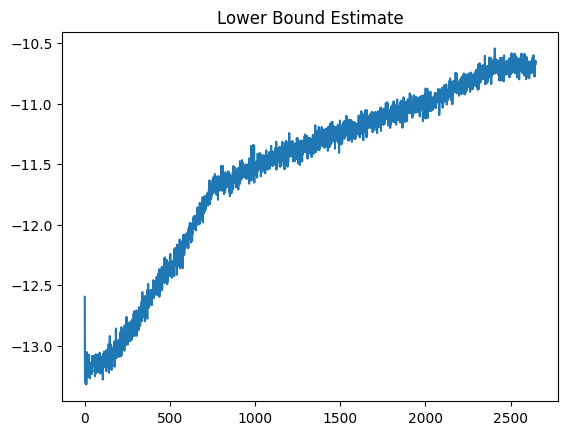

In [ ]:
lb_df = pd.DataFrame(np.array(nn_LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

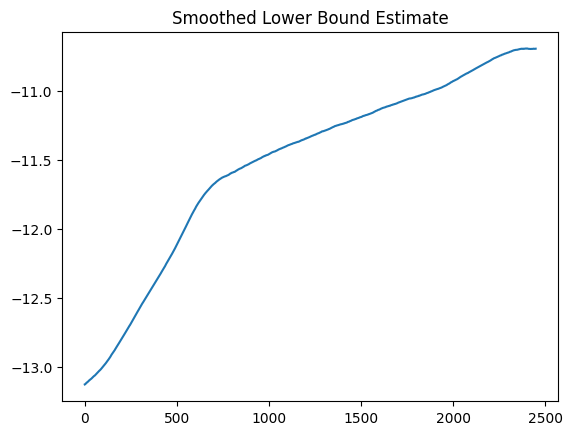

In [ ]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
nn_best_lambda_mu = jnp.array([ 0.2657605 ,  0.04282771, -0.03806014,  0.01022643])

In [ ]:
nn_best_lambda_l = jnp.array([4.2597797e+01, -8.4290638e+00,  5.1700020e+00, -1.1190910e+00,
        7.5277886e+00, -7.9416919e-01,  1.7704271e+00,  9.6175653e-01,
       -3.7182957e-02,  9.4693249e-01])

In [ ]:
best_mu = nn_best_lambda_mu
best_vech_l = list(nn_best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (10000,))

best_alpha = (5 * jnp.exp(best_theta_tilde[0]) + 0) / (1 + jnp.exp(best_theta_tilde[0]))
best_beta = (2 * jnp.exp(best_theta_tilde[1]) + 0) / (1 + jnp.exp(best_theta_tilde[1]))
best_gamma = (3 * jnp.exp(best_theta_tilde[2]) + 0) / (1 + jnp.exp(best_theta_tilde[2]))
best_delta = (1 * jnp.exp(best_theta_tilde[3]) + 0) / (1 + jnp.exp(best_theta_tilde[3]))
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate_nn = np.mean(best_theta, axis = 1)
posterior_mean_estimate_nn

array([2.434768  , 0.9943866 , 1.4077387 , 0.49045652], dtype=float32)

In [ ]:
l2_norm = np.linalg.norm(posterior_mean_estimate_nn - true_theta)
l2_norm

0.8187694

In [ ]:
## MCMC

In [ ]:
num_samples = 10000
num_burnin = 0.2 * num_samples
actual_summary_statistics = transformed_actual_summary_statistics[0]

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0]-0)/(5-true_theta[0])), np.log((true_theta[1]-0)/(2-true_theta[1])), np.log((true_theta[2]-0)/(3-true_theta[2])), np.log((true_theta[3]-0)/(1-true_theta[3]))])

    alpha = (5 * jnp.exp(theta_tilde[0]) + 0) / (1 + jnp.exp(theta_tilde[0]))
    beta = (2 * jnp.exp(theta_tilde[1]) + 0) / (1 + jnp.exp(theta_tilde[1]))
    gamma = (3 * jnp.exp(theta_tilde[2]) + 0) / (1 + jnp.exp(theta_tilde[2]))
    delta = (1 * jnp.exp(theta_tilde[3]) + 0) / (1 + jnp.exp(theta_tilde[3]))

    theta = jnp.array([alpha, beta, gamma, delta])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # Nuissance mean and variance
    mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance).T @ jnp.linalg.solve(sample_variance, jnp.diag(sample_variance))
    mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
    mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
    # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

    diag_var = jnp.zeros((num_coeffs, num_coeffs)).at[jnp.diag_indices_from(sample_variance)].set(jnp.diag(sample_variance))
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance, diff_mean)
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
    # print(mean_nuissance_q)

    variance_nuissance = mean_nuissance_p1 + (jnp.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)
    # print(variance_nuissance_q)

    # Generate Gamma

    Gamma = ss_multivariate_normal.rvs(mean = mean_nuissance, cov = variance_nuissance)
    adjusted_theta = jnp.concatenate((theta, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, actual_summary_statistics, num_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)

    # ---------------------

    prior_current = prior(theta_tilde, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**5/theta_size) * best_Sigma))
        # if i < 2000:
        #     # theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
        #     theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**5/theta_size) * best_Sigma))

        # else:
        #     if i % 1000 == 0:
        #         Sign = jnp.cov(pos_theta_tilde[0:i, :].T)
        #     u_proposal = np.random.uniform(0, 1)
        #     if u_proposal < 1:
        #         theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**5/theta_size) * best_Sigma))
        #     else:
        #         theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = (1.11**1/theta_size) * Sign)

        alpha_prop = (5 * jnp.exp(theta_proposal_tilde[0]) + 0) / (1 + jnp.exp(theta_proposal_tilde[0]))
        beta_prop = (2 * jnp.exp(theta_proposal_tilde[1]) + 0) / (1 + jnp.exp(theta_proposal_tilde[1]))
        gamma_prop = (3 * jnp.exp(theta_proposal_tilde[2]) + 0) / (1 + jnp.exp(theta_proposal_tilde[2]))
        delta_prop = (1 * jnp.exp(theta_proposal_tilde[3]) + 0) / (1 + jnp.exp(theta_proposal_tilde[3]))

        theta_proposal = jnp.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]
        # Nuissance mean and variance
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance).T @ jnp.linalg.solve(sample_variance, jnp.diag(sample_variance))
        mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diag_var = jnp.zeros((num_coeffs, num_coeffs)).at[jnp.diag_indices_from(sample_variance)].set(jnp.diag(sample_variance))
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance, diff_mean)
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
        # print(mean_nuissance_q)

        variance_nuissance = mean_nuissance_p1 + (jnp.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)
        # print(variance_nuissance_q)

        # Generate Gamma

        Gamma = ss_multivariate_normal.rvs(mean = mean_nuissance, cov = variance_nuissance)
        adjusted_theta_proposal = jnp.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, actual_summary_statistics, num_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # ---------------------

        prior_proposal = prior(theta_proposal_tilde, sigma_theta, num_coeffs)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

  0%|          | 3/9999 [00:03<3:31:19,  1.27s/it]

2 [3.00007677 1.00014317 2.00005364 0.49989355]


  0%|          | 7/9999 [00:07<2:55:43,  1.06s/it]

6 [2.9999795  1.00004756 1.99988925 0.49971759]


  0%|          | 12/9999 [00:13<2:51:59,  1.03s/it]

11 [2.99994206 1.00001156 1.9999007  0.49980313]


  0%|          | 17/9999 [00:18<3:01:03,  1.09s/it]

16 [2.9998548  0.99996179 2.00011706 0.49980476]


  0%|          | 18/9999 [00:19<2:57:43,  1.07s/it]

17 [2.9997313  0.99980044 2.0001483  0.49978751]


  0%|          | 43/9999 [00:47<2:53:31,  1.05s/it]

42 [2.99975991 0.99970025 1.99998903 0.4997479 ]


  2%|▏         | 159/9999 [02:56<2:50:24,  1.04s/it]

158 [2.99970603 0.99959046 1.99986446 0.49983248]


  5%|▍         | 481/9999 [08:51<2:50:00,  1.07s/it]

480 [2.99968266 0.99957073 1.99993801 0.4997907 ]


  5%|▌         | 509/9999 [09:21<2:42:48,  1.03s/it]

508 [2.99954438 0.99942392 2.0001502  0.49982855]


  6%|▌         | 567/9999 [10:25<2:47:09,  1.06s/it]

566 [2.99961686 0.99953896 2.00047493 0.50004238]


  7%|▋         | 737/9999 [13:33<2:41:40,  1.05s/it]

736 [2.99959326 0.99945629 2.00065184 0.50025243]


 87%|████████▋ | 8652/9999 [2:40:44<25:01,  1.11s/it]


KeyboardInterrupt: ignored

In [ ]:
w_df = pd.DataFrame(pos_w[:,:])
w_df

,0,1,2,3
0,3.037324,1.076434,2.079741,0.517506
1,3.037324,1.076434,2.079741,0.517506
2,3.037324,1.076434,2.079741,0.517506
3,3.037324,1.076434,2.079741,0.517506
4,3.037324,1.076434,2.079741,0.517506
...,...,...,...,...
7995,3.023947,1.007675,2.015075,0.494430
7996,3.023947,1.007675,2.015075,0.494430
7997,3.023947,1.007675,2.015075,0.494430
7998,3.023947,1.007675,2.015075,0.494430


In [ ]:
w_df.to_csv('mcmc_nuissance_wasserstein_gnk.csv', header = None)

In [ ]:
mcmc_nuissance_mean = np.mean(pos_w[int(num_burnin):,:], axis = 0)
mcmc_nuissance_mean

array([3.02866203, 1.0235755 , 2.0300507 , 0.49997627])

In [ ]:
mcmc_nuissance_std = np.std(pos_w[int(num_burnin):,:], axis = 0)
mcmc_nuissance_std

array([0.006302  , 0.02288903, 0.02154519, 0.00787218])

In [ ]:
best_theta = ss_multivariate_normal.rvs(mean = mcmc_nuissance_mean, cov = mcmc_nuissance_std, size = 5)
posterior_mean_estimate_mcmc = np.mean(best_theta, axis = 0)
posterior_mean_estimate_mcmc

array([3.03935825, 0.93928792, 2.05232743, 0.4757793 ])

In [ ]:
np.linalg.norm(posterior_mean_estimate_mcmc - true_theta)

0.0925193

In [ ]:
np.linalg.norm(posterior_mean_estimate - posterior_mean_estimate_mcmc)

NameError: ignored

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-6*pos_alpha_std,np.mean(best_alpha)-6*np.std(best_alpha)), max(pos_alpha_mean+10*pos_alpha_std, np.mean(best_alpha)+10*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0985, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.065, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 3, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-9*pos_beta_std,np.mean(best_beta)-9*np.std(best_beta)), max(pos_beta_mean+8*pos_beta_std, np.mean(best_beta)+8*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.065, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.065, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 1, ymin = 0, color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-6*pos_gamma_std,np.mean(best_gamma)-6*np.std(best_gamma)), max(pos_gamma_mean+6*pos_gamma_std, np.mean(best_gamma)+6*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.065, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 2, ymin = 0, color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-6*pos_delta_std,np.mean(best_delta)-6*np.std(best_delta)), max(pos_delta_mean+6*pos_delta_std, np.mean(best_delta)+6*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.035, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.045, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 0.5, ymin = 0, color = 'black', label = 'True delta')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')
